In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Login

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Setup and Training Paramters

## Parameters

In [0]:
# Size of image
image_size = 28

# no of channels
nc = 1

# size of latent space
nz = 128

# no of GPUs
ngpu = 1

# No of filters in the generator and discriminator 
ngf = 64
ndf = 64

# Batch Size
batch_size = 64

# Number of workers
num_workers = 0 # Default in Pytorch

# Enable CUDA if True
cuda = True

# Set Random Seed (set to None if not required)
manual_seed = None

# Learning Rate
lr = 0.0002 # As suggested in the DCGAN paper

# No of epochs
niter = 200

## Load Dataset

In [4]:
# Load MNIST
# Transforms are required to normalize MNIST images
dataset = dset.MNIST(root='../../data/', download=True,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

# Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(num_workers))

0it [00:00, ?it/s]

9920512it [00:01, 8845295.95it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129347.98it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


1654784it [00:00, 2127778.00it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


8192it [00:00, 51348.10it/s]            


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


## Enable CUDA

In [0]:
device = torch.device("cuda:0" if cuda else "cpu")
if cuda:
  cudnn.benchmark = True

## Set Random Seed

In [6]:
if manual_seed is None:
    manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  4988


## Architectures

### Generator

In [0]:
# Following the DCGAN paper guidelines
# No Leaky ReLus in generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

## Custom Weight Initialization

In [0]:
# custom weights initialization called on netG and netD
# It is mentioned in Section 4 page 3 to initialize weight with a normal distribution with stdev 0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

netG = Generator(ngpu).to(device)
#netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
#netD.apply(weights_init)

## Training Parameters

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.9, 0.999))

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

D_save_loc = 'gdrive/My Drive/GAN-Test/DCGAN+MNIST/D_200.ckpt'
G_save_loc = 'gdrive/My Drive/GAN-Test/DCGAN+MNIST/G_200.ckpt'

# Load Pretrained Models (Optional)

In [11]:
# Load D and G
netD.load_state_dict(torch.load('gdrive/My Drive/GAN-Test/DCGAN+MNIST/D_200.ckpt'))
netG.load_state_dict(torch.load('gdrive/My Drive/GAN-Test/DCGAN+MNIST/G_200.ckpt'))

<All keys matched successfully>

# Training

[0/200][0/938] Loss_D: 1.4233 Loss_G: 1.3733 D(x): 0.4725 D(G(z)): 0.4719 / 0.2600
[0/200][100/938] Loss_D: 0.0147 Loss_G: 5.8808 D(x): 0.9915 D(G(z)): 0.0060 / 0.0029
[0/200][200/938] Loss_D: 0.0067 Loss_G: 6.6325 D(x): 0.9976 D(G(z)): 0.0043 / 0.0017
[0/200][300/938] Loss_D: 0.0062 Loss_G: 6.3715 D(x): 0.9972 D(G(z)): 0.0034 / 0.0022
[0/200][400/938] Loss_D: 0.0122 Loss_G: 7.7163 D(x): 0.9921 D(G(z)): 0.0041 / 0.0013
[0/200][500/938] Loss_D: 0.0053 Loss_G: 6.9686 D(x): 0.9970 D(G(z)): 0.0023 / 0.0010
[0/200][600/938] Loss_D: 0.0105 Loss_G: 6.8527 D(x): 0.9958 D(G(z)): 0.0061 / 0.0030
[0/200][700/938] Loss_D: 0.0712 Loss_G: 8.2691 D(x): 0.9405 D(G(z)): 0.0022 / 0.0023
[0/200][800/938] Loss_D: 0.0071 Loss_G: 9.2335 D(x): 0.9963 D(G(z)): 0.0032 / 0.0003
[0/200][900/938] Loss_D: 0.0143 Loss_G: 11.1278 D(x): 0.9880 D(G(z)): 0.0001 / 0.0001


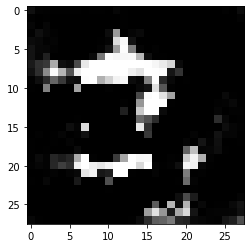

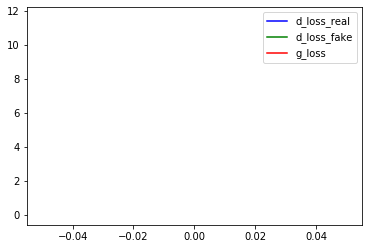

[1/200][0/938] Loss_D: 0.2272 Loss_G: 9.9320 D(x): 0.8496 D(G(z)): 0.0002 / 0.0004
[1/200][100/938] Loss_D: 0.1582 Loss_G: 10.1603 D(x): 0.9006 D(G(z)): 0.0001 / 0.0001
[1/200][200/938] Loss_D: 0.0225 Loss_G: 6.6485 D(x): 0.9958 D(G(z)): 0.0177 / 0.0033
[1/200][300/938] Loss_D: 0.4759 Loss_G: 6.7984 D(x): 0.7491 D(G(z)): 0.0047 / 0.0050
[1/200][400/938] Loss_D: 0.0372 Loss_G: 7.5750 D(x): 0.9924 D(G(z)): 0.0272 / 0.0025
[1/200][500/938] Loss_D: 0.0524 Loss_G: 5.7070 D(x): 0.9851 D(G(z)): 0.0305 / 0.0169
[1/200][600/938] Loss_D: 0.0806 Loss_G: 6.6259 D(x): 0.9861 D(G(z)): 0.0467 / 0.0180
[1/200][700/938] Loss_D: 0.5412 Loss_G: 2.6755 D(x): 0.9989 D(G(z)): 0.2529 / 0.2350
[1/200][800/938] Loss_D: 0.0368 Loss_G: 6.9092 D(x): 0.9702 D(G(z)): 0.0047 / 0.0062
[1/200][900/938] Loss_D: 0.0594 Loss_G: 4.7366 D(x): 0.9919 D(G(z)): 0.0462 / 0.0383


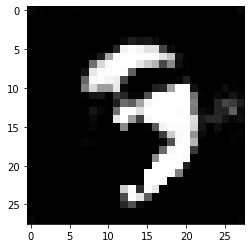

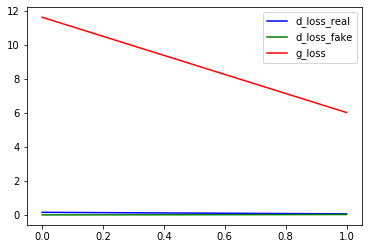

[2/200][0/938] Loss_D: 0.0771 Loss_G: 5.5260 D(x): 0.9501 D(G(z)): 0.0210 / 0.0212
[2/200][100/938] Loss_D: 0.0277 Loss_G: 8.2809 D(x): 0.9892 D(G(z)): 0.0132 / 0.0043
[2/200][200/938] Loss_D: 0.1240 Loss_G: 5.9196 D(x): 0.9930 D(G(z)): 0.0842 / 0.0174
[2/200][300/938] Loss_D: 0.1199 Loss_G: 5.7058 D(x): 0.9579 D(G(z)): 0.0561 / 0.0195
[2/200][400/938] Loss_D: 0.1755 Loss_G: 4.6129 D(x): 0.9306 D(G(z)): 0.0774 / 0.0437
[2/200][500/938] Loss_D: 0.1064 Loss_G: 5.7397 D(x): 0.9308 D(G(z)): 0.0142 / 0.0116
[2/200][600/938] Loss_D: 0.5487 Loss_G: 3.7244 D(x): 0.9370 D(G(z)): 0.3075 / 0.0671
[2/200][700/938] Loss_D: 0.4947 Loss_G: 3.4489 D(x): 0.8954 D(G(z)): 0.2166 / 0.1028
[2/200][800/938] Loss_D: 0.8120 Loss_G: 3.4741 D(x): 0.9629 D(G(z)): 0.3982 / 0.0958
[2/200][900/938] Loss_D: 0.2799 Loss_G: 3.5000 D(x): 0.9304 D(G(z)): 0.1419 / 0.0903


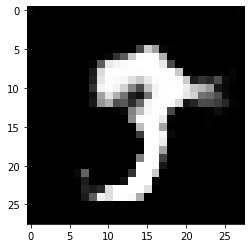

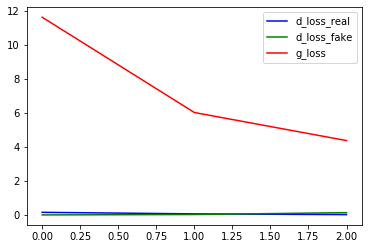

[3/200][0/938] Loss_D: 0.1560 Loss_G: 4.2486 D(x): 0.9292 D(G(z)): 0.0607 / 0.0359
[3/200][100/938] Loss_D: 0.1380 Loss_G: 4.4933 D(x): 0.9055 D(G(z)): 0.0209 / 0.0318
[3/200][200/938] Loss_D: 0.4490 Loss_G: 3.0727 D(x): 0.9315 D(G(z)): 0.2437 / 0.1360
[3/200][300/938] Loss_D: 0.3605 Loss_G: 4.0567 D(x): 0.9619 D(G(z)): 0.2017 / 0.1049
[3/200][400/938] Loss_D: 0.0632 Loss_G: 5.0462 D(x): 0.9652 D(G(z)): 0.0233 / 0.0155
[3/200][500/938] Loss_D: 0.3489 Loss_G: 2.7851 D(x): 0.9417 D(G(z)): 0.1851 / 0.1530
[3/200][600/938] Loss_D: 0.1853 Loss_G: 3.3305 D(x): 0.9088 D(G(z)): 0.0649 / 0.0713
[3/200][700/938] Loss_D: 0.4653 Loss_G: 3.9141 D(x): 0.7603 D(G(z)): 0.0957 / 0.0669
[3/200][800/938] Loss_D: 0.2503 Loss_G: 3.0000 D(x): 0.8767 D(G(z)): 0.0799 / 0.1060
[3/200][900/938] Loss_D: 0.2875 Loss_G: 4.2771 D(x): 0.8607 D(G(z)): 0.0964 / 0.0264


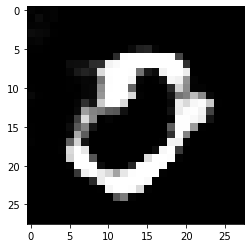

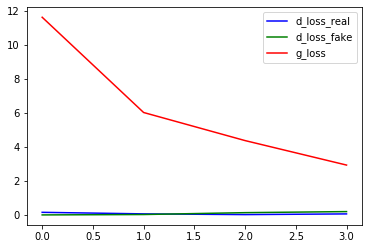

[4/200][0/938] Loss_D: 0.3401 Loss_G: 2.9223 D(x): 0.9366 D(G(z)): 0.2109 / 0.0929
[4/200][100/938] Loss_D: 0.1728 Loss_G: 3.6353 D(x): 0.9208 D(G(z)): 0.0704 / 0.0583
[4/200][200/938] Loss_D: 0.2511 Loss_G: 2.6775 D(x): 0.9445 D(G(z)): 0.1179 / 0.1363
[4/200][300/938] Loss_D: 0.1879 Loss_G: 3.1598 D(x): 0.9630 D(G(z)): 0.1259 / 0.0833
[4/200][400/938] Loss_D: 0.1462 Loss_G: 3.7260 D(x): 0.9537 D(G(z)): 0.0797 / 0.0522
[4/200][500/938] Loss_D: 0.2350 Loss_G: 3.4640 D(x): 0.9114 D(G(z)): 0.1073 / 0.0655
[4/200][600/938] Loss_D: 0.2433 Loss_G: 4.0893 D(x): 0.9090 D(G(z)): 0.1071 / 0.0433
[4/200][700/938] Loss_D: 0.3250 Loss_G: 2.3867 D(x): 0.9048 D(G(z)): 0.1567 / 0.1994
[4/200][800/938] Loss_D: 0.1042 Loss_G: 4.2579 D(x): 0.9608 D(G(z)): 0.0554 / 0.0361
[4/200][900/938] Loss_D: 0.2952 Loss_G: 4.4298 D(x): 0.8158 D(G(z)): 0.0174 / 0.0262


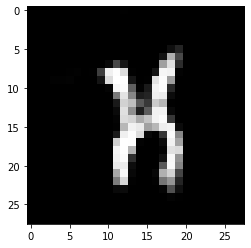

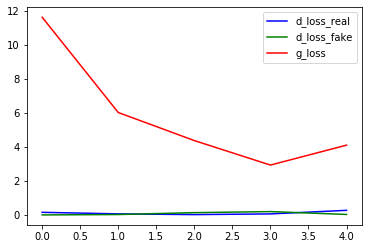

[5/200][0/938] Loss_D: 0.1822 Loss_G: 2.3016 D(x): 0.9426 D(G(z)): 0.1022 / 0.1629
[5/200][100/938] Loss_D: 0.2312 Loss_G: 2.6710 D(x): 0.8979 D(G(z)): 0.0961 / 0.1128
[5/200][200/938] Loss_D: 0.1492 Loss_G: 4.5153 D(x): 0.9298 D(G(z)): 0.0638 / 0.0249
[5/200][300/938] Loss_D: 0.2273 Loss_G: 3.0323 D(x): 0.8625 D(G(z)): 0.0477 / 0.0978
[5/200][400/938] Loss_D: 0.2476 Loss_G: 3.6818 D(x): 0.9123 D(G(z)): 0.1266 / 0.0480
[5/200][500/938] Loss_D: 0.2055 Loss_G: 3.4584 D(x): 0.9113 D(G(z)): 0.0824 / 0.0785
[5/200][600/938] Loss_D: 0.0953 Loss_G: 3.5138 D(x): 0.9617 D(G(z)): 0.0505 / 0.0570
[5/200][700/938] Loss_D: 0.6533 Loss_G: 2.0795 D(x): 0.9731 D(G(z)): 0.3853 / 0.2043
[5/200][800/938] Loss_D: 0.2338 Loss_G: 4.3833 D(x): 0.8665 D(G(z)): 0.0545 / 0.0308
[5/200][900/938] Loss_D: 0.2703 Loss_G: 3.8636 D(x): 0.9429 D(G(z)): 0.1655 / 0.0376


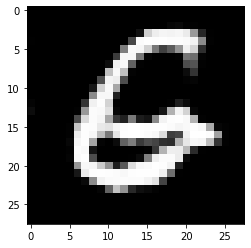

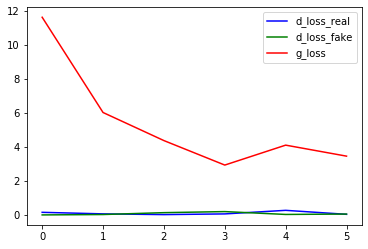

[6/200][0/938] Loss_D: 0.2727 Loss_G: 2.4818 D(x): 0.9735 D(G(z)): 0.1825 / 0.1665
[6/200][100/938] Loss_D: 0.2335 Loss_G: 3.4488 D(x): 0.9386 D(G(z)): 0.1382 / 0.0642
[6/200][200/938] Loss_D: 0.1518 Loss_G: 2.1056 D(x): 0.9776 D(G(z)): 0.1079 / 0.1980
[6/200][300/938] Loss_D: 0.4335 Loss_G: 1.7592 D(x): 0.9955 D(G(z)): 0.3028 / 0.2490
[6/200][400/938] Loss_D: 0.2646 Loss_G: 4.6893 D(x): 0.8011 D(G(z)): 0.0161 / 0.0199
[6/200][500/938] Loss_D: 0.5507 Loss_G: 2.2963 D(x): 0.6687 D(G(z)): 0.0512 / 0.1793
[6/200][600/938] Loss_D: 0.2317 Loss_G: 4.7624 D(x): 0.8655 D(G(z)): 0.0559 / 0.0281
[6/200][700/938] Loss_D: 0.0975 Loss_G: 5.2393 D(x): 0.9265 D(G(z)): 0.0143 / 0.0109
[6/200][800/938] Loss_D: 0.6477 Loss_G: 3.2034 D(x): 0.6385 D(G(z)): 0.0644 / 0.0713
[6/200][900/938] Loss_D: 0.4445 Loss_G: 1.1536 D(x): 0.9247 D(G(z)): 0.2585 / 0.4394


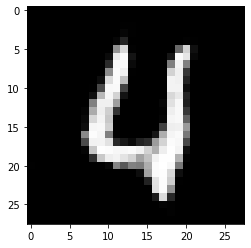

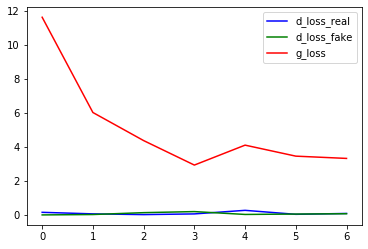

[7/200][0/938] Loss_D: 0.1687 Loss_G: 3.2963 D(x): 0.9674 D(G(z)): 0.1142 / 0.0825
[7/200][100/938] Loss_D: 0.5713 Loss_G: 3.4333 D(x): 0.6639 D(G(z)): 0.0547 / 0.0629
[7/200][200/938] Loss_D: 0.4991 Loss_G: 1.9487 D(x): 0.7111 D(G(z)): 0.0724 / 0.2397
[7/200][300/938] Loss_D: 0.1610 Loss_G: 4.7532 D(x): 0.8975 D(G(z)): 0.0358 / 0.0288
[7/200][400/938] Loss_D: 0.0982 Loss_G: 3.3424 D(x): 0.9479 D(G(z)): 0.0396 / 0.0826
[7/200][500/938] Loss_D: 0.2670 Loss_G: 3.6665 D(x): 0.8833 D(G(z)): 0.1120 / 0.0479
[7/200][600/938] Loss_D: 0.2274 Loss_G: 2.5600 D(x): 0.9105 D(G(z)): 0.1057 / 0.1340
[7/200][700/938] Loss_D: 0.4886 Loss_G: 2.7281 D(x): 0.7008 D(G(z)): 0.0664 / 0.1239
[7/200][800/938] Loss_D: 0.2708 Loss_G: 3.6374 D(x): 0.8575 D(G(z)): 0.0801 / 0.0638
[7/200][900/938] Loss_D: 0.1742 Loss_G: 3.3177 D(x): 0.9758 D(G(z)): 0.1281 / 0.0742


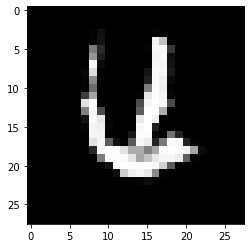

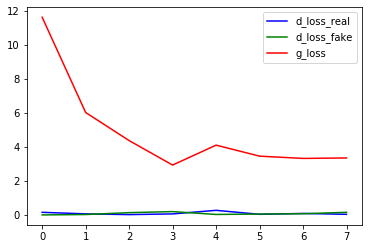

[8/200][0/938] Loss_D: 0.3149 Loss_G: 3.5010 D(x): 0.8272 D(G(z)): 0.0707 / 0.0686
[8/200][100/938] Loss_D: 0.2618 Loss_G: 3.3773 D(x): 0.9715 D(G(z)): 0.1718 / 0.0706
[8/200][200/938] Loss_D: 0.3182 Loss_G: 3.6122 D(x): 0.8084 D(G(z)): 0.0650 / 0.0547
[8/200][300/938] Loss_D: 0.4018 Loss_G: 2.6534 D(x): 0.8381 D(G(z)): 0.1550 / 0.1363
[8/200][400/938] Loss_D: 0.5195 Loss_G: 1.7382 D(x): 0.9362 D(G(z)): 0.3053 / 0.2495
[8/200][500/938] Loss_D: 0.2552 Loss_G: 2.8863 D(x): 0.9648 D(G(z)): 0.1735 / 0.0950
[8/200][600/938] Loss_D: 0.4368 Loss_G: 2.1361 D(x): 0.8121 D(G(z)): 0.1416 / 0.2013
[8/200][700/938] Loss_D: 0.2579 Loss_G: 2.8502 D(x): 0.9562 D(G(z)): 0.1624 / 0.1019
[8/200][800/938] Loss_D: 0.2638 Loss_G: 2.3791 D(x): 0.9612 D(G(z)): 0.1674 / 0.1852
[8/200][900/938] Loss_D: 0.4552 Loss_G: 3.0325 D(x): 0.7530 D(G(z)): 0.1056 / 0.0969


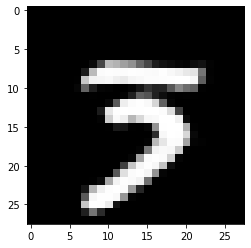

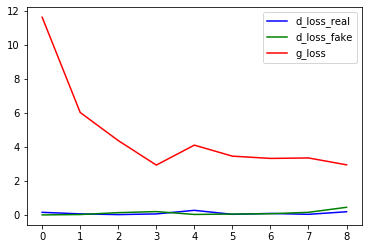

[9/200][0/938] Loss_D: 0.4635 Loss_G: 3.6070 D(x): 0.7952 D(G(z)): 0.1509 / 0.0598
[9/200][100/938] Loss_D: 0.3426 Loss_G: 3.2253 D(x): 0.8115 D(G(z)): 0.0786 / 0.0774
[9/200][200/938] Loss_D: 0.4089 Loss_G: 1.3374 D(x): 0.7894 D(G(z)): 0.1165 / 0.3941
[9/200][300/938] Loss_D: 0.2793 Loss_G: 2.8973 D(x): 0.9089 D(G(z)): 0.1363 / 0.1066
[9/200][400/938] Loss_D: 0.8300 Loss_G: 1.0114 D(x): 0.9617 D(G(z)): 0.4466 / 0.4605
[9/200][500/938] Loss_D: 0.4253 Loss_G: 4.4450 D(x): 0.7299 D(G(z)): 0.0209 / 0.0265
[9/200][600/938] Loss_D: 0.3126 Loss_G: 2.7914 D(x): 0.8272 D(G(z)): 0.0864 / 0.1102
[9/200][700/938] Loss_D: 0.4305 Loss_G: 3.0227 D(x): 0.8876 D(G(z)): 0.2152 / 0.1085
[9/200][800/938] Loss_D: 0.3052 Loss_G: 2.9120 D(x): 0.9341 D(G(z)): 0.1851 / 0.1053
[9/200][900/938] Loss_D: 0.3841 Loss_G: 4.3274 D(x): 0.8386 D(G(z)): 0.1311 / 0.0363


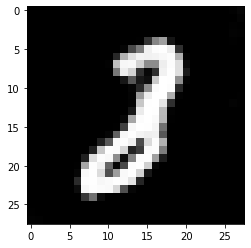

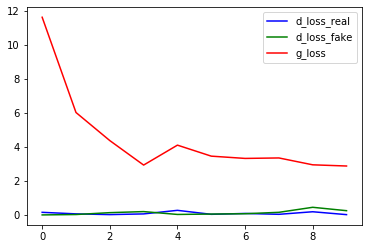

[10/200][0/938] Loss_D: 0.2852 Loss_G: 3.7755 D(x): 0.9468 D(G(z)): 0.1688 / 0.0553
[10/200][100/938] Loss_D: 0.2007 Loss_G: 4.1919 D(x): 0.8812 D(G(z)): 0.0446 / 0.0323
[10/200][200/938] Loss_D: 0.2618 Loss_G: 2.9271 D(x): 0.9557 D(G(z)): 0.1675 / 0.1111
[10/200][300/938] Loss_D: 0.1459 Loss_G: 3.5225 D(x): 0.9450 D(G(z)): 0.0757 / 0.0666
[10/200][400/938] Loss_D: 0.4319 Loss_G: 5.3614 D(x): 0.7279 D(G(z)): 0.0192 / 0.0130
[10/200][500/938] Loss_D: 0.2994 Loss_G: 3.1144 D(x): 0.8662 D(G(z)): 0.1056 / 0.0939
[10/200][600/938] Loss_D: 0.4659 Loss_G: 3.8457 D(x): 0.6852 D(G(z)): 0.0168 / 0.0462
[10/200][700/938] Loss_D: 0.7288 Loss_G: 1.9262 D(x): 0.9721 D(G(z)): 0.4147 / 0.2193
[10/200][800/938] Loss_D: 0.2691 Loss_G: 2.9155 D(x): 0.9116 D(G(z)): 0.1351 / 0.1099
[10/200][900/938] Loss_D: 0.3818 Loss_G: 2.5301 D(x): 0.7772 D(G(z)): 0.0602 / 0.1296


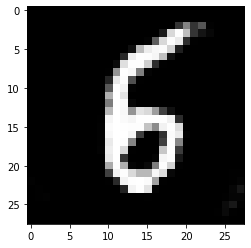

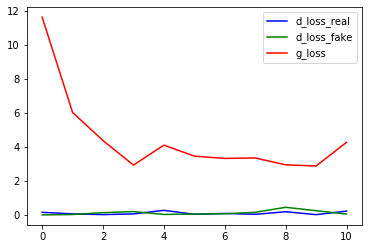

[11/200][0/938] Loss_D: 0.3990 Loss_G: 3.1099 D(x): 0.7471 D(G(z)): 0.0477 / 0.0949
[11/200][100/938] Loss_D: 0.2517 Loss_G: 2.5745 D(x): 0.9096 D(G(z)): 0.1232 / 0.1365
[11/200][200/938] Loss_D: 0.2832 Loss_G: 2.4804 D(x): 0.9307 D(G(z)): 0.1638 / 0.1334
[11/200][300/938] Loss_D: 0.1941 Loss_G: 4.8642 D(x): 0.8531 D(G(z)): 0.0190 / 0.0165
[11/200][400/938] Loss_D: 0.2289 Loss_G: 3.1030 D(x): 0.8865 D(G(z)): 0.0723 / 0.0887
[11/200][500/938] Loss_D: 0.1823 Loss_G: 3.5060 D(x): 0.9256 D(G(z)): 0.0896 / 0.0592
[11/200][600/938] Loss_D: 0.4568 Loss_G: 1.9844 D(x): 0.9413 D(G(z)): 0.2659 / 0.2261
[11/200][700/938] Loss_D: 0.3303 Loss_G: 3.0879 D(x): 0.8093 D(G(z)): 0.0805 / 0.0970
[11/200][800/938] Loss_D: 0.3234 Loss_G: 4.1514 D(x): 0.7813 D(G(z)): 0.0311 / 0.0350
[11/200][900/938] Loss_D: 0.1181 Loss_G: 2.6922 D(x): 0.9604 D(G(z)): 0.0651 / 0.1085


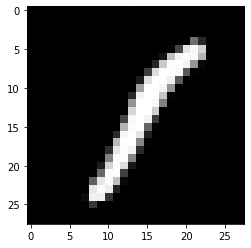

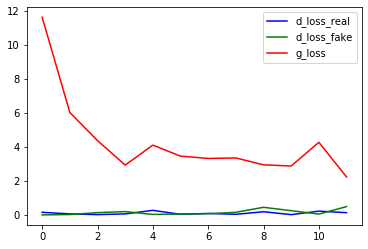

[12/200][0/938] Loss_D: 0.1680 Loss_G: 4.6599 D(x): 0.8824 D(G(z)): 0.0261 / 0.0260
[12/200][100/938] Loss_D: 0.3597 Loss_G: 3.3941 D(x): 0.8881 D(G(z)): 0.1735 / 0.0760
[12/200][200/938] Loss_D: 0.7753 Loss_G: 3.3740 D(x): 0.5626 D(G(z)): 0.0545 / 0.0632
[12/200][300/938] Loss_D: 0.6585 Loss_G: 1.0223 D(x): 0.9867 D(G(z)): 0.3899 / 0.4513
[12/200][400/938] Loss_D: 0.2193 Loss_G: 4.7100 D(x): 0.8429 D(G(z)): 0.0294 / 0.0165
[12/200][500/938] Loss_D: 0.4454 Loss_G: 3.6087 D(x): 0.7438 D(G(z)): 0.0700 / 0.0590
[12/200][600/938] Loss_D: 0.3533 Loss_G: 2.5127 D(x): 0.9187 D(G(z)): 0.1982 / 0.1709
[12/200][700/938] Loss_D: 0.2475 Loss_G: 2.2502 D(x): 0.9627 D(G(z)): 0.1587 / 0.1798
[12/200][800/938] Loss_D: 0.7289 Loss_G: 2.9760 D(x): 0.7488 D(G(z)): 0.2551 / 0.0940
[12/200][900/938] Loss_D: 0.1359 Loss_G: 4.0761 D(x): 0.9386 D(G(z)): 0.0590 / 0.0409


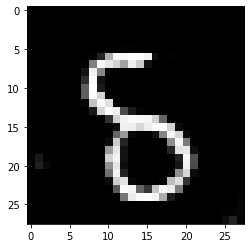

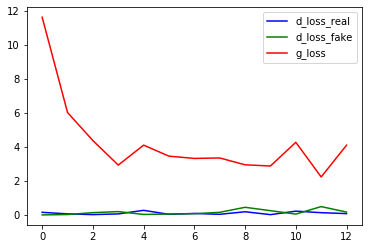

[13/200][0/938] Loss_D: 0.2090 Loss_G: 5.2538 D(x): 0.8707 D(G(z)): 0.0397 / 0.0187
[13/200][100/938] Loss_D: 0.1468 Loss_G: 3.6042 D(x): 0.9812 D(G(z)): 0.1094 / 0.0586
[13/200][200/938] Loss_D: 0.2900 Loss_G: 2.1915 D(x): 0.9165 D(G(z)): 0.1614 / 0.2210
[13/200][300/938] Loss_D: 0.1853 Loss_G: 3.3008 D(x): 0.9160 D(G(z)): 0.0802 / 0.0779
[13/200][400/938] Loss_D: 0.6976 Loss_G: 1.7486 D(x): 0.7069 D(G(z)): 0.1900 / 0.2688
[13/200][500/938] Loss_D: 0.3122 Loss_G: 4.2000 D(x): 0.8041 D(G(z)): 0.0430 / 0.0402
[13/200][600/938] Loss_D: 0.6561 Loss_G: 2.7642 D(x): 0.9599 D(G(z)): 0.3792 / 0.1156
[13/200][700/938] Loss_D: 0.3266 Loss_G: 4.0453 D(x): 0.7905 D(G(z)): 0.0518 / 0.0427
[13/200][800/938] Loss_D: 0.1740 Loss_G: 3.3913 D(x): 0.9110 D(G(z)): 0.0681 / 0.0667
[13/200][900/938] Loss_D: 0.2959 Loss_G: 4.6216 D(x): 0.8098 D(G(z)): 0.0377 / 0.0289


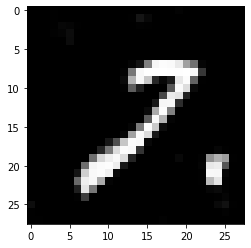

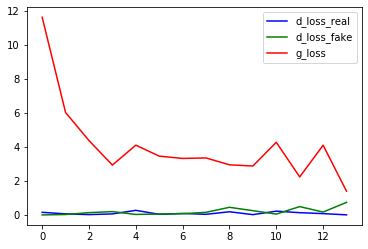

[14/200][0/938] Loss_D: 0.5816 Loss_G: 2.5761 D(x): 0.9942 D(G(z)): 0.3559 / 0.1440
[14/200][100/938] Loss_D: 0.7090 Loss_G: 3.5357 D(x): 0.5952 D(G(z)): 0.0274 / 0.0576
[14/200][200/938] Loss_D: 0.5500 Loss_G: 2.9721 D(x): 0.9173 D(G(z)): 0.3084 / 0.1089
[14/200][300/938] Loss_D: 0.3063 Loss_G: 3.3460 D(x): 0.8151 D(G(z)): 0.0606 / 0.0857
[14/200][400/938] Loss_D: 0.4594 Loss_G: 2.1118 D(x): 0.7456 D(G(z)): 0.0866 / 0.2043
[14/200][500/938] Loss_D: 0.3581 Loss_G: 2.8138 D(x): 0.8815 D(G(z)): 0.1606 / 0.1130
[14/200][600/938] Loss_D: 0.2144 Loss_G: 3.9171 D(x): 0.8952 D(G(z)): 0.0791 / 0.0339
[14/200][700/938] Loss_D: 0.4018 Loss_G: 2.2459 D(x): 0.9841 D(G(z)): 0.2702 / 0.1841
[14/200][800/938] Loss_D: 0.2780 Loss_G: 3.0856 D(x): 0.8546 D(G(z)): 0.0789 / 0.0904
[14/200][900/938] Loss_D: 0.5008 Loss_G: 3.0652 D(x): 0.7350 D(G(z)): 0.1278 / 0.0814


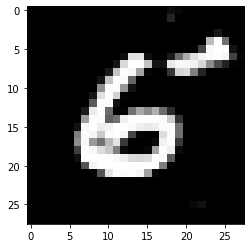

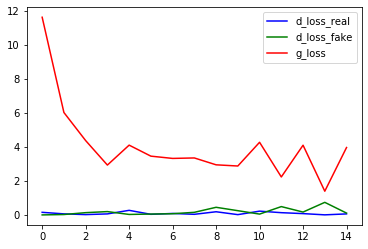

[15/200][0/938] Loss_D: 0.4736 Loss_G: 3.6518 D(x): 0.7225 D(G(z)): 0.0509 / 0.0459
[15/200][100/938] Loss_D: 0.5276 Loss_G: 2.8495 D(x): 0.9388 D(G(z)): 0.3097 / 0.1219
[15/200][200/938] Loss_D: 0.2259 Loss_G: 2.9721 D(x): 0.9191 D(G(z)): 0.1087 / 0.1034
[15/200][300/938] Loss_D: 0.3466 Loss_G: 2.9078 D(x): 0.8287 D(G(z)): 0.1120 / 0.1143
[15/200][400/938] Loss_D: 0.2273 Loss_G: 2.5721 D(x): 0.9782 D(G(z)): 0.1638 / 0.1298
[15/200][500/938] Loss_D: 0.5077 Loss_G: 5.0216 D(x): 0.6996 D(G(z)): 0.0363 / 0.0211
[15/200][600/938] Loss_D: 0.4001 Loss_G: 1.9505 D(x): 0.9420 D(G(z)): 0.2184 / 0.2359
[15/200][700/938] Loss_D: 0.4636 Loss_G: 2.8831 D(x): 0.8736 D(G(z)): 0.2213 / 0.1037
[15/200][800/938] Loss_D: 0.2297 Loss_G: 3.9819 D(x): 0.8440 D(G(z)): 0.0382 / 0.0429
[15/200][900/938] Loss_D: 0.2792 Loss_G: 3.0916 D(x): 0.8183 D(G(z)): 0.0444 / 0.0900


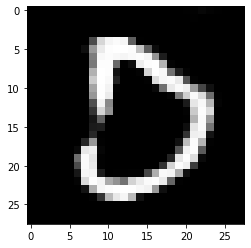

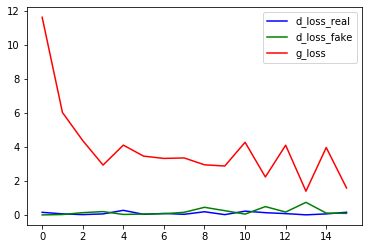

[16/200][0/938] Loss_D: 0.7652 Loss_G: 1.0270 D(x): 0.9935 D(G(z)): 0.4428 / 0.4474
[16/200][100/938] Loss_D: 0.1271 Loss_G: 3.4808 D(x): 0.9508 D(G(z)): 0.0654 / 0.0647
[16/200][200/938] Loss_D: 0.4442 Loss_G: 2.1272 D(x): 0.9557 D(G(z)): 0.2845 / 0.1853
[16/200][300/938] Loss_D: 0.6009 Loss_G: 2.5146 D(x): 0.9203 D(G(z)): 0.3266 / 0.1498
[16/200][400/938] Loss_D: 0.4587 Loss_G: 3.1369 D(x): 0.7746 D(G(z)): 0.1218 / 0.0935
[16/200][500/938] Loss_D: 0.2607 Loss_G: 2.8021 D(x): 0.8595 D(G(z)): 0.0840 / 0.1092
[16/200][600/938] Loss_D: 0.2826 Loss_G: 3.2266 D(x): 0.8620 D(G(z)): 0.0844 / 0.0976
[16/200][700/938] Loss_D: 0.2323 Loss_G: 3.9004 D(x): 0.8558 D(G(z)): 0.0461 / 0.0456
[16/200][800/938] Loss_D: 0.1968 Loss_G: 3.0047 D(x): 0.9163 D(G(z)): 0.0810 / 0.1023
[16/200][900/938] Loss_D: 0.5244 Loss_G: 2.5281 D(x): 0.9805 D(G(z)): 0.3165 / 0.1526


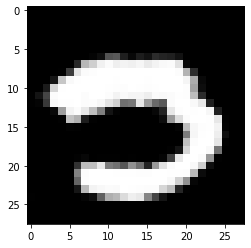

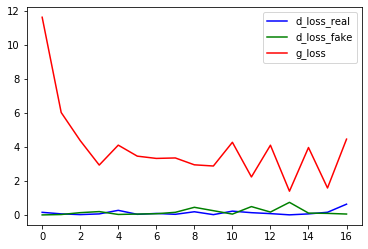

[17/200][0/938] Loss_D: 0.3334 Loss_G: 3.0803 D(x): 0.7964 D(G(z)): 0.0664 / 0.0997
[17/200][100/938] Loss_D: 0.2045 Loss_G: 4.8354 D(x): 0.8468 D(G(z)): 0.0174 / 0.0183
[17/200][200/938] Loss_D: 0.2940 Loss_G: 2.8923 D(x): 0.8438 D(G(z)): 0.0974 / 0.0930
[17/200][300/938] Loss_D: 0.4343 Loss_G: 2.7873 D(x): 0.8078 D(G(z)): 0.1384 / 0.1276
[17/200][400/938] Loss_D: 0.1610 Loss_G: 4.5604 D(x): 0.8987 D(G(z)): 0.0358 / 0.0221
[17/200][500/938] Loss_D: 0.3058 Loss_G: 2.4424 D(x): 0.9313 D(G(z)): 0.1612 / 0.1418
[17/200][600/938] Loss_D: 0.4355 Loss_G: 1.9781 D(x): 0.9608 D(G(z)): 0.2681 / 0.2457
[17/200][700/938] Loss_D: 0.4540 Loss_G: 2.6109 D(x): 0.8743 D(G(z)): 0.2067 / 0.1681
[17/200][800/938] Loss_D: 0.4416 Loss_G: 2.4233 D(x): 0.8479 D(G(z)): 0.2031 / 0.1557
[17/200][900/938] Loss_D: 0.3164 Loss_G: 2.5210 D(x): 0.9312 D(G(z)): 0.1890 / 0.1343


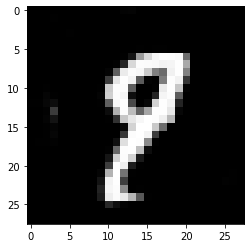

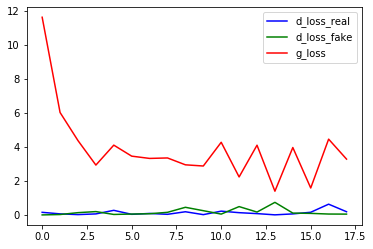

[18/200][0/938] Loss_D: 0.2983 Loss_G: 2.2725 D(x): 0.9033 D(G(z)): 0.1519 / 0.1650
[18/200][100/938] Loss_D: 0.3325 Loss_G: 3.3996 D(x): 0.7908 D(G(z)): 0.0621 / 0.0683
[18/200][200/938] Loss_D: 0.3316 Loss_G: 3.0799 D(x): 0.9262 D(G(z)): 0.1921 / 0.0906
[18/200][300/938] Loss_D: 0.2760 Loss_G: 3.9844 D(x): 0.8223 D(G(z)): 0.0429 / 0.0426
[18/200][400/938] Loss_D: 0.2138 Loss_G: 2.8378 D(x): 0.8989 D(G(z)): 0.0789 / 0.1199
[18/200][500/938] Loss_D: 0.3249 Loss_G: 5.9315 D(x): 0.7664 D(G(z)): 0.0121 / 0.0062
[18/200][600/938] Loss_D: 0.5978 Loss_G: 2.3355 D(x): 0.7125 D(G(z)): 0.1225 / 0.1766
[18/200][700/938] Loss_D: 0.3475 Loss_G: 3.3042 D(x): 0.7872 D(G(z)): 0.0599 / 0.0691
[18/200][800/938] Loss_D: 0.5217 Loss_G: 4.7743 D(x): 0.6638 D(G(z)): 0.0186 / 0.0213
[18/200][900/938] Loss_D: 0.4479 Loss_G: 2.6754 D(x): 0.9139 D(G(z)): 0.2454 / 0.1367


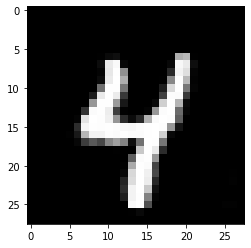

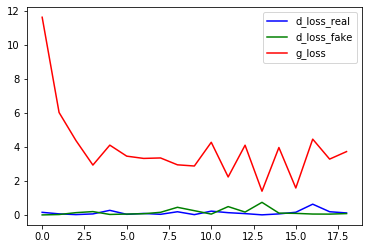

[19/200][0/938] Loss_D: 0.6589 Loss_G: 2.2729 D(x): 0.6503 D(G(z)): 0.0996 / 0.1633
[19/200][100/938] Loss_D: 0.2882 Loss_G: 2.9750 D(x): 0.8203 D(G(z)): 0.0634 / 0.1014
[19/200][200/938] Loss_D: 0.3444 Loss_G: 5.5074 D(x): 0.7547 D(G(z)): 0.0188 / 0.0104
[19/200][300/938] Loss_D: 0.1646 Loss_G: 3.2246 D(x): 0.8992 D(G(z)): 0.0385 / 0.0786
[19/200][400/938] Loss_D: 0.1571 Loss_G: 3.3113 D(x): 0.9421 D(G(z)): 0.0791 / 0.0797
[19/200][500/938] Loss_D: 0.4163 Loss_G: 2.9176 D(x): 0.9231 D(G(z)): 0.2386 / 0.0954
[19/200][600/938] Loss_D: 0.1941 Loss_G: 3.5956 D(x): 0.9043 D(G(z)): 0.0682 / 0.0694
[19/200][700/938] Loss_D: 0.3202 Loss_G: 4.1445 D(x): 0.9313 D(G(z)): 0.1804 / 0.0470
[19/200][800/938] Loss_D: 0.0820 Loss_G: 3.9299 D(x): 0.9776 D(G(z)): 0.0542 / 0.0453
[19/200][900/938] Loss_D: 0.4682 Loss_G: 3.1306 D(x): 0.9031 D(G(z)): 0.2434 / 0.1090


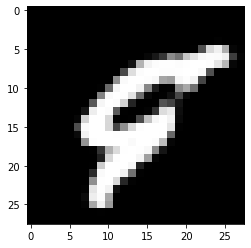

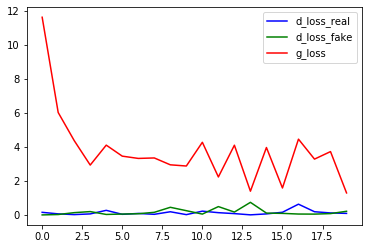

[20/200][0/938] Loss_D: 1.0802 Loss_G: 1.9815 D(x): 0.9972 D(G(z)): 0.5499 / 0.2168
[20/200][100/938] Loss_D: 0.1739 Loss_G: 3.8100 D(x): 0.9668 D(G(z)): 0.1027 / 0.0684
[20/200][200/938] Loss_D: 0.2530 Loss_G: 4.3276 D(x): 0.8392 D(G(z)): 0.0480 / 0.0268
[20/200][300/938] Loss_D: 0.5129 Loss_G: 2.5967 D(x): 0.7352 D(G(z)): 0.1115 / 0.1290
[20/200][400/938] Loss_D: 0.2453 Loss_G: 2.6443 D(x): 0.9531 D(G(z)): 0.1523 / 0.1447
[20/200][500/938] Loss_D: 0.5743 Loss_G: 2.9487 D(x): 0.9378 D(G(z)): 0.3279 / 0.1138
[20/200][600/938] Loss_D: 0.5110 Loss_G: 2.6813 D(x): 0.9198 D(G(z)): 0.2870 / 0.1242
[20/200][700/938] Loss_D: 0.6176 Loss_G: 3.3713 D(x): 0.6491 D(G(z)): 0.1034 / 0.0666
[20/200][800/938] Loss_D: 0.3114 Loss_G: 2.9340 D(x): 0.9018 D(G(z)): 0.1543 / 0.1220
[20/200][900/938] Loss_D: 0.3577 Loss_G: 4.8589 D(x): 0.7939 D(G(z)): 0.0741 / 0.0169


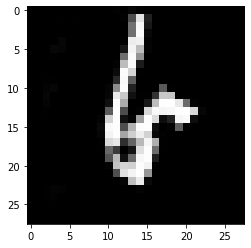

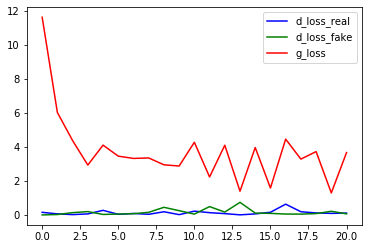

[21/200][0/938] Loss_D: 0.2844 Loss_G: 3.1267 D(x): 0.8452 D(G(z)): 0.0767 / 0.0806
[21/200][100/938] Loss_D: 0.4283 Loss_G: 4.3856 D(x): 0.7236 D(G(z)): 0.0486 / 0.0526
[21/200][200/938] Loss_D: 0.5224 Loss_G: 2.7085 D(x): 0.9237 D(G(z)): 0.2813 / 0.1241
[21/200][300/938] Loss_D: 0.4893 Loss_G: 3.2099 D(x): 0.8821 D(G(z)): 0.2508 / 0.0817
[21/200][400/938] Loss_D: 0.4438 Loss_G: 4.7018 D(x): 0.6910 D(G(z)): 0.0147 / 0.0281
[21/200][500/938] Loss_D: 0.2686 Loss_G: 4.3364 D(x): 0.8539 D(G(z)): 0.0747 / 0.0354
[21/200][600/938] Loss_D: 0.3084 Loss_G: 3.5777 D(x): 0.9292 D(G(z)): 0.1796 / 0.0656
[21/200][700/938] Loss_D: 0.3366 Loss_G: 3.8115 D(x): 0.8320 D(G(z)): 0.1030 / 0.0551
[21/200][800/938] Loss_D: 0.4559 Loss_G: 4.0002 D(x): 0.6964 D(G(z)): 0.0350 / 0.0474
[21/200][900/938] Loss_D: 0.4504 Loss_G: 3.1450 D(x): 0.8401 D(G(z)): 0.1941 / 0.0894


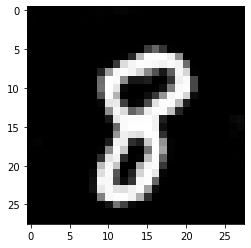

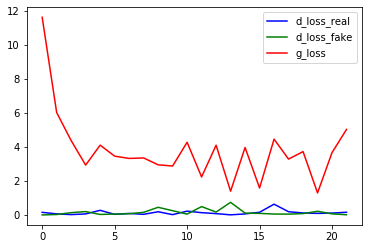

[22/200][0/938] Loss_D: 0.4027 Loss_G: 2.0650 D(x): 0.9568 D(G(z)): 0.2437 / 0.2378
[22/200][100/938] Loss_D: 0.6478 Loss_G: 2.7117 D(x): 0.6477 D(G(z)): 0.1102 / 0.1333
[22/200][200/938] Loss_D: 0.2481 Loss_G: 3.3887 D(x): 0.8339 D(G(z)): 0.0352 / 0.0774
[22/200][300/938] Loss_D: 0.1873 Loss_G: 3.8901 D(x): 0.8711 D(G(z)): 0.0256 / 0.0509
[22/200][400/938] Loss_D: 0.5657 Loss_G: 1.9751 D(x): 0.9581 D(G(z)): 0.3155 / 0.2367
[22/200][500/938] Loss_D: 0.1641 Loss_G: 4.2223 D(x): 0.9242 D(G(z)): 0.0616 / 0.0373
[22/200][600/938] Loss_D: 1.1987 Loss_G: 3.2826 D(x): 0.4038 D(G(z)): 0.0179 / 0.0753
[22/200][700/938] Loss_D: 0.2895 Loss_G: 2.8237 D(x): 0.9616 D(G(z)): 0.1843 / 0.1144
[22/200][800/938] Loss_D: 0.7158 Loss_G: 1.8602 D(x): 0.9854 D(G(z)): 0.4257 / 0.2315
[22/200][900/938] Loss_D: 0.1213 Loss_G: 4.7832 D(x): 0.9253 D(G(z)): 0.0352 / 0.0235


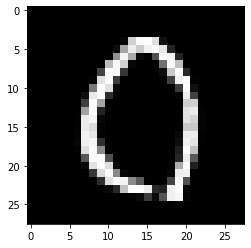

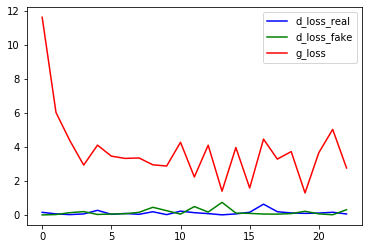

[23/200][0/938] Loss_D: 0.4695 Loss_G: 3.1852 D(x): 0.8984 D(G(z)): 0.2364 / 0.0882
[23/200][100/938] Loss_D: 0.6261 Loss_G: 3.8061 D(x): 0.6655 D(G(z)): 0.1015 / 0.0824
[23/200][200/938] Loss_D: 0.3795 Loss_G: 2.3828 D(x): 0.7827 D(G(z)): 0.0878 / 0.1684
[23/200][300/938] Loss_D: 0.3124 Loss_G: 4.2694 D(x): 0.7776 D(G(z)): 0.0198 / 0.0339
[23/200][400/938] Loss_D: 0.2872 Loss_G: 3.2596 D(x): 0.8724 D(G(z)): 0.0965 / 0.0864
[23/200][500/938] Loss_D: 0.2568 Loss_G: 5.1512 D(x): 0.8196 D(G(z)): 0.0133 / 0.0156
[23/200][600/938] Loss_D: 0.1482 Loss_G: 5.4366 D(x): 0.8926 D(G(z)): 0.0264 / 0.0140
[23/200][700/938] Loss_D: 0.4008 Loss_G: 3.1445 D(x): 0.9746 D(G(z)): 0.2617 / 0.0908
[23/200][800/938] Loss_D: 0.8626 Loss_G: 2.1165 D(x): 0.9741 D(G(z)): 0.4511 / 0.1955
[23/200][900/938] Loss_D: 0.2053 Loss_G: 4.0821 D(x): 0.8778 D(G(z)): 0.0591 / 0.0404


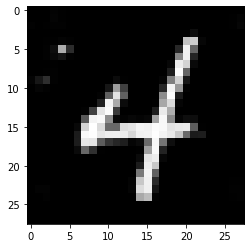

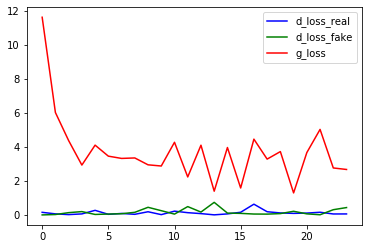

[24/200][0/938] Loss_D: 0.1240 Loss_G: 4.3576 D(x): 0.9591 D(G(z)): 0.0720 / 0.0271
[24/200][100/938] Loss_D: 0.4285 Loss_G: 3.9241 D(x): 0.7265 D(G(z)): 0.0336 / 0.0484
[24/200][200/938] Loss_D: 0.4380 Loss_G: 2.2791 D(x): 0.8938 D(G(z)): 0.2247 / 0.1755
[24/200][300/938] Loss_D: 0.2817 Loss_G: 3.3723 D(x): 0.9909 D(G(z)): 0.1910 / 0.0886
[24/200][400/938] Loss_D: 0.1309 Loss_G: 2.7582 D(x): 0.9313 D(G(z)): 0.0489 / 0.1170
[24/200][500/938] Loss_D: 0.1871 Loss_G: 4.0852 D(x): 0.9196 D(G(z)): 0.0837 / 0.0345
[24/200][600/938] Loss_D: 0.2456 Loss_G: 3.3181 D(x): 0.8995 D(G(z)): 0.0932 / 0.0826
[24/200][700/938] Loss_D: 0.5188 Loss_G: 6.2585 D(x): 0.7088 D(G(z)): 0.0057 / 0.0057
[24/200][800/938] Loss_D: 0.2060 Loss_G: 3.1411 D(x): 0.9695 D(G(z)): 0.1336 / 0.0915
[24/200][900/938] Loss_D: 0.0984 Loss_G: 4.9714 D(x): 0.9588 D(G(z)): 0.0505 / 0.0152


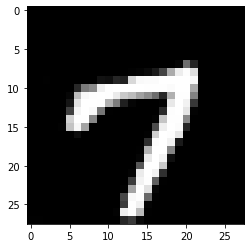

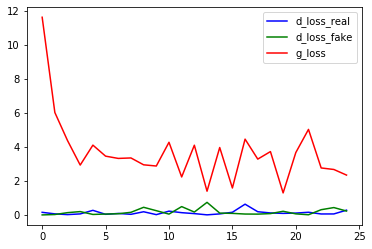

[25/200][0/938] Loss_D: 0.2614 Loss_G: 2.3264 D(x): 0.9483 D(G(z)): 0.1598 / 0.1624
[25/200][100/938] Loss_D: 0.1431 Loss_G: 2.8572 D(x): 0.9164 D(G(z)): 0.0426 / 0.1226
[25/200][200/938] Loss_D: 0.4856 Loss_G: 3.3881 D(x): 0.7151 D(G(z)): 0.0882 / 0.0653
[25/200][300/938] Loss_D: 0.6191 Loss_G: 2.8276 D(x): 0.6661 D(G(z)): 0.0792 / 0.1131
[25/200][400/938] Loss_D: 0.2387 Loss_G: 3.0592 D(x): 0.8438 D(G(z)): 0.0376 / 0.1074
[25/200][500/938] Loss_D: 0.1544 Loss_G: 4.2873 D(x): 0.9087 D(G(z)): 0.0474 / 0.0334
[25/200][600/938] Loss_D: 0.1627 Loss_G: 2.9312 D(x): 0.9832 D(G(z)): 0.1225 / 0.1001
[25/200][700/938] Loss_D: 0.1671 Loss_G: 3.9129 D(x): 0.9401 D(G(z)): 0.0800 / 0.0435
[25/200][800/938] Loss_D: 0.1824 Loss_G: 3.3243 D(x): 0.9433 D(G(z)): 0.1042 / 0.0774
[25/200][900/938] Loss_D: 0.4865 Loss_G: 2.3261 D(x): 0.9780 D(G(z)): 0.3127 / 0.1677


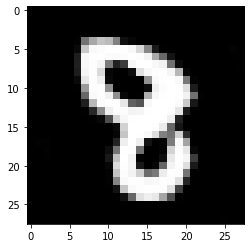

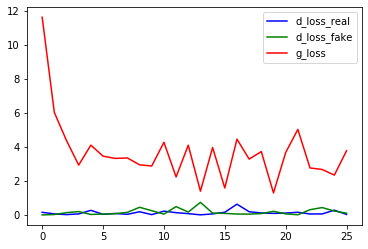

[26/200][0/938] Loss_D: 0.5551 Loss_G: 3.0453 D(x): 0.9435 D(G(z)): 0.3087 / 0.1019
[26/200][100/938] Loss_D: 0.2924 Loss_G: 2.9842 D(x): 0.9369 D(G(z)): 0.1759 / 0.1049
[26/200][200/938] Loss_D: 0.4192 Loss_G: 3.9086 D(x): 0.9480 D(G(z)): 0.2502 / 0.0468
[26/200][300/938] Loss_D: 0.4164 Loss_G: 3.9202 D(x): 0.7191 D(G(z)): 0.0452 / 0.0426
[26/200][400/938] Loss_D: 0.1968 Loss_G: 3.0297 D(x): 0.9167 D(G(z)): 0.0910 / 0.0981
[26/200][500/938] Loss_D: 0.3029 Loss_G: 3.6215 D(x): 0.8311 D(G(z)): 0.0650 / 0.0922
[26/200][600/938] Loss_D: 0.6298 Loss_G: 4.0582 D(x): 0.6670 D(G(z)): 0.0379 / 0.0686
[26/200][700/938] Loss_D: 0.2508 Loss_G: 2.5876 D(x): 0.8987 D(G(z)): 0.1099 / 0.1489
[26/200][800/938] Loss_D: 0.3144 Loss_G: 2.9753 D(x): 0.8422 D(G(z)): 0.0937 / 0.1357
[26/200][900/938] Loss_D: 0.1502 Loss_G: 4.3562 D(x): 0.8873 D(G(z)): 0.0192 / 0.0337


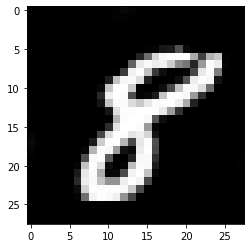

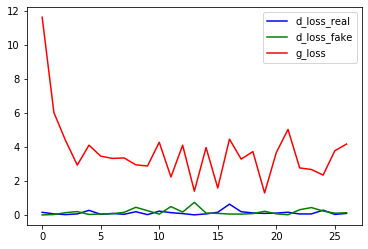

[27/200][0/938] Loss_D: 0.1971 Loss_G: 3.6744 D(x): 0.9045 D(G(z)): 0.0768 / 0.0485
[27/200][100/938] Loss_D: 0.1012 Loss_G: 4.7115 D(x): 0.9425 D(G(z)): 0.0367 / 0.0269
[27/200][200/938] Loss_D: 0.2271 Loss_G: 2.1404 D(x): 0.8936 D(G(z)): 0.0926 / 0.2063
[27/200][300/938] Loss_D: 0.3362 Loss_G: 2.7686 D(x): 0.9021 D(G(z)): 0.1737 / 0.1187
[27/200][400/938] Loss_D: 0.3169 Loss_G: 4.3489 D(x): 0.8093 D(G(z)): 0.0628 / 0.0296
[27/200][500/938] Loss_D: 0.2020 Loss_G: 2.2936 D(x): 0.9284 D(G(z)): 0.1058 / 0.1958
[27/200][600/938] Loss_D: 0.2063 Loss_G: 3.3126 D(x): 0.9245 D(G(z)): 0.0937 / 0.0803
[27/200][700/938] Loss_D: 0.5863 Loss_G: 4.6708 D(x): 0.6320 D(G(z)): 0.0347 / 0.0398
[27/200][800/938] Loss_D: 0.4335 Loss_G: 6.1859 D(x): 0.7102 D(G(z)): 0.0032 / 0.0059
[27/200][900/938] Loss_D: 0.0818 Loss_G: 4.6894 D(x): 0.9761 D(G(z)): 0.0533 / 0.0227


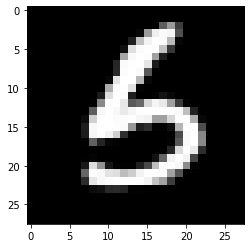

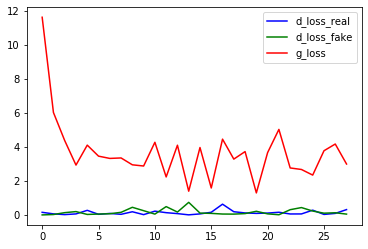

[28/200][0/938] Loss_D: 0.4176 Loss_G: 2.1601 D(x): 0.9504 D(G(z)): 0.2326 / 0.2110
[28/200][100/938] Loss_D: 0.2320 Loss_G: 3.2506 D(x): 0.8774 D(G(z)): 0.0725 / 0.0812
[28/200][200/938] Loss_D: 0.9588 Loss_G: 1.8542 D(x): 0.9870 D(G(z)): 0.4911 / 0.2671
[28/200][300/938] Loss_D: 0.5662 Loss_G: 3.6399 D(x): 0.9573 D(G(z)): 0.3110 / 0.0747
[28/200][400/938] Loss_D: 0.2925 Loss_G: 2.8792 D(x): 0.9795 D(G(z)): 0.2031 / 0.1148
[28/200][500/938] Loss_D: 0.3534 Loss_G: 2.7261 D(x): 0.8209 D(G(z)): 0.1033 / 0.1508
[28/200][600/938] Loss_D: 0.8021 Loss_G: 1.7448 D(x): 0.9953 D(G(z)): 0.4421 / 0.2810
[28/200][700/938] Loss_D: 0.4605 Loss_G: 3.3148 D(x): 0.8804 D(G(z)): 0.2232 / 0.0850
[28/200][800/938] Loss_D: 0.5504 Loss_G: 2.4115 D(x): 0.8771 D(G(z)): 0.2513 / 0.1706
[28/200][900/938] Loss_D: 0.1484 Loss_G: 4.5567 D(x): 0.9818 D(G(z)): 0.1038 / 0.0340


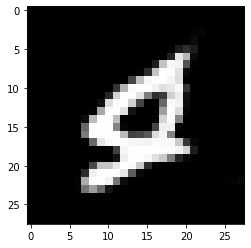

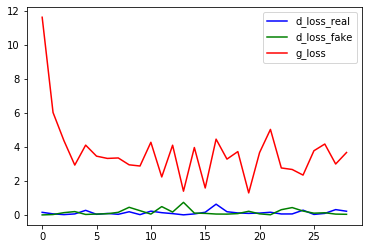

[29/200][0/938] Loss_D: 0.2751 Loss_G: 2.6433 D(x): 0.8833 D(G(z)): 0.0983 / 0.1390
[29/200][100/938] Loss_D: 0.4721 Loss_G: 3.7167 D(x): 0.6991 D(G(z)): 0.0239 / 0.0545
[29/200][200/938] Loss_D: 0.2389 Loss_G: 4.5762 D(x): 0.8344 D(G(z)): 0.0369 / 0.0380
[29/200][300/938] Loss_D: 0.1719 Loss_G: 2.6543 D(x): 0.9899 D(G(z)): 0.1254 / 0.1370
[29/200][400/938] Loss_D: 0.7254 Loss_G: 2.0777 D(x): 0.9800 D(G(z)): 0.3980 / 0.2478
[29/200][500/938] Loss_D: 0.2702 Loss_G: 3.6180 D(x): 0.8908 D(G(z)): 0.1157 / 0.0661
[29/200][600/938] Loss_D: 0.6989 Loss_G: 2.5779 D(x): 0.9217 D(G(z)): 0.3838 / 0.1253
[29/200][700/938] Loss_D: 1.3654 Loss_G: 2.9741 D(x): 0.3590 D(G(z)): 0.0367 / 0.1127
[29/200][800/938] Loss_D: 0.2018 Loss_G: 2.5707 D(x): 0.9706 D(G(z)): 0.1437 / 0.1390
[29/200][900/938] Loss_D: 0.3638 Loss_G: 3.1892 D(x): 0.7520 D(G(z)): 0.0398 / 0.0908


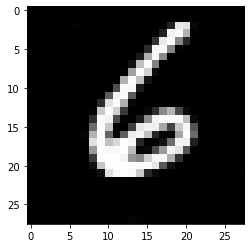

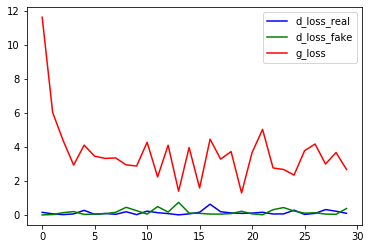

[30/200][0/938] Loss_D: 0.2123 Loss_G: 3.4848 D(x): 0.9510 D(G(z)): 0.1298 / 0.0594
[30/200][100/938] Loss_D: 0.1742 Loss_G: 3.3387 D(x): 0.9450 D(G(z)): 0.0901 / 0.0806
[30/200][200/938] Loss_D: 0.6208 Loss_G: 1.9847 D(x): 0.9779 D(G(z)): 0.3781 / 0.2154
[30/200][300/938] Loss_D: 0.2439 Loss_G: 3.1542 D(x): 0.8356 D(G(z)): 0.0450 / 0.0946
[30/200][400/938] Loss_D: 0.3541 Loss_G: 2.6632 D(x): 0.8691 D(G(z)): 0.1580 / 0.1235
[30/200][500/938] Loss_D: 0.2947 Loss_G: 2.2321 D(x): 0.9911 D(G(z)): 0.2067 / 0.1935
[30/200][600/938] Loss_D: 0.2876 Loss_G: 3.2422 D(x): 0.8948 D(G(z)): 0.1245 / 0.0841
[30/200][700/938] Loss_D: 0.2870 Loss_G: 5.0221 D(x): 0.8020 D(G(z)): 0.0102 / 0.0240
[30/200][800/938] Loss_D: 0.5312 Loss_G: 3.1196 D(x): 0.8722 D(G(z)): 0.2556 / 0.0923
[30/200][900/938] Loss_D: 0.1760 Loss_G: 4.1227 D(x): 0.9334 D(G(z)): 0.0697 / 0.0447


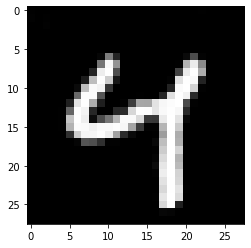

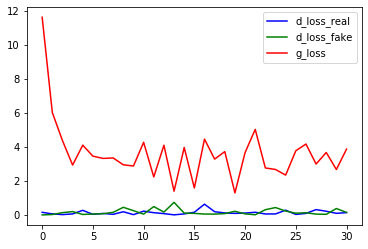

[31/200][0/938] Loss_D: 0.1914 Loss_G: 4.9464 D(x): 0.8618 D(G(z)): 0.0319 / 0.0177
[31/200][100/938] Loss_D: 0.1703 Loss_G: 3.9887 D(x): 0.9776 D(G(z)): 0.1066 / 0.0539
[31/200][200/938] Loss_D: 0.3281 Loss_G: 4.6097 D(x): 0.7797 D(G(z)): 0.0164 / 0.0250
[31/200][300/938] Loss_D: 0.3129 Loss_G: 3.4080 D(x): 0.8709 D(G(z)): 0.1215 / 0.0855
[31/200][400/938] Loss_D: 0.2856 Loss_G: 2.1876 D(x): 0.9229 D(G(z)): 0.1603 / 0.1868
[31/200][500/938] Loss_D: 0.1619 Loss_G: 3.9375 D(x): 0.9174 D(G(z)): 0.0465 / 0.0472
[31/200][600/938] Loss_D: 0.2996 Loss_G: 4.1413 D(x): 0.8328 D(G(z)): 0.0651 / 0.0562
[31/200][700/938] Loss_D: 0.3735 Loss_G: 2.0698 D(x): 0.9910 D(G(z)): 0.2504 / 0.2355
[31/200][800/938] Loss_D: 0.3467 Loss_G: 2.8106 D(x): 0.9739 D(G(z)): 0.2310 / 0.1303
[31/200][900/938] Loss_D: 0.4154 Loss_G: 2.2457 D(x): 0.9567 D(G(z)): 0.2603 / 0.1854


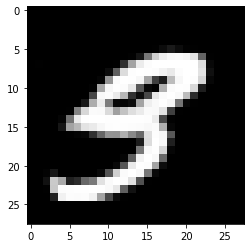

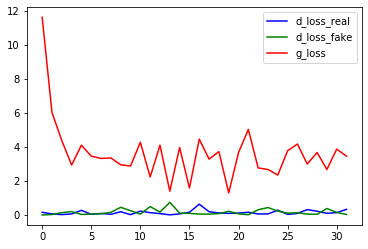

[32/200][0/938] Loss_D: 0.6907 Loss_G: 1.7416 D(x): 0.9964 D(G(z)): 0.3794 / 0.3201
[32/200][100/938] Loss_D: 0.3959 Loss_G: 3.0787 D(x): 0.9492 D(G(z)): 0.2391 / 0.1019
[32/200][200/938] Loss_D: 0.2230 Loss_G: 3.3757 D(x): 0.8784 D(G(z)): 0.0727 / 0.0697
[32/200][300/938] Loss_D: 0.3339 Loss_G: 2.6451 D(x): 0.8084 D(G(z)): 0.0605 / 0.1389
[32/200][400/938] Loss_D: 0.1821 Loss_G: 4.1866 D(x): 0.9193 D(G(z)): 0.0751 / 0.0392
[32/200][500/938] Loss_D: 0.2787 Loss_G: 3.3244 D(x): 0.8537 D(G(z)): 0.0770 / 0.0842
[32/200][600/938] Loss_D: 0.2807 Loss_G: 3.9860 D(x): 0.8166 D(G(z)): 0.0538 / 0.0340
[32/200][700/938] Loss_D: 0.3098 Loss_G: 3.4423 D(x): 0.8078 D(G(z)): 0.0373 / 0.0803
[32/200][800/938] Loss_D: 0.3878 Loss_G: 3.1471 D(x): 0.8942 D(G(z)): 0.1857 / 0.0969
[32/200][900/938] Loss_D: 0.2554 Loss_G: 3.1061 D(x): 0.8781 D(G(z)): 0.0774 / 0.0943


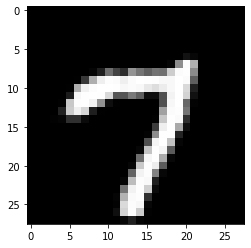

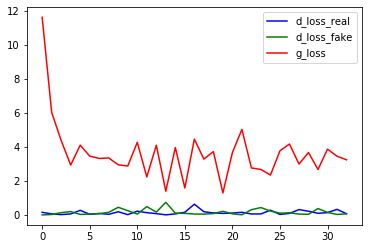

[33/200][0/938] Loss_D: 0.2940 Loss_G: 2.9284 D(x): 0.9106 D(G(z)): 0.1482 / 0.1106
[33/200][100/938] Loss_D: 0.1224 Loss_G: 3.6149 D(x): 0.9496 D(G(z)): 0.0600 / 0.0605
[33/200][200/938] Loss_D: 0.2195 Loss_G: 3.6651 D(x): 0.9333 D(G(z)): 0.0999 / 0.0737
[33/200][300/938] Loss_D: 0.1620 Loss_G: 3.6048 D(x): 0.9772 D(G(z)): 0.1112 / 0.0708
[33/200][400/938] Loss_D: 0.3275 Loss_G: 3.0256 D(x): 0.8679 D(G(z)): 0.1284 / 0.1081
[33/200][500/938] Loss_D: 0.4397 Loss_G: 2.5410 D(x): 0.9565 D(G(z)): 0.2398 / 0.1586
[33/200][600/938] Loss_D: 0.1063 Loss_G: 3.2410 D(x): 0.9538 D(G(z)): 0.0540 / 0.0742
[33/200][700/938] Loss_D: 0.1023 Loss_G: 3.7973 D(x): 0.9453 D(G(z)): 0.0388 / 0.0476
[33/200][800/938] Loss_D: 0.4126 Loss_G: 5.9853 D(x): 0.7365 D(G(z)): 0.0107 / 0.0080
[33/200][900/938] Loss_D: 0.2319 Loss_G: 5.2950 D(x): 0.8261 D(G(z)): 0.0152 / 0.0134


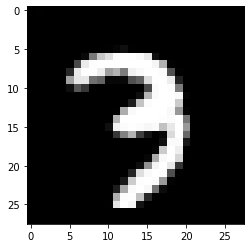

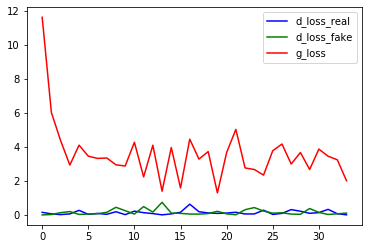

[34/200][0/938] Loss_D: 1.1035 Loss_G: 1.4549 D(x): 0.9953 D(G(z)): 0.5108 / 0.3879
[34/200][100/938] Loss_D: 0.3267 Loss_G: 2.2884 D(x): 0.9103 D(G(z)): 0.1725 / 0.1714
[34/200][200/938] Loss_D: 0.1015 Loss_G: 2.9876 D(x): 0.9677 D(G(z)): 0.0604 / 0.1100
[34/200][300/938] Loss_D: 0.2352 Loss_G: 3.0781 D(x): 0.9752 D(G(z)): 0.1592 / 0.1315
[34/200][400/938] Loss_D: 0.1724 Loss_G: 3.0249 D(x): 0.9080 D(G(z)): 0.0602 / 0.1304
[34/200][500/938] Loss_D: 0.2705 Loss_G: 2.1223 D(x): 0.9810 D(G(z)): 0.1889 / 0.2032
[34/200][600/938] Loss_D: 0.2349 Loss_G: 2.6487 D(x): 0.9748 D(G(z)): 0.1504 / 0.1359
[34/200][700/938] Loss_D: 0.3710 Loss_G: 4.2508 D(x): 0.7709 D(G(z)): 0.0511 / 0.0346
[34/200][800/938] Loss_D: 0.4200 Loss_G: 2.2432 D(x): 0.9012 D(G(z)): 0.2174 / 0.2111
[34/200][900/938] Loss_D: 1.0930 Loss_G: 3.0175 D(x): 0.9631 D(G(z)): 0.5174 / 0.1087


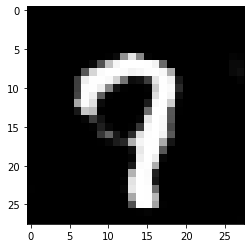

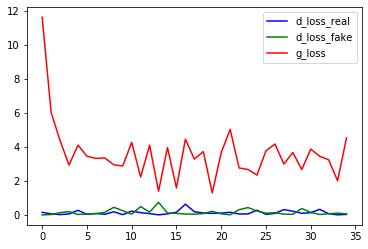

[35/200][0/938] Loss_D: 0.4101 Loss_G: 3.0774 D(x): 0.8800 D(G(z)): 0.1908 / 0.1080
[35/200][100/938] Loss_D: 0.1193 Loss_G: 4.5789 D(x): 0.9434 D(G(z)): 0.0493 / 0.0352
[35/200][200/938] Loss_D: 0.1935 Loss_G: 2.7965 D(x): 0.9658 D(G(z)): 0.1335 / 0.1326
[35/200][300/938] Loss_D: 0.0668 Loss_G: 5.3866 D(x): 0.9584 D(G(z)): 0.0162 / 0.0145
[35/200][400/938] Loss_D: 0.1463 Loss_G: 2.9261 D(x): 0.9039 D(G(z)): 0.0347 / 0.1190
[35/200][500/938] Loss_D: 0.1250 Loss_G: 3.8110 D(x): 0.9572 D(G(z)): 0.0679 / 0.0650
[35/200][600/938] Loss_D: 0.4236 Loss_G: 1.9880 D(x): 0.9065 D(G(z)): 0.2333 / 0.2352
[35/200][700/938] Loss_D: 0.1174 Loss_G: 5.5342 D(x): 0.9227 D(G(z)): 0.0292 / 0.0118
[35/200][800/938] Loss_D: 0.2457 Loss_G: 3.8649 D(x): 0.8739 D(G(z)): 0.0861 / 0.0694
[35/200][900/938] Loss_D: 0.2198 Loss_G: 3.5228 D(x): 0.9404 D(G(z)): 0.1126 / 0.0761


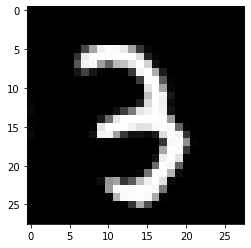

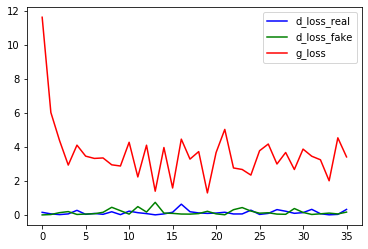

[36/200][0/938] Loss_D: 0.2579 Loss_G: 4.1056 D(x): 0.8359 D(G(z)): 0.0445 / 0.0401
[36/200][100/938] Loss_D: 0.2561 Loss_G: 3.2616 D(x): 0.8865 D(G(z)): 0.1075 / 0.0772
[36/200][200/938] Loss_D: 0.1795 Loss_G: 3.0398 D(x): 0.9513 D(G(z)): 0.1033 / 0.1192
[36/200][300/938] Loss_D: 0.0854 Loss_G: 3.4611 D(x): 0.9715 D(G(z)): 0.0477 / 0.0803
[36/200][400/938] Loss_D: 0.0680 Loss_G: 4.3115 D(x): 0.9766 D(G(z)): 0.0415 / 0.0341
[36/200][500/938] Loss_D: 0.2782 Loss_G: 3.5985 D(x): 0.8490 D(G(z)): 0.0752 / 0.0616
[36/200][600/938] Loss_D: 0.4138 Loss_G: 2.3544 D(x): 0.8603 D(G(z)): 0.1819 / 0.1702
[36/200][700/938] Loss_D: 0.1733 Loss_G: 3.8330 D(x): 0.9185 D(G(z)): 0.0597 / 0.0667
[36/200][800/938] Loss_D: 0.3798 Loss_G: 2.1137 D(x): 0.7831 D(G(z)): 0.0860 / 0.1983
[36/200][900/938] Loss_D: 0.2724 Loss_G: 2.8635 D(x): 0.8944 D(G(z)): 0.1209 / 0.1261


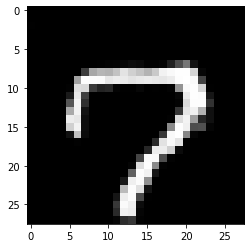

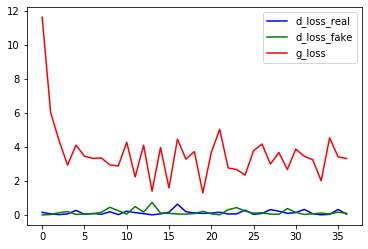

[37/200][0/938] Loss_D: 0.4433 Loss_G: 2.6728 D(x): 0.9019 D(G(z)): 0.2243 / 0.1747
[37/200][100/938] Loss_D: 0.4555 Loss_G: 1.7989 D(x): 0.9893 D(G(z)): 0.2967 / 0.2521
[37/200][200/938] Loss_D: 0.3412 Loss_G: 4.1353 D(x): 0.7644 D(G(z)): 0.0202 / 0.0369
[37/200][300/938] Loss_D: 0.6220 Loss_G: 1.8997 D(x): 0.7111 D(G(z)): 0.1415 / 0.2583
[37/200][400/938] Loss_D: 0.1243 Loss_G: 4.9147 D(x): 0.9336 D(G(z)): 0.0477 / 0.0232
[37/200][500/938] Loss_D: 0.3959 Loss_G: 3.4516 D(x): 0.9459 D(G(z)): 0.1937 / 0.0860
[37/200][600/938] Loss_D: 0.2400 Loss_G: 3.2437 D(x): 0.9348 D(G(z)): 0.1208 / 0.0824
[37/200][700/938] Loss_D: 0.2810 Loss_G: 4.3208 D(x): 0.8095 D(G(z)): 0.0419 / 0.0355
[37/200][800/938] Loss_D: 0.3959 Loss_G: 4.3388 D(x): 0.7460 D(G(z)): 0.0416 / 0.0434
[37/200][900/938] Loss_D: 0.2155 Loss_G: 4.8424 D(x): 0.8371 D(G(z)): 0.0213 / 0.0183


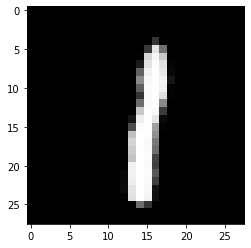

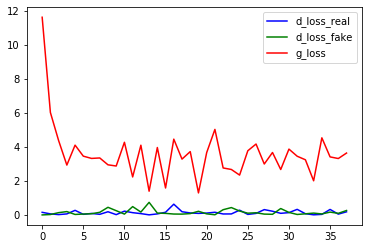

[38/200][0/938] Loss_D: 0.2603 Loss_G: 4.3578 D(x): 0.9405 D(G(z)): 0.1356 / 0.0437
[38/200][100/938] Loss_D: 0.2010 Loss_G: 3.0587 D(x): 0.9654 D(G(z)): 0.1265 / 0.1076
[38/200][200/938] Loss_D: 0.1356 Loss_G: 4.9492 D(x): 0.9154 D(G(z)): 0.0321 / 0.0222
[38/200][300/938] Loss_D: 1.1061 Loss_G: 1.5333 D(x): 0.9905 D(G(z)): 0.5602 / 0.3277
[38/200][400/938] Loss_D: 0.4237 Loss_G: 4.0061 D(x): 0.7217 D(G(z)): 0.0242 / 0.0405
[38/200][500/938] Loss_D: 0.1379 Loss_G: 3.5165 D(x): 0.9311 D(G(z)): 0.0545 / 0.0680
[38/200][600/938] Loss_D: 0.1969 Loss_G: 4.4698 D(x): 0.8839 D(G(z)): 0.0452 / 0.0449
[38/200][700/938] Loss_D: 0.1155 Loss_G: 4.1069 D(x): 0.9685 D(G(z)): 0.0725 / 0.0354
[38/200][800/938] Loss_D: 0.1343 Loss_G: 3.5692 D(x): 0.9328 D(G(z)): 0.0537 / 0.0561
[38/200][900/938] Loss_D: 0.3892 Loss_G: 2.7467 D(x): 0.9838 D(G(z)): 0.2332 / 0.1539


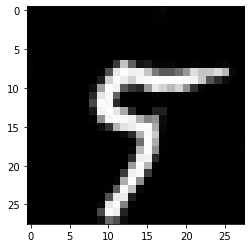

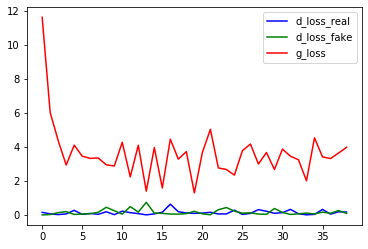

[39/200][0/938] Loss_D: 0.2069 Loss_G: 4.0447 D(x): 0.9374 D(G(z)): 0.1011 / 0.0566
[39/200][100/938] Loss_D: 0.7296 Loss_G: 2.1821 D(x): 0.9756 D(G(z)): 0.3986 / 0.2218
[39/200][200/938] Loss_D: 0.2157 Loss_G: 4.0320 D(x): 0.9799 D(G(z)): 0.1543 / 0.0464
[39/200][300/938] Loss_D: 0.0896 Loss_G: 5.3331 D(x): 0.9408 D(G(z)): 0.0204 / 0.0135
[39/200][400/938] Loss_D: 0.2233 Loss_G: 3.4811 D(x): 0.8939 D(G(z)): 0.0800 / 0.0846
[39/200][500/938] Loss_D: 0.1119 Loss_G: 5.0221 D(x): 0.9164 D(G(z)): 0.0181 / 0.0266
[39/200][600/938] Loss_D: 0.0917 Loss_G: 4.9063 D(x): 0.9572 D(G(z)): 0.0401 / 0.0259
[39/200][700/938] Loss_D: 0.2820 Loss_G: 4.8920 D(x): 0.8287 D(G(z)): 0.0355 / 0.0263
[39/200][800/938] Loss_D: 0.3850 Loss_G: 2.8880 D(x): 0.9124 D(G(z)): 0.2187 / 0.1167
[39/200][900/938] Loss_D: 0.1319 Loss_G: 4.0532 D(x): 0.9189 D(G(z)): 0.0391 / 0.0424


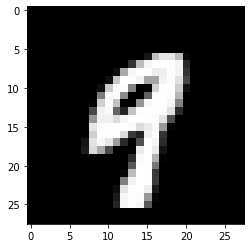

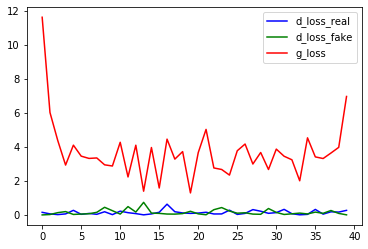

[40/200][0/938] Loss_D: 0.1959 Loss_G: 4.0492 D(x): 0.8752 D(G(z)): 0.0382 / 0.0657
[40/200][100/938] Loss_D: 0.1385 Loss_G: 4.6019 D(x): 0.9129 D(G(z)): 0.0335 / 0.0356
[40/200][200/938] Loss_D: 0.3258 Loss_G: 2.0539 D(x): 0.9076 D(G(z)): 0.1656 / 0.2397
[40/200][300/938] Loss_D: 0.1988 Loss_G: 3.2404 D(x): 0.9522 D(G(z)): 0.1115 / 0.1086
[40/200][400/938] Loss_D: 0.1787 Loss_G: 3.0320 D(x): 0.9922 D(G(z)): 0.1315 / 0.1048
[40/200][500/938] Loss_D: 0.2737 Loss_G: 2.0629 D(x): 0.9425 D(G(z)): 0.1439 / 0.2364
[40/200][600/938] Loss_D: 0.1317 Loss_G: 4.5087 D(x): 0.9537 D(G(z)): 0.0692 / 0.0281
[40/200][700/938] Loss_D: 0.2147 Loss_G: 3.5548 D(x): 0.9070 D(G(z)): 0.0852 / 0.0745
[40/200][800/938] Loss_D: 0.2986 Loss_G: 4.4272 D(x): 0.8628 D(G(z)): 0.0934 / 0.0400
[40/200][900/938] Loss_D: 0.2936 Loss_G: 4.3374 D(x): 0.9495 D(G(z)): 0.1719 / 0.0413


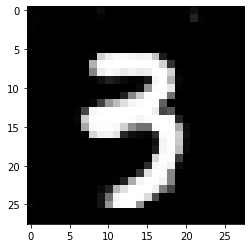

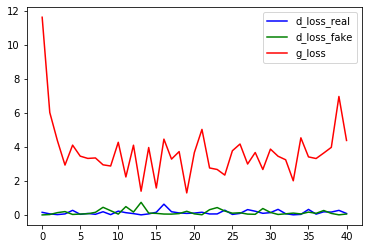

[41/200][0/938] Loss_D: 0.0870 Loss_G: 4.8301 D(x): 0.9431 D(G(z)): 0.0244 / 0.0232
[41/200][100/938] Loss_D: 0.7990 Loss_G: 4.5503 D(x): 0.5447 D(G(z)): 0.0172 / 0.0296
[41/200][200/938] Loss_D: 0.2538 Loss_G: 3.4389 D(x): 0.8523 D(G(z)): 0.0643 / 0.0772
[41/200][300/938] Loss_D: 0.2732 Loss_G: 3.1078 D(x): 0.8829 D(G(z)): 0.1127 / 0.0953
[41/200][400/938] Loss_D: 0.4051 Loss_G: 7.1717 D(x): 0.7261 D(G(z)): 0.0048 / 0.0044
[41/200][500/938] Loss_D: 0.1174 Loss_G: 5.3228 D(x): 0.9267 D(G(z)): 0.0298 / 0.0173
[41/200][600/938] Loss_D: 0.2790 Loss_G: 3.1278 D(x): 0.8794 D(G(z)): 0.1039 / 0.1193
[41/200][700/938] Loss_D: 0.6885 Loss_G: 5.0758 D(x): 0.6036 D(G(z)): 0.0081 / 0.0203
[41/200][800/938] Loss_D: 0.3900 Loss_G: 2.8165 D(x): 0.9768 D(G(z)): 0.2358 / 0.1480
[41/200][900/938] Loss_D: 0.5082 Loss_G: 1.9844 D(x): 0.9938 D(G(z)): 0.3299 / 0.2242


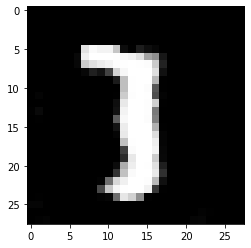

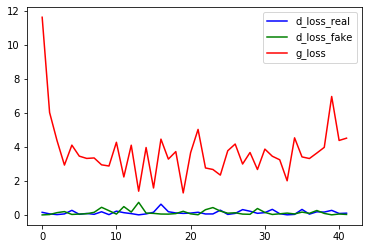

[42/200][0/938] Loss_D: 0.1613 Loss_G: 3.6337 D(x): 0.9481 D(G(z)): 0.0844 / 0.0759
[42/200][100/938] Loss_D: 0.5001 Loss_G: 5.9104 D(x): 0.6846 D(G(z)): 0.0092 / 0.0131
[42/200][200/938] Loss_D: 0.2920 Loss_G: 3.9486 D(x): 0.8386 D(G(z)): 0.0801 / 0.0448
[42/200][300/938] Loss_D: 0.1244 Loss_G: 3.4416 D(x): 0.9848 D(G(z)): 0.0810 / 0.0942
[42/200][400/938] Loss_D: 0.1714 Loss_G: 4.5106 D(x): 0.9476 D(G(z)): 0.0870 / 0.0391
[42/200][500/938] Loss_D: 0.2948 Loss_G: 4.7825 D(x): 0.8113 D(G(z)): 0.0220 / 0.0293
[42/200][600/938] Loss_D: 0.3606 Loss_G: 4.4190 D(x): 0.7662 D(G(z)): 0.0242 / 0.0559
[42/200][700/938] Loss_D: 0.1706 Loss_G: 3.8951 D(x): 0.9009 D(G(z)): 0.0250 / 0.0604
[42/200][800/938] Loss_D: 0.1311 Loss_G: 4.8895 D(x): 0.9584 D(G(z)): 0.0684 / 0.0318
[42/200][900/938] Loss_D: 0.5100 Loss_G: 2.9075 D(x): 0.8438 D(G(z)): 0.2064 / 0.1365


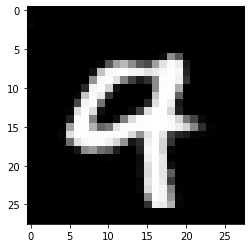

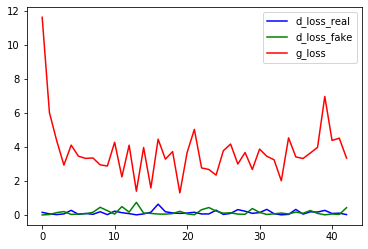

[43/200][0/938] Loss_D: 0.2634 Loss_G: 4.2327 D(x): 0.9580 D(G(z)): 0.1673 / 0.0370
[43/200][100/938] Loss_D: 0.2086 Loss_G: 3.1105 D(x): 0.9291 D(G(z)): 0.1095 / 0.1023
[43/200][200/938] Loss_D: 0.1089 Loss_G: 4.0602 D(x): 0.9629 D(G(z)): 0.0615 / 0.0422
[43/200][300/938] Loss_D: 1.3339 Loss_G: 4.3833 D(x): 0.4068 D(G(z)): 0.0205 / 0.0353
[43/200][400/938] Loss_D: 0.0663 Loss_G: 5.0463 D(x): 0.9537 D(G(z)): 0.0160 / 0.0154
[43/200][500/938] Loss_D: 0.2009 Loss_G: 3.0475 D(x): 0.9596 D(G(z)): 0.1209 / 0.1162
[43/200][600/938] Loss_D: 0.3867 Loss_G: 2.4384 D(x): 0.8286 D(G(z)): 0.1372 / 0.1696
[43/200][700/938] Loss_D: 0.2446 Loss_G: 5.7065 D(x): 0.8323 D(G(z)): 0.0258 / 0.0109
[43/200][800/938] Loss_D: 0.4969 Loss_G: 2.9177 D(x): 0.7894 D(G(z)): 0.1479 / 0.1384
[43/200][900/938] Loss_D: 0.1003 Loss_G: 4.0067 D(x): 0.9533 D(G(z)): 0.0368 / 0.0413


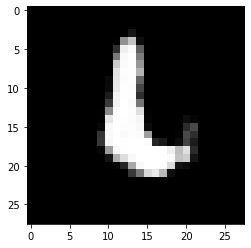

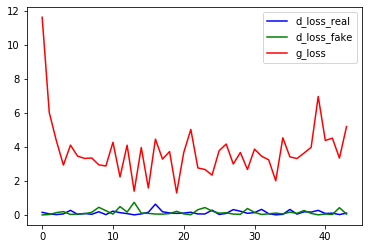

[44/200][0/938] Loss_D: 0.1806 Loss_G: 4.7787 D(x): 0.8893 D(G(z)): 0.0401 / 0.0324
[44/200][100/938] Loss_D: 0.2565 Loss_G: 4.8163 D(x): 0.8349 D(G(z)): 0.0270 / 0.0208
[44/200][200/938] Loss_D: 0.2459 Loss_G: 3.2853 D(x): 0.9742 D(G(z)): 0.1702 / 0.0732
[44/200][300/938] Loss_D: 1.0738 Loss_G: 5.8128 D(x): 0.4446 D(G(z)): 0.0075 / 0.0105
[44/200][400/938] Loss_D: 0.2392 Loss_G: 3.3502 D(x): 0.9225 D(G(z)): 0.1304 / 0.0654
[44/200][500/938] Loss_D: 0.1235 Loss_G: 4.7146 D(x): 0.9589 D(G(z)): 0.0438 / 0.0373
[44/200][600/938] Loss_D: 0.1277 Loss_G: 3.6007 D(x): 0.9680 D(G(z)): 0.0789 / 0.0615
[44/200][700/938] Loss_D: 0.4115 Loss_G: 6.4818 D(x): 0.7192 D(G(z)): 0.0041 / 0.0080
[44/200][800/938] Loss_D: 0.1702 Loss_G: 3.6593 D(x): 0.9311 D(G(z)): 0.0816 / 0.0685
[44/200][900/938] Loss_D: 0.2328 Loss_G: 4.5466 D(x): 0.9304 D(G(z)): 0.1202 / 0.0321


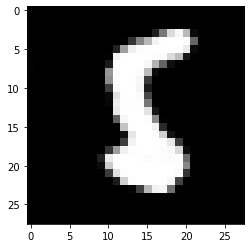

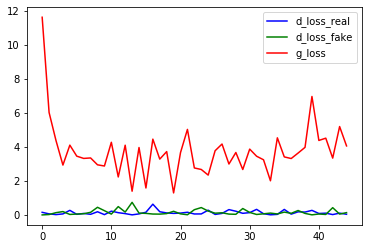

[45/200][0/938] Loss_D: 0.1004 Loss_G: 5.8561 D(x): 0.9297 D(G(z)): 0.0190 / 0.0093
[45/200][100/938] Loss_D: 0.7265 Loss_G: 2.0552 D(x): 0.9876 D(G(z)): 0.3888 / 0.2316
[45/200][200/938] Loss_D: 0.1227 Loss_G: 4.3829 D(x): 0.9201 D(G(z)): 0.0329 / 0.0308
[45/200][300/938] Loss_D: 0.3082 Loss_G: 2.8501 D(x): 0.9832 D(G(z)): 0.2217 / 0.0968
[45/200][400/938] Loss_D: 0.1115 Loss_G: 3.5310 D(x): 0.9842 D(G(z)): 0.0838 / 0.0569
[45/200][500/938] Loss_D: 0.3122 Loss_G: 2.7937 D(x): 0.9964 D(G(z)): 0.2182 / 0.1541
[45/200][600/938] Loss_D: 0.1206 Loss_G: 6.2939 D(x): 0.9154 D(G(z)): 0.0186 / 0.0058
[45/200][700/938] Loss_D: 0.0717 Loss_G: 6.2676 D(x): 0.9442 D(G(z)): 0.0078 / 0.0061
[45/200][800/938] Loss_D: 0.1437 Loss_G: 4.2619 D(x): 0.9578 D(G(z)): 0.0798 / 0.0410
[45/200][900/938] Loss_D: 0.1404 Loss_G: 5.7799 D(x): 0.9098 D(G(z)): 0.0360 / 0.0174


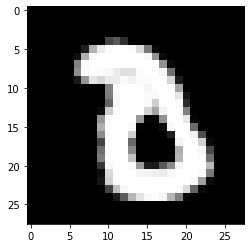

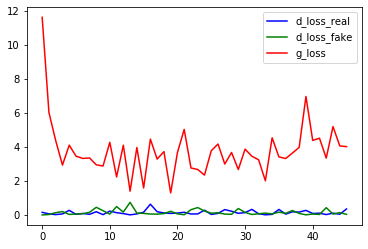

[46/200][0/938] Loss_D: 0.2597 Loss_G: 2.5818 D(x): 0.9360 D(G(z)): 0.1284 / 0.1499
[46/200][100/938] Loss_D: 0.1292 Loss_G: 4.3806 D(x): 0.9625 D(G(z)): 0.0719 / 0.0389
[46/200][200/938] Loss_D: 0.0635 Loss_G: 3.8536 D(x): 0.9813 D(G(z)): 0.0409 / 0.0518
[46/200][300/938] Loss_D: 0.2670 Loss_G: 4.7405 D(x): 0.8512 D(G(z)): 0.0675 / 0.0323
[46/200][400/938] Loss_D: 0.1223 Loss_G: 3.7194 D(x): 0.9470 D(G(z)): 0.0572 / 0.0598
[46/200][500/938] Loss_D: 0.0822 Loss_G: 4.9354 D(x): 0.9537 D(G(z)): 0.0275 / 0.0198
[46/200][600/938] Loss_D: 0.8817 Loss_G: 4.3514 D(x): 0.5229 D(G(z)): 0.0087 / 0.0459
[46/200][700/938] Loss_D: 0.1328 Loss_G: 4.0736 D(x): 0.9373 D(G(z)): 0.0569 / 0.0418
[46/200][800/938] Loss_D: 0.2093 Loss_G: 3.6726 D(x): 0.9934 D(G(z)): 0.1514 / 0.0647
[46/200][900/938] Loss_D: 0.0306 Loss_G: 7.0116 D(x): 0.9794 D(G(z)): 0.0087 / 0.0047


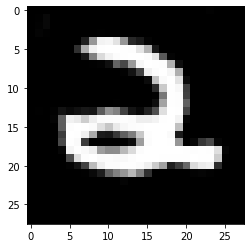

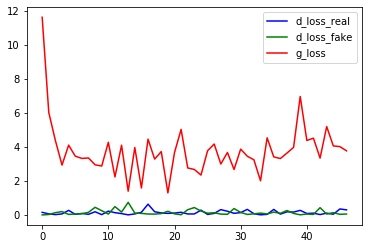

[47/200][0/938] Loss_D: 0.2987 Loss_G: 2.9545 D(x): 0.8163 D(G(z)): 0.0635 / 0.1051
[47/200][100/938] Loss_D: 0.2151 Loss_G: 2.5986 D(x): 0.9682 D(G(z)): 0.1297 / 0.1590
[47/200][200/938] Loss_D: 0.3038 Loss_G: 5.5457 D(x): 0.8122 D(G(z)): 0.0152 / 0.0129
[47/200][300/938] Loss_D: 0.1127 Loss_G: 5.5978 D(x): 0.9263 D(G(z)): 0.0301 / 0.0119
[47/200][400/938] Loss_D: 0.1627 Loss_G: 3.8245 D(x): 0.9552 D(G(z)): 0.0858 / 0.0529
[47/200][500/938] Loss_D: 0.2985 Loss_G: 2.5039 D(x): 0.9764 D(G(z)): 0.1863 / 0.1537
[47/200][600/938] Loss_D: 0.2249 Loss_G: 4.1885 D(x): 0.8774 D(G(z)): 0.0627 / 0.0513
[47/200][700/938] Loss_D: 0.1358 Loss_G: 2.2191 D(x): 0.9916 D(G(z)): 0.1016 / 0.1968
[47/200][800/938] Loss_D: 0.3151 Loss_G: 5.0779 D(x): 0.7792 D(G(z)): 0.0109 / 0.0162
[47/200][900/938] Loss_D: 0.2227 Loss_G: 5.5092 D(x): 0.9348 D(G(z)): 0.0950 / 0.0288


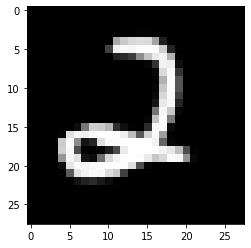

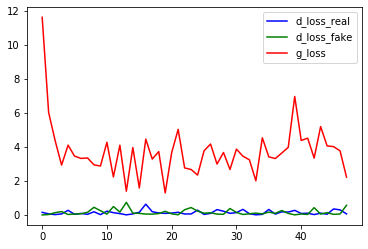

[48/200][0/938] Loss_D: 0.5518 Loss_G: 2.6919 D(x): 0.9729 D(G(z)): 0.3245 / 0.1296
[48/200][100/938] Loss_D: 0.1498 Loss_G: 3.2607 D(x): 0.9510 D(G(z)): 0.0831 / 0.0816
[48/200][200/938] Loss_D: 0.1545 Loss_G: 3.9872 D(x): 0.9662 D(G(z)): 0.0963 / 0.0485
[48/200][300/938] Loss_D: 0.3683 Loss_G: 3.4398 D(x): 0.9494 D(G(z)): 0.2009 / 0.0858
[48/200][400/938] Loss_D: 0.1141 Loss_G: 4.0922 D(x): 0.9375 D(G(z)): 0.0316 / 0.0435
[48/200][500/938] Loss_D: 0.1814 Loss_G: 3.0233 D(x): 0.8960 D(G(z)): 0.0497 / 0.1152
[48/200][600/938] Loss_D: 0.1785 Loss_G: 4.1422 D(x): 0.9248 D(G(z)): 0.0703 / 0.0443
[48/200][700/938] Loss_D: 0.2407 Loss_G: 3.2782 D(x): 0.9363 D(G(z)): 0.1414 / 0.0853
[48/200][800/938] Loss_D: 0.2741 Loss_G: 3.1976 D(x): 0.9628 D(G(z)): 0.1588 / 0.1022
[48/200][900/938] Loss_D: 0.1864 Loss_G: 6.3370 D(x): 0.8602 D(G(z)): 0.0107 / 0.0072


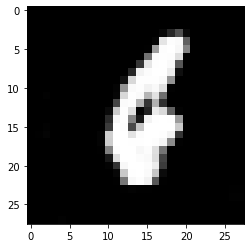

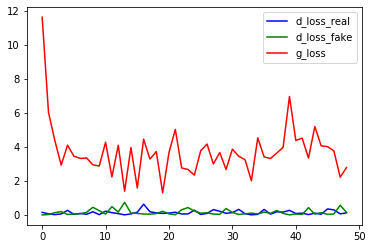

[49/200][0/938] Loss_D: 0.0455 Loss_G: 4.4198 D(x): 0.9892 D(G(z)): 0.0323 / 0.0405
[49/200][100/938] Loss_D: 0.1092 Loss_G: 4.8443 D(x): 0.9261 D(G(z)): 0.0251 / 0.0285
[49/200][200/938] Loss_D: 0.4583 Loss_G: 3.5634 D(x): 0.7207 D(G(z)): 0.0355 / 0.0643
[49/200][300/938] Loss_D: 0.3162 Loss_G: 3.6520 D(x): 0.8143 D(G(z)): 0.0649 / 0.0742
[49/200][400/938] Loss_D: 0.2636 Loss_G: 4.2888 D(x): 0.8541 D(G(z)): 0.0708 / 0.0455
[49/200][500/938] Loss_D: 0.2340 Loss_G: 2.9546 D(x): 0.9677 D(G(z)): 0.1552 / 0.1151
[49/200][600/938] Loss_D: 0.1045 Loss_G: 5.2120 D(x): 0.9278 D(G(z)): 0.0252 / 0.0183
[49/200][700/938] Loss_D: 0.4149 Loss_G: 3.8001 D(x): 0.7405 D(G(z)): 0.0179 / 0.0689
[49/200][800/938] Loss_D: 0.2737 Loss_G: 3.3152 D(x): 0.9735 D(G(z)): 0.1882 / 0.0776
[49/200][900/938] Loss_D: 0.0766 Loss_G: 3.6392 D(x): 0.9941 D(G(z)): 0.0600 / 0.0656


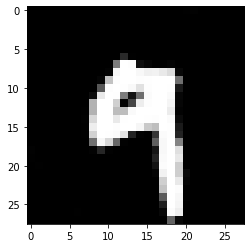

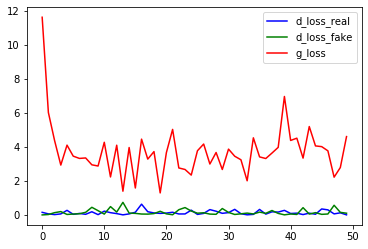

[50/200][0/938] Loss_D: 0.0463 Loss_G: 5.6547 D(x): 0.9878 D(G(z)): 0.0318 / 0.0129
[50/200][100/938] Loss_D: 0.1059 Loss_G: 3.4136 D(x): 0.9731 D(G(z)): 0.0707 / 0.0622
[50/200][200/938] Loss_D: 0.1290 Loss_G: 3.7030 D(x): 0.9382 D(G(z)): 0.0537 / 0.0786
[50/200][300/938] Loss_D: 0.7852 Loss_G: 2.3468 D(x): 0.9696 D(G(z)): 0.4385 / 0.1684
[50/200][400/938] Loss_D: 0.1417 Loss_G: 3.3091 D(x): 0.9925 D(G(z)): 0.1028 / 0.1065
[50/200][500/938] Loss_D: 0.0752 Loss_G: 4.8295 D(x): 0.9648 D(G(z)): 0.0329 / 0.0303
[50/200][600/938] Loss_D: 0.1496 Loss_G: 5.9903 D(x): 0.8979 D(G(z)): 0.0277 / 0.0107
[50/200][700/938] Loss_D: 0.7928 Loss_G: 4.6184 D(x): 0.5582 D(G(z)): 0.0037 / 0.0249
[50/200][800/938] Loss_D: 0.2308 Loss_G: 3.0601 D(x): 0.9616 D(G(z)): 0.1459 / 0.1087
[50/200][900/938] Loss_D: 0.1100 Loss_G: 3.9471 D(x): 0.9327 D(G(z)): 0.0338 / 0.0540


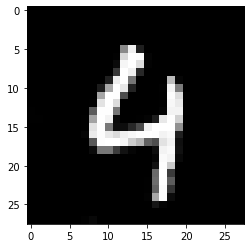

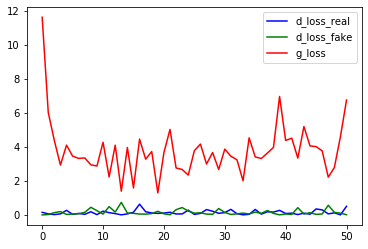

[51/200][0/938] Loss_D: 0.2740 Loss_G: 6.4446 D(x): 0.7992 D(G(z)): 0.0078 / 0.0134
[51/200][100/938] Loss_D: 0.2197 Loss_G: 3.7302 D(x): 0.9919 D(G(z)): 0.1648 / 0.0655
[51/200][200/938] Loss_D: 0.2249 Loss_G: 3.4050 D(x): 0.9351 D(G(z)): 0.1188 / 0.0781
[51/200][300/938] Loss_D: 0.9792 Loss_G: 2.9719 D(x): 0.9869 D(G(z)): 0.5094 / 0.1054
[51/200][400/938] Loss_D: 0.3933 Loss_G: 2.4932 D(x): 0.9134 D(G(z)): 0.2096 / 0.1689
[51/200][500/938] Loss_D: 0.1150 Loss_G: 4.6231 D(x): 0.9321 D(G(z)): 0.0336 / 0.0373
[51/200][600/938] Loss_D: 0.1348 Loss_G: 4.7249 D(x): 0.9193 D(G(z)): 0.0317 / 0.0218
[51/200][700/938] Loss_D: 1.3707 Loss_G: 2.7438 D(x): 0.9961 D(G(z)): 0.5735 / 0.1483
[51/200][800/938] Loss_D: 0.2121 Loss_G: 5.4761 D(x): 0.8504 D(G(z)): 0.0182 / 0.0213
[51/200][900/938] Loss_D: 0.0491 Loss_G: 6.2495 D(x): 0.9602 D(G(z)): 0.0070 / 0.0062


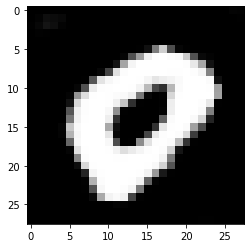

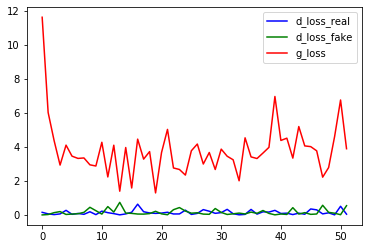

[52/200][0/938] Loss_D: 0.1860 Loss_G: 6.5630 D(x): 0.8538 D(G(z)): 0.0082 / 0.0037
[52/200][100/938] Loss_D: 0.3928 Loss_G: 3.2572 D(x): 0.7422 D(G(z)): 0.0195 / 0.1084
[52/200][200/938] Loss_D: 0.2476 Loss_G: 4.3506 D(x): 0.8430 D(G(z)): 0.0454 / 0.0452
[52/200][300/938] Loss_D: 0.1754 Loss_G: 4.4644 D(x): 0.9182 D(G(z)): 0.0705 / 0.0306
[52/200][400/938] Loss_D: 0.5031 Loss_G: 1.7117 D(x): 0.9564 D(G(z)): 0.2714 / 0.2932
[52/200][500/938] Loss_D: 0.0799 Loss_G: 5.0029 D(x): 0.9345 D(G(z)): 0.0058 / 0.0262
[52/200][600/938] Loss_D: 0.1725 Loss_G: 3.7687 D(x): 0.9873 D(G(z)): 0.1291 / 0.0608
[52/200][700/938] Loss_D: 0.4183 Loss_G: 3.5643 D(x): 0.7898 D(G(z)): 0.0885 / 0.0948
[52/200][800/938] Loss_D: 0.3333 Loss_G: 2.2028 D(x): 0.9701 D(G(z)): 0.2115 / 0.2179
[52/200][900/938] Loss_D: 0.0767 Loss_G: 3.5526 D(x): 0.9672 D(G(z)): 0.0387 / 0.0726


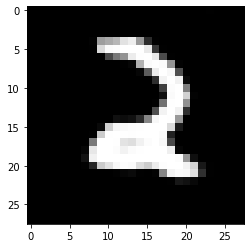

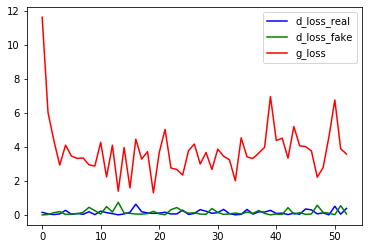

[53/200][0/938] Loss_D: 0.1012 Loss_G: 2.8395 D(x): 0.9868 D(G(z)): 0.0787 / 0.1042
[53/200][100/938] Loss_D: 0.1292 Loss_G: 5.1463 D(x): 0.9137 D(G(z)): 0.0267 / 0.0204
[53/200][200/938] Loss_D: 0.0813 Loss_G: 3.9625 D(x): 0.9862 D(G(z)): 0.0580 / 0.0629
[53/200][300/938] Loss_D: 0.2989 Loss_G: 3.3096 D(x): 0.8335 D(G(z)): 0.0680 / 0.0918
[53/200][400/938] Loss_D: 0.2482 Loss_G: 2.5498 D(x): 0.9944 D(G(z)): 0.1782 / 0.1495
[53/200][500/938] Loss_D: 0.0987 Loss_G: 5.3692 D(x): 0.9280 D(G(z)): 0.0152 / 0.0125
[53/200][600/938] Loss_D: 0.2963 Loss_G: 4.1634 D(x): 0.8594 D(G(z)): 0.1012 / 0.0562
[53/200][700/938] Loss_D: 0.2170 Loss_G: 3.7180 D(x): 0.9923 D(G(z)): 0.1282 / 0.0796
[53/200][800/938] Loss_D: 0.2144 Loss_G: 5.5509 D(x): 0.8560 D(G(z)): 0.0260 / 0.0197
[53/200][900/938] Loss_D: 0.7470 Loss_G: 5.5731 D(x): 0.5758 D(G(z)): 0.0086 / 0.0213


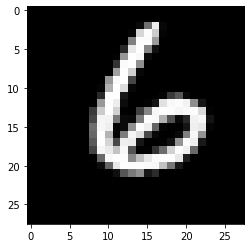

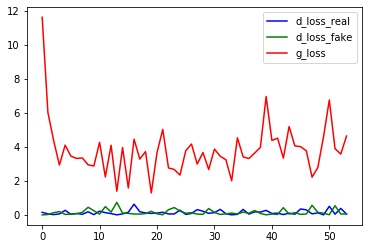

[54/200][0/938] Loss_D: 0.1793 Loss_G: 4.2165 D(x): 0.9522 D(G(z)): 0.1002 / 0.0452
[54/200][100/938] Loss_D: 0.3990 Loss_G: 6.2341 D(x): 0.7183 D(G(z)): 0.0104 / 0.0112
[54/200][200/938] Loss_D: 0.0649 Loss_G: 5.0858 D(x): 0.9831 D(G(z)): 0.0386 / 0.0261
[54/200][300/938] Loss_D: 0.0661 Loss_G: 4.0021 D(x): 0.9944 D(G(z)): 0.0536 / 0.0671
[54/200][400/938] Loss_D: 0.1319 Loss_G: 3.1490 D(x): 0.9303 D(G(z)): 0.0483 / 0.0941
[54/200][500/938] Loss_D: 0.2100 Loss_G: 3.5987 D(x): 0.9372 D(G(z)): 0.1060 / 0.0817
[54/200][600/938] Loss_D: 0.2495 Loss_G: 3.1660 D(x): 0.9808 D(G(z)): 0.1551 / 0.1052
[54/200][700/938] Loss_D: 0.0812 Loss_G: 5.5294 D(x): 0.9689 D(G(z)): 0.0343 / 0.0188
[54/200][800/938] Loss_D: 0.0902 Loss_G: 4.6404 D(x): 0.9552 D(G(z)): 0.0333 / 0.0364
[54/200][900/938] Loss_D: 0.1946 Loss_G: 4.6090 D(x): 0.8569 D(G(z)): 0.0185 / 0.0386


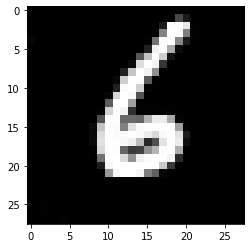

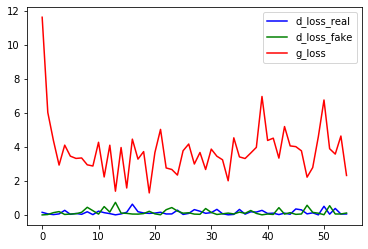

[55/200][0/938] Loss_D: 0.2495 Loss_G: 2.2016 D(x): 0.9941 D(G(z)): 0.1844 / 0.2067
[55/200][100/938] Loss_D: 0.1296 Loss_G: 4.0717 D(x): 0.9395 D(G(z)): 0.0548 / 0.0471
[55/200][200/938] Loss_D: 0.3308 Loss_G: 2.7021 D(x): 0.9252 D(G(z)): 0.1786 / 0.1555
[55/200][300/938] Loss_D: 1.3461 Loss_G: 6.5552 D(x): 0.3942 D(G(z)): 0.0009 / 0.0077
[55/200][400/938] Loss_D: 0.2363 Loss_G: 2.6138 D(x): 0.9952 D(G(z)): 0.1833 / 0.1422
[55/200][500/938] Loss_D: 0.1932 Loss_G: 3.6221 D(x): 0.9065 D(G(z)): 0.0652 / 0.0664
[55/200][600/938] Loss_D: 0.1647 Loss_G: 4.1602 D(x): 0.9596 D(G(z)): 0.1023 / 0.0421
[55/200][700/938] Loss_D: 0.6972 Loss_G: 3.2620 D(x): 0.9894 D(G(z)): 0.3726 / 0.0941
[55/200][800/938] Loss_D: 0.0808 Loss_G: 4.4272 D(x): 0.9799 D(G(z)): 0.0530 / 0.0341
[55/200][900/938] Loss_D: 0.1585 Loss_G: 5.0114 D(x): 0.8861 D(G(z)): 0.0191 / 0.0276


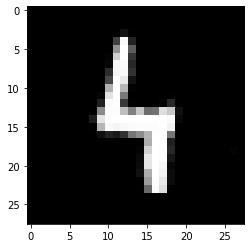

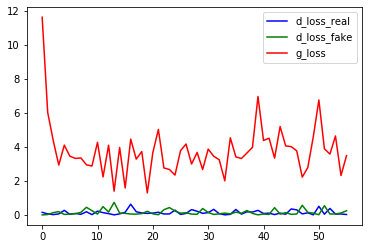

[56/200][0/938] Loss_D: 0.1727 Loss_G: 4.5005 D(x): 0.9876 D(G(z)): 0.1104 / 0.0455
[56/200][100/938] Loss_D: 0.1018 Loss_G: 4.3323 D(x): 0.9590 D(G(z)): 0.0431 / 0.0472
[56/200][200/938] Loss_D: 0.3241 Loss_G: 3.8627 D(x): 0.8122 D(G(z)): 0.0508 / 0.0636
[56/200][300/938] Loss_D: 0.0968 Loss_G: 3.7684 D(x): 0.9807 D(G(z)): 0.0674 / 0.0554
[56/200][400/938] Loss_D: 0.1179 Loss_G: 4.9008 D(x): 0.9911 D(G(z)): 0.0859 / 0.0287
[56/200][500/938] Loss_D: 0.3081 Loss_G: 3.5175 D(x): 0.8196 D(G(z)): 0.0584 / 0.0640
[56/200][600/938] Loss_D: 0.1472 Loss_G: 4.3337 D(x): 0.9356 D(G(z)): 0.0584 / 0.0460
[56/200][700/938] Loss_D: 0.1705 Loss_G: 3.8918 D(x): 0.9439 D(G(z)): 0.0859 / 0.0700
[56/200][800/938] Loss_D: 0.2286 Loss_G: 3.1274 D(x): 0.9351 D(G(z)): 0.1149 / 0.1290
[56/200][900/938] Loss_D: 0.2464 Loss_G: 3.3426 D(x): 0.8752 D(G(z)): 0.0699 / 0.1272


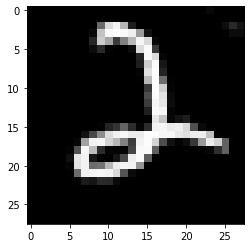

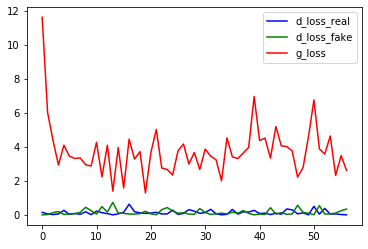

[57/200][0/938] Loss_D: 0.6898 Loss_G: 2.7311 D(x): 0.9926 D(G(z)): 0.3617 / 0.1684
[57/200][100/938] Loss_D: 0.3038 Loss_G: 4.4077 D(x): 0.8182 D(G(z)): 0.0434 / 0.0537
[57/200][200/938] Loss_D: 0.1635 Loss_G: 3.9962 D(x): 0.9211 D(G(z)): 0.0593 / 0.0664
[57/200][300/938] Loss_D: 0.1495 Loss_G: 3.5867 D(x): 0.9723 D(G(z)): 0.0979 / 0.0799
[57/200][400/938] Loss_D: 0.1402 Loss_G: 4.6642 D(x): 0.8968 D(G(z)): 0.0103 / 0.0353
[57/200][500/938] Loss_D: 0.1384 Loss_G: 5.1692 D(x): 0.9121 D(G(z)): 0.0329 / 0.0242
[57/200][600/938] Loss_D: 0.0879 Loss_G: 4.4624 D(x): 0.9449 D(G(z)): 0.0239 / 0.0445
[57/200][700/938] Loss_D: 0.3098 Loss_G: 4.2437 D(x): 0.8154 D(G(z)): 0.0480 / 0.0509
[57/200][800/938] Loss_D: 0.2481 Loss_G: 3.1539 D(x): 0.9893 D(G(z)): 0.1688 / 0.0977
[57/200][900/938] Loss_D: 0.2072 Loss_G: 3.1523 D(x): 0.9747 D(G(z)): 0.1468 / 0.0952


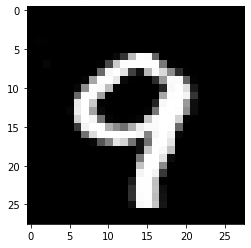

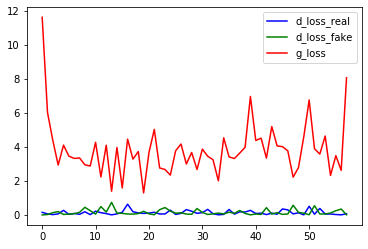

[58/200][0/938] Loss_D: 0.1486 Loss_G: 6.9575 D(x): 0.8852 D(G(z)): 0.0069 / 0.0034
[58/200][100/938] Loss_D: 0.5559 Loss_G: 2.1259 D(x): 0.9778 D(G(z)): 0.3239 / 0.2196
[58/200][200/938] Loss_D: 0.1497 Loss_G: 4.0633 D(x): 0.9639 D(G(z)): 0.0896 / 0.0594
[58/200][300/938] Loss_D: 0.1209 Loss_G: 5.4666 D(x): 0.9216 D(G(z)): 0.0230 / 0.0173
[58/200][400/938] Loss_D: 0.1898 Loss_G: 5.2964 D(x): 0.8965 D(G(z)): 0.0422 / 0.0294
[58/200][500/938] Loss_D: 0.5620 Loss_G: 2.9292 D(x): 0.9892 D(G(z)): 0.3193 / 0.1204
[58/200][600/938] Loss_D: 0.5688 Loss_G: 2.9652 D(x): 0.9844 D(G(z)): 0.3502 / 0.1051
[58/200][700/938] Loss_D: 0.1055 Loss_G: 3.5445 D(x): 0.9567 D(G(z)): 0.0514 / 0.0630
[58/200][800/938] Loss_D: 0.2423 Loss_G: 3.4784 D(x): 0.9725 D(G(z)): 0.1579 / 0.0812
[58/200][900/938] Loss_D: 0.1301 Loss_G: 5.1270 D(x): 0.9087 D(G(z)): 0.0248 / 0.0231


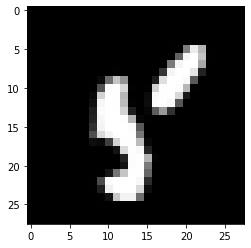

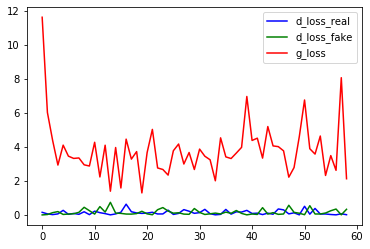

[59/200][0/938] Loss_D: 0.3129 Loss_G: 2.8513 D(x): 0.9888 D(G(z)): 0.2099 / 0.1164
[59/200][100/938] Loss_D: 0.2654 Loss_G: 3.6778 D(x): 0.8623 D(G(z)): 0.0806 / 0.0716
[59/200][200/938] Loss_D: 0.3583 Loss_G: 2.8362 D(x): 0.9810 D(G(z)): 0.2258 / 0.1436
[59/200][300/938] Loss_D: 0.3655 Loss_G: 2.6692 D(x): 0.9551 D(G(z)): 0.2078 / 0.1688
[59/200][400/938] Loss_D: 0.0921 Loss_G: 4.8078 D(x): 0.9915 D(G(z)): 0.0699 / 0.0417
[59/200][500/938] Loss_D: 0.1368 Loss_G: 3.4212 D(x): 0.9881 D(G(z)): 0.1018 / 0.0932
[59/200][600/938] Loss_D: 0.2492 Loss_G: 4.5872 D(x): 0.9831 D(G(z)): 0.1496 / 0.0470
[59/200][700/938] Loss_D: 0.1329 Loss_G: 5.0762 D(x): 0.8971 D(G(z)): 0.0094 / 0.0184
[59/200][800/938] Loss_D: 0.2155 Loss_G: 4.6962 D(x): 0.8940 D(G(z)): 0.0670 / 0.0370
[59/200][900/938] Loss_D: 0.3295 Loss_G: 3.2554 D(x): 0.9968 D(G(z)): 0.2215 / 0.1133


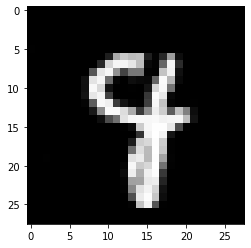

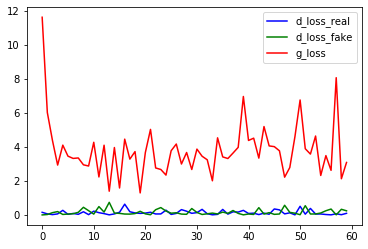

[60/200][0/938] Loss_D: 0.4197 Loss_G: 2.9925 D(x): 0.9184 D(G(z)): 0.2283 / 0.1116
[60/200][100/938] Loss_D: 0.2425 Loss_G: 3.6710 D(x): 0.9188 D(G(z)): 0.1236 / 0.0635
[60/200][200/938] Loss_D: 0.2463 Loss_G: 4.3870 D(x): 0.9794 D(G(z)): 0.1494 / 0.0507
[60/200][300/938] Loss_D: 0.0703 Loss_G: 7.0209 D(x): 0.9514 D(G(z)): 0.0098 / 0.0022
[60/200][400/938] Loss_D: 0.1403 Loss_G: 6.2346 D(x): 0.9262 D(G(z)): 0.0286 / 0.0206
[60/200][500/938] Loss_D: 0.3180 Loss_G: 5.1620 D(x): 0.7832 D(G(z)): 0.0267 / 0.0279
[60/200][600/938] Loss_D: 0.1645 Loss_G: 3.1674 D(x): 0.8774 D(G(z)): 0.0179 / 0.1055
[60/200][700/938] Loss_D: 0.2308 Loss_G: 5.3019 D(x): 0.8487 D(G(z)): 0.0140 / 0.0228
[60/200][800/938] Loss_D: 0.3748 Loss_G: 4.1301 D(x): 0.9926 D(G(z)): 0.2335 / 0.0565
[60/200][900/938] Loss_D: 0.1658 Loss_G: 3.5840 D(x): 0.9452 D(G(z)): 0.0875 / 0.0721


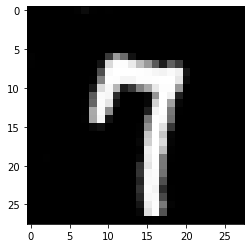

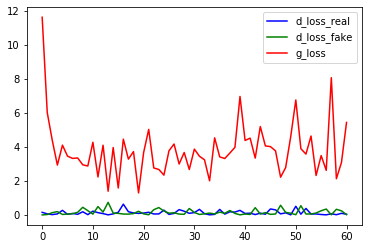

[61/200][0/938] Loss_D: 0.2924 Loss_G: 4.0563 D(x): 0.8018 D(G(z)): 0.0311 / 0.0413
[61/200][100/938] Loss_D: 0.0642 Loss_G: 4.4801 D(x): 0.9926 D(G(z)): 0.0517 / 0.0318
[61/200][200/938] Loss_D: 0.0706 Loss_G: 4.4804 D(x): 0.9748 D(G(z)): 0.0381 / 0.0387
[61/200][300/938] Loss_D: 0.0684 Loss_G: 3.9124 D(x): 0.9939 D(G(z)): 0.0553 / 0.0655
[61/200][400/938] Loss_D: 0.1185 Loss_G: 4.5387 D(x): 0.9332 D(G(z)): 0.0391 / 0.0265
[61/200][500/938] Loss_D: 0.4849 Loss_G: 5.4930 D(x): 0.7052 D(G(z)): 0.0290 / 0.0176
[61/200][600/938] Loss_D: 0.1868 Loss_G: 4.0692 D(x): 0.8697 D(G(z)): 0.0218 / 0.0566
[61/200][700/938] Loss_D: 0.0887 Loss_G: 4.9181 D(x): 0.9752 D(G(z)): 0.0516 / 0.0271
[61/200][800/938] Loss_D: 0.6528 Loss_G: 3.4427 D(x): 0.9720 D(G(z)): 0.3543 / 0.0917
[61/200][900/938] Loss_D: 0.1881 Loss_G: 5.3959 D(x): 0.8744 D(G(z)): 0.0268 / 0.0240


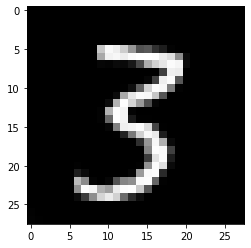

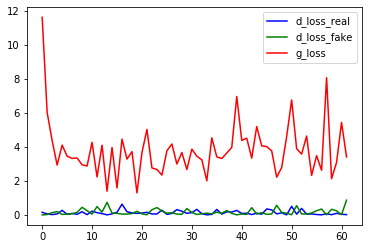

[62/200][0/938] Loss_D: 0.2090 Loss_G: 6.5152 D(x): 0.8863 D(G(z)): 0.0391 / 0.0084
[62/200][100/938] Loss_D: 0.1790 Loss_G: 4.0601 D(x): 0.9097 D(G(z)): 0.0623 / 0.0475
[62/200][200/938] Loss_D: 0.3899 Loss_G: 3.9126 D(x): 0.7621 D(G(z)): 0.0512 / 0.0593
[62/200][300/938] Loss_D: 0.1332 Loss_G: 4.4384 D(x): 0.9932 D(G(z)): 0.0857 / 0.0448
[62/200][400/938] Loss_D: 0.1394 Loss_G: 4.1768 D(x): 0.9125 D(G(z)): 0.0294 / 0.0488
[62/200][500/938] Loss_D: 0.1200 Loss_G: 4.6492 D(x): 0.9404 D(G(z)): 0.0491 / 0.0310
[62/200][600/938] Loss_D: 0.6302 Loss_G: 2.1076 D(x): 0.9458 D(G(z)): 0.3323 / 0.2293
[62/200][700/938] Loss_D: 0.1033 Loss_G: 4.1388 D(x): 0.9447 D(G(z)): 0.0362 / 0.0469
[62/200][800/938] Loss_D: 0.1005 Loss_G: 4.8749 D(x): 0.9701 D(G(z)): 0.0560 / 0.0333
[62/200][900/938] Loss_D: 0.2156 Loss_G: 4.5216 D(x): 0.8661 D(G(z)): 0.0464 / 0.0376


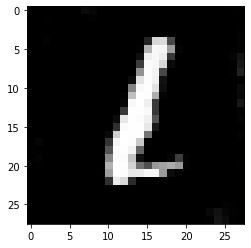

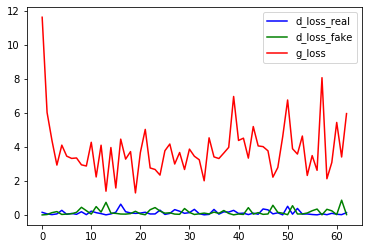

[63/200][0/938] Loss_D: 0.0886 Loss_G: 7.6294 D(x): 0.9266 D(G(z)): 0.0020 / 0.0016
[63/200][100/938] Loss_D: 0.1017 Loss_G: 4.6008 D(x): 0.9298 D(G(z)): 0.0222 / 0.0375
[63/200][200/938] Loss_D: 0.0872 Loss_G: 5.9606 D(x): 0.9308 D(G(z)): 0.0095 / 0.0117
[63/200][300/938] Loss_D: 0.0727 Loss_G: 4.9636 D(x): 0.9593 D(G(z)): 0.0262 / 0.0337
[63/200][400/938] Loss_D: 0.5267 Loss_G: 3.0828 D(x): 0.8820 D(G(z)): 0.2116 / 0.1427
[63/200][500/938] Loss_D: 0.1602 Loss_G: 4.2609 D(x): 0.9577 D(G(z)): 0.0917 / 0.0464
[63/200][600/938] Loss_D: 0.5733 Loss_G: 2.6235 D(x): 0.9752 D(G(z)): 0.3016 / 0.1803
[63/200][700/938] Loss_D: 0.0636 Loss_G: 4.9907 D(x): 0.9618 D(G(z)): 0.0216 / 0.0253
[63/200][800/938] Loss_D: 0.1669 Loss_G: 5.1582 D(x): 0.8691 D(G(z)): 0.0147 / 0.0198
[63/200][900/938] Loss_D: 0.1322 Loss_G: 4.0449 D(x): 0.9912 D(G(z)): 0.0920 / 0.0572


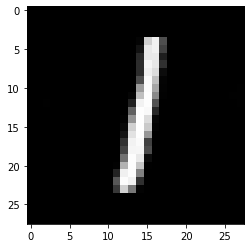

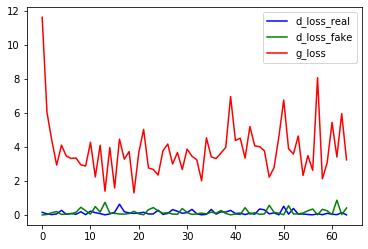

[64/200][0/938] Loss_D: 0.1966 Loss_G: 4.4031 D(x): 0.9728 D(G(z)): 0.1370 / 0.0299
[64/200][100/938] Loss_D: 0.1654 Loss_G: 4.6963 D(x): 0.9042 D(G(z)): 0.0459 / 0.0312
[64/200][200/938] Loss_D: 0.0850 Loss_G: 5.1789 D(x): 0.9391 D(G(z)): 0.0127 / 0.0211
[64/200][300/938] Loss_D: 0.1171 Loss_G: 4.9589 D(x): 0.9208 D(G(z)): 0.0111 / 0.0181
[64/200][400/938] Loss_D: 0.2046 Loss_G: 2.3806 D(x): 0.9980 D(G(z)): 0.1601 / 0.1738
[64/200][500/938] Loss_D: 0.0613 Loss_G: 4.8187 D(x): 0.9762 D(G(z)): 0.0330 / 0.0247
[64/200][600/938] Loss_D: 0.1176 Loss_G: 3.6737 D(x): 0.9489 D(G(z)): 0.0573 / 0.0591
[64/200][700/938] Loss_D: 0.1678 Loss_G: 4.0421 D(x): 0.9933 D(G(z)): 0.1250 / 0.0476
[64/200][800/938] Loss_D: 0.0988 Loss_G: 5.2819 D(x): 0.9524 D(G(z)): 0.0406 / 0.0182
[64/200][900/938] Loss_D: 0.2371 Loss_G: 2.7600 D(x): 0.9772 D(G(z)): 0.1669 / 0.1137


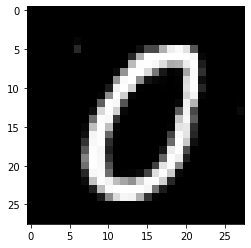

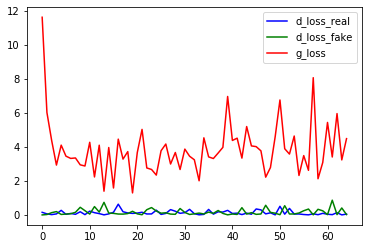

[65/200][0/938] Loss_D: 0.1879 Loss_G: 3.5732 D(x): 0.9829 D(G(z)): 0.1165 / 0.1138
[65/200][100/938] Loss_D: 0.2592 Loss_G: 3.2608 D(x): 0.9987 D(G(z)): 0.1788 / 0.1141
[65/200][200/938] Loss_D: 0.2062 Loss_G: 4.5189 D(x): 0.8599 D(G(z)): 0.0268 / 0.0294
[65/200][300/938] Loss_D: 0.1071 Loss_G: 4.0569 D(x): 0.9645 D(G(z)): 0.0580 / 0.0540
[65/200][400/938] Loss_D: 0.2362 Loss_G: 2.5399 D(x): 0.9669 D(G(z)): 0.1513 / 0.1949
[65/200][500/938] Loss_D: 0.1024 Loss_G: 3.8411 D(x): 0.9955 D(G(z)): 0.0828 / 0.0561
[65/200][600/938] Loss_D: 0.2121 Loss_G: 6.4279 D(x): 0.8523 D(G(z)): 0.0216 / 0.0130
[65/200][700/938] Loss_D: 0.1361 Loss_G: 4.3221 D(x): 0.9729 D(G(z)): 0.0811 / 0.0522
[65/200][800/938] Loss_D: 0.8700 Loss_G: 8.1313 D(x): 0.5435 D(G(z)): 0.0004 / 0.0009
[65/200][900/938] Loss_D: 0.2488 Loss_G: 3.5103 D(x): 0.9897 D(G(z)): 0.1700 / 0.0962


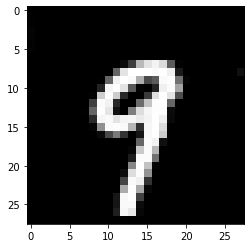

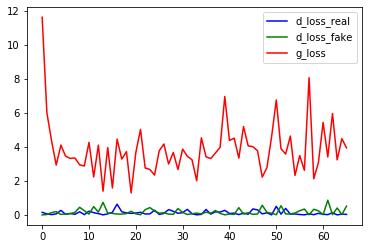

[66/200][0/938] Loss_D: 0.1001 Loss_G: 6.0703 D(x): 0.9433 D(G(z)): 0.0327 / 0.0098
[66/200][100/938] Loss_D: 0.3358 Loss_G: 4.4181 D(x): 0.7754 D(G(z)): 0.0258 / 0.0336
[66/200][200/938] Loss_D: 0.0817 Loss_G: 5.8050 D(x): 0.9465 D(G(z)): 0.0198 / 0.0096
[66/200][300/938] Loss_D: 0.1035 Loss_G: 4.3195 D(x): 0.9568 D(G(z)): 0.0512 / 0.0365
[66/200][400/938] Loss_D: 0.1547 Loss_G: 5.7022 D(x): 0.8928 D(G(z)): 0.0166 / 0.0096
[66/200][500/938] Loss_D: 0.2896 Loss_G: 3.6168 D(x): 0.9788 D(G(z)): 0.1840 / 0.0950
[66/200][600/938] Loss_D: 0.3131 Loss_G: 3.4539 D(x): 0.9842 D(G(z)): 0.1938 / 0.0909
[66/200][700/938] Loss_D: 0.2164 Loss_G: 4.5841 D(x): 0.8997 D(G(z)): 0.0795 / 0.0291
[66/200][800/938] Loss_D: 0.2505 Loss_G: 4.5902 D(x): 0.8435 D(G(z)): 0.0222 / 0.0376
[66/200][900/938] Loss_D: 0.0458 Loss_G: 6.1656 D(x): 0.9734 D(G(z)): 0.0171 / 0.0075


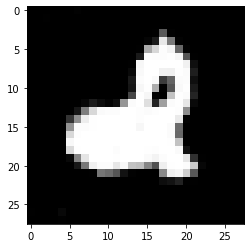

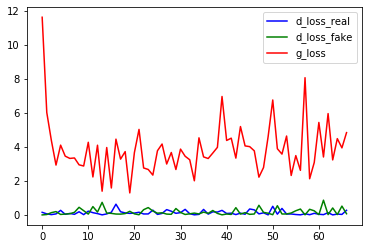

[67/200][0/938] Loss_D: 0.0677 Loss_G: 5.3417 D(x): 0.9725 D(G(z)): 0.0351 / 0.0217
[67/200][100/938] Loss_D: 0.3235 Loss_G: 4.5099 D(x): 0.7978 D(G(z)): 0.0277 / 0.0419
[67/200][200/938] Loss_D: 0.0915 Loss_G: 4.3815 D(x): 0.9624 D(G(z)): 0.0416 / 0.0372
[67/200][300/938] Loss_D: 0.1702 Loss_G: 4.5765 D(x): 0.8971 D(G(z)): 0.0277 / 0.0346
[67/200][400/938] Loss_D: 0.2714 Loss_G: 3.0620 D(x): 0.8612 D(G(z)): 0.0868 / 0.1131
[67/200][500/938] Loss_D: 0.0988 Loss_G: 4.4428 D(x): 0.9551 D(G(z)): 0.0454 / 0.0375
[67/200][600/938] Loss_D: 0.1389 Loss_G: 5.4776 D(x): 0.9557 D(G(z)): 0.0667 / 0.0278
[67/200][700/938] Loss_D: 0.1826 Loss_G: 1.5211 D(x): 0.9853 D(G(z)): 0.1339 / 0.3942
[67/200][800/938] Loss_D: 0.1282 Loss_G: 3.8099 D(x): 0.9400 D(G(z)): 0.0543 / 0.0617
[67/200][900/938] Loss_D: 0.0866 Loss_G: 5.8606 D(x): 0.9423 D(G(z)): 0.0206 / 0.0118


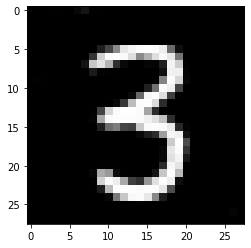

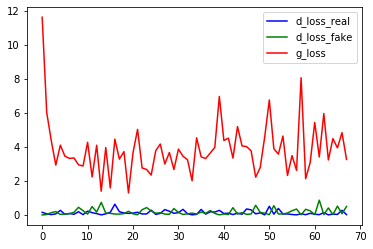

[68/200][0/938] Loss_D: 0.1908 Loss_G: 4.3221 D(x): 0.9891 D(G(z)): 0.1363 / 0.0466
[68/200][100/938] Loss_D: 0.1478 Loss_G: 5.4727 D(x): 0.9021 D(G(z)): 0.0193 / 0.0141
[68/200][200/938] Loss_D: 0.1215 Loss_G: 5.8100 D(x): 0.9093 D(G(z)): 0.0137 / 0.0144
[68/200][300/938] Loss_D: 0.3542 Loss_G: 2.6803 D(x): 0.9978 D(G(z)): 0.2279 / 0.1560
[68/200][400/938] Loss_D: 0.0463 Loss_G: 4.6285 D(x): 0.9948 D(G(z)): 0.0377 / 0.0282
[68/200][500/938] Loss_D: 0.1132 Loss_G: 2.4680 D(x): 0.9865 D(G(z)): 0.0864 / 0.1919
[68/200][600/938] Loss_D: 0.5315 Loss_G: 4.3074 D(x): 0.6775 D(G(z)): 0.0280 / 0.0534
[68/200][700/938] Loss_D: 0.1015 Loss_G: 6.2664 D(x): 0.9741 D(G(z)): 0.0558 / 0.0162
[68/200][800/938] Loss_D: 0.8466 Loss_G: 5.9655 D(x): 0.5146 D(G(z)): 0.0031 / 0.0084
[68/200][900/938] Loss_D: 0.1364 Loss_G: 4.8281 D(x): 0.9208 D(G(z)): 0.0366 / 0.0294


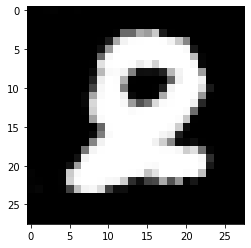

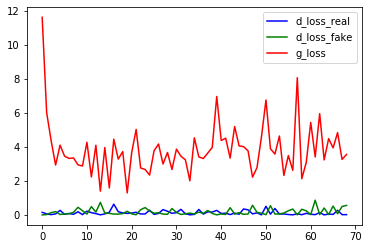

[69/200][0/938] Loss_D: 0.2476 Loss_G: 6.5938 D(x): 0.8220 D(G(z)): 0.0073 / 0.0042
[69/200][100/938] Loss_D: 0.3157 Loss_G: 5.6320 D(x): 0.7765 D(G(z)): 0.0103 / 0.0151
[69/200][200/938] Loss_D: 0.2960 Loss_G: 2.2743 D(x): 0.9663 D(G(z)): 0.1866 / 0.2104
[69/200][300/938] Loss_D: 0.2929 Loss_G: 3.6685 D(x): 0.9865 D(G(z)): 0.1978 / 0.0819
[69/200][400/938] Loss_D: 0.1526 Loss_G: 3.7804 D(x): 0.9408 D(G(z)): 0.0716 / 0.0594
[69/200][500/938] Loss_D: 0.0723 Loss_G: 4.6927 D(x): 0.9595 D(G(z)): 0.0276 / 0.0341
[69/200][600/938] Loss_D: 0.1138 Loss_G: 7.2905 D(x): 0.9100 D(G(z)): 0.0080 / 0.0023
[69/200][700/938] Loss_D: 0.3772 Loss_G: 4.9486 D(x): 0.7603 D(G(z)): 0.0050 / 0.0261
[69/200][800/938] Loss_D: 0.2653 Loss_G: 2.1828 D(x): 0.9900 D(G(z)): 0.1701 / 0.2279
[69/200][900/938] Loss_D: 0.0880 Loss_G: 3.3440 D(x): 0.9937 D(G(z)): 0.0692 / 0.0867


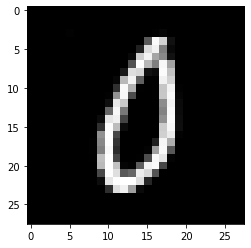

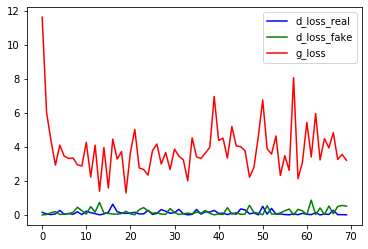

[70/200][0/938] Loss_D: 0.1276 Loss_G: 5.2869 D(x): 0.9752 D(G(z)): 0.0867 / 0.0213
[70/200][100/938] Loss_D: 0.1312 Loss_G: 3.9940 D(x): 0.9358 D(G(z)): 0.0497 / 0.0471
[70/200][200/938] Loss_D: 0.0306 Loss_G: 5.6586 D(x): 0.9936 D(G(z)): 0.0210 / 0.0166
[70/200][300/938] Loss_D: 0.1768 Loss_G: 5.4820 D(x): 0.8671 D(G(z)): 0.0162 / 0.0186
[70/200][400/938] Loss_D: 0.4551 Loss_G: 3.3016 D(x): 0.9642 D(G(z)): 0.2492 / 0.1212
[70/200][500/938] Loss_D: 0.1429 Loss_G: 4.0473 D(x): 0.9508 D(G(z)): 0.0744 / 0.0671
[70/200][600/938] Loss_D: 0.1301 Loss_G: 3.3989 D(x): 0.9570 D(G(z)): 0.0655 / 0.0989
[70/200][700/938] Loss_D: 0.0908 Loss_G: 5.3972 D(x): 0.9763 D(G(z)): 0.0552 / 0.0180
[70/200][800/938] Loss_D: 0.3117 Loss_G: 2.5892 D(x): 0.9792 D(G(z)): 0.1991 / 0.1518
[70/200][900/938] Loss_D: 0.2905 Loss_G: 2.5818 D(x): 0.9773 D(G(z)): 0.1958 / 0.1631


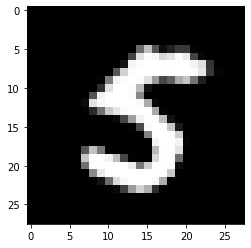

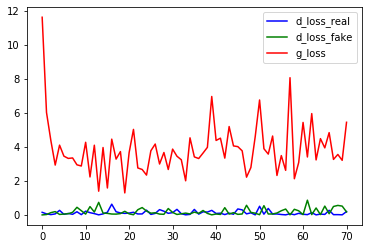

[71/200][0/938] Loss_D: 0.3966 Loss_G: 7.4164 D(x): 0.7576 D(G(z)): 0.0045 / 0.0038
[71/200][100/938] Loss_D: 0.0945 Loss_G: 4.4980 D(x): 0.9966 D(G(z)): 0.0726 / 0.0336
[71/200][200/938] Loss_D: 0.7182 Loss_G: 7.1130 D(x): 0.6567 D(G(z)): 0.0031 / 0.0044
[71/200][300/938] Loss_D: 0.0512 Loss_G: 5.3727 D(x): 0.9817 D(G(z)): 0.0279 / 0.0269
[71/200][400/938] Loss_D: 0.1577 Loss_G: 4.7774 D(x): 0.9593 D(G(z)): 0.0873 / 0.0398
[71/200][500/938] Loss_D: 0.0376 Loss_G: 6.2747 D(x): 0.9824 D(G(z)): 0.0149 / 0.0112
[71/200][600/938] Loss_D: 0.2129 Loss_G: 3.4367 D(x): 0.9848 D(G(z)): 0.1478 / 0.0833
[71/200][700/938] Loss_D: 0.0966 Loss_G: 4.3766 D(x): 0.9913 D(G(z)): 0.0644 / 0.0485
[71/200][800/938] Loss_D: 0.0782 Loss_G: 4.4699 D(x): 0.9944 D(G(z)): 0.0618 / 0.0438
[71/200][900/938] Loss_D: 0.1192 Loss_G: 5.6496 D(x): 0.9608 D(G(z)): 0.0397 / 0.0153


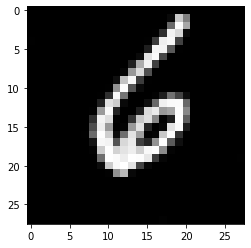

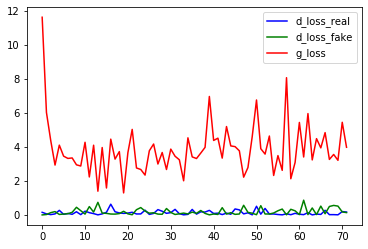

[72/200][0/938] Loss_D: 0.2346 Loss_G: 4.1595 D(x): 0.9049 D(G(z)): 0.0902 / 0.0644
[72/200][100/938] Loss_D: 0.0850 Loss_G: 4.0893 D(x): 0.9889 D(G(z)): 0.0587 / 0.0756
[72/200][200/938] Loss_D: 0.2697 Loss_G: 3.4842 D(x): 0.9074 D(G(z)): 0.1030 / 0.0771
[72/200][300/938] Loss_D: 0.9097 Loss_G: 4.7590 D(x): 0.5550 D(G(z)): 0.0161 / 0.0477
[72/200][400/938] Loss_D: 0.1620 Loss_G: 3.0671 D(x): 0.9562 D(G(z)): 0.0918 / 0.1196
[72/200][500/938] Loss_D: 0.1208 Loss_G: 4.5087 D(x): 0.9311 D(G(z)): 0.0361 / 0.0402
[72/200][600/938] Loss_D: 0.2134 Loss_G: 3.0823 D(x): 0.9891 D(G(z)): 0.1399 / 0.1260
[72/200][700/938] Loss_D: 0.2239 Loss_G: 4.9192 D(x): 0.8434 D(G(z)): 0.0195 / 0.0206
[72/200][800/938] Loss_D: 0.1078 Loss_G: 3.7758 D(x): 0.9406 D(G(z)): 0.0368 / 0.0619
[72/200][900/938] Loss_D: 0.0851 Loss_G: 5.3898 D(x): 0.9538 D(G(z)): 0.0306 / 0.0164


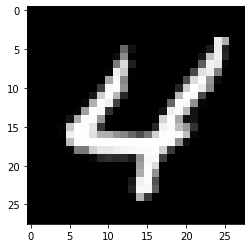

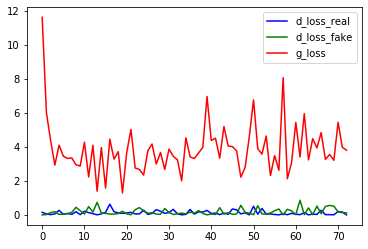

[73/200][0/938] Loss_D: 0.2097 Loss_G: 3.4778 D(x): 0.9795 D(G(z)): 0.1242 / 0.0914
[73/200][100/938] Loss_D: 0.2521 Loss_G: 4.0556 D(x): 0.8442 D(G(z)): 0.0311 / 0.0472
[73/200][200/938] Loss_D: 0.2029 Loss_G: 3.4412 D(x): 0.9874 D(G(z)): 0.1497 / 0.0846
[73/200][300/938] Loss_D: 0.4994 Loss_G: 3.1419 D(x): 0.9867 D(G(z)): 0.2916 / 0.1219
[73/200][400/938] Loss_D: 0.3403 Loss_G: 3.9028 D(x): 0.8337 D(G(z)): 0.0391 / 0.0732
[73/200][500/938] Loss_D: 0.2132 Loss_G: 5.3880 D(x): 0.8412 D(G(z)): 0.0161 / 0.0203
[73/200][600/938] Loss_D: 0.4860 Loss_G: 3.3628 D(x): 0.9685 D(G(z)): 0.2833 / 0.0909
[73/200][700/938] Loss_D: 0.2262 Loss_G: 3.8221 D(x): 0.8840 D(G(z)): 0.0489 / 0.0622
[73/200][800/938] Loss_D: 0.7309 Loss_G: 7.9400 D(x): 0.5730 D(G(z)): 0.0007 / 0.0017
[73/200][900/938] Loss_D: 0.1040 Loss_G: 3.5174 D(x): 0.9891 D(G(z)): 0.0802 / 0.0836


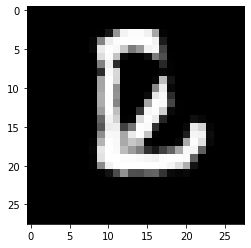

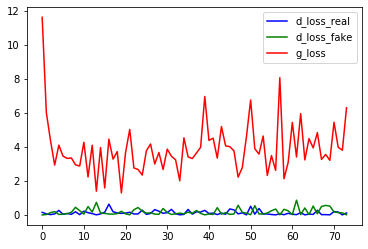

[74/200][0/938] Loss_D: 0.3467 Loss_G: 6.4285 D(x): 0.7621 D(G(z)): 0.0050 / 0.0117
[74/200][100/938] Loss_D: 0.0127 Loss_G: 5.7412 D(x): 0.9983 D(G(z)): 0.0107 / 0.0137
[74/200][200/938] Loss_D: 0.5345 Loss_G: 7.0166 D(x): 0.6705 D(G(z)): 0.0069 / 0.0076
[74/200][300/938] Loss_D: 0.2840 Loss_G: 2.6691 D(x): 0.9449 D(G(z)): 0.1611 / 0.1514
[74/200][400/938] Loss_D: 0.4412 Loss_G: 3.0153 D(x): 0.8512 D(G(z)): 0.1763 / 0.1253
[74/200][500/938] Loss_D: 0.0763 Loss_G: 3.9690 D(x): 0.9819 D(G(z)): 0.0525 / 0.0658
[74/200][600/938] Loss_D: 1.1867 Loss_G: 5.8660 D(x): 0.4258 D(G(z)): 0.0013 / 0.0151
[74/200][700/938] Loss_D: 0.2363 Loss_G: 4.3538 D(x): 0.9528 D(G(z)): 0.1374 / 0.0476
[74/200][800/938] Loss_D: 0.4599 Loss_G: 2.7170 D(x): 0.9899 D(G(z)): 0.3041 / 0.1435
[74/200][900/938] Loss_D: 0.1636 Loss_G: 4.2739 D(x): 0.9529 D(G(z)): 0.0845 / 0.0477


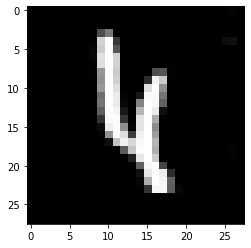

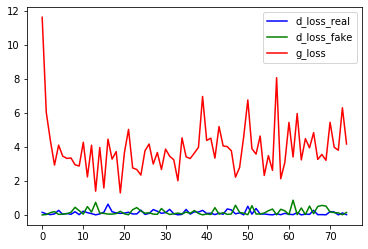

[75/200][0/938] Loss_D: 0.1071 Loss_G: 4.6799 D(x): 0.9872 D(G(z)): 0.0773 / 0.0515
[75/200][100/938] Loss_D: 0.1030 Loss_G: 4.3451 D(x): 0.9463 D(G(z)): 0.0397 / 0.0426
[75/200][200/938] Loss_D: 0.2669 Loss_G: 4.2708 D(x): 0.8425 D(G(z)): 0.0573 / 0.0528
[75/200][300/938] Loss_D: 0.1414 Loss_G: 6.1223 D(x): 0.9452 D(G(z)): 0.0653 / 0.0113
[75/200][400/938] Loss_D: 0.2825 Loss_G: 3.3341 D(x): 0.9775 D(G(z)): 0.1763 / 0.1076
[75/200][500/938] Loss_D: 0.3209 Loss_G: 5.9423 D(x): 0.7927 D(G(z)): 0.0199 / 0.0088
[75/200][600/938] Loss_D: 0.3214 Loss_G: 6.9112 D(x): 0.7849 D(G(z)): 0.0059 / 0.0053
[75/200][700/938] Loss_D: 0.1694 Loss_G: 4.5203 D(x): 0.9086 D(G(z)): 0.0350 / 0.0424
[75/200][800/938] Loss_D: 0.4131 Loss_G: 1.6480 D(x): 0.9947 D(G(z)): 0.2445 / 0.3278
[75/200][900/938] Loss_D: 0.2667 Loss_G: 3.3949 D(x): 0.9947 D(G(z)): 0.1740 / 0.0988


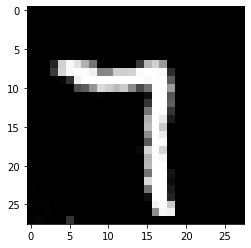

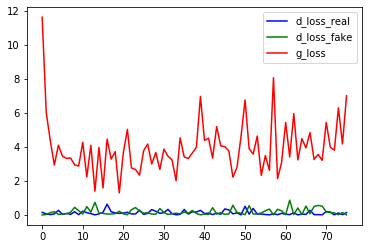

[76/200][0/938] Loss_D: 0.2227 Loss_G: 4.6153 D(x): 0.8474 D(G(z)): 0.0226 / 0.0381
[76/200][100/938] Loss_D: 0.2790 Loss_G: 4.9677 D(x): 0.8072 D(G(z)): 0.0201 / 0.0213
[76/200][200/938] Loss_D: 0.1341 Loss_G: 4.1177 D(x): 0.9246 D(G(z)): 0.0448 / 0.0466
[76/200][300/938] Loss_D: 0.1636 Loss_G: 3.5540 D(x): 0.9666 D(G(z)): 0.1045 / 0.0730
[76/200][400/938] Loss_D: 0.0537 Loss_G: 4.9916 D(x): 0.9844 D(G(z)): 0.0349 / 0.0263
[76/200][500/938] Loss_D: 0.6289 Loss_G: 7.4616 D(x): 0.6226 D(G(z)): 0.0003 / 0.0020
[76/200][600/938] Loss_D: 0.1905 Loss_G: 3.4171 D(x): 0.9926 D(G(z)): 0.1069 / 0.0946
[76/200][700/938] Loss_D: 0.1959 Loss_G: 5.0990 D(x): 0.9876 D(G(z)): 0.1391 / 0.0197
[76/200][800/938] Loss_D: 0.2341 Loss_G: 5.2016 D(x): 0.9086 D(G(z)): 0.0902 / 0.0284
[76/200][900/938] Loss_D: 0.6805 Loss_G: 3.6582 D(x): 0.7150 D(G(z)): 0.1279 / 0.0807


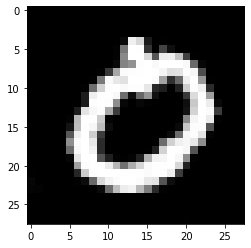

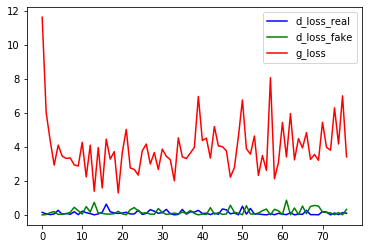

[77/200][0/938] Loss_D: 0.3319 Loss_G: 3.0291 D(x): 0.9787 D(G(z)): 0.2328 / 0.0931
[77/200][100/938] Loss_D: 0.0964 Loss_G: 6.0342 D(x): 0.9284 D(G(z)): 0.0087 / 0.0091
[77/200][200/938] Loss_D: 0.1008 Loss_G: 6.0722 D(x): 0.9219 D(G(z)): 0.0055 / 0.0090
[77/200][300/938] Loss_D: 0.1317 Loss_G: 6.9077 D(x): 0.8916 D(G(z)): 0.0087 / 0.0062
[77/200][400/938] Loss_D: 0.4983 Loss_G: 5.7969 D(x): 0.6994 D(G(z)): 0.0088 / 0.0124
[77/200][500/938] Loss_D: 0.1056 Loss_G: 5.9207 D(x): 0.9161 D(G(z)): 0.0089 / 0.0075
[77/200][600/938] Loss_D: 0.0203 Loss_G: 6.6496 D(x): 0.9855 D(G(z)): 0.0051 / 0.0039
[77/200][700/938] Loss_D: 0.2270 Loss_G: 3.5900 D(x): 0.9720 D(G(z)): 0.1545 / 0.0725
[77/200][800/938] Loss_D: 0.1746 Loss_G: 3.6585 D(x): 0.9852 D(G(z)): 0.1103 / 0.0891
[77/200][900/938] Loss_D: 0.3232 Loss_G: 4.7900 D(x): 0.7922 D(G(z)): 0.0150 / 0.0261


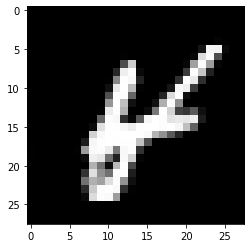

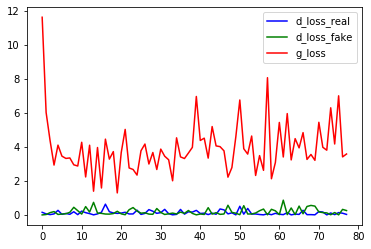

[78/200][0/938] Loss_D: 0.0338 Loss_G: 5.7676 D(x): 0.9913 D(G(z)): 0.0233 / 0.0117
[78/200][100/938] Loss_D: 0.0761 Loss_G: 5.7171 D(x): 0.9487 D(G(z)): 0.0177 / 0.0102
[78/200][200/938] Loss_D: 0.2613 Loss_G: 6.3006 D(x): 0.8201 D(G(z)): 0.0029 / 0.0091
[78/200][300/938] Loss_D: 0.1935 Loss_G: 4.9950 D(x): 0.8657 D(G(z)): 0.0158 / 0.0229
[78/200][400/938] Loss_D: 0.0261 Loss_G: 7.5157 D(x): 0.9796 D(G(z)): 0.0048 / 0.0026
[78/200][500/938] Loss_D: 0.0701 Loss_G: 6.0949 D(x): 0.9444 D(G(z)): 0.0092 / 0.0087
[78/200][600/938] Loss_D: 0.1023 Loss_G: 3.9012 D(x): 0.9772 D(G(z)): 0.0566 / 0.0589
[78/200][700/938] Loss_D: 0.2341 Loss_G: 4.1280 D(x): 0.9620 D(G(z)): 0.1344 / 0.0688
[78/200][800/938] Loss_D: 0.0513 Loss_G: 5.1451 D(x): 0.9851 D(G(z)): 0.0303 / 0.0203
[78/200][900/938] Loss_D: 0.3634 Loss_G: 3.8953 D(x): 0.9368 D(G(z)): 0.1783 / 0.0859


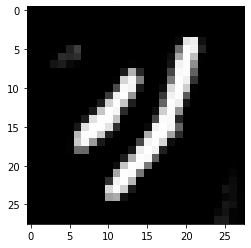

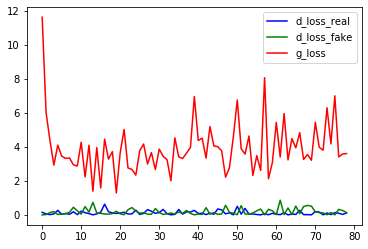

[79/200][0/938] Loss_D: 0.0788 Loss_G: 5.0295 D(x): 0.9700 D(G(z)): 0.0379 / 0.0315
[79/200][100/938] Loss_D: 0.1300 Loss_G: 4.6311 D(x): 0.9888 D(G(z)): 0.0948 / 0.0441
[79/200][200/938] Loss_D: 0.0669 Loss_G: 5.3837 D(x): 0.9600 D(G(z)): 0.0214 / 0.0250
[79/200][300/938] Loss_D: 0.0896 Loss_G: 4.1944 D(x): 0.9846 D(G(z)): 0.0638 / 0.0494
[79/200][400/938] Loss_D: 0.0363 Loss_G: 7.7749 D(x): 0.9666 D(G(z)): 0.0017 / 0.0014
[79/200][500/938] Loss_D: 0.3267 Loss_G: 4.2907 D(x): 0.9481 D(G(z)): 0.1835 / 0.0456
[79/200][600/938] Loss_D: 0.0918 Loss_G: 5.2285 D(x): 0.9644 D(G(z)): 0.0450 / 0.0287
[79/200][700/938] Loss_D: 0.0744 Loss_G: 5.0015 D(x): 0.9617 D(G(z)): 0.0314 / 0.0266
[79/200][800/938] Loss_D: 0.0937 Loss_G: 4.7373 D(x): 0.9985 D(G(z)): 0.0786 / 0.0339
[79/200][900/938] Loss_D: 0.1772 Loss_G: 3.3920 D(x): 0.9967 D(G(z)): 0.1161 / 0.0962


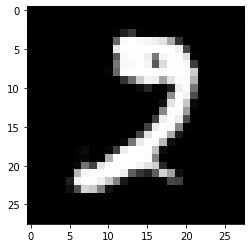

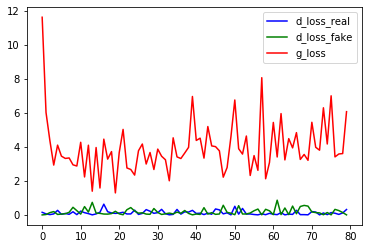

[80/200][0/938] Loss_D: 0.1101 Loss_G: 4.5757 D(x): 0.9251 D(G(z)): 0.0164 / 0.0449
[80/200][100/938] Loss_D: 0.4304 Loss_G: 4.3254 D(x): 0.7539 D(G(z)): 0.0195 / 0.0728
[80/200][200/938] Loss_D: 0.1549 Loss_G: 6.4589 D(x): 0.8833 D(G(z)): 0.0053 / 0.0112
[80/200][300/938] Loss_D: 0.3569 Loss_G: 4.6174 D(x): 0.8923 D(G(z)): 0.1472 / 0.0401
[80/200][400/938] Loss_D: 0.1451 Loss_G: 4.1095 D(x): 0.9660 D(G(z)): 0.0816 / 0.0748
[80/200][500/938] Loss_D: 0.2145 Loss_G: 4.6562 D(x): 0.8540 D(G(z)): 0.0280 / 0.0311
[80/200][600/938] Loss_D: 0.1169 Loss_G: 4.2244 D(x): 0.9774 D(G(z)): 0.0790 / 0.0446
[80/200][700/938] Loss_D: 0.3777 Loss_G: 3.7773 D(x): 0.9957 D(G(z)): 0.1881 / 0.0917
[80/200][800/938] Loss_D: 0.2390 Loss_G: 7.7477 D(x): 0.8272 D(G(z)): 0.0016 / 0.0013
[80/200][900/938] Loss_D: 0.2876 Loss_G: 3.7704 D(x): 0.9708 D(G(z)): 0.1437 / 0.0808


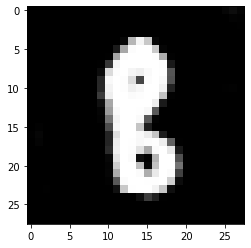

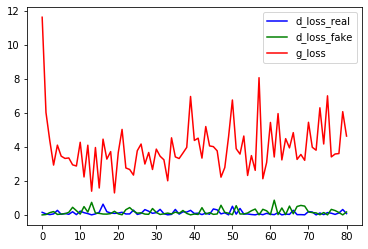

[81/200][0/938] Loss_D: 0.1413 Loss_G: 5.4299 D(x): 0.9067 D(G(z)): 0.0205 / 0.0131
[81/200][100/938] Loss_D: 0.1068 Loss_G: 3.4675 D(x): 0.9829 D(G(z)): 0.0669 / 0.0953
[81/200][200/938] Loss_D: 0.1210 Loss_G: 5.9055 D(x): 0.9132 D(G(z)): 0.0183 / 0.0139
[81/200][300/938] Loss_D: 0.1737 Loss_G: 4.5285 D(x): 0.9880 D(G(z)): 0.1115 / 0.0412
[81/200][400/938] Loss_D: 0.1343 Loss_G: 4.0562 D(x): 0.9822 D(G(z)): 0.0948 / 0.0602
[81/200][500/938] Loss_D: 0.0600 Loss_G: 5.9174 D(x): 0.9635 D(G(z)): 0.0182 / 0.0200
[81/200][600/938] Loss_D: 0.1525 Loss_G: 3.8347 D(x): 0.9880 D(G(z)): 0.1138 / 0.0628
[81/200][700/938] Loss_D: 0.1426 Loss_G: 5.8026 D(x): 0.9137 D(G(z)): 0.0076 / 0.0141
[81/200][800/938] Loss_D: 0.4587 Loss_G: 7.4827 D(x): 0.7012 D(G(z)): 0.0038 / 0.0026
[81/200][900/938] Loss_D: 0.2746 Loss_G: 3.6309 D(x): 0.8754 D(G(z)): 0.0707 / 0.0767


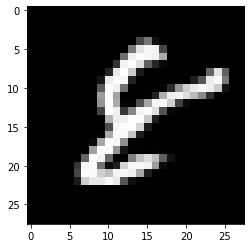

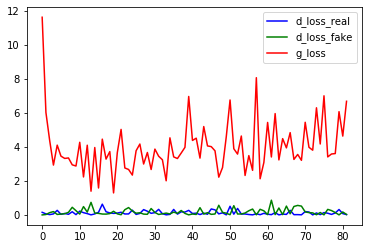

[82/200][0/938] Loss_D: 0.1060 Loss_G: 6.1409 D(x): 0.9226 D(G(z)): 0.0109 / 0.0078
[82/200][100/938] Loss_D: 0.2000 Loss_G: 3.9155 D(x): 0.8883 D(G(z)): 0.0581 / 0.0687
[82/200][200/938] Loss_D: 0.1200 Loss_G: 5.1667 D(x): 0.9167 D(G(z)): 0.0231 / 0.0330
[82/200][300/938] Loss_D: 0.0750 Loss_G: 4.9243 D(x): 0.9791 D(G(z)): 0.0489 / 0.0252
[82/200][400/938] Loss_D: 0.1522 Loss_G: 4.1297 D(x): 0.9471 D(G(z)): 0.0715 / 0.0536
[82/200][500/938] Loss_D: 0.1674 Loss_G: 3.9744 D(x): 0.9811 D(G(z)): 0.1119 / 0.0617
[82/200][600/938] Loss_D: 0.2371 Loss_G: 4.1492 D(x): 0.8565 D(G(z)): 0.0447 / 0.0550
[82/200][700/938] Loss_D: 0.2393 Loss_G: 7.4509 D(x): 0.8307 D(G(z)): 0.0036 / 0.0080
[82/200][800/938] Loss_D: 0.0546 Loss_G: 4.4427 D(x): 0.9813 D(G(z)): 0.0327 / 0.0279
[82/200][900/938] Loss_D: 0.1521 Loss_G: 3.5453 D(x): 0.9969 D(G(z)): 0.1059 / 0.0866


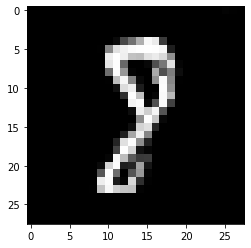

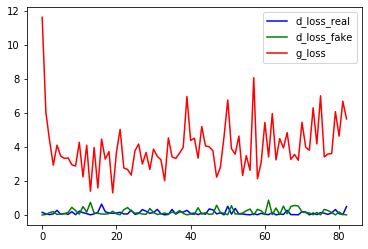

[83/200][0/938] Loss_D: 0.2614 Loss_G: 5.1249 D(x): 0.8175 D(G(z)): 0.0057 / 0.0351
[83/200][100/938] Loss_D: 0.0872 Loss_G: 6.5195 D(x): 0.9262 D(G(z)): 0.0045 / 0.0082
[83/200][200/938] Loss_D: 0.0728 Loss_G: 6.0351 D(x): 0.9625 D(G(z)): 0.0312 / 0.0091
[83/200][300/938] Loss_D: 0.3671 Loss_G: 4.2371 D(x): 0.7485 D(G(z)): 0.0276 / 0.0538
[83/200][400/938] Loss_D: 0.1262 Loss_G: 3.7952 D(x): 0.9539 D(G(z)): 0.0621 / 0.0695
[83/200][500/938] Loss_D: 0.0582 Loss_G: 4.9885 D(x): 0.9853 D(G(z)): 0.0364 / 0.0276
[83/200][600/938] Loss_D: 0.2064 Loss_G: 3.4610 D(x): 0.9308 D(G(z)): 0.1054 / 0.1040
[83/200][700/938] Loss_D: 0.0449 Loss_G: 5.1453 D(x): 0.9732 D(G(z)): 0.0166 / 0.0177
[83/200][800/938] Loss_D: 0.2456 Loss_G: 4.1133 D(x): 0.9644 D(G(z)): 0.1542 / 0.0507
[83/200][900/938] Loss_D: 0.1758 Loss_G: 3.4669 D(x): 0.9633 D(G(z)): 0.0951 / 0.1096


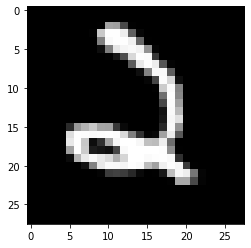

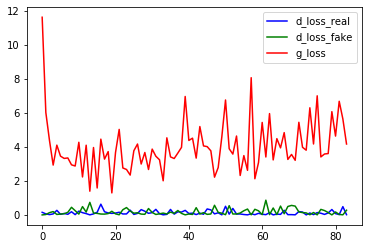

[84/200][0/938] Loss_D: 0.1639 Loss_G: 5.8922 D(x): 0.8950 D(G(z)): 0.0297 / 0.0121
[84/200][100/938] Loss_D: 0.2928 Loss_G: 3.9810 D(x): 0.9618 D(G(z)): 0.1657 / 0.0617
[84/200][200/938] Loss_D: 0.1820 Loss_G: 3.0637 D(x): 0.9714 D(G(z)): 0.1166 / 0.1103
[84/200][300/938] Loss_D: 0.2882 Loss_G: 7.7694 D(x): 0.7998 D(G(z)): 0.0057 / 0.0041
[84/200][400/938] Loss_D: 0.2050 Loss_G: 3.6136 D(x): 0.9592 D(G(z)): 0.1252 / 0.0863
[84/200][500/938] Loss_D: 0.3582 Loss_G: 2.6803 D(x): 0.9395 D(G(z)): 0.1854 / 0.1743
[84/200][600/938] Loss_D: 0.1274 Loss_G: 3.9367 D(x): 0.9947 D(G(z)): 0.0934 / 0.0730
[84/200][700/938] Loss_D: 0.0381 Loss_G: 4.6826 D(x): 0.9813 D(G(z)): 0.0183 / 0.0268
[84/200][800/938] Loss_D: 0.2386 Loss_G: 4.8138 D(x): 0.8493 D(G(z)): 0.0344 / 0.0376
[84/200][900/938] Loss_D: 0.3311 Loss_G: 5.8683 D(x): 0.8017 D(G(z)): 0.0340 / 0.0318


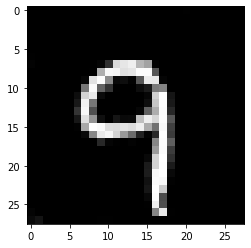

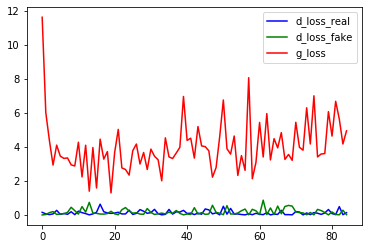

[85/200][0/938] Loss_D: 0.1552 Loss_G: 3.4481 D(x): 0.9947 D(G(z)): 0.1189 / 0.1110
[85/200][100/938] Loss_D: 0.0959 Loss_G: 5.3920 D(x): 0.9596 D(G(z)): 0.0342 / 0.0243
[85/200][200/938] Loss_D: 0.0945 Loss_G: 4.1601 D(x): 0.9872 D(G(z)): 0.0701 / 0.0710
[85/200][300/938] Loss_D: 0.0994 Loss_G: 4.6857 D(x): 0.9436 D(G(z)): 0.0329 / 0.0380
[85/200][400/938] Loss_D: 0.2123 Loss_G: 5.7253 D(x): 0.9660 D(G(z)): 0.1345 / 0.0128
[85/200][500/938] Loss_D: 0.4756 Loss_G: 3.2235 D(x): 0.9935 D(G(z)): 0.2779 / 0.1249
[85/200][600/938] Loss_D: 0.0523 Loss_G: 6.1935 D(x): 0.9782 D(G(z)): 0.0269 / 0.0094
[85/200][700/938] Loss_D: 0.2526 Loss_G: 5.3074 D(x): 0.8354 D(G(z)): 0.0240 / 0.0214
[85/200][800/938] Loss_D: 0.3594 Loss_G: 3.8297 D(x): 0.9604 D(G(z)): 0.2040 / 0.0812
[85/200][900/938] Loss_D: 0.2888 Loss_G: 5.3100 D(x): 0.7957 D(G(z)): 0.0059 / 0.0258


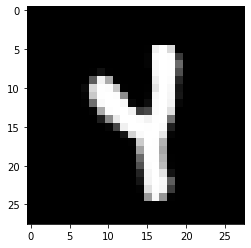

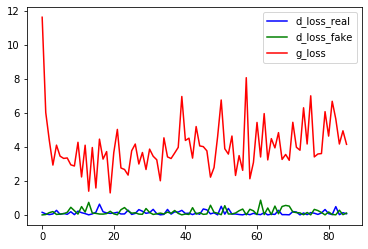

[86/200][0/938] Loss_D: 0.1660 Loss_G: 3.6985 D(x): 0.9912 D(G(z)): 0.1193 / 0.0751
[86/200][100/938] Loss_D: 0.0680 Loss_G: 5.4379 D(x): 0.9543 D(G(z)): 0.0169 / 0.0136
[86/200][200/938] Loss_D: 0.0340 Loss_G: 5.9304 D(x): 0.9779 D(G(z)): 0.0107 / 0.0074
[86/200][300/938] Loss_D: 0.0238 Loss_G: 7.4183 D(x): 0.9906 D(G(z)): 0.0132 / 0.0053
[86/200][400/938] Loss_D: 0.1111 Loss_G: 5.3251 D(x): 0.9146 D(G(z)): 0.0120 / 0.0142
[86/200][500/938] Loss_D: 0.0896 Loss_G: 8.5711 D(x): 0.9219 D(G(z)): 0.0013 / 0.0014
[86/200][600/938] Loss_D: 0.1143 Loss_G: 4.6178 D(x): 0.9771 D(G(z)): 0.0634 / 0.0506
[86/200][700/938] Loss_D: 0.2103 Loss_G: 5.4491 D(x): 0.8438 D(G(z)): 0.0162 / 0.0207
[86/200][800/938] Loss_D: 0.3447 Loss_G: 4.1332 D(x): 0.7898 D(G(z)): 0.0451 / 0.0544
[86/200][900/938] Loss_D: 0.1315 Loss_G: 7.0358 D(x): 0.9049 D(G(z)): 0.0194 / 0.0045


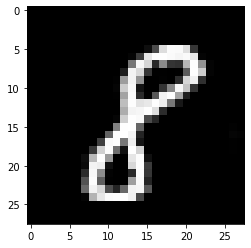

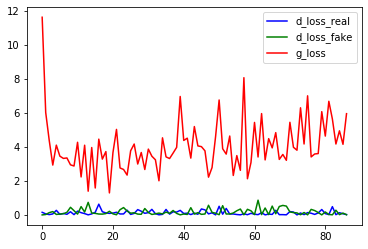

[87/200][0/938] Loss_D: 0.3091 Loss_G: 6.0441 D(x): 0.8230 D(G(z)): 0.0220 / 0.0242
[87/200][100/938] Loss_D: 0.0264 Loss_G: 5.9281 D(x): 0.9828 D(G(z)): 0.0085 / 0.0106
[87/200][200/938] Loss_D: 0.0348 Loss_G: 6.3944 D(x): 0.9724 D(G(z)): 0.0058 / 0.0073
[87/200][300/938] Loss_D: 0.0539 Loss_G: 5.6282 D(x): 0.9662 D(G(z)): 0.0163 / 0.0164
[87/200][400/938] Loss_D: 0.1246 Loss_G: 4.8562 D(x): 0.9103 D(G(z)): 0.0185 / 0.0391
[87/200][500/938] Loss_D: 0.0413 Loss_G: 5.2495 D(x): 0.9789 D(G(z)): 0.0178 / 0.0153
[87/200][600/938] Loss_D: 0.0687 Loss_G: 4.9337 D(x): 0.9673 D(G(z)): 0.0307 / 0.0318
[87/200][700/938] Loss_D: 0.3784 Loss_G: 3.5535 D(x): 0.9952 D(G(z)): 0.2194 / 0.1217
[87/200][800/938] Loss_D: 0.1613 Loss_G: 6.8434 D(x): 0.8911 D(G(z)): 0.0259 / 0.0066
[87/200][900/938] Loss_D: 0.0849 Loss_G: 5.9487 D(x): 0.9470 D(G(z)): 0.0171 / 0.0197


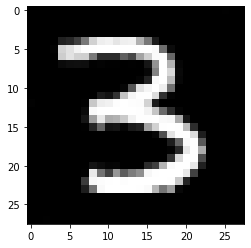

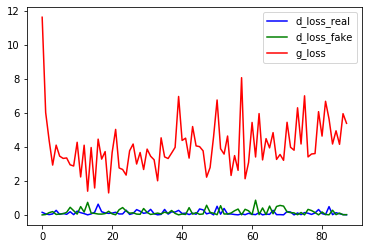

[88/200][0/938] Loss_D: 0.0916 Loss_G: 4.8866 D(x): 0.9824 D(G(z)): 0.0467 / 0.0387
[88/200][100/938] Loss_D: 0.4124 Loss_G: 3.0368 D(x): 0.9933 D(G(z)): 0.2466 / 0.1139
[88/200][200/938] Loss_D: 0.2839 Loss_G: 4.9744 D(x): 0.8137 D(G(z)): 0.0377 / 0.0382
[88/200][300/938] Loss_D: 0.0882 Loss_G: 4.5056 D(x): 0.9859 D(G(z)): 0.0596 / 0.0505
[88/200][400/938] Loss_D: 0.2647 Loss_G: 4.9202 D(x): 0.9363 D(G(z)): 0.1269 / 0.0331
[88/200][500/938] Loss_D: 0.0362 Loss_G: 8.3088 D(x): 0.9675 D(G(z)): 0.0016 / 0.0013
[88/200][600/938] Loss_D: 0.1393 Loss_G: 4.1397 D(x): 0.9516 D(G(z)): 0.0651 / 0.0554
[88/200][700/938] Loss_D: 0.3178 Loss_G: 6.2602 D(x): 0.7912 D(G(z)): 0.0085 / 0.0136
[88/200][800/938] Loss_D: 0.0055 Loss_G: 7.9467 D(x): 0.9967 D(G(z)): 0.0022 / 0.0017
[88/200][900/938] Loss_D: 1.4718 Loss_G: 7.4390 D(x): 0.3890 D(G(z)): 0.0011 / 0.0067


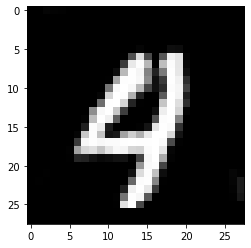

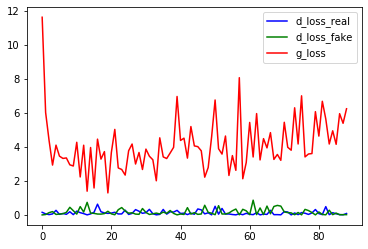

[89/200][0/938] Loss_D: 0.1948 Loss_G: 4.4691 D(x): 0.9447 D(G(z)): 0.0922 / 0.0511
[89/200][100/938] Loss_D: 0.0466 Loss_G: 4.7805 D(x): 0.9825 D(G(z)): 0.0262 / 0.0283
[89/200][200/938] Loss_D: 0.9401 Loss_G: 4.9184 D(x): 0.5317 D(G(z)): 0.0072 / 0.0376
[89/200][300/938] Loss_D: 0.0883 Loss_G: 4.6369 D(x): 0.9461 D(G(z)): 0.0283 / 0.0365
[89/200][400/938] Loss_D: 0.5155 Loss_G: 2.5442 D(x): 0.9949 D(G(z)): 0.2849 / 0.1733
[89/200][500/938] Loss_D: 0.1305 Loss_G: 4.2792 D(x): 0.9702 D(G(z)): 0.0838 / 0.0513
[89/200][600/938] Loss_D: 0.1906 Loss_G: 3.8405 D(x): 0.9349 D(G(z)): 0.0928 / 0.0628
[89/200][700/938] Loss_D: 0.1727 Loss_G: 4.5055 D(x): 0.9605 D(G(z)): 0.0911 / 0.0577
[89/200][800/938] Loss_D: 0.0903 Loss_G: 4.3871 D(x): 0.9670 D(G(z)): 0.0486 / 0.0495
[89/200][900/938] Loss_D: 0.0867 Loss_G: 4.3927 D(x): 0.9798 D(G(z)): 0.0546 / 0.0557


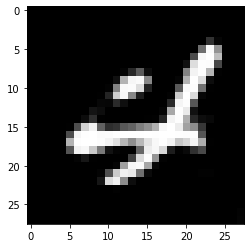

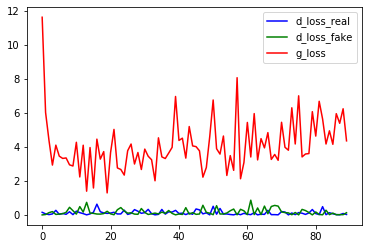

[90/200][0/938] Loss_D: 0.0686 Loss_G: 5.7223 D(x): 0.9726 D(G(z)): 0.0351 / 0.0169
[90/200][100/938] Loss_D: 0.0188 Loss_G: 5.5310 D(x): 0.9933 D(G(z)): 0.0115 / 0.0133
[90/200][200/938] Loss_D: 0.0844 Loss_G: 4.6288 D(x): 0.9780 D(G(z)): 0.0539 / 0.0470
[90/200][300/938] Loss_D: 0.2947 Loss_G: 6.0135 D(x): 0.7944 D(G(z)): 0.0057 / 0.0105
[90/200][400/938] Loss_D: 0.1075 Loss_G: 4.9306 D(x): 0.9383 D(G(z)): 0.0223 / 0.0412
[90/200][500/938] Loss_D: 0.1074 Loss_G: 3.2587 D(x): 0.9921 D(G(z)): 0.0779 / 0.1028
[90/200][600/938] Loss_D: 0.2252 Loss_G: 5.5477 D(x): 0.9617 D(G(z)): 0.1318 / 0.0176
[90/200][700/938] Loss_D: 0.3544 Loss_G: 4.3599 D(x): 0.7850 D(G(z)): 0.0477 / 0.0612
[90/200][800/938] Loss_D: 0.1518 Loss_G: 5.0694 D(x): 0.9278 D(G(z)): 0.0608 / 0.0312
[90/200][900/938] Loss_D: 0.0536 Loss_G: 6.5477 D(x): 0.9674 D(G(z)): 0.0173 / 0.0112


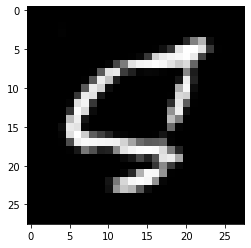

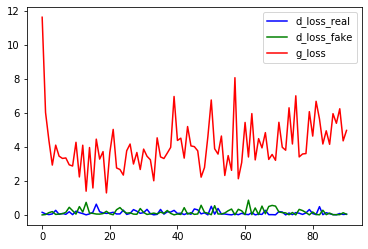

[91/200][0/938] Loss_D: 0.0644 Loss_G: 5.6267 D(x): 0.9635 D(G(z)): 0.0200 / 0.0159
[91/200][100/938] Loss_D: 1.6653 Loss_G: 3.0560 D(x): 0.9996 D(G(z)): 0.6098 / 0.1483
[91/200][200/938] Loss_D: 0.2086 Loss_G: 5.3547 D(x): 0.9856 D(G(z)): 0.1430 / 0.0257
[91/200][300/938] Loss_D: 0.0979 Loss_G: 5.7953 D(x): 0.9176 D(G(z)): 0.0035 / 0.0115
[91/200][400/938] Loss_D: 0.1027 Loss_G: 4.5934 D(x): 0.9379 D(G(z)): 0.0323 / 0.0397
[91/200][500/938] Loss_D: 0.0724 Loss_G: 5.1253 D(x): 0.9656 D(G(z)): 0.0312 / 0.0275
[91/200][600/938] Loss_D: 0.3421 Loss_G: 3.0371 D(x): 0.9514 D(G(z)): 0.1907 / 0.1123
[91/200][700/938] Loss_D: 0.1684 Loss_G: 6.3225 D(x): 0.8639 D(G(z)): 0.0070 / 0.0091
[91/200][800/938] Loss_D: 0.0742 Loss_G: 5.2645 D(x): 0.9670 D(G(z)): 0.0325 / 0.0223
[91/200][900/938] Loss_D: 0.0571 Loss_G: 4.9851 D(x): 0.9810 D(G(z)): 0.0349 / 0.0200


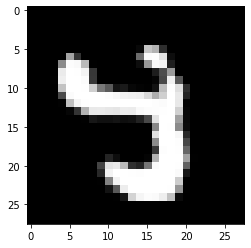

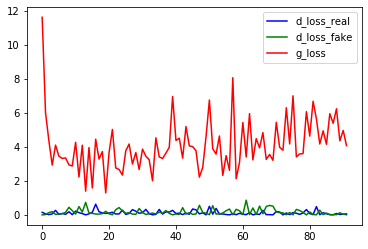

[92/200][0/938] Loss_D: 0.2503 Loss_G: 3.6403 D(x): 0.9832 D(G(z)): 0.1642 / 0.0716
[92/200][100/938] Loss_D: 0.3320 Loss_G: 3.2923 D(x): 0.9980 D(G(z)): 0.2002 / 0.1540
[92/200][200/938] Loss_D: 0.0661 Loss_G: 4.4124 D(x): 0.9657 D(G(z)): 0.0272 / 0.0512
[92/200][300/938] Loss_D: 0.0679 Loss_G: 5.6858 D(x): 0.9640 D(G(z)): 0.0266 / 0.0193
[92/200][400/938] Loss_D: 0.1676 Loss_G: 5.4954 D(x): 0.8822 D(G(z)): 0.0218 / 0.0216
[92/200][500/938] Loss_D: 0.0877 Loss_G: 5.4915 D(x): 0.9438 D(G(z)): 0.0213 / 0.0235
[92/200][600/938] Loss_D: 0.3715 Loss_G: 4.1439 D(x): 0.9725 D(G(z)): 0.2161 / 0.0623
[92/200][700/938] Loss_D: 0.2817 Loss_G: 3.3445 D(x): 0.9989 D(G(z)): 0.1914 / 0.0906
[92/200][800/938] Loss_D: 0.1144 Loss_G: 4.3072 D(x): 0.9512 D(G(z)): 0.0478 / 0.0553
[92/200][900/938] Loss_D: 0.6492 Loss_G: 2.7407 D(x): 0.7118 D(G(z)): 0.1115 / 0.1664


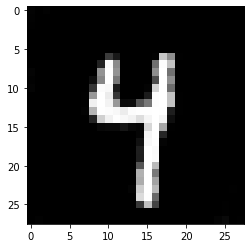

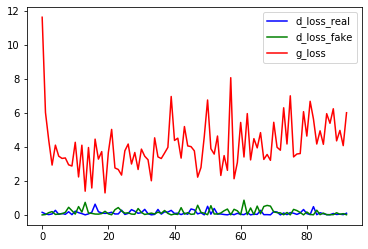

[93/200][0/938] Loss_D: 0.1588 Loss_G: 4.0058 D(x): 0.9672 D(G(z)): 0.0838 / 0.0816
[93/200][100/938] Loss_D: 0.1277 Loss_G: 5.7509 D(x): 0.9753 D(G(z)): 0.0635 / 0.0264
[93/200][200/938] Loss_D: 0.0305 Loss_G: 6.0194 D(x): 0.9790 D(G(z)): 0.0080 / 0.0104
[93/200][300/938] Loss_D: 0.1609 Loss_G: 5.0711 D(x): 0.8770 D(G(z)): 0.0122 / 0.0207
[93/200][400/938] Loss_D: 0.0845 Loss_G: 6.2405 D(x): 0.9329 D(G(z)): 0.0065 / 0.0076
[93/200][500/938] Loss_D: 0.1502 Loss_G: 4.3864 D(x): 0.9802 D(G(z)): 0.0854 / 0.0592
[93/200][600/938] Loss_D: 0.0815 Loss_G: 4.5899 D(x): 0.9948 D(G(z)): 0.0572 / 0.0483
[93/200][700/938] Loss_D: 0.2639 Loss_G: 5.6875 D(x): 0.8181 D(G(z)): 0.0205 / 0.0110
[93/200][800/938] Loss_D: 0.3037 Loss_G: 4.6034 D(x): 0.8162 D(G(z)): 0.0269 / 0.0466
[93/200][900/938] Loss_D: 0.0814 Loss_G: 4.6412 D(x): 0.9745 D(G(z)): 0.0483 / 0.0358


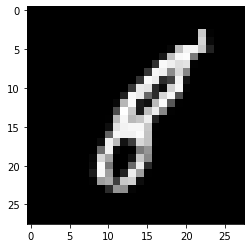

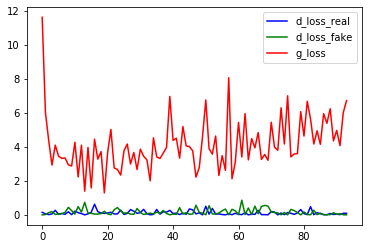

[94/200][0/938] Loss_D: 0.1232 Loss_G: 6.7600 D(x): 0.9036 D(G(z)): 0.0024 / 0.0057
[94/200][100/938] Loss_D: 0.1732 Loss_G: 3.8774 D(x): 0.9754 D(G(z)): 0.1085 / 0.0718
[94/200][200/938] Loss_D: 0.1503 Loss_G: 2.1051 D(x): 0.9939 D(G(z)): 0.1170 / 0.2620
[94/200][300/938] Loss_D: 0.0844 Loss_G: 5.9258 D(x): 0.9381 D(G(z)): 0.0141 / 0.0121
[94/200][400/938] Loss_D: 0.1501 Loss_G: 4.0392 D(x): 0.9939 D(G(z)): 0.1064 / 0.0690
[94/200][500/938] Loss_D: 0.2672 Loss_G: 4.1784 D(x): 0.9816 D(G(z)): 0.1492 / 0.0822
[94/200][600/938] Loss_D: 0.1436 Loss_G: 4.4471 D(x): 0.9120 D(G(z)): 0.0369 / 0.0538
[94/200][700/938] Loss_D: 0.1089 Loss_G: 4.4721 D(x): 0.9353 D(G(z)): 0.0278 / 0.0373
[94/200][800/938] Loss_D: 0.1753 Loss_G: 3.2165 D(x): 0.9873 D(G(z)): 0.1154 / 0.1190
[94/200][900/938] Loss_D: 0.1871 Loss_G: 4.4092 D(x): 0.8932 D(G(z)): 0.0488 / 0.0551


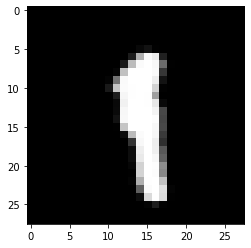

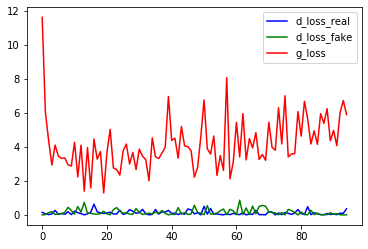

[95/200][0/938] Loss_D: 0.0657 Loss_G: 4.4479 D(x): 0.9772 D(G(z)): 0.0389 / 0.0555
[95/200][100/938] Loss_D: 0.1843 Loss_G: 3.8284 D(x): 0.9951 D(G(z)): 0.1349 / 0.0743
[95/200][200/938] Loss_D: 0.0330 Loss_G: 7.2199 D(x): 0.9739 D(G(z)): 0.0052 / 0.0040
[95/200][300/938] Loss_D: 0.1206 Loss_G: 6.0210 D(x): 0.9028 D(G(z)): 0.0073 / 0.0077
[95/200][400/938] Loss_D: 0.0229 Loss_G: 6.4827 D(x): 0.9820 D(G(z)): 0.0036 / 0.0074
[95/200][500/938] Loss_D: 0.1265 Loss_G: 5.5068 D(x): 0.9192 D(G(z)): 0.0187 / 0.0222
[95/200][600/938] Loss_D: 0.1034 Loss_G: 5.1798 D(x): 0.9373 D(G(z)): 0.0289 / 0.0302
[95/200][700/938] Loss_D: 0.2803 Loss_G: 3.9856 D(x): 0.9948 D(G(z)): 0.1680 / 0.0785
[95/200][800/938] Loss_D: 0.1908 Loss_G: 4.6813 D(x): 0.9674 D(G(z)): 0.1066 / 0.0392
[95/200][900/938] Loss_D: 0.1594 Loss_G: 3.9207 D(x): 0.9917 D(G(z)): 0.1257 / 0.0462


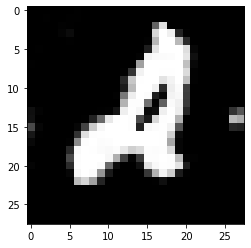

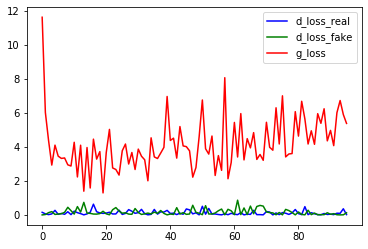

[96/200][0/938] Loss_D: 0.1071 Loss_G: 5.6873 D(x): 0.9744 D(G(z)): 0.0595 / 0.0157
[96/200][100/938] Loss_D: 0.0210 Loss_G: 5.9346 D(x): 0.9881 D(G(z)): 0.0086 / 0.0137
[96/200][200/938] Loss_D: 0.2247 Loss_G: 3.3506 D(x): 0.9858 D(G(z)): 0.1567 / 0.1060
[96/200][300/938] Loss_D: 0.1085 Loss_G: 5.9029 D(x): 0.9232 D(G(z)): 0.0184 / 0.0109
[96/200][400/938] Loss_D: 0.3559 Loss_G: 4.3706 D(x): 0.8903 D(G(z)): 0.1319 / 0.0635
[96/200][500/938] Loss_D: 0.0706 Loss_G: 2.7626 D(x): 0.9929 D(G(z)): 0.0566 / 0.1577
[96/200][600/938] Loss_D: 0.1950 Loss_G: 5.1983 D(x): 0.8574 D(G(z)): 0.0092 / 0.0316
[96/200][700/938] Loss_D: 0.0679 Loss_G: 5.5759 D(x): 0.9663 D(G(z)): 0.0298 / 0.0157
[96/200][800/938] Loss_D: 0.3238 Loss_G: 4.1646 D(x): 0.8020 D(G(z)): 0.0466 / 0.0619
[96/200][900/938] Loss_D: 0.1957 Loss_G: 5.4091 D(x): 0.8535 D(G(z)): 0.0158 / 0.0288


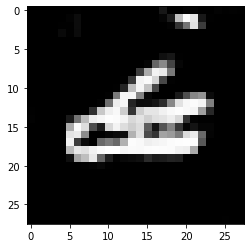

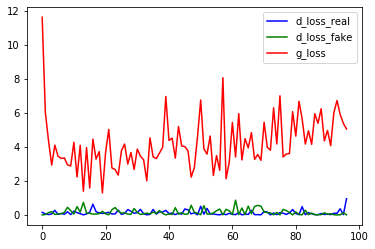

[97/200][0/938] Loss_D: 0.0253 Loss_G: 5.4215 D(x): 0.9817 D(G(z)): 0.0064 / 0.0188
[97/200][100/938] Loss_D: 0.0739 Loss_G: 6.5086 D(x): 0.9376 D(G(z)): 0.0047 / 0.0075
[97/200][200/938] Loss_D: 0.1260 Loss_G: 4.4373 D(x): 0.9921 D(G(z)): 0.0901 / 0.0466
[97/200][300/938] Loss_D: 0.5005 Loss_G: 3.0296 D(x): 0.8120 D(G(z)): 0.1635 / 0.1261
[97/200][400/938] Loss_D: 0.0431 Loss_G: 5.4325 D(x): 0.9959 D(G(z)): 0.0331 / 0.0275
[97/200][500/938] Loss_D: 0.0151 Loss_G: 7.2146 D(x): 0.9888 D(G(z)): 0.0032 / 0.0057
[97/200][600/938] Loss_D: 0.1151 Loss_G: 4.5651 D(x): 0.9555 D(G(z)): 0.0505 / 0.0498
[97/200][700/938] Loss_D: 0.1902 Loss_G: 3.6411 D(x): 0.9591 D(G(z)): 0.1080 / 0.0894
[97/200][800/938] Loss_D: 0.1294 Loss_G: 4.5698 D(x): 0.9507 D(G(z)): 0.0544 / 0.0404
[97/200][900/938] Loss_D: 0.1366 Loss_G: 4.1239 D(x): 0.9588 D(G(z)): 0.0621 / 0.0669


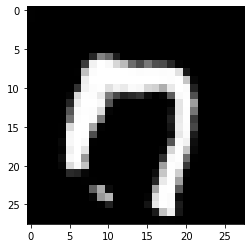

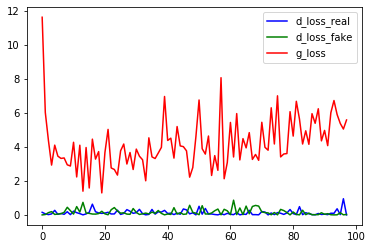

[98/200][0/938] Loss_D: 0.2936 Loss_G: 4.0087 D(x): 0.9740 D(G(z)): 0.1669 / 0.0600
[98/200][100/938] Loss_D: 0.1017 Loss_G: 5.0668 D(x): 0.9739 D(G(z)): 0.0573 / 0.0324
[98/200][200/938] Loss_D: 0.0814 Loss_G: 7.0240 D(x): 0.9398 D(G(z)): 0.0071 / 0.0046
[98/200][300/938] Loss_D: 0.3504 Loss_G: 2.9268 D(x): 0.8207 D(G(z)): 0.0781 / 0.1368
[98/200][400/938] Loss_D: 0.1363 Loss_G: 4.4868 D(x): 0.9775 D(G(z)): 0.0955 / 0.0414
[98/200][500/938] Loss_D: 0.0439 Loss_G: 5.8883 D(x): 0.9744 D(G(z)): 0.0156 / 0.0158
[98/200][600/938] Loss_D: 0.0488 Loss_G: 4.1577 D(x): 0.9872 D(G(z)): 0.0334 / 0.0443
[98/200][700/938] Loss_D: 0.1096 Loss_G: 4.0848 D(x): 0.9860 D(G(z)): 0.0786 / 0.0838
[98/200][800/938] Loss_D: 0.3039 Loss_G: 4.6183 D(x): 0.8509 D(G(z)): 0.0831 / 0.0634
[98/200][900/938] Loss_D: 0.1878 Loss_G: 4.0320 D(x): 0.9688 D(G(z)): 0.1077 / 0.0668


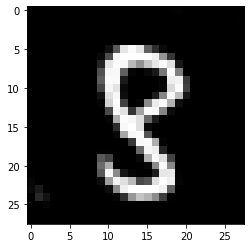

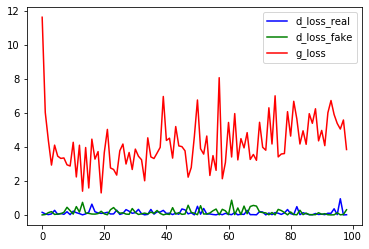

[99/200][0/938] Loss_D: 0.1992 Loss_G: 5.4508 D(x): 0.9549 D(G(z)): 0.0936 / 0.0327
[99/200][100/938] Loss_D: 0.2286 Loss_G: 5.7713 D(x): 0.8599 D(G(z)): 0.0287 / 0.0241
[99/200][200/938] Loss_D: 0.0193 Loss_G: 6.8712 D(x): 0.9892 D(G(z)): 0.0078 / 0.0082
[99/200][300/938] Loss_D: 0.1274 Loss_G: 6.4214 D(x): 0.9038 D(G(z)): 0.0148 / 0.0131
[99/200][400/938] Loss_D: 0.0822 Loss_G: 8.3515 D(x): 0.9378 D(G(z)): 0.0073 / 0.0022
[99/200][500/938] Loss_D: 0.3290 Loss_G: 3.5106 D(x): 0.9800 D(G(z)): 0.2006 / 0.0940
[99/200][600/938] Loss_D: 0.0680 Loss_G: 4.9823 D(x): 0.9649 D(G(z)): 0.0286 / 0.0253
[99/200][700/938] Loss_D: 0.0726 Loss_G: 5.4935 D(x): 0.9513 D(G(z)): 0.0183 / 0.0181
[99/200][800/938] Loss_D: 0.2219 Loss_G: 3.5707 D(x): 0.9857 D(G(z)): 0.1458 / 0.0969
[99/200][900/938] Loss_D: 0.7294 Loss_G: 2.7611 D(x): 0.9994 D(G(z)): 0.3994 / 0.1368


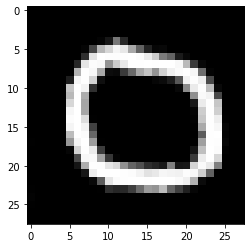

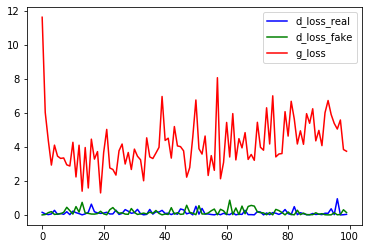

[100/200][0/938] Loss_D: 1.1038 Loss_G: 3.0416 D(x): 0.9993 D(G(z)): 0.4696 / 0.1564
[100/200][100/938] Loss_D: 0.6006 Loss_G: 2.6479 D(x): 0.9618 D(G(z)): 0.3252 / 0.1687
[100/200][200/938] Loss_D: 0.2131 Loss_G: 3.7143 D(x): 0.9970 D(G(z)): 0.1520 / 0.1035
[100/200][300/938] Loss_D: 0.2059 Loss_G: 6.2875 D(x): 0.8496 D(G(z)): 0.0083 / 0.0131
[100/200][400/938] Loss_D: 0.0846 Loss_G: 4.8743 D(x): 0.9564 D(G(z)): 0.0355 / 0.0201
[100/200][500/938] Loss_D: 0.0482 Loss_G: 5.9989 D(x): 0.9766 D(G(z)): 0.0218 / 0.0102
[100/200][600/938] Loss_D: 0.1598 Loss_G: 3.3857 D(x): 0.9763 D(G(z)): 0.1080 / 0.0970
[100/200][700/938] Loss_D: 0.0409 Loss_G: 6.0190 D(x): 0.9829 D(G(z)): 0.0183 / 0.0181
[100/200][800/938] Loss_D: 0.0769 Loss_G: 6.9430 D(x): 0.9309 D(G(z)): 0.0018 / 0.0035
[100/200][900/938] Loss_D: 0.0538 Loss_G: 6.0199 D(x): 0.9582 D(G(z)): 0.0073 / 0.0173


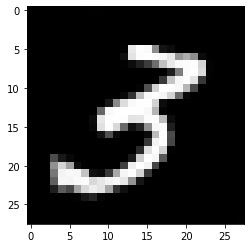

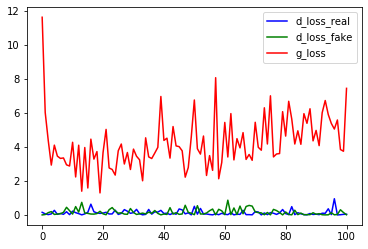

[101/200][0/938] Loss_D: 0.2148 Loss_G: 7.7185 D(x): 0.8399 D(G(z)): 0.0050 / 0.0032
[101/200][100/938] Loss_D: 0.1210 Loss_G: 4.3917 D(x): 0.9374 D(G(z)): 0.0467 / 0.0443
[101/200][200/938] Loss_D: 0.0580 Loss_G: 6.6129 D(x): 0.9860 D(G(z)): 0.0328 / 0.0115
[101/200][300/938] Loss_D: 0.0840 Loss_G: 6.1372 D(x): 0.9577 D(G(z)): 0.0340 / 0.0116
[101/200][400/938] Loss_D: 0.0095 Loss_G: 7.2255 D(x): 0.9939 D(G(z)): 0.0033 / 0.0036
[101/200][500/938] Loss_D: 0.2188 Loss_G: 3.7506 D(x): 0.9168 D(G(z)): 0.0914 / 0.0782
[101/200][600/938] Loss_D: 0.0602 Loss_G: 4.7998 D(x): 0.9676 D(G(z)): 0.0227 / 0.0233
[101/200][700/938] Loss_D: 0.1677 Loss_G: 5.2124 D(x): 0.9029 D(G(z)): 0.0231 / 0.0221
[101/200][800/938] Loss_D: 0.0726 Loss_G: 6.6028 D(x): 0.9560 D(G(z)): 0.0163 / 0.0125
[101/200][900/938] Loss_D: 0.0630 Loss_G: 8.3875 D(x): 0.9492 D(G(z)): 0.0033 / 0.0013


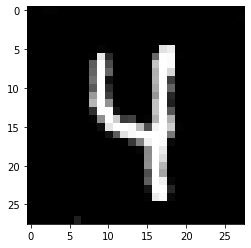

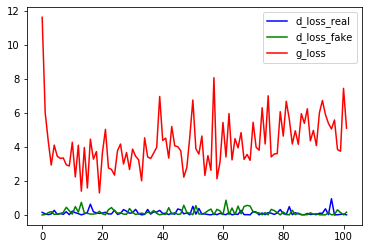

[102/200][0/938] Loss_D: 0.2489 Loss_G: 5.9008 D(x): 0.8261 D(G(z)): 0.0217 / 0.0138
[102/200][100/938] Loss_D: 1.4709 Loss_G: 7.5069 D(x): 0.4098 D(G(z)): 0.0025 / 0.0046
[102/200][200/938] Loss_D: 0.2493 Loss_G: 2.5011 D(x): 0.9830 D(G(z)): 0.1662 / 0.2513
[102/200][300/938] Loss_D: 0.0698 Loss_G: 6.7589 D(x): 0.9465 D(G(z)): 0.0103 / 0.0056
[102/200][400/938] Loss_D: 0.1167 Loss_G: 7.2244 D(x): 0.9055 D(G(z)): 0.0042 / 0.0048
[102/200][500/938] Loss_D: 0.1811 Loss_G: 3.7808 D(x): 0.9917 D(G(z)): 0.1287 / 0.0881
[102/200][600/938] Loss_D: 0.0498 Loss_G: 5.2085 D(x): 0.9746 D(G(z)): 0.0205 / 0.0245
[102/200][700/938] Loss_D: 0.3240 Loss_G: 5.2586 D(x): 0.7765 D(G(z)): 0.0187 / 0.0278
[102/200][800/938] Loss_D: 0.7882 Loss_G: 1.9864 D(x): 0.9994 D(G(z)): 0.4044 / 0.2865
[102/200][900/938] Loss_D: 0.2681 Loss_G: 3.3383 D(x): 0.9962 D(G(z)): 0.1722 / 0.1101


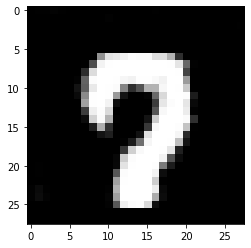

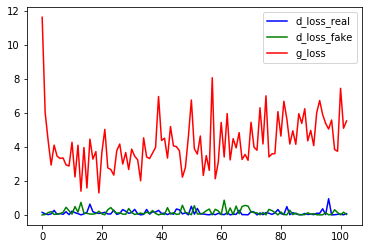

[103/200][0/938] Loss_D: 0.0945 Loss_G: 5.2813 D(x): 0.9533 D(G(z)): 0.0381 / 0.0223
[103/200][100/938] Loss_D: 0.1131 Loss_G: 3.4812 D(x): 0.9877 D(G(z)): 0.0848 / 0.0935
[103/200][200/938] Loss_D: 0.1663 Loss_G: 4.3984 D(x): 0.9586 D(G(z)): 0.0922 / 0.0512
[103/200][300/938] Loss_D: 0.0616 Loss_G: 5.3459 D(x): 0.9775 D(G(z)): 0.0347 / 0.0259
[103/200][400/938] Loss_D: 0.0776 Loss_G: 3.9803 D(x): 0.9884 D(G(z)): 0.0585 / 0.0574
[103/200][500/938] Loss_D: 0.1917 Loss_G: 3.7536 D(x): 0.9734 D(G(z)): 0.1211 / 0.0624
[103/200][600/938] Loss_D: 0.5906 Loss_G: 4.7502 D(x): 0.6875 D(G(z)): 0.0484 / 0.0557
[103/200][700/938] Loss_D: 0.5004 Loss_G: 3.5682 D(x): 0.6920 D(G(z)): 0.0230 / 0.1127
[103/200][800/938] Loss_D: 0.0375 Loss_G: 6.0879 D(x): 0.9798 D(G(z)): 0.0147 / 0.0161
[103/200][900/938] Loss_D: 0.2170 Loss_G: 5.3966 D(x): 0.8480 D(G(z)): 0.0230 / 0.0226


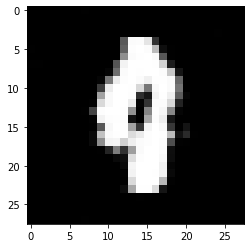

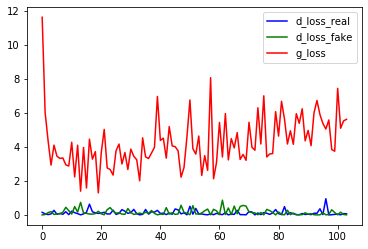

[104/200][0/938] Loss_D: 0.0670 Loss_G: 4.3103 D(x): 0.9703 D(G(z)): 0.0311 / 0.0500
[104/200][100/938] Loss_D: 0.0785 Loss_G: 5.2361 D(x): 0.9555 D(G(z)): 0.0284 / 0.0163
[104/200][200/938] Loss_D: 0.1443 Loss_G: 4.3741 D(x): 0.9767 D(G(z)): 0.0906 / 0.0479
[104/200][300/938] Loss_D: 0.0565 Loss_G: 5.2283 D(x): 0.9751 D(G(z)): 0.0272 / 0.0270
[104/200][400/938] Loss_D: 0.1699 Loss_G: 3.0685 D(x): 0.9856 D(G(z)): 0.1143 / 0.1769
[104/200][500/938] Loss_D: 0.3140 Loss_G: 4.6031 D(x): 0.9128 D(G(z)): 0.1349 / 0.0418
[104/200][600/938] Loss_D: 0.0512 Loss_G: 5.3931 D(x): 0.9921 D(G(z)): 0.0370 / 0.0286
[104/200][700/938] Loss_D: 0.1507 Loss_G: 6.2170 D(x): 0.8812 D(G(z)): 0.0076 / 0.0108
[104/200][800/938] Loss_D: 0.3129 Loss_G: 4.7159 D(x): 0.9408 D(G(z)): 0.1832 / 0.0321
[104/200][900/938] Loss_D: 0.2363 Loss_G: 4.1297 D(x): 0.9672 D(G(z)): 0.1304 / 0.0638


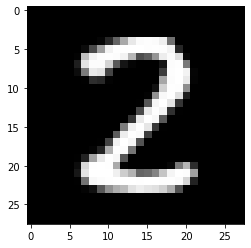

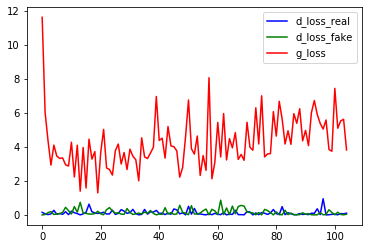

[105/200][0/938] Loss_D: 0.1448 Loss_G: 3.4680 D(x): 0.9808 D(G(z)): 0.1045 / 0.1001
[105/200][100/938] Loss_D: 0.0354 Loss_G: 5.0126 D(x): 0.9904 D(G(z)): 0.0211 / 0.0241
[105/200][200/938] Loss_D: 0.0276 Loss_G: 5.2283 D(x): 0.9969 D(G(z)): 0.0232 / 0.0271
[105/200][300/938] Loss_D: 0.0276 Loss_G: 6.8468 D(x): 0.9845 D(G(z)): 0.0107 / 0.0060
[105/200][400/938] Loss_D: 0.0320 Loss_G: 6.4214 D(x): 0.9747 D(G(z)): 0.0054 / 0.0061
[105/200][500/938] Loss_D: 0.1609 Loss_G: 4.5083 D(x): 0.9646 D(G(z)): 0.0874 / 0.0419
[105/200][600/938] Loss_D: 0.0396 Loss_G: 3.9145 D(x): 0.9957 D(G(z)): 0.0328 / 0.0629
[105/200][700/938] Loss_D: 0.0683 Loss_G: 5.4233 D(x): 0.9862 D(G(z)): 0.0427 / 0.0273
[105/200][800/938] Loss_D: 0.1334 Loss_G: 6.0813 D(x): 0.9107 D(G(z)): 0.0130 / 0.0189
[105/200][900/938] Loss_D: 0.0887 Loss_G: 4.7220 D(x): 0.9963 D(G(z)): 0.0729 / 0.0376


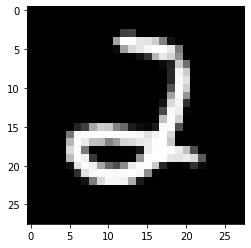

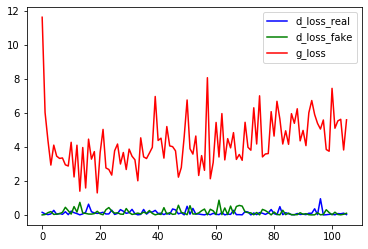

[106/200][0/938] Loss_D: 0.1434 Loss_G: 4.5784 D(x): 0.9847 D(G(z)): 0.0949 / 0.0461
[106/200][100/938] Loss_D: 0.0933 Loss_G: 8.1096 D(x): 0.9315 D(G(z)): 0.0122 / 0.0019
[106/200][200/938] Loss_D: 0.3452 Loss_G: 4.0760 D(x): 0.8497 D(G(z)): 0.1028 / 0.0861
[106/200][300/938] Loss_D: 0.2241 Loss_G: 5.7074 D(x): 0.8731 D(G(z)): 0.0389 / 0.0251
[106/200][400/938] Loss_D: 0.1060 Loss_G: 5.4880 D(x): 0.9502 D(G(z)): 0.0456 / 0.0174
[106/200][500/938] Loss_D: 0.1230 Loss_G: 5.0578 D(x): 0.9238 D(G(z)): 0.0330 / 0.0287
[106/200][600/938] Loss_D: 0.0995 Loss_G: 5.3293 D(x): 0.9427 D(G(z)): 0.0300 / 0.0224
[106/200][700/938] Loss_D: 0.1417 Loss_G: 6.9603 D(x): 0.8991 D(G(z)): 0.0029 / 0.0047
[106/200][800/938] Loss_D: 0.0309 Loss_G: 6.9983 D(x): 0.9752 D(G(z)): 0.0051 / 0.0045
[106/200][900/938] Loss_D: 0.0342 Loss_G: 6.0098 D(x): 0.9887 D(G(z)): 0.0194 / 0.0186


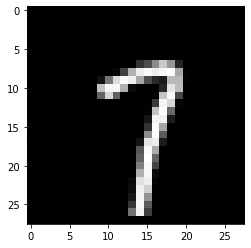

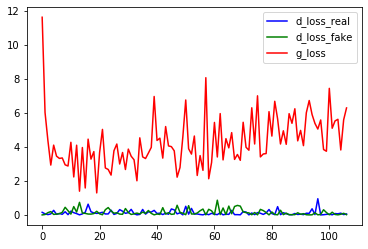

[107/200][0/938] Loss_D: 0.0102 Loss_G: 8.9118 D(x): 0.9915 D(G(z)): 0.0016 / 0.0010
[107/200][100/938] Loss_D: 0.1602 Loss_G: 8.2208 D(x): 0.8784 D(G(z)): 0.0034 / 0.0019
[107/200][200/938] Loss_D: 0.1641 Loss_G: 4.6157 D(x): 0.9789 D(G(z)): 0.1084 / 0.0495
[107/200][300/938] Loss_D: 0.1670 Loss_G: 5.3999 D(x): 0.9872 D(G(z)): 0.1055 / 0.0245
[107/200][400/938] Loss_D: 0.0558 Loss_G: 4.9559 D(x): 0.9736 D(G(z)): 0.0260 / 0.0337
[107/200][500/938] Loss_D: 0.3599 Loss_G: 5.0119 D(x): 0.7625 D(G(z)): 0.0105 / 0.0271
[107/200][600/938] Loss_D: 0.0642 Loss_G: 4.7650 D(x): 0.9943 D(G(z)): 0.0487 / 0.0488
[107/200][700/938] Loss_D: 0.0787 Loss_G: 5.0911 D(x): 0.9535 D(G(z)): 0.0228 / 0.0426
[107/200][800/938] Loss_D: 0.0916 Loss_G: 5.6209 D(x): 0.9350 D(G(z)): 0.0156 / 0.0143
[107/200][900/938] Loss_D: 0.7706 Loss_G: 2.1941 D(x): 0.6580 D(G(z)): 0.1102 / 0.3036


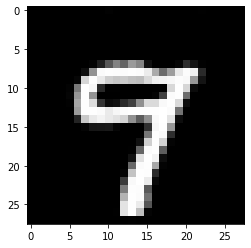

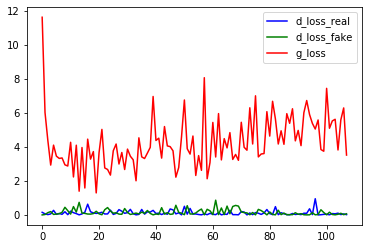

[108/200][0/938] Loss_D: 0.2081 Loss_G: 3.3681 D(x): 0.9952 D(G(z)): 0.1209 / 0.1059
[108/200][100/938] Loss_D: 0.0303 Loss_G: 6.2284 D(x): 0.9973 D(G(z)): 0.0257 / 0.0109
[108/200][200/938] Loss_D: 0.0690 Loss_G: 5.3488 D(x): 0.9862 D(G(z)): 0.0417 / 0.0295
[108/200][300/938] Loss_D: 0.0877 Loss_G: 7.9826 D(x): 0.9319 D(G(z)): 0.0041 / 0.0031
[108/200][400/938] Loss_D: 0.2093 Loss_G: 4.4830 D(x): 0.8794 D(G(z)): 0.0490 / 0.0525
[108/200][500/938] Loss_D: 0.0493 Loss_G: 5.8066 D(x): 0.9860 D(G(z)): 0.0290 / 0.0180
[108/200][600/938] Loss_D: 0.1530 Loss_G: 5.1523 D(x): 0.9256 D(G(z)): 0.0377 / 0.0260
[108/200][700/938] Loss_D: 0.0611 Loss_G: 6.7367 D(x): 0.9649 D(G(z)): 0.0167 / 0.0088
[108/200][800/938] Loss_D: 0.1550 Loss_G: 4.3455 D(x): 0.9898 D(G(z)): 0.0981 / 0.0490
[108/200][900/938] Loss_D: 0.0238 Loss_G: 5.6388 D(x): 0.9928 D(G(z)): 0.0150 / 0.0170


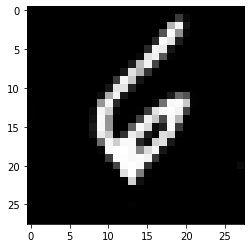

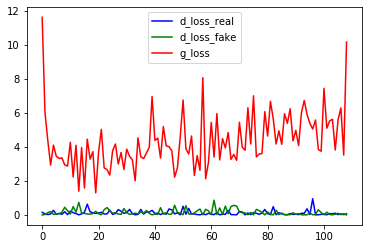

[109/200][0/938] Loss_D: 1.0260 Loss_G: 9.1776 D(x): 0.5381 D(G(z)): 0.0004 / 0.0011
[109/200][100/938] Loss_D: 0.2095 Loss_G: 4.0809 D(x): 0.8838 D(G(z)): 0.0487 / 0.0685
[109/200][200/938] Loss_D: 0.2335 Loss_G: 6.1584 D(x): 0.8454 D(G(z)): 0.0182 / 0.0117
[109/200][300/938] Loss_D: 0.5704 Loss_G: 6.5070 D(x): 0.6706 D(G(z)): 0.0196 / 0.0164
[109/200][400/938] Loss_D: 0.0857 Loss_G: 6.6336 D(x): 0.9329 D(G(z)): 0.0025 / 0.0056
[109/200][500/938] Loss_D: 0.1511 Loss_G: 4.1292 D(x): 0.9951 D(G(z)): 0.1095 / 0.0534
[109/200][600/938] Loss_D: 0.1544 Loss_G: 7.4531 D(x): 0.9037 D(G(z)): 0.0275 / 0.0050
[109/200][700/938] Loss_D: 0.0649 Loss_G: 5.8226 D(x): 0.9643 D(G(z)): 0.0238 / 0.0217
[109/200][800/938] Loss_D: 0.1159 Loss_G: 5.0417 D(x): 0.9936 D(G(z)): 0.0837 / 0.0278
[109/200][900/938] Loss_D: 0.1576 Loss_G: 3.8525 D(x): 0.9909 D(G(z)): 0.1137 / 0.1052


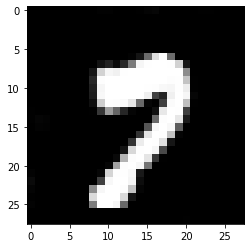

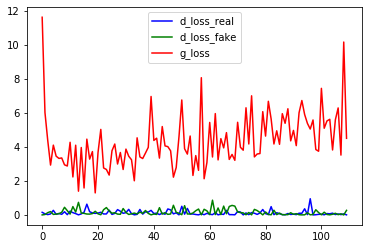

[110/200][0/938] Loss_D: 0.0874 Loss_G: 6.1233 D(x): 0.9390 D(G(z)): 0.0192 / 0.0075
[110/200][100/938] Loss_D: 0.1809 Loss_G: 6.3151 D(x): 0.8706 D(G(z)): 0.0123 / 0.0097
[110/200][200/938] Loss_D: 0.1204 Loss_G: 4.3598 D(x): 0.9879 D(G(z)): 0.0890 / 0.0459
[110/200][300/938] Loss_D: 0.0964 Loss_G: 5.5994 D(x): 0.9342 D(G(z)): 0.0215 / 0.0221
[110/200][400/938] Loss_D: 0.1696 Loss_G: 4.6838 D(x): 0.9838 D(G(z)): 0.0954 / 0.0546
[110/200][500/938] Loss_D: 0.0962 Loss_G: 4.6659 D(x): 0.9528 D(G(z)): 0.0393 / 0.0537
[110/200][600/938] Loss_D: 0.0387 Loss_G: 7.2306 D(x): 0.9695 D(G(z)): 0.0053 / 0.0053
[110/200][700/938] Loss_D: 0.0511 Loss_G: 5.2233 D(x): 0.9966 D(G(z)): 0.0409 / 0.0217
[110/200][800/938] Loss_D: 0.1317 Loss_G: 5.1881 D(x): 0.9310 D(G(z)): 0.0400 / 0.0419
[110/200][900/938] Loss_D: 0.0392 Loss_G: 5.1968 D(x): 0.9924 D(G(z)): 0.0281 / 0.0254


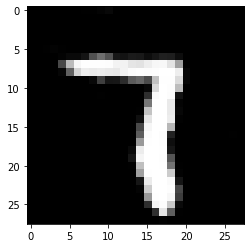

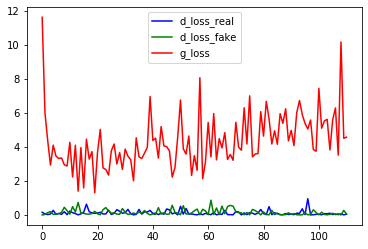

[111/200][0/938] Loss_D: 0.3325 Loss_G: 3.7584 D(x): 0.8724 D(G(z)): 0.1307 / 0.0699
[111/200][100/938] Loss_D: 0.4962 Loss_G: 3.3637 D(x): 0.9956 D(G(z)): 0.3207 / 0.0794
[111/200][200/938] Loss_D: 0.1639 Loss_G: 5.5070 D(x): 0.8804 D(G(z)): 0.0145 / 0.0293
[111/200][300/938] Loss_D: 0.0728 Loss_G: 4.9202 D(x): 0.9910 D(G(z)): 0.0530 / 0.0439
[111/200][400/938] Loss_D: 0.1570 Loss_G: 4.2379 D(x): 0.9891 D(G(z)): 0.1071 / 0.0575
[111/200][500/938] Loss_D: 0.0433 Loss_G: 5.9318 D(x): 0.9932 D(G(z)): 0.0343 / 0.0108
[111/200][600/938] Loss_D: 0.0861 Loss_G: 6.8496 D(x): 0.9439 D(G(z)): 0.0221 / 0.0072
[111/200][700/938] Loss_D: 0.3682 Loss_G: 3.5743 D(x): 0.9734 D(G(z)): 0.1921 / 0.1158
[111/200][800/938] Loss_D: 0.1531 Loss_G: 6.4724 D(x): 0.9095 D(G(z)): 0.0371 / 0.0106
[111/200][900/938] Loss_D: 0.2142 Loss_G: 4.5428 D(x): 0.9323 D(G(z)): 0.0733 / 0.0558


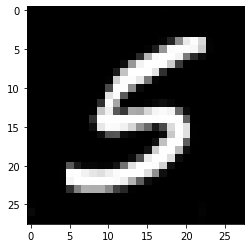

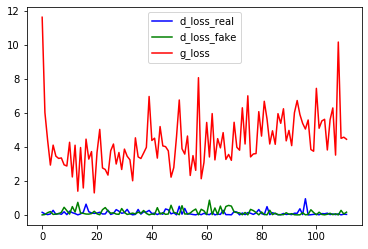

[112/200][0/938] Loss_D: 0.3240 Loss_G: 3.7732 D(x): 0.9912 D(G(z)): 0.1763 / 0.1020
[112/200][100/938] Loss_D: 0.1424 Loss_G: 5.3547 D(x): 0.9227 D(G(z)): 0.0395 / 0.0216
[112/200][200/938] Loss_D: 0.2210 Loss_G: 3.4904 D(x): 0.8760 D(G(z)): 0.0519 / 0.1170
[112/200][300/938] Loss_D: 0.0061 Loss_G: 7.3664 D(x): 0.9957 D(G(z)): 0.0017 / 0.0037
[112/200][400/938] Loss_D: 0.1141 Loss_G: 4.5263 D(x): 0.9491 D(G(z)): 0.0364 / 0.0353
[112/200][500/938] Loss_D: 0.1213 Loss_G: 4.6860 D(x): 0.9854 D(G(z)): 0.0783 / 0.0381
[112/200][600/938] Loss_D: 0.0475 Loss_G: 6.4146 D(x): 0.9637 D(G(z)): 0.0084 / 0.0082
[112/200][700/938] Loss_D: 0.1069 Loss_G: 6.9220 D(x): 0.9421 D(G(z)): 0.0301 / 0.0168
[112/200][800/938] Loss_D: 0.5524 Loss_G: 6.5368 D(x): 0.6561 D(G(z)): 0.0046 / 0.0066
[112/200][900/938] Loss_D: 0.3080 Loss_G: 4.0002 D(x): 0.9958 D(G(z)): 0.1958 / 0.0648


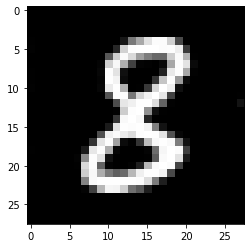

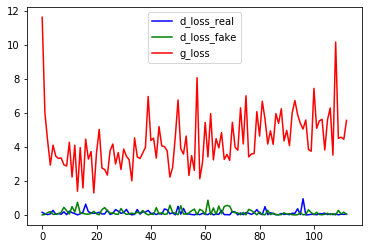

[113/200][0/938] Loss_D: 0.0081 Loss_G: 7.7946 D(x): 0.9950 D(G(z)): 0.0029 / 0.0023
[113/200][100/938] Loss_D: 0.1697 Loss_G: 8.0796 D(x): 0.8702 D(G(z)): 0.0012 / 0.0026
[113/200][200/938] Loss_D: 0.0782 Loss_G: 3.4863 D(x): 0.9984 D(G(z)): 0.0654 / 0.0957
[113/200][300/938] Loss_D: 0.1070 Loss_G: 5.3132 D(x): 0.9978 D(G(z)): 0.0858 / 0.0216
[113/200][400/938] Loss_D: 0.0445 Loss_G: 6.0782 D(x): 0.9912 D(G(z)): 0.0293 / 0.0273
[113/200][500/938] Loss_D: 0.0446 Loss_G: 7.0400 D(x): 0.9775 D(G(z)): 0.0172 / 0.0071
[113/200][600/938] Loss_D: 0.0811 Loss_G: 5.9775 D(x): 0.9510 D(G(z)): 0.0218 / 0.0147
[113/200][700/938] Loss_D: 0.2103 Loss_G: 4.5821 D(x): 0.8809 D(G(z)): 0.0395 / 0.0531
[113/200][800/938] Loss_D: 0.1756 Loss_G: 4.8073 D(x): 0.9468 D(G(z)): 0.0884 / 0.0460
[113/200][900/938] Loss_D: 0.2363 Loss_G: 3.2789 D(x): 0.9858 D(G(z)): 0.1520 / 0.1122


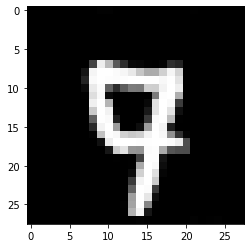

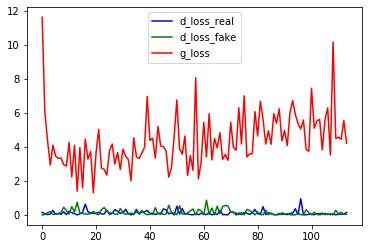

[114/200][0/938] Loss_D: 0.0294 Loss_G: 7.3757 D(x): 0.9749 D(G(z)): 0.0033 / 0.0046
[114/200][100/938] Loss_D: 0.2062 Loss_G: 4.6007 D(x): 0.8978 D(G(z)): 0.0554 / 0.0429
[114/200][200/938] Loss_D: 0.0530 Loss_G: 4.8080 D(x): 0.9934 D(G(z)): 0.0405 / 0.0363
[114/200][300/938] Loss_D: 0.1427 Loss_G: 4.0271 D(x): 0.9662 D(G(z)): 0.0839 / 0.0689
[114/200][400/938] Loss_D: 0.1105 Loss_G: 3.8856 D(x): 0.9965 D(G(z)): 0.0870 / 0.0711
[114/200][500/938] Loss_D: 0.0540 Loss_G: 5.2088 D(x): 0.9846 D(G(z)): 0.0342 / 0.0221
[114/200][600/938] Loss_D: 0.0735 Loss_G: 9.1535 D(x): 0.9356 D(G(z)): 0.0016 / 0.0010
[114/200][700/938] Loss_D: 0.1036 Loss_G: 4.8257 D(x): 0.9832 D(G(z)): 0.0645 / 0.0438
[114/200][800/938] Loss_D: 0.1544 Loss_G: 5.5366 D(x): 0.8949 D(G(z)): 0.0244 / 0.0271
[114/200][900/938] Loss_D: 0.0080 Loss_G: 7.5530 D(x): 0.9960 D(G(z)): 0.0038 / 0.0031


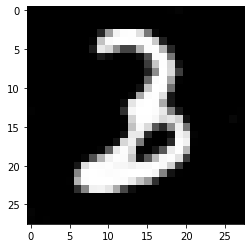

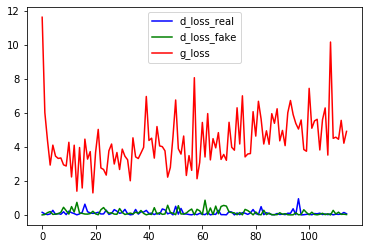

[115/200][0/938] Loss_D: 0.0539 Loss_G: 4.7495 D(x): 0.9929 D(G(z)): 0.0436 / 0.0400
[115/200][100/938] Loss_D: 0.1365 Loss_G: 5.7679 D(x): 0.9091 D(G(z)): 0.0218 / 0.0137
[115/200][200/938] Loss_D: 0.2038 Loss_G: 4.6845 D(x): 0.9698 D(G(z)): 0.1209 / 0.0599
[115/200][300/938] Loss_D: 0.2481 Loss_G: 3.3002 D(x): 0.9941 D(G(z)): 0.1499 / 0.1352
[115/200][400/938] Loss_D: 0.0793 Loss_G: 6.3299 D(x): 0.9534 D(G(z)): 0.0274 / 0.0091
[115/200][500/938] Loss_D: 0.1446 Loss_G: 4.9344 D(x): 0.8940 D(G(z)): 0.0230 / 0.0376
[115/200][600/938] Loss_D: 0.2344 Loss_G: 3.3278 D(x): 0.9860 D(G(z)): 0.1488 / 0.1214
[115/200][700/938] Loss_D: 0.1412 Loss_G: 7.6070 D(x): 0.8876 D(G(z)): 0.0026 / 0.0030
[115/200][800/938] Loss_D: 0.1202 Loss_G: 3.4824 D(x): 0.9808 D(G(z)): 0.0861 / 0.0962
[115/200][900/938] Loss_D: 0.0916 Loss_G: 6.7153 D(x): 0.9321 D(G(z)): 0.0084 / 0.0051


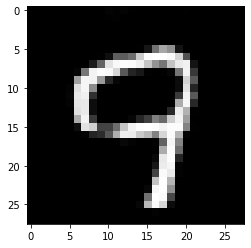

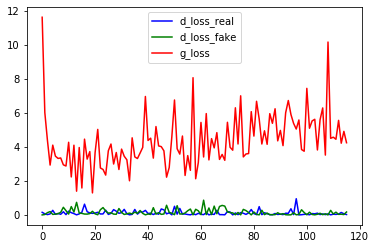

[116/200][0/938] Loss_D: 0.0242 Loss_G: 6.5009 D(x): 0.9927 D(G(z)): 0.0151 / 0.0092
[116/200][100/938] Loss_D: 0.4318 Loss_G: 8.4740 D(x): 0.7201 D(G(z)): 0.0010 / 0.0016
[116/200][200/938] Loss_D: 0.0792 Loss_G: 5.2148 D(x): 0.9757 D(G(z)): 0.0427 / 0.0315
[116/200][300/938] Loss_D: 0.1778 Loss_G: 5.8916 D(x): 0.8841 D(G(z)): 0.0230 / 0.0213
[116/200][400/938] Loss_D: 0.0759 Loss_G: 6.5806 D(x): 0.9405 D(G(z)): 0.0066 / 0.0056
[116/200][500/938] Loss_D: 0.1592 Loss_G: 4.0710 D(x): 0.9845 D(G(z)): 0.1077 / 0.0640
[116/200][600/938] Loss_D: 0.0919 Loss_G: 6.2610 D(x): 0.9580 D(G(z)): 0.0356 / 0.0148
[116/200][700/938] Loss_D: 0.1495 Loss_G: 5.1691 D(x): 0.9001 D(G(z)): 0.0258 / 0.0458
[116/200][800/938] Loss_D: 0.3691 Loss_G: 4.1966 D(x): 0.9869 D(G(z)): 0.2140 / 0.0812
[116/200][900/938] Loss_D: 0.2817 Loss_G: 4.0733 D(x): 0.9975 D(G(z)): 0.1684 / 0.0780


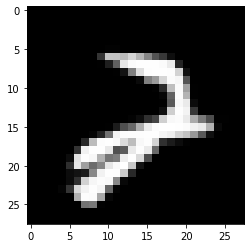

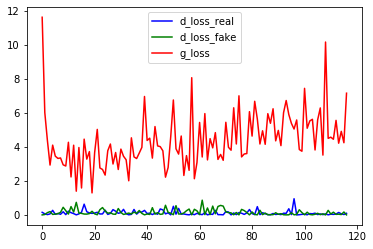

[117/200][0/938] Loss_D: 0.2703 Loss_G: 2.4784 D(x): 0.9668 D(G(z)): 0.1537 / 0.2055
[117/200][100/938] Loss_D: 0.2857 Loss_G: 3.5932 D(x): 0.9842 D(G(z)): 0.1993 / 0.0835
[117/200][200/938] Loss_D: 0.0261 Loss_G: 7.8523 D(x): 0.9773 D(G(z)): 0.0021 / 0.0027
[117/200][300/938] Loss_D: 0.1179 Loss_G: 5.0865 D(x): 0.9854 D(G(z)): 0.0812 / 0.0327
[117/200][400/938] Loss_D: 0.1542 Loss_G: 8.8273 D(x): 0.8862 D(G(z)): 0.0004 / 0.0008
[117/200][500/938] Loss_D: 0.0778 Loss_G: 5.8795 D(x): 0.9359 D(G(z)): 0.0053 / 0.0134
[117/200][600/938] Loss_D: 0.0708 Loss_G: 4.3880 D(x): 0.9655 D(G(z)): 0.0313 / 0.0421
[117/200][700/938] Loss_D: 0.3650 Loss_G: 5.4693 D(x): 0.7677 D(G(z)): 0.0171 / 0.0440
[117/200][800/938] Loss_D: 0.0502 Loss_G: 5.5404 D(x): 0.9717 D(G(z)): 0.0187 / 0.0148
[117/200][900/938] Loss_D: 0.2304 Loss_G: 4.4484 D(x): 0.9523 D(G(z)): 0.1157 / 0.0489


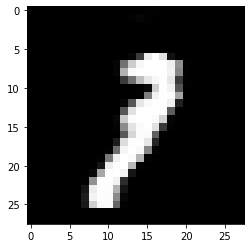

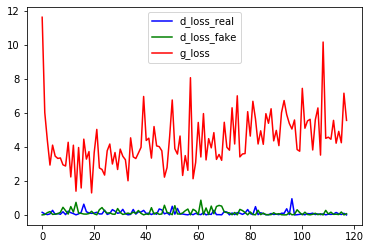

[118/200][0/938] Loss_D: 0.0435 Loss_G: 6.3128 D(x): 0.9756 D(G(z)): 0.0166 / 0.0082
[118/200][100/938] Loss_D: 0.0748 Loss_G: 5.4628 D(x): 0.9690 D(G(z)): 0.0324 / 0.0306
[118/200][200/938] Loss_D: 0.3717 Loss_G: 7.2977 D(x): 0.7579 D(G(z)): 0.0025 / 0.0050
[118/200][300/938] Loss_D: 0.5184 Loss_G: 4.5094 D(x): 0.9980 D(G(z)): 0.2519 / 0.0655
[118/200][400/938] Loss_D: 0.0557 Loss_G: 7.5382 D(x): 0.9878 D(G(z)): 0.0355 / 0.0068
[118/200][500/938] Loss_D: 0.0734 Loss_G: 5.7844 D(x): 0.9727 D(G(z)): 0.0390 / 0.0210
[118/200][600/938] Loss_D: 0.0423 Loss_G: 5.5472 D(x): 0.9784 D(G(z)): 0.0176 / 0.0267
[118/200][700/938] Loss_D: 0.0433 Loss_G: 5.1603 D(x): 0.9913 D(G(z)): 0.0322 / 0.0264
[118/200][800/938] Loss_D: 0.1993 Loss_G: 3.9879 D(x): 0.9954 D(G(z)): 0.1356 / 0.0698
[118/200][900/938] Loss_D: 0.1137 Loss_G: 7.4431 D(x): 0.9045 D(G(z)): 0.0022 / 0.0027


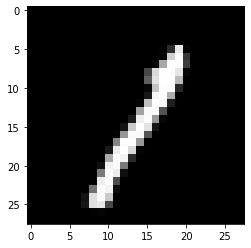

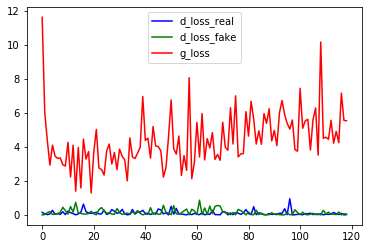

[119/200][0/938] Loss_D: 0.0685 Loss_G: 5.1406 D(x): 0.9707 D(G(z)): 0.0345 / 0.0188
[119/200][100/938] Loss_D: 0.2046 Loss_G: 3.8712 D(x): 0.9871 D(G(z)): 0.1393 / 0.0857
[119/200][200/938] Loss_D: 0.0288 Loss_G: 5.7006 D(x): 0.9894 D(G(z)): 0.0165 / 0.0182
[119/200][300/938] Loss_D: 0.0667 Loss_G: 4.5260 D(x): 0.9842 D(G(z)): 0.0417 / 0.0632
[119/200][400/938] Loss_D: 0.1304 Loss_G: 4.0073 D(x): 0.9921 D(G(z)): 0.0916 / 0.0642
[119/200][500/938] Loss_D: 0.0626 Loss_G: 4.8724 D(x): 0.9826 D(G(z)): 0.0388 / 0.0373
[119/200][600/938] Loss_D: 0.0329 Loss_G: 4.8893 D(x): 0.9786 D(G(z)): 0.0083 / 0.0334
[119/200][700/938] Loss_D: 0.0472 Loss_G: 5.0194 D(x): 0.9825 D(G(z)): 0.0256 / 0.0232
[119/200][800/938] Loss_D: 0.0695 Loss_G: 6.6929 D(x): 0.9897 D(G(z)): 0.0428 / 0.0154
[119/200][900/938] Loss_D: 0.0328 Loss_G: 5.9112 D(x): 0.9714 D(G(z)): 0.0024 / 0.0140


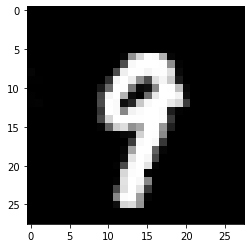

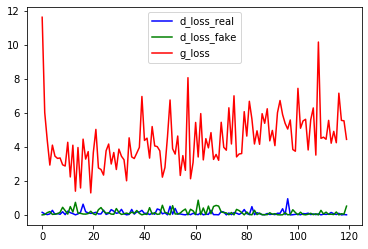

[120/200][0/938] Loss_D: 0.0790 Loss_G: 7.8842 D(x): 0.9380 D(G(z)): 0.0088 / 0.0017
[120/200][100/938] Loss_D: 0.2386 Loss_G: 3.3287 D(x): 0.9890 D(G(z)): 0.1463 / 0.1062
[120/200][200/938] Loss_D: 0.0883 Loss_G: 5.6634 D(x): 0.9440 D(G(z)): 0.0224 / 0.0223
[120/200][300/938] Loss_D: 0.0187 Loss_G: 6.6725 D(x): 0.9910 D(G(z)): 0.0093 / 0.0102
[120/200][400/938] Loss_D: 0.0838 Loss_G: 5.5994 D(x): 0.9362 D(G(z)): 0.0082 / 0.0190
[120/200][500/938] Loss_D: 0.3986 Loss_G: 4.7212 D(x): 0.7570 D(G(z)): 0.0335 / 0.0395
[120/200][600/938] Loss_D: 0.0945 Loss_G: 6.6869 D(x): 0.9302 D(G(z)): 0.0079 / 0.0093
[120/200][700/938] Loss_D: 0.0385 Loss_G: 4.6889 D(x): 0.9922 D(G(z)): 0.0279 / 0.0373
[120/200][800/938] Loss_D: 0.0370 Loss_G: 6.5932 D(x): 0.9760 D(G(z)): 0.0100 / 0.0098
[120/200][900/938] Loss_D: 0.0344 Loss_G: 4.9840 D(x): 0.9864 D(G(z)): 0.0191 / 0.0269


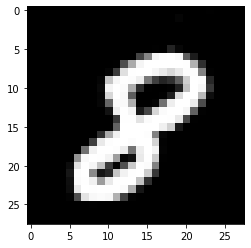

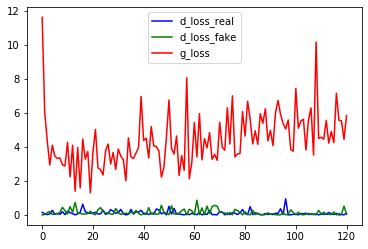

[121/200][0/938] Loss_D: 0.0904 Loss_G: 5.4033 D(x): 0.9512 D(G(z)): 0.0310 / 0.0252
[121/200][100/938] Loss_D: 0.1954 Loss_G: 3.6460 D(x): 0.9897 D(G(z)): 0.1198 / 0.0998
[121/200][200/938] Loss_D: 0.2093 Loss_G: 6.4894 D(x): 0.8522 D(G(z)): 0.0083 / 0.0075
[121/200][300/938] Loss_D: 0.4262 Loss_G: 6.7390 D(x): 0.7207 D(G(z)): 0.0012 / 0.0064
[121/200][400/938] Loss_D: 0.2678 Loss_G: 3.6851 D(x): 0.8901 D(G(z)): 0.0639 / 0.0869
[121/200][500/938] Loss_D: 0.1338 Loss_G: 7.4331 D(x): 0.8886 D(G(z)): 0.0035 / 0.0035
[121/200][600/938] Loss_D: 0.1228 Loss_G: 3.8871 D(x): 0.9740 D(G(z)): 0.0762 / 0.0802
[121/200][700/938] Loss_D: 0.1507 Loss_G: 4.1205 D(x): 0.9922 D(G(z)): 0.0980 / 0.0690
[121/200][800/938] Loss_D: 0.0999 Loss_G: 4.1530 D(x): 0.9880 D(G(z)): 0.0658 / 0.0614
[121/200][900/938] Loss_D: 0.2197 Loss_G: 4.0995 D(x): 0.9798 D(G(z)): 0.1424 / 0.0604


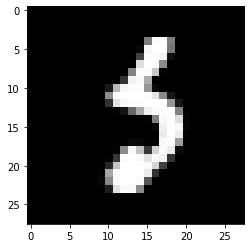

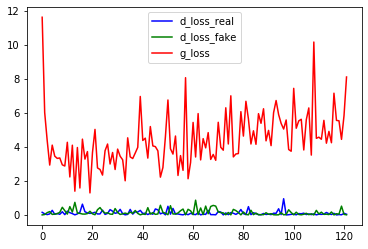

[122/200][0/938] Loss_D: 0.2507 Loss_G: 4.1495 D(x): 0.9501 D(G(z)): 0.1388 / 0.0601
[122/200][100/938] Loss_D: 0.1048 Loss_G: 4.9376 D(x): 0.9929 D(G(z)): 0.0676 / 0.0505
[122/200][200/938] Loss_D: 0.3216 Loss_G: 5.0564 D(x): 0.9901 D(G(z)): 0.1827 / 0.0419
[122/200][300/938] Loss_D: 0.6047 Loss_G: 4.7515 D(x): 0.6415 D(G(z)): 0.0115 / 0.0315
[122/200][400/938] Loss_D: 0.3472 Loss_G: 3.0090 D(x): 0.9970 D(G(z)): 0.2252 / 0.1451
[122/200][500/938] Loss_D: 0.1854 Loss_G: 6.1596 D(x): 0.8736 D(G(z)): 0.0203 / 0.0151
[122/200][600/938] Loss_D: 0.1845 Loss_G: 3.7156 D(x): 0.9976 D(G(z)): 0.1199 / 0.1249
[122/200][700/938] Loss_D: 0.0438 Loss_G: 6.6296 D(x): 0.9732 D(G(z)): 0.0153 / 0.0050
[122/200][800/938] Loss_D: 0.0464 Loss_G: 6.6574 D(x): 0.9624 D(G(z)): 0.0060 / 0.0055
[122/200][900/938] Loss_D: 0.2529 Loss_G: 3.7412 D(x): 0.9896 D(G(z)): 0.1526 / 0.1029


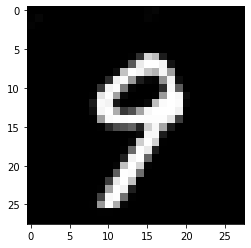

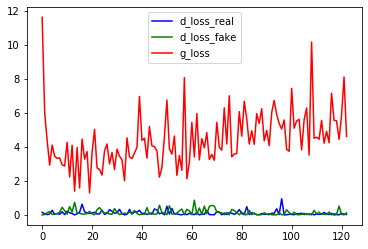

[123/200][0/938] Loss_D: 0.0533 Loss_G: 5.5337 D(x): 0.9838 D(G(z)): 0.0340 / 0.0180
[123/200][100/938] Loss_D: 0.0539 Loss_G: 5.6440 D(x): 0.9872 D(G(z)): 0.0355 / 0.0380
[123/200][200/938] Loss_D: 0.0443 Loss_G: 7.1503 D(x): 0.9776 D(G(z)): 0.0172 / 0.0086
[123/200][300/938] Loss_D: 0.0649 Loss_G: 5.4114 D(x): 0.9707 D(G(z)): 0.0298 / 0.0235
[123/200][400/938] Loss_D: 0.0399 Loss_G: 5.9094 D(x): 0.9766 D(G(z)): 0.0149 / 0.0183
[123/200][500/938] Loss_D: 0.0366 Loss_G: 7.0551 D(x): 0.9925 D(G(z)): 0.0224 / 0.0117
[123/200][600/938] Loss_D: 0.3756 Loss_G: 3.6774 D(x): 0.9877 D(G(z)): 0.1982 / 0.1079
[123/200][700/938] Loss_D: 0.3892 Loss_G: 2.8726 D(x): 0.9906 D(G(z)): 0.2071 / 0.1959
[123/200][800/938] Loss_D: 0.3335 Loss_G: 4.9166 D(x): 0.7814 D(G(z)): 0.0245 / 0.0397
[123/200][900/938] Loss_D: 0.3631 Loss_G: 4.7595 D(x): 0.7668 D(G(z)): 0.0151 / 0.0359


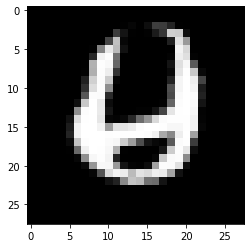

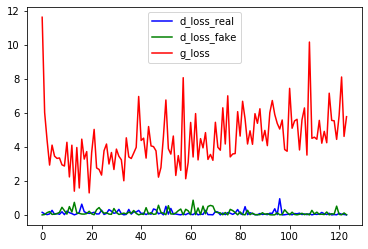

[124/200][0/938] Loss_D: 0.1623 Loss_G: 4.1128 D(x): 0.9875 D(G(z)): 0.1002 / 0.0738
[124/200][100/938] Loss_D: 0.0979 Loss_G: 5.9117 D(x): 0.9337 D(G(z)): 0.0131 / 0.0137
[124/200][200/938] Loss_D: 0.1602 Loss_G: 5.8073 D(x): 0.8862 D(G(z)): 0.0097 / 0.0124
[124/200][300/938] Loss_D: 0.1262 Loss_G: 4.0341 D(x): 0.9954 D(G(z)): 0.0919 / 0.0827
[124/200][400/938] Loss_D: 0.0581 Loss_G: 5.2014 D(x): 0.9935 D(G(z)): 0.0451 / 0.0241
[124/200][500/938] Loss_D: 0.1995 Loss_G: 7.7463 D(x): 0.8601 D(G(z)): 0.0039 / 0.0039
[124/200][600/938] Loss_D: 0.0356 Loss_G: 6.9217 D(x): 0.9736 D(G(z)): 0.0066 / 0.0068
[124/200][700/938] Loss_D: 0.0701 Loss_G: 5.4612 D(x): 0.9500 D(G(z)): 0.0142 / 0.0251
[124/200][800/938] Loss_D: 0.1989 Loss_G: 4.1263 D(x): 0.9286 D(G(z)): 0.0866 / 0.1167
[124/200][900/938] Loss_D: 0.0436 Loss_G: 7.1351 D(x): 0.9710 D(G(z)): 0.0067 / 0.0069


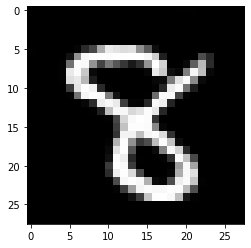

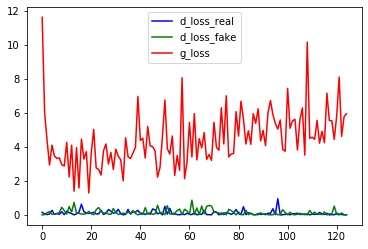

[125/200][0/938] Loss_D: 0.1866 Loss_G: 3.7223 D(x): 0.9985 D(G(z)): 0.1364 / 0.0829
[125/200][100/938] Loss_D: 0.0848 Loss_G: 4.6494 D(x): 0.9980 D(G(z)): 0.0656 / 0.0492
[125/200][200/938] Loss_D: 0.1290 Loss_G: 5.6501 D(x): 0.9472 D(G(z)): 0.0499 / 0.0256
[125/200][300/938] Loss_D: 0.0825 Loss_G: 4.0258 D(x): 0.9782 D(G(z)): 0.0535 / 0.0540
[125/200][400/938] Loss_D: 0.0427 Loss_G: 5.6245 D(x): 0.9794 D(G(z)): 0.0196 / 0.0202
[125/200][500/938] Loss_D: 0.1992 Loss_G: 6.5408 D(x): 0.8850 D(G(z)): 0.0218 / 0.0173
[125/200][600/938] Loss_D: 0.1583 Loss_G: 5.1078 D(x): 0.9909 D(G(z)): 0.1049 / 0.0324
[125/200][700/938] Loss_D: 0.7832 Loss_G: 2.7777 D(x): 0.9910 D(G(z)): 0.3821 / 0.1552
[125/200][800/938] Loss_D: 0.0979 Loss_G: 4.7826 D(x): 0.9621 D(G(z)): 0.0461 / 0.0412
[125/200][900/938] Loss_D: 0.1527 Loss_G: 4.4121 D(x): 0.9879 D(G(z)): 0.1003 / 0.0519


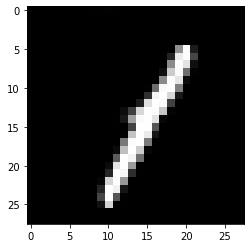

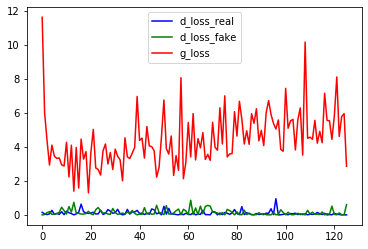

[126/200][0/938] Loss_D: 0.1488 Loss_G: 4.3235 D(x): 0.9968 D(G(z)): 0.1093 / 0.0564
[126/200][100/938] Loss_D: 0.0699 Loss_G: 5.2068 D(x): 0.9789 D(G(z)): 0.0404 / 0.0435
[126/200][200/938] Loss_D: 0.0794 Loss_G: 4.8909 D(x): 0.9987 D(G(z)): 0.0671 / 0.0321
[126/200][300/938] Loss_D: 0.0602 Loss_G: 4.4631 D(x): 0.9764 D(G(z)): 0.0325 / 0.0675
[126/200][400/938] Loss_D: 0.2067 Loss_G: 5.7357 D(x): 0.8842 D(G(z)): 0.0384 / 0.0283
[126/200][500/938] Loss_D: 0.0228 Loss_G: 7.7467 D(x): 0.9825 D(G(z)): 0.0044 / 0.0043
[126/200][600/938] Loss_D: 0.0214 Loss_G: 6.4731 D(x): 0.9885 D(G(z)): 0.0094 / 0.0077
[126/200][700/938] Loss_D: 0.0330 Loss_G: 8.1949 D(x): 0.9704 D(G(z)): 0.0009 / 0.0012
[126/200][800/938] Loss_D: 0.1177 Loss_G: 8.2278 D(x): 0.9053 D(G(z)): 0.0019 / 0.0016
[126/200][900/938] Loss_D: 0.0396 Loss_G: 7.8509 D(x): 0.9669 D(G(z)): 0.0045 / 0.0020


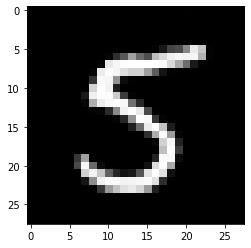

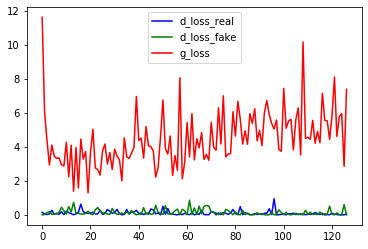

[127/200][0/938] Loss_D: 0.1729 Loss_G: 7.3212 D(x): 0.8986 D(G(z)): 0.0077 / 0.0061
[127/200][100/938] Loss_D: 0.0427 Loss_G: 6.2695 D(x): 0.9771 D(G(z)): 0.0175 / 0.0141
[127/200][200/938] Loss_D: 0.1298 Loss_G: 4.7371 D(x): 0.9947 D(G(z)): 0.0869 / 0.0501
[127/200][300/938] Loss_D: 0.1214 Loss_G: 5.1767 D(x): 0.9599 D(G(z)): 0.0488 / 0.0320
[127/200][400/938] Loss_D: 0.1068 Loss_G: 6.6026 D(x): 0.9557 D(G(z)): 0.0354 / 0.0170
[127/200][500/938] Loss_D: 0.1646 Loss_G: 6.8859 D(x): 0.9561 D(G(z)): 0.0876 / 0.0117
[127/200][600/938] Loss_D: 0.5145 Loss_G: 3.3849 D(x): 0.9163 D(G(z)): 0.2846 / 0.0814
[127/200][700/938] Loss_D: 0.0501 Loss_G: 5.4600 D(x): 0.9697 D(G(z)): 0.0170 / 0.0198
[127/200][800/938] Loss_D: 0.1206 Loss_G: 5.6969 D(x): 0.9218 D(G(z)): 0.0284 / 0.0297
[127/200][900/938] Loss_D: 0.0336 Loss_G: 6.1388 D(x): 0.9754 D(G(z)): 0.0078 / 0.0098


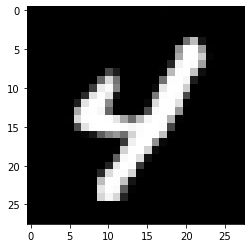

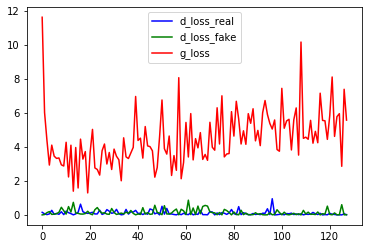

[128/200][0/938] Loss_D: 0.0746 Loss_G: 4.4016 D(x): 0.9938 D(G(z)): 0.0555 / 0.0463
[128/200][100/938] Loss_D: 0.1231 Loss_G: 4.4958 D(x): 0.9947 D(G(z)): 0.0956 / 0.0476
[128/200][200/938] Loss_D: 0.1792 Loss_G: 5.4126 D(x): 0.8854 D(G(z)): 0.0357 / 0.0235
[128/200][300/938] Loss_D: 0.0493 Loss_G: 5.5260 D(x): 0.9845 D(G(z)): 0.0289 / 0.0244
[128/200][400/938] Loss_D: 0.0408 Loss_G: 5.5181 D(x): 0.9921 D(G(z)): 0.0286 / 0.0321
[128/200][500/938] Loss_D: 0.0105 Loss_G: 7.8907 D(x): 0.9904 D(G(z)): 0.0008 / 0.0017
[128/200][600/938] Loss_D: 0.0974 Loss_G: 4.3280 D(x): 0.9900 D(G(z)): 0.0599 / 0.0688
[128/200][700/938] Loss_D: 0.0790 Loss_G: 5.6520 D(x): 0.9704 D(G(z)): 0.0425 / 0.0170
[128/200][800/938] Loss_D: 0.0204 Loss_G: 6.8886 D(x): 0.9915 D(G(z)): 0.0106 / 0.0103
[128/200][900/938] Loss_D: 0.6378 Loss_G: 3.4251 D(x): 0.9799 D(G(z)): 0.3228 / 0.1037


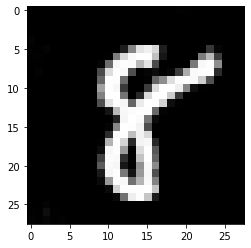

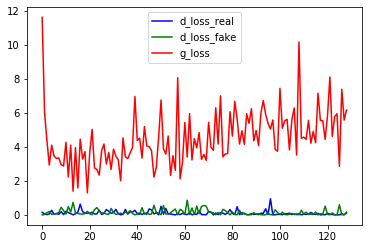

[129/200][0/938] Loss_D: 0.0929 Loss_G: 6.9254 D(x): 0.9393 D(G(z)): 0.0165 / 0.0114
[129/200][100/938] Loss_D: 0.1266 Loss_G: 4.7979 D(x): 0.9759 D(G(z)): 0.0688 / 0.0443
[129/200][200/938] Loss_D: 0.4113 Loss_G: 3.3267 D(x): 0.9705 D(G(z)): 0.2325 / 0.1087
[129/200][300/938] Loss_D: 0.3071 Loss_G: 3.4001 D(x): 0.9850 D(G(z)): 0.1932 / 0.0943
[129/200][400/938] Loss_D: 0.0171 Loss_G: 6.2183 D(x): 0.9982 D(G(z)): 0.0138 / 0.0119
[129/200][500/938] Loss_D: 0.0377 Loss_G: 8.1979 D(x): 0.9679 D(G(z)): 0.0035 / 0.0016
[129/200][600/938] Loss_D: 0.1253 Loss_G: 4.7859 D(x): 0.9953 D(G(z)): 0.0863 / 0.0467
[129/200][700/938] Loss_D: 0.1566 Loss_G: 4.5352 D(x): 0.9149 D(G(z)): 0.0426 / 0.0691
[129/200][800/938] Loss_D: 0.0514 Loss_G: 4.6436 D(x): 0.9932 D(G(z)): 0.0409 / 0.0527
[129/200][900/938] Loss_D: 0.0596 Loss_G: 6.4565 D(x): 0.9594 D(G(z)): 0.0138 / 0.0146


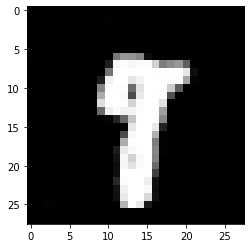

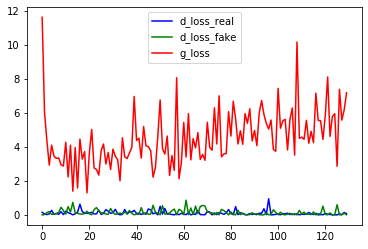

[130/200][0/938] Loss_D: 0.0123 Loss_G: 6.1933 D(x): 0.9966 D(G(z)): 0.0086 / 0.0080
[130/200][100/938] Loss_D: 0.1184 Loss_G: 3.6842 D(x): 0.9657 D(G(z)): 0.0594 / 0.0913
[130/200][200/938] Loss_D: 0.1808 Loss_G: 3.4473 D(x): 0.9998 D(G(z)): 0.1362 / 0.1069
[130/200][300/938] Loss_D: 0.1361 Loss_G: 4.0518 D(x): 0.9885 D(G(z)): 0.0841 / 0.0586
[130/200][400/938] Loss_D: 0.3863 Loss_G: 3.7262 D(x): 0.9896 D(G(z)): 0.2340 / 0.0774
[130/200][500/938] Loss_D: 0.1371 Loss_G: 8.9097 D(x): 0.8905 D(G(z)): 0.0022 / 0.0010
[130/200][600/938] Loss_D: 0.6208 Loss_G: 3.6533 D(x): 0.9972 D(G(z)): 0.3147 / 0.0924
[130/200][700/938] Loss_D: 0.0255 Loss_G: 6.5937 D(x): 0.9856 D(G(z)): 0.0090 / 0.0102
[130/200][800/938] Loss_D: 0.0545 Loss_G: 8.7492 D(x): 0.9556 D(G(z)): 0.0048 / 0.0021
[130/200][900/938] Loss_D: 0.3881 Loss_G: 7.8708 D(x): 0.7313 D(G(z)): 0.0012 / 0.0022


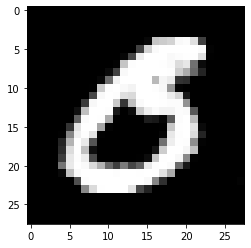

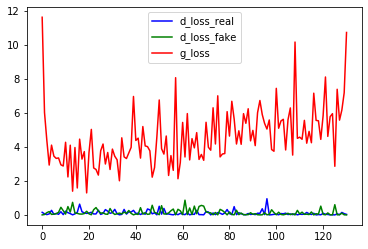

[131/200][0/938] Loss_D: 0.0826 Loss_G: 7.0627 D(x): 0.9528 D(G(z)): 0.0198 / 0.0124
[131/200][100/938] Loss_D: 0.0538 Loss_G: 5.5016 D(x): 0.9963 D(G(z)): 0.0423 / 0.0246
[131/200][200/938] Loss_D: 0.1350 Loss_G: 4.7049 D(x): 0.9838 D(G(z)): 0.0786 / 0.0638
[131/200][300/938] Loss_D: 0.0527 Loss_G: 4.7619 D(x): 0.9962 D(G(z)): 0.0336 / 0.0521
[131/200][400/938] Loss_D: 0.0427 Loss_G: 6.8606 D(x): 0.9635 D(G(z)): 0.0043 / 0.0059
[131/200][500/938] Loss_D: 0.0808 Loss_G: 5.5609 D(x): 0.9473 D(G(z)): 0.0147 / 0.0201
[131/200][600/938] Loss_D: 0.0617 Loss_G: 5.5202 D(x): 0.9682 D(G(z)): 0.0260 / 0.0224
[131/200][700/938] Loss_D: 0.0495 Loss_G: 4.5105 D(x): 0.9873 D(G(z)): 0.0318 / 0.0515
[131/200][800/938] Loss_D: 0.0665 Loss_G: 6.2593 D(x): 0.9667 D(G(z)): 0.0202 / 0.0203
[131/200][900/938] Loss_D: 0.0842 Loss_G: 4.4304 D(x): 0.9933 D(G(z)): 0.0494 / 0.0525


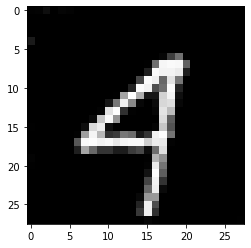

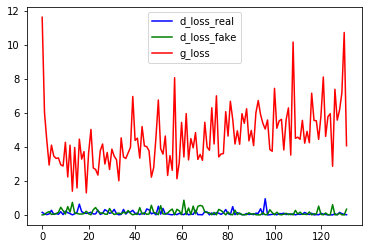

[132/200][0/938] Loss_D: 0.0444 Loss_G: 6.4958 D(x): 0.9793 D(G(z)): 0.0211 / 0.0087
[132/200][100/938] Loss_D: 0.1157 Loss_G: 7.4491 D(x): 0.9153 D(G(z)): 0.0116 / 0.0050
[132/200][200/938] Loss_D: 0.0345 Loss_G: 7.0657 D(x): 0.9756 D(G(z)): 0.0084 / 0.0069
[132/200][300/938] Loss_D: 0.2790 Loss_G: 2.9223 D(x): 0.9478 D(G(z)): 0.1537 / 0.1913
[132/200][400/938] Loss_D: 0.0185 Loss_G: 6.3146 D(x): 0.9993 D(G(z)): 0.0168 / 0.0118
[132/200][500/938] Loss_D: 0.2807 Loss_G: 3.5472 D(x): 0.9697 D(G(z)): 0.1647 / 0.0953
[132/200][600/938] Loss_D: 0.1192 Loss_G: 6.8177 D(x): 0.9128 D(G(z)): 0.0069 / 0.0053
[132/200][700/938] Loss_D: 0.3333 Loss_G: 6.1538 D(x): 0.7784 D(G(z)): 0.0079 / 0.0130
[132/200][800/938] Loss_D: 0.0746 Loss_G: 5.5520 D(x): 0.9877 D(G(z)): 0.0510 / 0.0264
[132/200][900/938] Loss_D: 0.0322 Loss_G: 7.1162 D(x): 0.9790 D(G(z)): 0.0091 / 0.0044


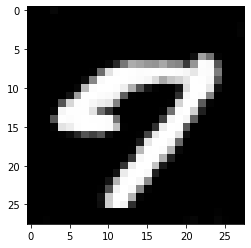

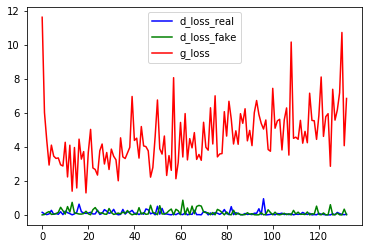

[133/200][0/938] Loss_D: 0.5781 Loss_G: 3.0558 D(x): 0.9694 D(G(z)): 0.2607 / 0.1577
[133/200][100/938] Loss_D: 0.0729 Loss_G: 4.8853 D(x): 0.9666 D(G(z)): 0.0282 / 0.0434
[133/200][200/938] Loss_D: 0.1256 Loss_G: 4.5542 D(x): 0.9979 D(G(z)): 0.0872 / 0.0481
[133/200][300/938] Loss_D: 0.1145 Loss_G: 4.5200 D(x): 0.9801 D(G(z)): 0.0658 / 0.0596
[133/200][400/938] Loss_D: 0.0546 Loss_G: 10.1742 D(x): 0.9510 D(G(z)): 0.0007 / 0.0004
[133/200][500/938] Loss_D: 0.2607 Loss_G: 4.3221 D(x): 0.8900 D(G(z)): 0.0760 / 0.0607
[133/200][600/938] Loss_D: 0.0303 Loss_G: 7.4108 D(x): 0.9925 D(G(z)): 0.0196 / 0.0095
[133/200][700/938] Loss_D: 0.1807 Loss_G: 5.4532 D(x): 0.8633 D(G(z)): 0.0155 / 0.0230
[133/200][800/938] Loss_D: 0.1268 Loss_G: 4.1945 D(x): 0.9964 D(G(z)): 0.0893 / 0.0872
[133/200][900/938] Loss_D: 0.1422 Loss_G: 6.0549 D(x): 0.8935 D(G(z)): 0.0139 / 0.0155


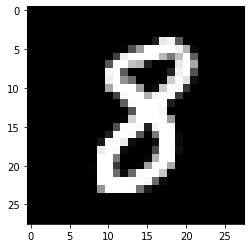

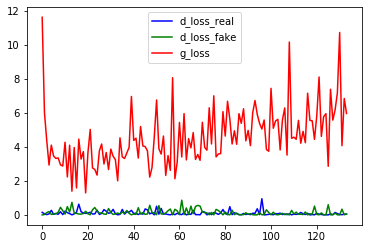

[134/200][0/938] Loss_D: 0.0331 Loss_G: 7.9575 D(x): 0.9726 D(G(z)): 0.0020 / 0.0016
[134/200][100/938] Loss_D: 0.1147 Loss_G: 4.9865 D(x): 0.9516 D(G(z)): 0.0423 / 0.0408
[134/200][200/938] Loss_D: 0.2628 Loss_G: 5.0764 D(x): 0.9934 D(G(z)): 0.1669 / 0.0297
[134/200][300/938] Loss_D: 0.1248 Loss_G: 5.3885 D(x): 0.9193 D(G(z)): 0.0259 / 0.0242
[134/200][400/938] Loss_D: 0.0220 Loss_G: 6.8713 D(x): 0.9905 D(G(z)): 0.0119 / 0.0097
[134/200][500/938] Loss_D: 0.0197 Loss_G: 9.4119 D(x): 0.9834 D(G(z)): 0.0023 / 0.0008
[134/200][600/938] Loss_D: 0.0635 Loss_G: 5.3503 D(x): 0.9774 D(G(z)): 0.0356 / 0.0222
[134/200][700/938] Loss_D: 0.0254 Loss_G: 5.5074 D(x): 0.9919 D(G(z)): 0.0166 / 0.0244
[134/200][800/938] Loss_D: 0.0981 Loss_G: 3.5090 D(x): 0.9995 D(G(z)): 0.0761 / 0.0935
[134/200][900/938] Loss_D: 0.3056 Loss_G: 4.5115 D(x): 0.9988 D(G(z)): 0.1809 / 0.0501


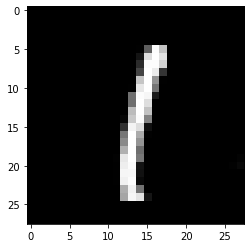

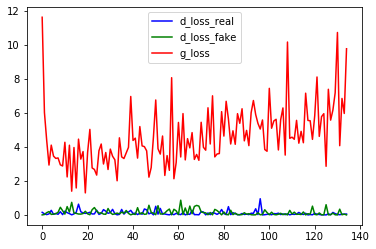

[135/200][0/938] Loss_D: 0.0734 Loss_G: 5.8190 D(x): 0.9587 D(G(z)): 0.0248 / 0.0159
[135/200][100/938] Loss_D: 0.1384 Loss_G: 3.6967 D(x): 0.9700 D(G(z)): 0.0741 / 0.1027
[135/200][200/938] Loss_D: 0.0641 Loss_G: 6.0924 D(x): 0.9886 D(G(z)): 0.0390 / 0.0214
[135/200][300/938] Loss_D: 0.3462 Loss_G: 3.2449 D(x): 0.9867 D(G(z)): 0.1951 / 0.1263
[135/200][400/938] Loss_D: 0.2336 Loss_G: 6.8497 D(x): 0.8177 D(G(z)): 0.0028 / 0.0077
[135/200][500/938] Loss_D: 0.2628 Loss_G: 5.6614 D(x): 0.8458 D(G(z)): 0.0099 / 0.0212
[135/200][600/938] Loss_D: 0.2337 Loss_G: 4.1639 D(x): 0.8850 D(G(z)): 0.0536 / 0.0665
[135/200][700/938] Loss_D: 0.4226 Loss_G: 4.3581 D(x): 0.7711 D(G(z)): 0.0434 / 0.0687
[135/200][800/938] Loss_D: 0.2419 Loss_G: 3.4379 D(x): 0.9901 D(G(z)): 0.1735 / 0.1105
[135/200][900/938] Loss_D: 0.0154 Loss_G: 5.3773 D(x): 0.9982 D(G(z)): 0.0130 / 0.0250


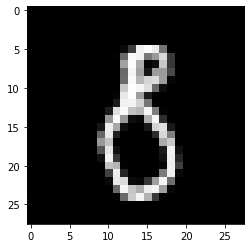

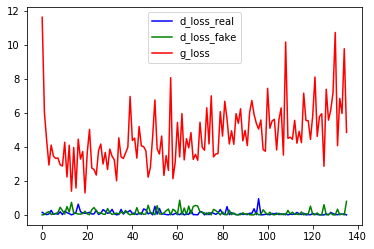

[136/200][0/938] Loss_D: 0.0381 Loss_G: 10.5591 D(x): 0.9675 D(G(z)): 0.0025 / 0.0002
[136/200][100/938] Loss_D: 0.1081 Loss_G: 6.4014 D(x): 0.9181 D(G(z)): 0.0119 / 0.0168
[136/200][200/938] Loss_D: 0.1017 Loss_G: 5.7847 D(x): 0.9274 D(G(z)): 0.0174 / 0.0116
[136/200][300/938] Loss_D: 0.0782 Loss_G: 6.4734 D(x): 0.9729 D(G(z)): 0.0375 / 0.0151
[136/200][400/938] Loss_D: 0.1790 Loss_G: 6.0672 D(x): 0.8932 D(G(z)): 0.0229 / 0.0196
[136/200][500/938] Loss_D: 0.1282 Loss_G: 6.1943 D(x): 0.8978 D(G(z)): 0.0075 / 0.0114
[136/200][600/938] Loss_D: 0.0450 Loss_G: 7.0418 D(x): 0.9721 D(G(z)): 0.0136 / 0.0069
[136/200][700/938] Loss_D: 0.2722 Loss_G: 7.8568 D(x): 0.8194 D(G(z)): 0.0146 / 0.0067
[136/200][800/938] Loss_D: 0.1087 Loss_G: 4.4818 D(x): 0.9736 D(G(z)): 0.0634 / 0.0480
[136/200][900/938] Loss_D: 0.0133 Loss_G: 7.2656 D(x): 0.9923 D(G(z)): 0.0054 / 0.0026


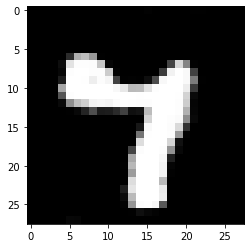

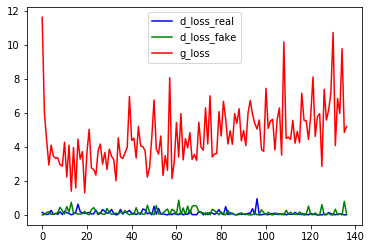

[137/200][0/938] Loss_D: 0.1286 Loss_G: 4.5064 D(x): 0.9685 D(G(z)): 0.0787 / 0.0527
[137/200][100/938] Loss_D: 0.0290 Loss_G: 6.2018 D(x): 0.9942 D(G(z)): 0.0198 / 0.0169
[137/200][200/938] Loss_D: 0.0773 Loss_G: 5.8059 D(x): 0.9681 D(G(z)): 0.0346 / 0.0280
[137/200][300/938] Loss_D: 0.0594 Loss_G: 9.5379 D(x): 0.9488 D(G(z)): 0.0019 / 0.0013
[137/200][400/938] Loss_D: 0.0242 Loss_G: 5.0551 D(x): 0.9977 D(G(z)): 0.0206 / 0.0266
[137/200][500/938] Loss_D: 0.0369 Loss_G: 8.6928 D(x): 0.9666 D(G(z)): 0.0014 / 0.0007
[137/200][600/938] Loss_D: 0.1929 Loss_G: 5.7729 D(x): 0.8813 D(G(z)): 0.0136 / 0.0151
[137/200][700/938] Loss_D: 0.1916 Loss_G: 3.8667 D(x): 0.9864 D(G(z)): 0.1271 / 0.0892
[137/200][800/938] Loss_D: 0.0594 Loss_G: 7.0791 D(x): 0.9527 D(G(z)): 0.0039 / 0.0074
[137/200][900/938] Loss_D: 0.0708 Loss_G: 6.9604 D(x): 0.9765 D(G(z)): 0.0374 / 0.0140


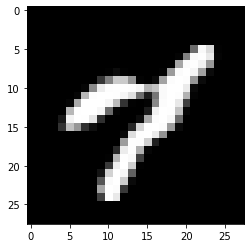

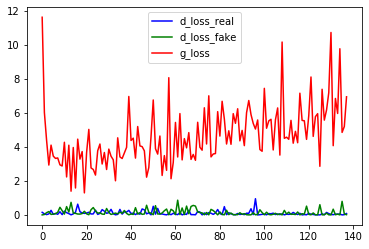

[138/200][0/938] Loss_D: 0.0602 Loss_G: 4.8050 D(x): 0.9739 D(G(z)): 0.0301 / 0.0376
[138/200][100/938] Loss_D: 0.0671 Loss_G: 5.4347 D(x): 0.9751 D(G(z)): 0.0372 / 0.0245
[138/200][200/938] Loss_D: 0.2997 Loss_G: 8.5196 D(x): 0.7974 D(G(z)): 0.0030 / 0.0030
[138/200][300/938] Loss_D: 0.0681 Loss_G: 5.5496 D(x): 0.9822 D(G(z)): 0.0424 / 0.0223
[138/200][400/938] Loss_D: 0.5952 Loss_G: 3.6071 D(x): 0.7571 D(G(z)): 0.1390 / 0.1217
[138/200][500/938] Loss_D: 0.0423 Loss_G: 5.9815 D(x): 0.9708 D(G(z)): 0.0105 / 0.0108
[138/200][600/938] Loss_D: 0.1229 Loss_G: 6.4243 D(x): 0.9044 D(G(z)): 0.0052 / 0.0059
[138/200][700/938] Loss_D: 0.0602 Loss_G: 5.2947 D(x): 0.9659 D(G(z)): 0.0207 / 0.0233
[138/200][800/938] Loss_D: 1.0310 Loss_G: 7.1948 D(x): 0.4929 D(G(z)): 0.0013 / 0.0056
[138/200][900/938] Loss_D: 0.0828 Loss_G: 6.7439 D(x): 0.9372 D(G(z)): 0.0112 / 0.0110


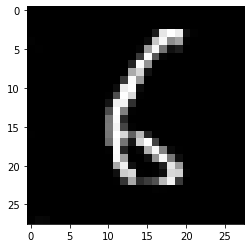

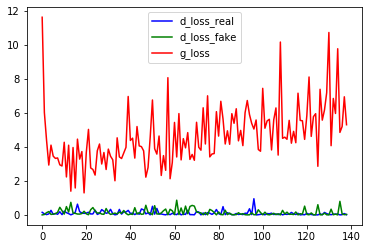

[139/200][0/938] Loss_D: 0.3418 Loss_G: 4.0317 D(x): 0.9991 D(G(z)): 0.2079 / 0.0737
[139/200][100/938] Loss_D: 0.1004 Loss_G: 4.4720 D(x): 0.9879 D(G(z)): 0.0704 / 0.0413
[139/200][200/938] Loss_D: 0.0350 Loss_G: 5.2674 D(x): 0.9884 D(G(z)): 0.0215 / 0.0307
[139/200][300/938] Loss_D: 0.0490 Loss_G: 5.5446 D(x): 0.9977 D(G(z)): 0.0372 / 0.0239
[139/200][400/938] Loss_D: 0.1163 Loss_G: 5.4803 D(x): 0.9427 D(G(z)): 0.0394 / 0.0251
[139/200][500/938] Loss_D: 0.0705 Loss_G: 4.8937 D(x): 0.9699 D(G(z)): 0.0347 / 0.0351
[139/200][600/938] Loss_D: 0.5304 Loss_G: 5.7091 D(x): 0.6902 D(G(z)): 0.0103 / 0.0352
[139/200][700/938] Loss_D: 0.1135 Loss_G: 5.1480 D(x): 0.9944 D(G(z)): 0.0885 / 0.0210
[139/200][800/938] Loss_D: 0.0784 Loss_G: 8.7535 D(x): 0.9318 D(G(z)): 0.0006 / 0.0006
[139/200][900/938] Loss_D: 0.0643 Loss_G: 8.7536 D(x): 0.9425 D(G(z)): 0.0015 / 0.0013


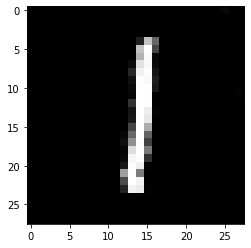

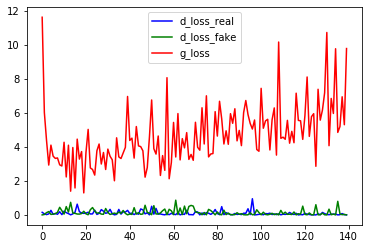

[140/200][0/938] Loss_D: 0.0405 Loss_G: 7.1159 D(x): 0.9647 D(G(z)): 0.0017 / 0.0045
[140/200][100/938] Loss_D: 0.1483 Loss_G: 4.7033 D(x): 0.9235 D(G(z)): 0.0491 / 0.0470
[140/200][200/938] Loss_D: 0.1476 Loss_G: 3.5303 D(x): 0.9783 D(G(z)): 0.0978 / 0.1062
[140/200][300/938] Loss_D: 0.1142 Loss_G: 6.2634 D(x): 0.9273 D(G(z)): 0.0213 / 0.0278
[140/200][400/938] Loss_D: 0.2385 Loss_G: 3.8723 D(x): 0.9973 D(G(z)): 0.1552 / 0.0781
[140/200][500/938] Loss_D: 0.0667 Loss_G: 4.1594 D(x): 0.9896 D(G(z)): 0.0498 / 0.0525
[140/200][600/938] Loss_D: 0.1734 Loss_G: 7.2881 D(x): 0.8798 D(G(z)): 0.0117 / 0.0097
[140/200][700/938] Loss_D: 0.1272 Loss_G: 6.1433 D(x): 0.9242 D(G(z)): 0.0328 / 0.0141
[140/200][800/938] Loss_D: 0.0635 Loss_G: 4.7405 D(x): 0.9644 D(G(z)): 0.0242 / 0.0359
[140/200][900/938] Loss_D: 0.0487 Loss_G: 6.5868 D(x): 0.9734 D(G(z)): 0.0193 / 0.0138


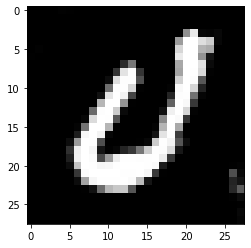

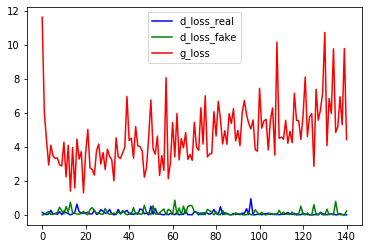

[141/200][0/938] Loss_D: 0.3456 Loss_G: 5.2058 D(x): 0.9979 D(G(z)): 0.2154 / 0.0216
[141/200][100/938] Loss_D: 0.1145 Loss_G: 4.9509 D(x): 0.9687 D(G(z)): 0.0524 / 0.0460
[141/200][200/938] Loss_D: 0.0637 Loss_G: 6.8335 D(x): 0.9624 D(G(z)): 0.0116 / 0.0082
[141/200][300/938] Loss_D: 0.0537 Loss_G: 7.3236 D(x): 0.9558 D(G(z)): 0.0071 / 0.0049
[141/200][400/938] Loss_D: 0.0517 Loss_G: 4.5185 D(x): 0.9916 D(G(z)): 0.0392 / 0.0365
[141/200][500/938] Loss_D: 0.0931 Loss_G: 4.8809 D(x): 0.9956 D(G(z)): 0.0713 / 0.0445
[141/200][600/938] Loss_D: 0.3123 Loss_G: 3.8934 D(x): 0.9912 D(G(z)): 0.1503 / 0.1378
[141/200][700/938] Loss_D: 0.1242 Loss_G: 3.8462 D(x): 0.9927 D(G(z)): 0.0945 / 0.0826
[141/200][800/938] Loss_D: 0.4470 Loss_G: 3.4173 D(x): 0.9992 D(G(z)): 0.2713 / 0.1295
[141/200][900/938] Loss_D: 0.0177 Loss_G: 8.0921 D(x): 0.9888 D(G(z)): 0.0060 / 0.0020


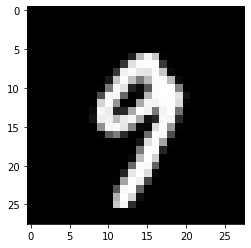

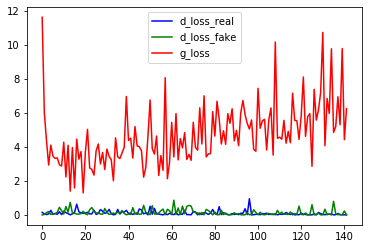

[142/200][0/938] Loss_D: 0.0966 Loss_G: 4.6527 D(x): 0.9980 D(G(z)): 0.0706 / 0.0399
[142/200][100/938] Loss_D: 0.4842 Loss_G: 6.5679 D(x): 0.7156 D(G(z)): 0.0073 / 0.0103
[142/200][200/938] Loss_D: 0.1274 Loss_G: 4.4187 D(x): 0.9912 D(G(z)): 0.0903 / 0.0448
[142/200][300/938] Loss_D: 0.0242 Loss_G: 5.2854 D(x): 0.9985 D(G(z)): 0.0212 / 0.0287
[142/200][400/938] Loss_D: 0.0188 Loss_G: 6.4362 D(x): 0.9911 D(G(z)): 0.0094 / 0.0103
[142/200][500/938] Loss_D: 0.0868 Loss_G: 5.7276 D(x): 0.9879 D(G(z)): 0.0381 / 0.0341
[142/200][600/938] Loss_D: 0.5193 Loss_G: 2.0437 D(x): 0.9972 D(G(z)): 0.3097 / 0.2412
[142/200][700/938] Loss_D: 0.0517 Loss_G: 5.2838 D(x): 0.9712 D(G(z)): 0.0192 / 0.0265
[142/200][800/938] Loss_D: 0.3875 Loss_G: 4.0842 D(x): 0.9651 D(G(z)): 0.2137 / 0.0675
[142/200][900/938] Loss_D: 0.0478 Loss_G: 5.7811 D(x): 0.9836 D(G(z)): 0.0282 / 0.0217


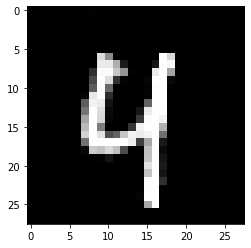

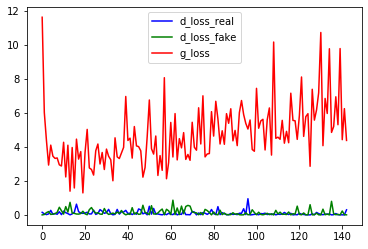

[143/200][0/938] Loss_D: 0.0211 Loss_G: 4.3985 D(x): 0.9897 D(G(z)): 0.0103 / 0.0578
[143/200][100/938] Loss_D: 0.1597 Loss_G: 7.9985 D(x): 0.8741 D(G(z)): 0.0023 / 0.0018
[143/200][200/938] Loss_D: 0.0063 Loss_G: 8.7850 D(x): 0.9959 D(G(z)): 0.0022 / 0.0015
[143/200][300/938] Loss_D: 0.4239 Loss_G: 5.3152 D(x): 0.7633 D(G(z)): 0.0169 / 0.0285
[143/200][400/938] Loss_D: 0.0294 Loss_G: 5.0919 D(x): 0.9961 D(G(z)): 0.0241 / 0.0212
[143/200][500/938] Loss_D: 0.1374 Loss_G: 4.8597 D(x): 0.9663 D(G(z)): 0.0654 / 0.0474
[143/200][600/938] Loss_D: 0.0360 Loss_G: 5.4446 D(x): 0.9839 D(G(z)): 0.0183 / 0.0186
[143/200][700/938] Loss_D: 0.2260 Loss_G: 4.6314 D(x): 0.9586 D(G(z)): 0.1311 / 0.0533
[143/200][800/938] Loss_D: 0.0436 Loss_G: 5.5514 D(x): 0.9883 D(G(z)): 0.0274 / 0.0236
[143/200][900/938] Loss_D: 0.1476 Loss_G: 5.4918 D(x): 0.9508 D(G(z)): 0.0736 / 0.0499


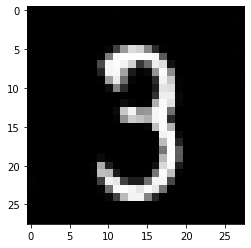

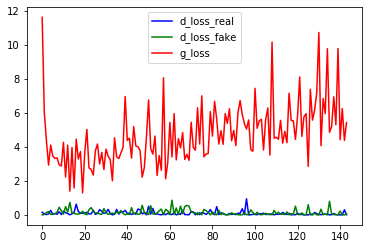

[144/200][0/938] Loss_D: 0.0482 Loss_G: 5.6120 D(x): 0.9882 D(G(z)): 0.0335 / 0.0150
[144/200][100/938] Loss_D: 0.0286 Loss_G: 6.9146 D(x): 0.9885 D(G(z)): 0.0146 / 0.0135
[144/200][200/938] Loss_D: 0.0615 Loss_G: 4.6021 D(x): 0.9997 D(G(z)): 0.0473 / 0.0414
[144/200][300/938] Loss_D: 0.0326 Loss_G: 7.8239 D(x): 0.9729 D(G(z)): 0.0031 / 0.0044
[144/200][400/938] Loss_D: 0.0443 Loss_G: 6.8481 D(x): 0.9690 D(G(z)): 0.0106 / 0.0072
[144/200][500/938] Loss_D: 0.1557 Loss_G: 4.6373 D(x): 0.9814 D(G(z)): 0.1100 / 0.0384
[144/200][600/938] Loss_D: 0.1319 Loss_G: 6.4135 D(x): 0.9252 D(G(z)): 0.0318 / 0.0123
[144/200][700/938] Loss_D: 0.3418 Loss_G: 6.0255 D(x): 0.7857 D(G(z)): 0.0150 / 0.0143
[144/200][800/938] Loss_D: 0.0653 Loss_G: 8.2722 D(x): 0.9470 D(G(z)): 0.0026 / 0.0023
[144/200][900/938] Loss_D: 0.1460 Loss_G: 3.3644 D(x): 0.9914 D(G(z)): 0.0930 / 0.1585


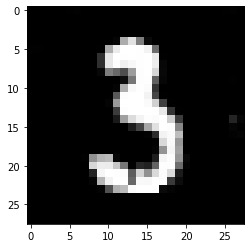

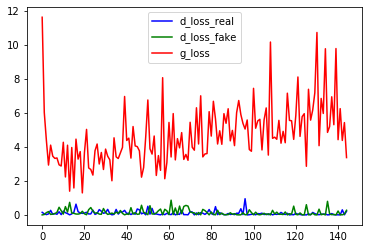

[145/200][0/938] Loss_D: 0.1513 Loss_G: 4.3266 D(x): 0.9784 D(G(z)): 0.0911 / 0.0677
[145/200][100/938] Loss_D: 0.0480 Loss_G: 6.6856 D(x): 0.9682 D(G(z)): 0.0115 / 0.0081
[145/200][200/938] Loss_D: 0.0884 Loss_G: 5.5112 D(x): 0.9564 D(G(z)): 0.0361 / 0.0263
[145/200][300/938] Loss_D: 0.4114 Loss_G: 4.7100 D(x): 0.7487 D(G(z)): 0.0388 / 0.0540
[145/200][400/938] Loss_D: 0.0355 Loss_G: 5.2452 D(x): 0.9926 D(G(z)): 0.0255 / 0.0236
[145/200][500/938] Loss_D: 0.0636 Loss_G: 5.2299 D(x): 0.9922 D(G(z)): 0.0433 / 0.0413
[145/200][600/938] Loss_D: 0.5711 Loss_G: 3.0919 D(x): 0.9935 D(G(z)): 0.3112 / 0.1514
[145/200][700/938] Loss_D: 0.0187 Loss_G: 6.9121 D(x): 0.9939 D(G(z)): 0.0115 / 0.0108
[145/200][800/938] Loss_D: 0.0896 Loss_G: 5.1818 D(x): 0.9756 D(G(z)): 0.0527 / 0.0308
[145/200][900/938] Loss_D: 0.0392 Loss_G: 6.8972 D(x): 0.9728 D(G(z)): 0.0093 / 0.0060


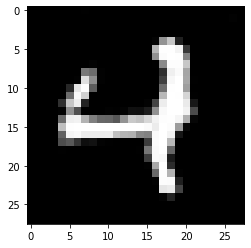

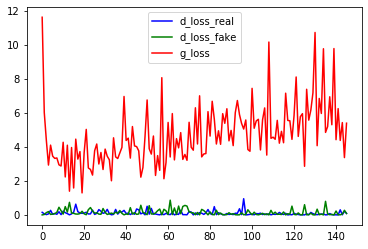

[146/200][0/938] Loss_D: 0.2062 Loss_G: 6.9773 D(x): 0.8490 D(G(z)): 0.0138 / 0.0097
[146/200][100/938] Loss_D: 0.1975 Loss_G: 4.5772 D(x): 0.9691 D(G(z)): 0.1156 / 0.0665
[146/200][200/938] Loss_D: 0.0951 Loss_G: 5.9004 D(x): 0.9987 D(G(z)): 0.0765 / 0.0146
[146/200][300/938] Loss_D: 0.0367 Loss_G: 6.0339 D(x): 0.9971 D(G(z)): 0.0302 / 0.0123
[146/200][400/938] Loss_D: 0.0208 Loss_G: 7.2653 D(x): 0.9905 D(G(z)): 0.0105 / 0.0058
[146/200][500/938] Loss_D: 0.0346 Loss_G: 7.3220 D(x): 0.9727 D(G(z)): 0.0061 / 0.0056
[146/200][600/938] Loss_D: 0.0274 Loss_G: 5.7670 D(x): 0.9896 D(G(z)): 0.0158 / 0.0170
[146/200][700/938] Loss_D: 0.1121 Loss_G: 6.3915 D(x): 0.9617 D(G(z)): 0.0505 / 0.0175
[146/200][800/938] Loss_D: 0.2618 Loss_G: 4.0342 D(x): 0.9990 D(G(z)): 0.1757 / 0.0624
[146/200][900/938] Loss_D: 0.1163 Loss_G: 7.2208 D(x): 0.9130 D(G(z)): 0.0072 / 0.0056


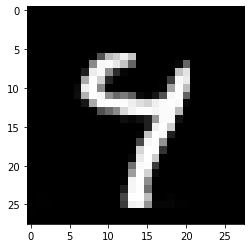

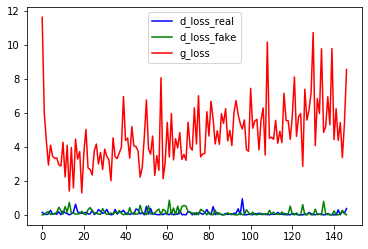

[147/200][0/938] Loss_D: 0.2311 Loss_G: 7.7852 D(x): 0.8318 D(G(z)): 0.0035 / 0.0043
[147/200][100/938] Loss_D: 0.2270 Loss_G: 6.0072 D(x): 0.8293 D(G(z)): 0.0112 / 0.0230
[147/200][200/938] Loss_D: 0.1135 Loss_G: 6.0028 D(x): 0.9386 D(G(z)): 0.0272 / 0.0244
[147/200][300/938] Loss_D: 0.0509 Loss_G: 6.9653 D(x): 0.9703 D(G(z)): 0.0131 / 0.0102
[147/200][400/938] Loss_D: 0.1035 Loss_G: 4.9952 D(x): 0.9359 D(G(z)): 0.0278 / 0.0348
[147/200][500/938] Loss_D: 0.0434 Loss_G: 7.1319 D(x): 0.9847 D(G(z)): 0.0177 / 0.0130
[147/200][600/938] Loss_D: 0.0781 Loss_G: 8.8198 D(x): 0.9420 D(G(z)): 0.0016 / 0.0014
[147/200][700/938] Loss_D: 0.2557 Loss_G: 4.3569 D(x): 0.9711 D(G(z)): 0.1413 / 0.0828
[147/200][800/938] Loss_D: 0.0587 Loss_G: 5.5635 D(x): 0.9736 D(G(z)): 0.0217 / 0.0234
[147/200][900/938] Loss_D: 0.1151 Loss_G: 6.9998 D(x): 0.9056 D(G(z)): 0.0032 / 0.0084


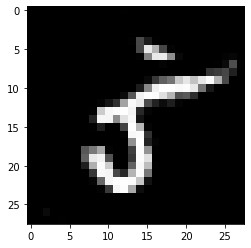

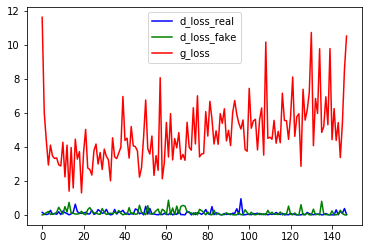

[148/200][0/938] Loss_D: 0.0812 Loss_G: 6.2072 D(x): 0.9441 D(G(z)): 0.0175 / 0.0196
[148/200][100/938] Loss_D: 2.0997 Loss_G: 9.3847 D(x): 0.2703 D(G(z)): 0.0002 / 0.0021
[148/200][200/938] Loss_D: 0.1171 Loss_G: 6.3799 D(x): 0.9142 D(G(z)): 0.0141 / 0.0097
[148/200][300/938] Loss_D: 0.0638 Loss_G: 5.2632 D(x): 0.9828 D(G(z)): 0.0414 / 0.0233
[148/200][400/938] Loss_D: 0.1061 Loss_G: 5.2310 D(x): 0.9485 D(G(z)): 0.0399 / 0.0362
[148/200][500/938] Loss_D: 0.0892 Loss_G: 4.8533 D(x): 0.9951 D(G(z)): 0.0637 / 0.0539
[148/200][600/938] Loss_D: 0.0741 Loss_G: 5.2307 D(x): 0.9935 D(G(z)): 0.0516 / 0.0288
[148/200][700/938] Loss_D: 0.1085 Loss_G: 3.7861 D(x): 0.9947 D(G(z)): 0.0807 / 0.0824
[148/200][800/938] Loss_D: 0.0804 Loss_G: 5.0652 D(x): 0.9813 D(G(z)): 0.0455 / 0.0511
[148/200][900/938] Loss_D: 0.1213 Loss_G: 6.8094 D(x): 0.9492 D(G(z)): 0.0438 / 0.0102


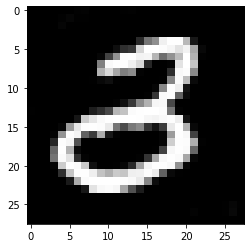

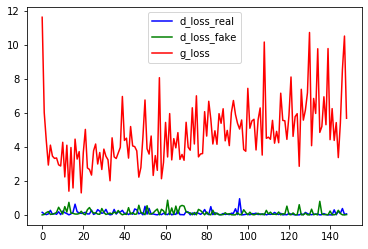

[149/200][0/938] Loss_D: 0.0255 Loss_G: 6.2358 D(x): 0.9855 D(G(z)): 0.0098 / 0.0110
[149/200][100/938] Loss_D: 0.1823 Loss_G: 4.5453 D(x): 0.9349 D(G(z)): 0.0812 / 0.0525
[149/200][200/938] Loss_D: 0.1539 Loss_G: 6.2727 D(x): 0.8912 D(G(z)): 0.0102 / 0.0160
[149/200][300/938] Loss_D: 0.0082 Loss_G: 7.1770 D(x): 0.9958 D(G(z)): 0.0039 / 0.0044
[149/200][400/938] Loss_D: 0.0499 Loss_G: 6.0168 D(x): 0.9696 D(G(z)): 0.0164 / 0.0203
[149/200][500/938] Loss_D: 0.0849 Loss_G: 5.9436 D(x): 0.9378 D(G(z)): 0.0115 / 0.0106
[149/200][600/938] Loss_D: 0.0446 Loss_G: 5.9614 D(x): 0.9979 D(G(z)): 0.0391 / 0.0242
[149/200][700/938] Loss_D: 0.3568 Loss_G: 2.8262 D(x): 0.9406 D(G(z)): 0.1551 / 0.2102
[149/200][800/938] Loss_D: 0.0188 Loss_G: 7.3756 D(x): 0.9860 D(G(z)): 0.0042 / 0.0057
[149/200][900/938] Loss_D: 0.0761 Loss_G: 4.8705 D(x): 0.9724 D(G(z)): 0.0357 / 0.0443


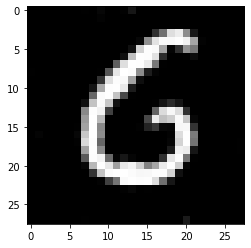

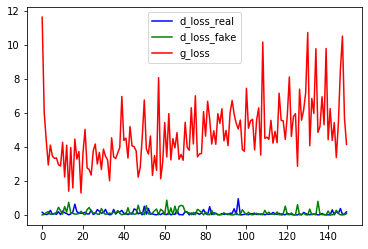

[150/200][0/938] Loss_D: 0.0555 Loss_G: 5.7988 D(x): 0.9900 D(G(z)): 0.0379 / 0.0317
[150/200][100/938] Loss_D: 0.1172 Loss_G: 4.0917 D(x): 0.9374 D(G(z)): 0.0403 / 0.0655
[150/200][200/938] Loss_D: 0.0095 Loss_G: 6.6590 D(x): 0.9989 D(G(z)): 0.0081 / 0.0081
[150/200][300/938] Loss_D: 0.0368 Loss_G: 6.7550 D(x): 0.9797 D(G(z)): 0.0139 / 0.0095
[150/200][400/938] Loss_D: 0.2700 Loss_G: 4.8320 D(x): 0.9911 D(G(z)): 0.1663 / 0.0462
[150/200][500/938] Loss_D: 0.0813 Loss_G: 5.3779 D(x): 0.9929 D(G(z)): 0.0302 / 0.0343
[150/200][600/938] Loss_D: 0.0727 Loss_G: 6.1762 D(x): 0.9614 D(G(z)): 0.0276 / 0.0176
[150/200][700/938] Loss_D: 0.2016 Loss_G: 7.0341 D(x): 0.8759 D(G(z)): 0.0217 / 0.0154
[150/200][800/938] Loss_D: 0.9526 Loss_G: 4.1074 D(x): 0.5473 D(G(z)): 0.0252 / 0.0983
[150/200][900/938] Loss_D: 0.3828 Loss_G: 9.6475 D(x): 0.7495 D(G(z)): 0.0007 / 0.0007


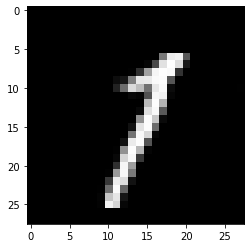

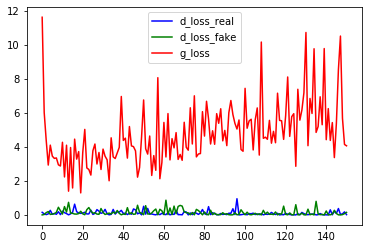

[151/200][0/938] Loss_D: 0.1693 Loss_G: 3.3848 D(x): 0.9925 D(G(z)): 0.1220 / 0.1521
[151/200][100/938] Loss_D: 0.0754 Loss_G: 4.1533 D(x): 0.9998 D(G(z)): 0.0624 / 0.1116
[151/200][200/938] Loss_D: 0.1306 Loss_G: 3.9503 D(x): 0.9943 D(G(z)): 0.0916 / 0.0788
[151/200][300/938] Loss_D: 0.0448 Loss_G: 7.0376 D(x): 0.9711 D(G(z)): 0.0111 / 0.0106
[151/200][400/938] Loss_D: 0.0210 Loss_G: 6.4356 D(x): 0.9919 D(G(z)): 0.0124 / 0.0091
[151/200][500/938] Loss_D: 0.0945 Loss_G: 6.2120 D(x): 0.9442 D(G(z)): 0.0275 / 0.0107
[151/200][600/938] Loss_D: 0.0668 Loss_G: 5.0818 D(x): 0.9934 D(G(z)): 0.0399 / 0.0529
[151/200][700/938] Loss_D: 0.0464 Loss_G: 8.3055 D(x): 0.9584 D(G(z)): 0.0008 / 0.0013
[151/200][800/938] Loss_D: 0.1277 Loss_G: 5.4444 D(x): 0.9927 D(G(z)): 0.0857 / 0.0229
[151/200][900/938] Loss_D: 0.1935 Loss_G: 5.1880 D(x): 0.9528 D(G(z)): 0.0934 / 0.0594


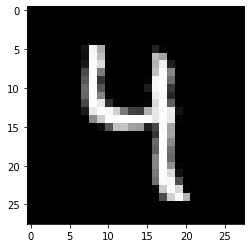

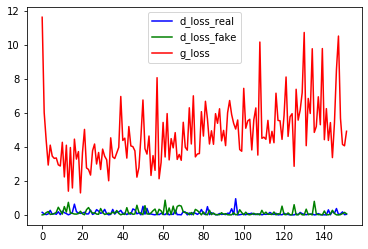

[152/200][0/938] Loss_D: 0.0871 Loss_G: 8.1714 D(x): 0.9338 D(G(z)): 0.0085 / 0.0078
[152/200][100/938] Loss_D: 0.0593 Loss_G: 6.9006 D(x): 0.9767 D(G(z)): 0.0298 / 0.0107
[152/200][200/938] Loss_D: 0.0830 Loss_G: 5.9054 D(x): 0.9823 D(G(z)): 0.0497 / 0.0253
[152/200][300/938] Loss_D: 0.3516 Loss_G: 3.8009 D(x): 0.9962 D(G(z)): 0.2138 / 0.0774
[152/200][400/938] Loss_D: 0.1235 Loss_G: 4.6118 D(x): 0.9659 D(G(z)): 0.0710 / 0.0630
[152/200][500/938] Loss_D: 0.0217 Loss_G: 6.8193 D(x): 0.9836 D(G(z)): 0.0047 / 0.0094
[152/200][600/938] Loss_D: 0.0511 Loss_G: 5.7266 D(x): 0.9753 D(G(z)): 0.0231 / 0.0195
[152/200][700/938] Loss_D: 0.0394 Loss_G: 7.0085 D(x): 0.9708 D(G(z)): 0.0069 / 0.0073
[152/200][800/938] Loss_D: 0.1151 Loss_G: 5.0115 D(x): 0.9642 D(G(z)): 0.0557 / 0.0353
[152/200][900/938] Loss_D: 0.8458 Loss_G: 6.7326 D(x): 0.5979 D(G(z)): 0.0209 / 0.0234


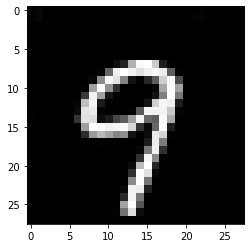

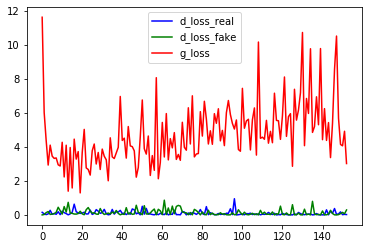

[153/200][0/938] Loss_D: 0.1808 Loss_G: 4.4501 D(x): 0.9936 D(G(z)): 0.1190 / 0.0593
[153/200][100/938] Loss_D: 0.9383 Loss_G: 7.7565 D(x): 0.5655 D(G(z)): 0.0039 / 0.0075
[153/200][200/938] Loss_D: 0.0536 Loss_G: 6.0915 D(x): 0.9953 D(G(z)): 0.0428 / 0.0176
[153/200][300/938] Loss_D: 0.1063 Loss_G: 4.2065 D(x): 0.9989 D(G(z)): 0.0859 / 0.0587
[153/200][400/938] Loss_D: 0.2374 Loss_G: 3.8841 D(x): 0.9844 D(G(z)): 0.1568 / 0.0755
[153/200][500/938] Loss_D: 0.0889 Loss_G: 5.8009 D(x): 0.9351 D(G(z)): 0.0120 / 0.0162
[153/200][600/938] Loss_D: 0.1368 Loss_G: 4.3584 D(x): 0.9925 D(G(z)): 0.0866 / 0.0736
[153/200][700/938] Loss_D: 0.0127 Loss_G: 6.9216 D(x): 0.9923 D(G(z)): 0.0048 / 0.0063
[153/200][800/938] Loss_D: 0.1008 Loss_G: 5.2469 D(x): 0.9911 D(G(z)): 0.0769 / 0.0262
[153/200][900/938] Loss_D: 0.0635 Loss_G: 6.0440 D(x): 0.9909 D(G(z)): 0.0464 / 0.0167


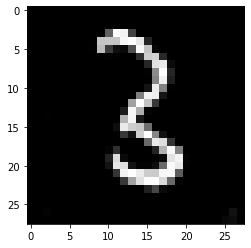

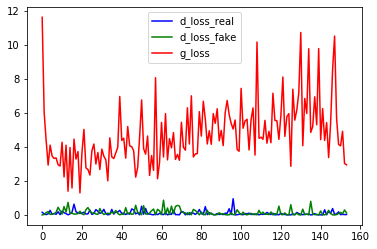

[154/200][0/938] Loss_D: 0.0197 Loss_G: 5.1333 D(x): 0.9976 D(G(z)): 0.0166 / 0.0357
[154/200][100/938] Loss_D: 0.3705 Loss_G: 7.2641 D(x): 0.7733 D(G(z)): 0.0087 / 0.0104
[154/200][200/938] Loss_D: 0.0495 Loss_G: 5.7497 D(x): 0.9909 D(G(z)): 0.0346 / 0.0251
[154/200][300/938] Loss_D: 0.4352 Loss_G: 5.7945 D(x): 0.7108 D(G(z)): 0.0061 / 0.0173
[154/200][400/938] Loss_D: 0.0347 Loss_G: 6.6879 D(x): 0.9881 D(G(z)): 0.0202 / 0.0110
[154/200][500/938] Loss_D: 0.0828 Loss_G: 5.0706 D(x): 0.9674 D(G(z)): 0.0342 / 0.0432
[154/200][600/938] Loss_D: 0.0247 Loss_G: 6.1877 D(x): 0.9847 D(G(z)): 0.0088 / 0.0095
[154/200][700/938] Loss_D: 0.1486 Loss_G: 5.1819 D(x): 0.9960 D(G(z)): 0.0956 / 0.0390
[154/200][800/938] Loss_D: 0.0391 Loss_G: 6.1202 D(x): 0.9869 D(G(z)): 0.0218 / 0.0145
[154/200][900/938] Loss_D: 0.0541 Loss_G: 6.9881 D(x): 0.9778 D(G(z)): 0.0253 / 0.0111


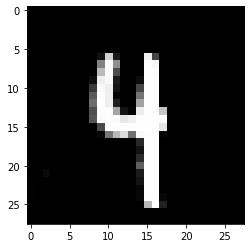

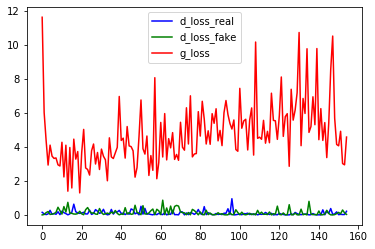

[155/200][0/938] Loss_D: 0.0211 Loss_G: 5.8048 D(x): 0.9936 D(G(z)): 0.0137 / 0.0218
[155/200][100/938] Loss_D: 0.0261 Loss_G: 6.0906 D(x): 0.9887 D(G(z)): 0.0138 / 0.0222
[155/200][200/938] Loss_D: 0.2610 Loss_G: 6.5418 D(x): 0.8304 D(G(z)): 0.0189 / 0.0161
[155/200][300/938] Loss_D: 0.1182 Loss_G: 4.4562 D(x): 0.9934 D(G(z)): 0.0892 / 0.0557
[155/200][400/938] Loss_D: 0.0208 Loss_G: 4.6864 D(x): 0.9972 D(G(z)): 0.0172 / 0.0360
[155/200][500/938] Loss_D: 0.3036 Loss_G: 4.8579 D(x): 0.8479 D(G(z)): 0.0631 / 0.0408
[155/200][600/938] Loss_D: 0.0696 Loss_G: 6.2715 D(x): 0.9624 D(G(z)): 0.0238 / 0.0180
[155/200][700/938] Loss_D: 0.0523 Loss_G: 6.8345 D(x): 0.9637 D(G(z)): 0.0102 / 0.0088
[155/200][800/938] Loss_D: 0.0670 Loss_G: 6.1949 D(x): 0.9542 D(G(z)): 0.0136 / 0.0235
[155/200][900/938] Loss_D: 0.3558 Loss_G: 5.0968 D(x): 0.7809 D(G(z)): 0.0339 / 0.0236


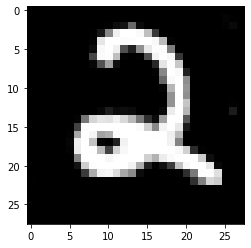

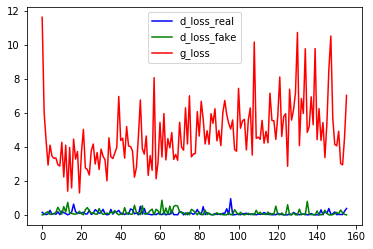

[156/200][0/938] Loss_D: 0.2191 Loss_G: 3.7100 D(x): 0.9353 D(G(z)): 0.0946 / 0.1266
[156/200][100/938] Loss_D: 0.0614 Loss_G: 5.6157 D(x): 0.9960 D(G(z)): 0.0471 / 0.0280
[156/200][200/938] Loss_D: 0.0266 Loss_G: 5.9281 D(x): 0.9868 D(G(z)): 0.0125 / 0.0155
[156/200][300/938] Loss_D: 0.0355 Loss_G: 7.8839 D(x): 0.9782 D(G(z)): 0.0105 / 0.0063
[156/200][400/938] Loss_D: 0.0685 Loss_G: 4.8849 D(x): 0.9880 D(G(z)): 0.0487 / 0.0365
[156/200][500/938] Loss_D: 0.1143 Loss_G: 5.5525 D(x): 0.9437 D(G(z)): 0.0309 / 0.0271
[156/200][600/938] Loss_D: 0.2506 Loss_G: 7.3439 D(x): 0.8287 D(G(z)): 0.0030 / 0.0069
[156/200][700/938] Loss_D: 0.0939 Loss_G: 5.5099 D(x): 0.9309 D(G(z)): 0.0123 / 0.0281
[156/200][800/938] Loss_D: 0.1819 Loss_G: 5.4129 D(x): 0.8904 D(G(z)): 0.0291 / 0.0330
[156/200][900/938] Loss_D: 0.0866 Loss_G: 6.8092 D(x): 0.9466 D(G(z)): 0.0226 / 0.0094


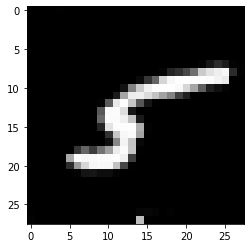

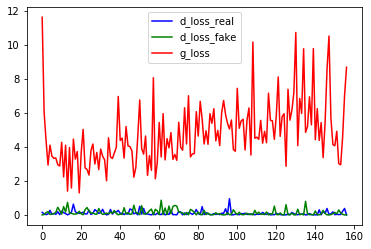

[157/200][0/938] Loss_D: 0.0942 Loss_G: 6.1388 D(x): 0.9545 D(G(z)): 0.0239 / 0.0158
[157/200][100/938] Loss_D: 0.0333 Loss_G: 5.9483 D(x): 0.9962 D(G(z)): 0.0237 / 0.0259
[157/200][200/938] Loss_D: 0.0176 Loss_G: 6.4141 D(x): 0.9886 D(G(z)): 0.0060 / 0.0070
[157/200][300/938] Loss_D: 0.6369 Loss_G: 4.1210 D(x): 0.9927 D(G(z)): 0.3156 / 0.0632
[157/200][400/938] Loss_D: 0.2195 Loss_G: 2.6629 D(x): 0.9911 D(G(z)): 0.1457 / 0.1798
[157/200][500/938] Loss_D: 0.1429 Loss_G: 5.6117 D(x): 0.9997 D(G(z)): 0.1057 / 0.0235
[157/200][600/938] Loss_D: 0.1455 Loss_G: 5.4673 D(x): 0.9809 D(G(z)): 0.0839 / 0.0266
[157/200][700/938] Loss_D: 0.5452 Loss_G: 7.0236 D(x): 0.7255 D(G(z)): 0.0026 / 0.0062
[157/200][800/938] Loss_D: 0.0273 Loss_G: 7.1367 D(x): 0.9816 D(G(z)): 0.0081 / 0.0082
[157/200][900/938] Loss_D: 0.4294 Loss_G: 7.6853 D(x): 0.7286 D(G(z)): 0.0069 / 0.0104


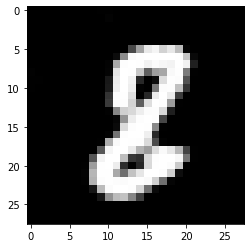

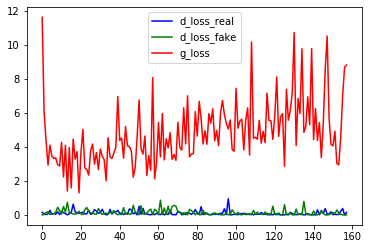

[158/200][0/938] Loss_D: 0.2153 Loss_G: 7.9854 D(x): 0.8501 D(G(z)): 0.0032 / 0.0052
[158/200][100/938] Loss_D: 0.0325 Loss_G: 5.2431 D(x): 0.9971 D(G(z)): 0.0269 / 0.0619
[158/200][200/938] Loss_D: 0.5368 Loss_G: 3.3116 D(x): 0.6982 D(G(z)): 0.0181 / 0.1435
[158/200][300/938] Loss_D: 0.1103 Loss_G: 4.6107 D(x): 0.9825 D(G(z)): 0.0658 / 0.0613
[158/200][400/938] Loss_D: 0.0795 Loss_G: 6.3703 D(x): 0.9487 D(G(z)): 0.0213 / 0.0136
[158/200][500/938] Loss_D: 0.0296 Loss_G: 5.7930 D(x): 0.9855 D(G(z)): 0.0138 / 0.0134
[158/200][600/938] Loss_D: 0.6269 Loss_G: 8.8836 D(x): 0.6780 D(G(z)): 0.0022 / 0.0026
[158/200][700/938] Loss_D: 0.0536 Loss_G: 6.4151 D(x): 0.9960 D(G(z)): 0.0373 / 0.0261
[158/200][800/938] Loss_D: 0.0523 Loss_G: 4.3517 D(x): 0.9881 D(G(z)): 0.0353 / 0.1022
[158/200][900/938] Loss_D: 0.0116 Loss_G: 7.1182 D(x): 0.9929 D(G(z)): 0.0042 / 0.0050


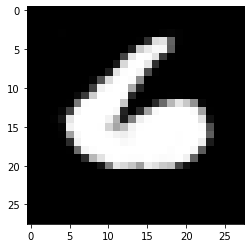

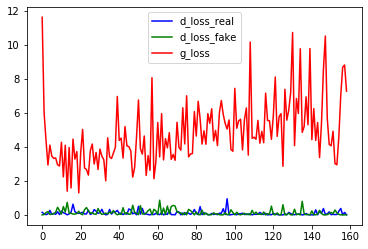

[159/200][0/938] Loss_D: 0.4551 Loss_G: 9.7559 D(x): 0.7280 D(G(z)): 0.0001 / 0.0003
[159/200][100/938] Loss_D: 0.0172 Loss_G: 7.2582 D(x): 0.9920 D(G(z)): 0.0081 / 0.0058
[159/200][200/938] Loss_D: 0.0636 Loss_G: 4.7297 D(x): 0.9905 D(G(z)): 0.0466 / 0.0481
[159/200][300/938] Loss_D: 0.0930 Loss_G: 4.7380 D(x): 0.9632 D(G(z)): 0.0477 / 0.0342
[159/200][400/938] Loss_D: 0.0474 Loss_G: 4.8930 D(x): 0.9912 D(G(z)): 0.0304 / 0.0566
[159/200][500/938] Loss_D: 0.0368 Loss_G: 6.3705 D(x): 0.9824 D(G(z)): 0.0163 / 0.0133
[159/200][600/938] Loss_D: 0.2057 Loss_G: 3.8771 D(x): 0.9987 D(G(z)): 0.1146 / 0.0749
[159/200][700/938] Loss_D: 0.0294 Loss_G: 5.5419 D(x): 0.9921 D(G(z)): 0.0195 / 0.0191
[159/200][800/938] Loss_D: 0.1312 Loss_G: 5.8839 D(x): 0.9952 D(G(z)): 0.0878 / 0.0257
[159/200][900/938] Loss_D: 0.5887 Loss_G: 4.7576 D(x): 0.6862 D(G(z)): 0.0346 / 0.0636


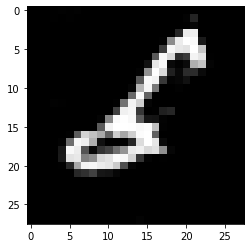

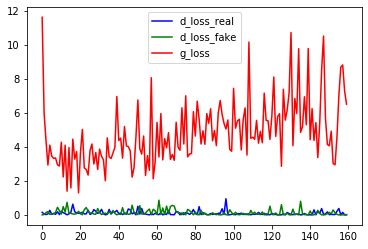

[160/200][0/938] Loss_D: 0.0260 Loss_G: 6.9232 D(x): 0.9810 D(G(z)): 0.0056 / 0.0060
[160/200][100/938] Loss_D: 0.0366 Loss_G: 6.1056 D(x): 0.9771 D(G(z)): 0.0095 / 0.0114
[160/200][200/938] Loss_D: 0.0998 Loss_G: 4.8004 D(x): 0.9809 D(G(z)): 0.0644 / 0.0451
[160/200][300/938] Loss_D: 0.0989 Loss_G: 6.5131 D(x): 0.9441 D(G(z)): 0.0201 / 0.0112
[160/200][400/938] Loss_D: 0.0255 Loss_G: 8.7265 D(x): 0.9822 D(G(z)): 0.0057 / 0.0031
[160/200][500/938] Loss_D: 0.1173 Loss_G: 5.0491 D(x): 0.9788 D(G(z)): 0.0795 / 0.0288
[160/200][600/938] Loss_D: 0.1504 Loss_G: 5.2573 D(x): 0.9828 D(G(z)): 0.0684 / 0.0293
[160/200][700/938] Loss_D: 0.0338 Loss_G: 6.6862 D(x): 0.9850 D(G(z)): 0.0170 / 0.0098
[160/200][800/938] Loss_D: 0.2128 Loss_G: 4.4408 D(x): 0.9900 D(G(z)): 0.1410 / 0.0437
[160/200][900/938] Loss_D: 0.0407 Loss_G: 5.4577 D(x): 0.9960 D(G(z)): 0.0335 / 0.0254


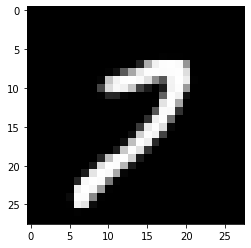

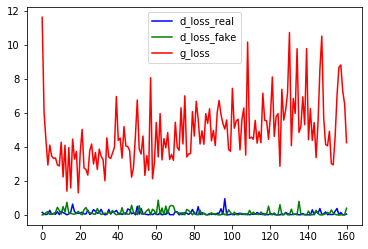

[161/200][0/938] Loss_D: 0.0277 Loss_G: 7.5137 D(x): 0.9913 D(G(z)): 0.0170 / 0.0055
[161/200][100/938] Loss_D: 0.0295 Loss_G: 5.9254 D(x): 0.9961 D(G(z)): 0.0236 / 0.0248
[161/200][200/938] Loss_D: 0.0597 Loss_G: 6.2398 D(x): 0.9606 D(G(z)): 0.0116 / 0.0116
[161/200][300/938] Loss_D: 0.0840 Loss_G: 7.5158 D(x): 0.9364 D(G(z)): 0.0080 / 0.0039
[161/200][400/938] Loss_D: 0.0813 Loss_G: 8.3086 D(x): 0.9522 D(G(z)): 0.0223 / 0.0045
[161/200][500/938] Loss_D: 0.1578 Loss_G: 6.0687 D(x): 0.8997 D(G(z)): 0.0151 / 0.0238
[161/200][600/938] Loss_D: 0.0330 Loss_G: 5.7942 D(x): 0.9888 D(G(z)): 0.0206 / 0.0113
[161/200][700/938] Loss_D: 0.2151 Loss_G: 5.9428 D(x): 0.8440 D(G(z)): 0.0128 / 0.0262
[161/200][800/938] Loss_D: 0.0500 Loss_G: 5.6319 D(x): 0.9922 D(G(z)): 0.0289 / 0.0296
[161/200][900/938] Loss_D: 0.3339 Loss_G: 9.1660 D(x): 0.7657 D(G(z)): 0.0006 / 0.0009


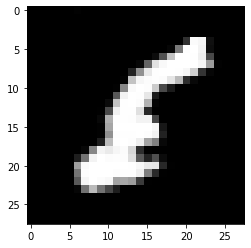

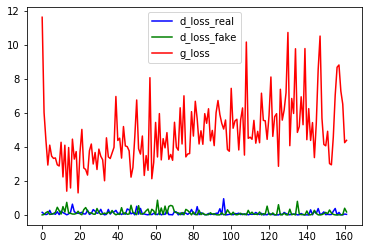

[162/200][0/938] Loss_D: 0.0796 Loss_G: 7.2168 D(x): 0.9380 D(G(z)): 0.0111 / 0.0073
[162/200][100/938] Loss_D: 0.0261 Loss_G: 5.4702 D(x): 0.9953 D(G(z)): 0.0174 / 0.0187
[162/200][200/938] Loss_D: 0.1213 Loss_G: 4.7363 D(x): 0.9661 D(G(z)): 0.0699 / 0.0423
[162/200][300/938] Loss_D: 0.0566 Loss_G: 5.3253 D(x): 0.9909 D(G(z)): 0.0389 / 0.0286
[162/200][400/938] Loss_D: 0.1401 Loss_G: 5.9835 D(x): 0.9007 D(G(z)): 0.0140 / 0.0201
[162/200][500/938] Loss_D: 0.4910 Loss_G: 6.2491 D(x): 0.6886 D(G(z)): 0.0023 / 0.0106
[162/200][600/938] Loss_D: 0.0419 Loss_G: 5.7287 D(x): 0.9959 D(G(z)): 0.0341 / 0.0238
[162/200][700/938] Loss_D: 0.1613 Loss_G: 4.7750 D(x): 0.9973 D(G(z)): 0.1144 / 0.0439
[162/200][800/938] Loss_D: 0.1365 Loss_G: 4.5358 D(x): 0.9888 D(G(z)): 0.0925 / 0.0566
[162/200][900/938] Loss_D: 0.1206 Loss_G: 4.1878 D(x): 0.9443 D(G(z)): 0.0509 / 0.0766


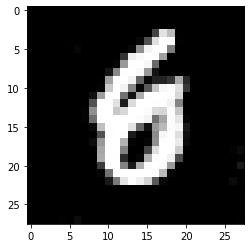

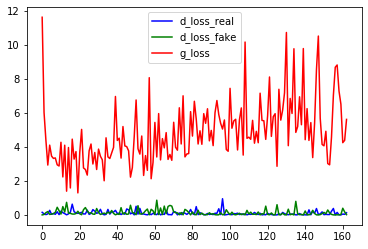

[163/200][0/938] Loss_D: 0.0908 Loss_G: 3.5143 D(x): 0.9929 D(G(z)): 0.0716 / 0.1182
[163/200][100/938] Loss_D: 0.0515 Loss_G: 9.2907 D(x): 0.9597 D(G(z)): 0.0008 / 0.0008
[163/200][200/938] Loss_D: 0.0943 Loss_G: 5.1303 D(x): 0.9378 D(G(z)): 0.0186 / 0.0301
[163/200][300/938] Loss_D: 0.0684 Loss_G: 5.7822 D(x): 0.9798 D(G(z)): 0.0414 / 0.0168
[163/200][400/938] Loss_D: 0.0838 Loss_G: 4.5481 D(x): 0.9931 D(G(z)): 0.0635 / 0.0685
[163/200][500/938] Loss_D: 0.0876 Loss_G: 4.9464 D(x): 0.9888 D(G(z)): 0.0643 / 0.0264
[163/200][600/938] Loss_D: 0.2352 Loss_G: 4.2426 D(x): 0.9383 D(G(z)): 0.1014 / 0.0696
[163/200][700/938] Loss_D: 0.0888 Loss_G: 6.3591 D(x): 0.9410 D(G(z)): 0.0214 / 0.0154
[163/200][800/938] Loss_D: 0.0400 Loss_G: 5.2551 D(x): 0.9910 D(G(z)): 0.0286 / 0.0360
[163/200][900/938] Loss_D: 0.0854 Loss_G: 5.5157 D(x): 0.9551 D(G(z)): 0.0310 / 0.0225


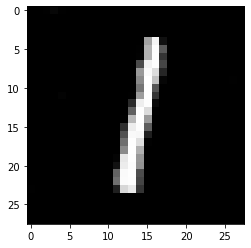

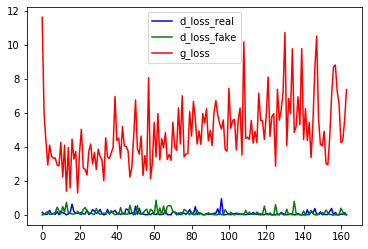

[164/200][0/938] Loss_D: 0.0914 Loss_G: 5.8340 D(x): 0.9974 D(G(z)): 0.0556 / 0.0315
[164/200][100/938] Loss_D: 0.0307 Loss_G: 7.3459 D(x): 0.9772 D(G(z)): 0.0064 / 0.0061
[164/200][200/938] Loss_D: 0.0513 Loss_G: 5.2623 D(x): 0.9941 D(G(z)): 0.0415 / 0.0296
[164/200][300/938] Loss_D: 0.0954 Loss_G: 6.6057 D(x): 0.9309 D(G(z)): 0.0050 / 0.0136
[164/200][400/938] Loss_D: 0.0951 Loss_G: 5.1829 D(x): 0.9753 D(G(z)): 0.0583 / 0.0370
[164/200][500/938] Loss_D: 0.3238 Loss_G: 5.4941 D(x): 0.9979 D(G(z)): 0.2138 / 0.0225
[164/200][600/938] Loss_D: 0.1291 Loss_G: 3.7736 D(x): 0.9971 D(G(z)): 0.0739 / 0.0901
[164/200][700/938] Loss_D: 0.0654 Loss_G: 8.1982 D(x): 0.9559 D(G(z)): 0.0138 / 0.0045
[164/200][800/938] Loss_D: 0.0185 Loss_G: 6.4942 D(x): 0.9970 D(G(z)): 0.0143 / 0.0115
[164/200][900/938] Loss_D: 0.2120 Loss_G: 5.3220 D(x): 0.9855 D(G(z)): 0.1300 / 0.0375


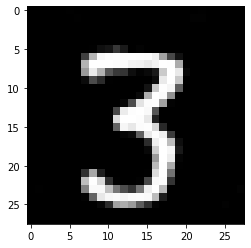

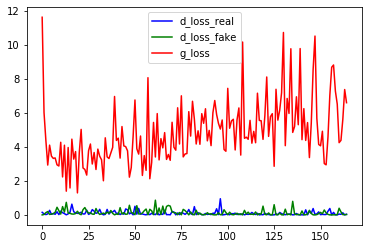

[165/200][0/938] Loss_D: 0.0917 Loss_G: 6.1158 D(x): 0.9608 D(G(z)): 0.0370 / 0.0230
[165/200][100/938] Loss_D: 0.0832 Loss_G: 4.2399 D(x): 0.9873 D(G(z)): 0.0471 / 0.0881
[165/200][200/938] Loss_D: 0.1098 Loss_G: 4.1878 D(x): 0.9939 D(G(z)): 0.0745 / 0.0634
[165/200][300/938] Loss_D: 0.0341 Loss_G: 6.3880 D(x): 0.9833 D(G(z)): 0.0154 / 0.0124
[165/200][400/938] Loss_D: 0.0835 Loss_G: 5.7858 D(x): 0.9758 D(G(z)): 0.0434 / 0.0189
[165/200][500/938] Loss_D: 0.0380 Loss_G: 5.4822 D(x): 0.9930 D(G(z)): 0.0266 / 0.0726
[165/200][600/938] Loss_D: 0.1192 Loss_G: 4.9348 D(x): 0.9949 D(G(z)): 0.0821 / 0.0478
[165/200][700/938] Loss_D: 0.0527 Loss_G: 5.6662 D(x): 0.9985 D(G(z)): 0.0445 / 0.0212
[165/200][800/938] Loss_D: 0.1693 Loss_G: 3.9659 D(x): 0.9866 D(G(z)): 0.0815 / 0.1182
[165/200][900/938] Loss_D: 0.1074 Loss_G: 5.4144 D(x): 0.9491 D(G(z)): 0.0363 / 0.0328


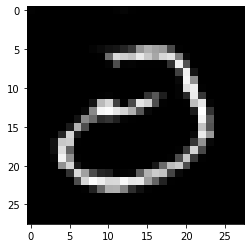

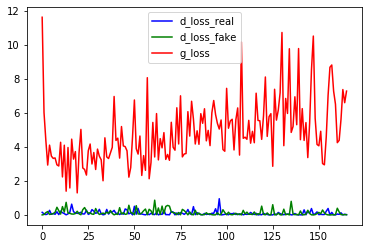

[166/200][0/938] Loss_D: 0.0152 Loss_G: 7.2882 D(x): 0.9948 D(G(z)): 0.0096 / 0.0039
[166/200][100/938] Loss_D: 0.1255 Loss_G: 5.7315 D(x): 0.9805 D(G(z)): 0.0737 / 0.0264
[166/200][200/938] Loss_D: 0.0476 Loss_G: 9.3918 D(x): 0.9573 D(G(z)): 0.0006 / 0.0007
[166/200][300/938] Loss_D: 0.4334 Loss_G: 5.0402 D(x): 0.7594 D(G(z)): 0.0399 / 0.0562
[166/200][400/938] Loss_D: 0.1300 Loss_G: 6.8653 D(x): 0.9360 D(G(z)): 0.0129 / 0.0116
[166/200][500/938] Loss_D: 0.0976 Loss_G: 5.3647 D(x): 0.9882 D(G(z)): 0.0681 / 0.0277
[166/200][600/938] Loss_D: 0.5335 Loss_G: 6.0101 D(x): 0.7249 D(G(z)): 0.0056 / 0.0166
[166/200][700/938] Loss_D: 0.0813 Loss_G: 5.4967 D(x): 0.9785 D(G(z)): 0.0343 / 0.0231
[166/200][800/938] Loss_D: 0.1339 Loss_G: 4.7645 D(x): 0.9911 D(G(z)): 0.0900 / 0.0399
[166/200][900/938] Loss_D: 0.0806 Loss_G: 9.4339 D(x): 0.9405 D(G(z)): 0.0081 / 0.0015


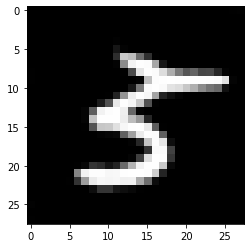

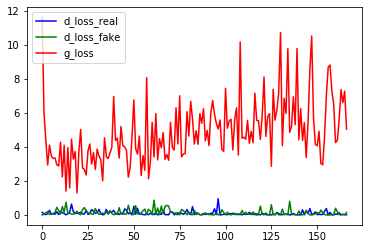

[167/200][0/938] Loss_D: 0.0373 Loss_G: 6.0078 D(x): 0.9959 D(G(z)): 0.0284 / 0.0235
[167/200][100/938] Loss_D: 0.1311 Loss_G: 6.8165 D(x): 0.9145 D(G(z)): 0.0168 / 0.0159
[167/200][200/938] Loss_D: 0.0190 Loss_G: 6.6502 D(x): 0.9913 D(G(z)): 0.0099 / 0.0085
[167/200][300/938] Loss_D: 0.0742 Loss_G: 6.1174 D(x): 0.9401 D(G(z)): 0.0072 / 0.0193
[167/200][400/938] Loss_D: 0.3129 Loss_G: 7.9080 D(x): 0.7798 D(G(z)): 0.0037 / 0.0038
[167/200][500/938] Loss_D: 0.0414 Loss_G: 8.2512 D(x): 0.9668 D(G(z)): 0.0057 / 0.0056
[167/200][600/938] Loss_D: 0.0302 Loss_G: 6.8342 D(x): 0.9811 D(G(z)): 0.0105 / 0.0091
[167/200][700/938] Loss_D: 0.0455 Loss_G: 8.8144 D(x): 0.9582 D(G(z)): 0.0008 / 0.0011
[167/200][800/938] Loss_D: 0.0368 Loss_G: 5.4205 D(x): 0.9950 D(G(z)): 0.0291 / 0.0334
[167/200][900/938] Loss_D: 0.0861 Loss_G: 6.0799 D(x): 0.9542 D(G(z)): 0.0293 / 0.0229


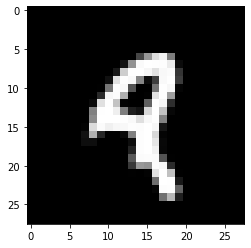

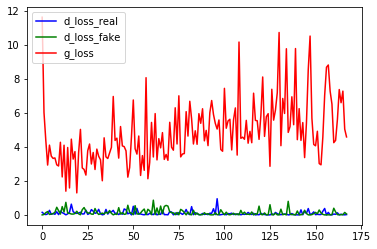

[168/200][0/938] Loss_D: 0.0495 Loss_G: 5.8110 D(x): 0.9814 D(G(z)): 0.0243 / 0.0231
[168/200][100/938] Loss_D: 0.0094 Loss_G: 8.1508 D(x): 0.9934 D(G(z)): 0.0027 / 0.0028
[168/200][200/938] Loss_D: 0.0400 Loss_G: 6.6251 D(x): 0.9787 D(G(z)): 0.0153 / 0.0126
[168/200][300/938] Loss_D: 0.2254 Loss_G: 4.7226 D(x): 0.9187 D(G(z)): 0.0931 / 0.0350
[168/200][400/938] Loss_D: 0.2163 Loss_G: 4.0887 D(x): 0.9993 D(G(z)): 0.1526 / 0.0697
[168/200][500/938] Loss_D: 0.0677 Loss_G: 5.7144 D(x): 0.9803 D(G(z)): 0.0353 / 0.0380
[168/200][600/938] Loss_D: 0.5909 Loss_G: 5.8985 D(x): 0.9658 D(G(z)): 0.2750 / 0.0331
[168/200][700/938] Loss_D: 0.0149 Loss_G: 7.6131 D(x): 0.9927 D(G(z)): 0.0072 / 0.0052
[168/200][800/938] Loss_D: 0.1052 Loss_G: 5.0783 D(x): 0.9833 D(G(z)): 0.0760 / 0.0344
[168/200][900/938] Loss_D: 0.0309 Loss_G: 5.7636 D(x): 0.9921 D(G(z)): 0.0206 / 0.0197


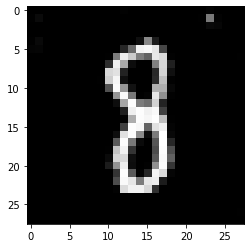

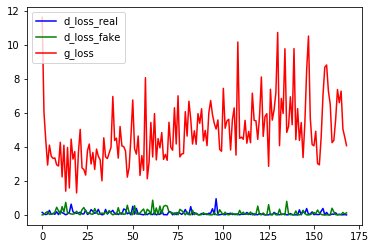

[169/200][0/938] Loss_D: 0.0811 Loss_G: 4.9296 D(x): 0.9978 D(G(z)): 0.0657 / 0.0688
[169/200][100/938] Loss_D: 0.0425 Loss_G: 8.8709 D(x): 0.9603 D(G(z)): 0.0007 / 0.0010
[169/200][200/938] Loss_D: 0.0371 Loss_G: 6.0395 D(x): 0.9761 D(G(z)): 0.0108 / 0.0145
[169/200][300/938] Loss_D: 0.1179 Loss_G: 4.7563 D(x): 0.9591 D(G(z)): 0.0608 / 0.0482
[169/200][400/938] Loss_D: 0.1767 Loss_G: 4.8576 D(x): 0.9545 D(G(z)): 0.0979 / 0.0433
[169/200][500/938] Loss_D: 0.0829 Loss_G: 6.7995 D(x): 0.9739 D(G(z)): 0.0321 / 0.0146
[169/200][600/938] Loss_D: 0.0868 Loss_G: 5.1463 D(x): 0.9511 D(G(z)): 0.0238 / 0.0284
[169/200][700/938] Loss_D: 0.0337 Loss_G: 9.9824 D(x): 0.9703 D(G(z)): 0.0018 / 0.0019
[169/200][800/938] Loss_D: 0.0196 Loss_G: 7.2173 D(x): 0.9859 D(G(z)): 0.0048 / 0.0051
[169/200][900/938] Loss_D: 0.0345 Loss_G: 6.3721 D(x): 0.9883 D(G(z)): 0.0170 / 0.0153


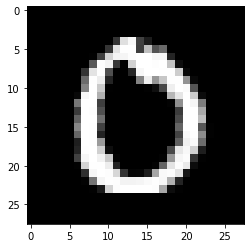

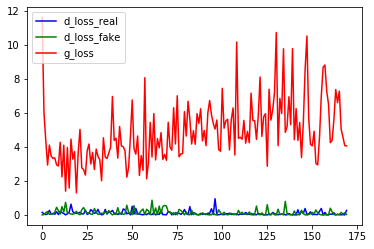

[170/200][0/938] Loss_D: 0.0171 Loss_G: 5.8708 D(x): 0.9984 D(G(z)): 0.0144 / 0.0330
[170/200][100/938] Loss_D: 0.1088 Loss_G: 6.6370 D(x): 0.9431 D(G(z)): 0.0381 / 0.0134
[170/200][200/938] Loss_D: 0.1833 Loss_G: 3.5790 D(x): 0.9978 D(G(z)): 0.1351 / 0.0978
[170/200][300/938] Loss_D: 0.0326 Loss_G: 6.0901 D(x): 0.9904 D(G(z)): 0.0187 / 0.0182
[170/200][400/938] Loss_D: 0.0464 Loss_G: 6.1463 D(x): 0.9776 D(G(z)): 0.0194 / 0.0161
[170/200][500/938] Loss_D: 0.2766 Loss_G: 4.5435 D(x): 0.9921 D(G(z)): 0.1740 / 0.0515
[170/200][600/938] Loss_D: 0.1642 Loss_G: 4.0235 D(x): 0.9612 D(G(z)): 0.0929 / 0.0589
[170/200][700/938] Loss_D: 0.4196 Loss_G: 3.8959 D(x): 0.9989 D(G(z)): 0.2351 / 0.0959
[170/200][800/938] Loss_D: 0.1185 Loss_G: 4.7286 D(x): 0.9692 D(G(z)): 0.0702 / 0.0367
[170/200][900/938] Loss_D: 0.0443 Loss_G: 6.7742 D(x): 0.9808 D(G(z)): 0.0204 / 0.0127


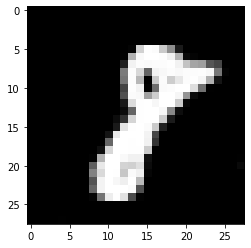

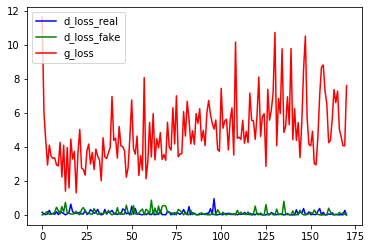

[171/200][0/938] Loss_D: 0.2135 Loss_G: 4.9133 D(x): 0.8734 D(G(z)): 0.0414 / 0.0427
[171/200][100/938] Loss_D: 0.0109 Loss_G: 7.0116 D(x): 0.9987 D(G(z)): 0.0092 / 0.0107
[171/200][200/938] Loss_D: 0.1718 Loss_G: 7.7369 D(x): 0.8639 D(G(z)): 0.0039 / 0.0067
[171/200][300/938] Loss_D: 0.3843 Loss_G: 5.3400 D(x): 0.7881 D(G(z)): 0.0270 / 0.0375
[171/200][400/938] Loss_D: 0.0756 Loss_G: 5.6226 D(x): 0.9928 D(G(z)): 0.0475 / 0.0377
[171/200][500/938] Loss_D: 0.0365 Loss_G: 6.8581 D(x): 0.9726 D(G(z)): 0.0073 / 0.0048
[171/200][600/938] Loss_D: 0.0521 Loss_G: 6.6355 D(x): 0.9702 D(G(z)): 0.0171 / 0.0158
[171/200][700/938] Loss_D: 0.0170 Loss_G: 7.2078 D(x): 0.9864 D(G(z)): 0.0029 / 0.0039
[171/200][800/938] Loss_D: 0.1272 Loss_G: 5.1680 D(x): 0.9954 D(G(z)): 0.0720 / 0.0443
[171/200][900/938] Loss_D: 0.1318 Loss_G: 5.0692 D(x): 0.9468 D(G(z)): 0.0524 / 0.0438


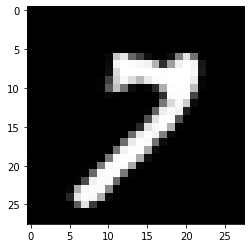

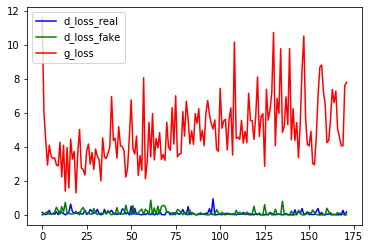

[172/200][0/938] Loss_D: 0.0596 Loss_G: 7.1200 D(x): 0.9530 D(G(z)): 0.0074 / 0.0082
[172/200][100/938] Loss_D: 0.1050 Loss_G: 8.8390 D(x): 0.9380 D(G(z)): 0.0128 / 0.0094
[172/200][200/938] Loss_D: 0.0381 Loss_G: 7.8314 D(x): 0.9662 D(G(z)): 0.0025 / 0.0029
[172/200][300/938] Loss_D: 0.0160 Loss_G: 6.9308 D(x): 0.9925 D(G(z)): 0.0080 / 0.0078
[172/200][400/938] Loss_D: 0.1697 Loss_G: 6.8672 D(x): 0.9415 D(G(z)): 0.0525 / 0.0203
[172/200][500/938] Loss_D: 0.1180 Loss_G: 4.0866 D(x): 0.9869 D(G(z)): 0.0802 / 0.0876
[172/200][600/938] Loss_D: 0.2023 Loss_G: 2.7636 D(x): 0.9905 D(G(z)): 0.1240 / 0.1847
[172/200][700/938] Loss_D: 0.0627 Loss_G: 5.4808 D(x): 0.9975 D(G(z)): 0.0487 / 0.0416
[172/200][800/938] Loss_D: 0.0280 Loss_G: 5.9578 D(x): 0.9903 D(G(z)): 0.0167 / 0.0151
[172/200][900/938] Loss_D: 0.1376 Loss_G: 9.0973 D(x): 0.8847 D(G(z)): 0.0026 / 0.0020


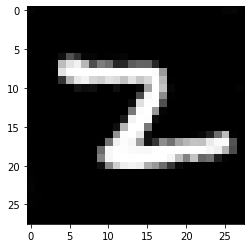

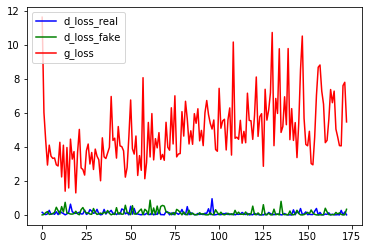

[173/200][0/938] Loss_D: 0.7459 Loss_G: 5.9064 D(x): 0.9681 D(G(z)): 0.2800 / 0.0550
[173/200][100/938] Loss_D: 0.0826 Loss_G: 6.7221 D(x): 0.9857 D(G(z)): 0.0225 / 0.0211
[173/200][200/938] Loss_D: 0.1706 Loss_G: 6.3671 D(x): 0.8714 D(G(z)): 0.0075 / 0.0143
[173/200][300/938] Loss_D: 0.0590 Loss_G: 5.6825 D(x): 0.9613 D(G(z)): 0.0170 / 0.0232
[173/200][400/938] Loss_D: 0.0550 Loss_G: 7.3391 D(x): 0.9548 D(G(z)): 0.0045 / 0.0040
[173/200][500/938] Loss_D: 0.2229 Loss_G: 4.6986 D(x): 0.8889 D(G(z)): 0.0588 / 0.0539
[173/200][600/938] Loss_D: 0.5378 Loss_G: 6.5159 D(x): 0.6827 D(G(z)): 0.0046 / 0.0149
[173/200][700/938] Loss_D: 0.0585 Loss_G: 6.0994 D(x): 0.9742 D(G(z)): 0.0295 / 0.0128
[173/200][800/938] Loss_D: 0.0448 Loss_G: 8.8192 D(x): 0.9668 D(G(z)): 0.0053 / 0.0020
[173/200][900/938] Loss_D: 0.0399 Loss_G: 5.3413 D(x): 0.9972 D(G(z)): 0.0346 / 0.0233


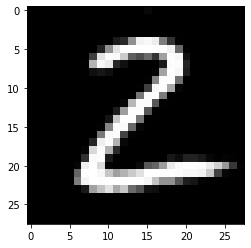

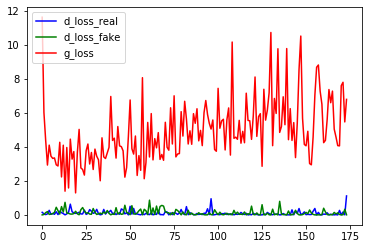

[174/200][0/938] Loss_D: 0.1113 Loss_G: 3.4772 D(x): 0.9977 D(G(z)): 0.0602 / 0.1031
[174/200][100/938] Loss_D: 0.0617 Loss_G: 4.2029 D(x): 0.9960 D(G(z)): 0.0436 / 0.0589
[174/200][200/938] Loss_D: 0.4884 Loss_G: 5.9170 D(x): 0.6982 D(G(z)): 0.0050 / 0.0231
[174/200][300/938] Loss_D: 0.4859 Loss_G: 3.8864 D(x): 0.7980 D(G(z)): 0.1245 / 0.1006
[174/200][400/938] Loss_D: 0.4131 Loss_G: 3.9676 D(x): 0.9700 D(G(z)): 0.2088 / 0.0623
[174/200][500/938] Loss_D: 0.1087 Loss_G: 6.4715 D(x): 0.9273 D(G(z)): 0.0209 / 0.0096
[174/200][600/938] Loss_D: 0.0161 Loss_G: 8.1342 D(x): 0.9883 D(G(z)): 0.0038 / 0.0032
[174/200][700/938] Loss_D: 0.3417 Loss_G: 2.0762 D(x): 0.9753 D(G(z)): 0.1615 / 0.3568
[174/200][800/938] Loss_D: 0.0142 Loss_G: 8.0414 D(x): 0.9896 D(G(z)): 0.0032 / 0.0068
[174/200][900/938] Loss_D: 0.0424 Loss_G: 7.8980 D(x): 0.9668 D(G(z)): 0.0056 / 0.0030


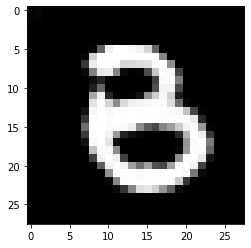

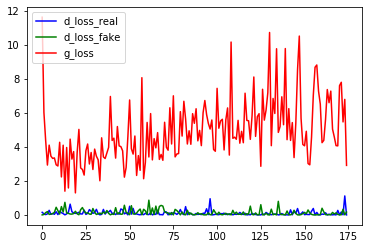

[175/200][0/938] Loss_D: 0.4454 Loss_G: 3.1370 D(x): 0.9997 D(G(z)): 0.2465 / 0.1655
[175/200][100/938] Loss_D: 0.2674 Loss_G: 3.7961 D(x): 0.9217 D(G(z)): 0.1167 / 0.0960
[175/200][200/938] Loss_D: 0.0103 Loss_G: 7.7138 D(x): 0.9958 D(G(z)): 0.0058 / 0.0051
[175/200][300/938] Loss_D: 0.0147 Loss_G: 7.5715 D(x): 0.9955 D(G(z)): 0.0094 / 0.0043
[175/200][400/938] Loss_D: 0.0757 Loss_G: 4.7069 D(x): 0.9959 D(G(z)): 0.0611 / 0.0355
[175/200][500/938] Loss_D: 0.0077 Loss_G: 6.5803 D(x): 0.9982 D(G(z)): 0.0058 / 0.0093
[175/200][600/938] Loss_D: 0.0326 Loss_G: 9.3263 D(x): 0.9739 D(G(z)): 0.0037 / 0.0027
[175/200][700/938] Loss_D: 0.0992 Loss_G: 6.3389 D(x): 0.9390 D(G(z)): 0.0227 / 0.0189
[175/200][800/938] Loss_D: 0.0271 Loss_G: 6.8619 D(x): 0.9816 D(G(z)): 0.0071 / 0.0092
[175/200][900/938] Loss_D: 0.0881 Loss_G: 7.4021 D(x): 0.9468 D(G(z)): 0.0208 / 0.0068


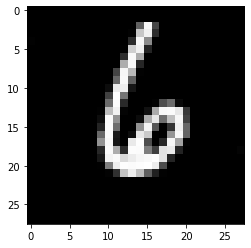

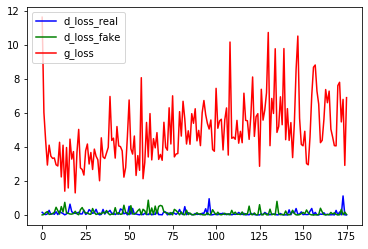

[176/200][0/938] Loss_D: 0.0955 Loss_G: 7.3478 D(x): 0.9326 D(G(z)): 0.0092 / 0.0063
[176/200][100/938] Loss_D: 0.0465 Loss_G: 6.8718 D(x): 0.9769 D(G(z)): 0.0180 / 0.0091
[176/200][200/938] Loss_D: 0.0822 Loss_G: 4.1378 D(x): 0.9916 D(G(z)): 0.0621 / 0.0589
[176/200][300/938] Loss_D: 0.0334 Loss_G: 6.9747 D(x): 0.9768 D(G(z)): 0.0084 / 0.0201
[176/200][400/938] Loss_D: 0.0185 Loss_G: 5.9205 D(x): 0.9907 D(G(z)): 0.0091 / 0.0120
[176/200][500/938] Loss_D: 0.0238 Loss_G: 7.4641 D(x): 0.9894 D(G(z)): 0.0114 / 0.0076
[176/200][600/938] Loss_D: 0.1221 Loss_G: 5.7103 D(x): 0.9489 D(G(z)): 0.0339 / 0.0277
[176/200][700/938] Loss_D: 0.0390 Loss_G: 7.0049 D(x): 0.9809 D(G(z)): 0.0167 / 0.0122
[176/200][800/938] Loss_D: 0.1405 Loss_G: 6.1367 D(x): 0.9964 D(G(z)): 0.0814 / 0.0188
[176/200][900/938] Loss_D: 0.2185 Loss_G: 6.2270 D(x): 0.8396 D(G(z)): 0.0056 / 0.0077


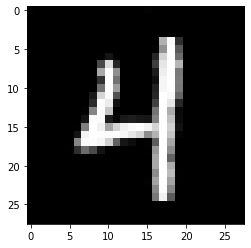

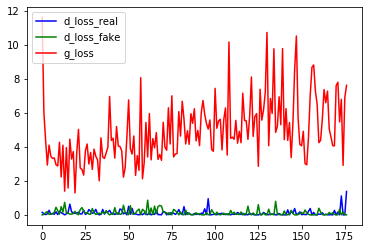

[177/200][0/938] Loss_D: 0.7668 Loss_G: 6.1453 D(x): 0.5873 D(G(z)): 0.0050 / 0.0249
[177/200][100/938] Loss_D: 0.1245 Loss_G: 4.8791 D(x): 0.9838 D(G(z)): 0.0660 / 0.0744
[177/200][200/938] Loss_D: 0.1162 Loss_G: 4.6639 D(x): 0.9930 D(G(z)): 0.0603 / 0.0687
[177/200][300/938] Loss_D: 0.0215 Loss_G: 7.1870 D(x): 0.9865 D(G(z)): 0.0073 / 0.0051
[177/200][400/938] Loss_D: 0.0092 Loss_G: 7.0071 D(x): 0.9975 D(G(z)): 0.0065 / 0.0066
[177/200][500/938] Loss_D: 0.0566 Loss_G: 5.1078 D(x): 0.9852 D(G(z)): 0.0349 / 0.0288
[177/200][600/938] Loss_D: 0.0274 Loss_G: 6.4228 D(x): 0.9994 D(G(z)): 0.0243 / 0.0103
[177/200][700/938] Loss_D: 0.0527 Loss_G: 6.4435 D(x): 0.9834 D(G(z)): 0.0265 / 0.0191
[177/200][800/938] Loss_D: 0.2422 Loss_G: 7.9004 D(x): 0.8386 D(G(z)): 0.0009 / 0.0021
[177/200][900/938] Loss_D: 0.0824 Loss_G: 4.1519 D(x): 0.9984 D(G(z)): 0.0452 / 0.0767


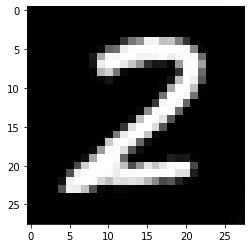

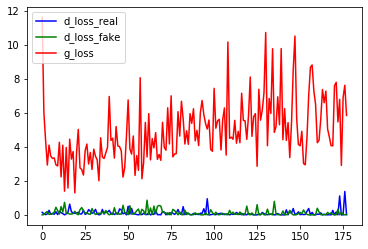

[178/200][0/938] Loss_D: 0.0452 Loss_G: 7.3483 D(x): 0.9947 D(G(z)): 0.0228 / 0.0184
[178/200][100/938] Loss_D: 0.1857 Loss_G: 3.6254 D(x): 0.9973 D(G(z)): 0.1233 / 0.1127
[178/200][200/938] Loss_D: 0.0371 Loss_G: 7.4656 D(x): 0.9925 D(G(z)): 0.0203 / 0.0150
[178/200][300/938] Loss_D: 0.0492 Loss_G: 8.8407 D(x): 0.9559 D(G(z)): 0.0017 / 0.0008
[178/200][400/938] Loss_D: 0.0222 Loss_G: 8.8675 D(x): 0.9808 D(G(z)): 0.0017 / 0.0015
[178/200][500/938] Loss_D: 0.0986 Loss_G: 5.7771 D(x): 0.9563 D(G(z)): 0.0367 / 0.0230
[178/200][600/938] Loss_D: 0.1175 Loss_G: 4.6452 D(x): 0.9926 D(G(z)): 0.0798 / 0.0581
[178/200][700/938] Loss_D: 0.0238 Loss_G: 6.5793 D(x): 0.9899 D(G(z)): 0.0128 / 0.0176
[178/200][800/938] Loss_D: 0.1457 Loss_G: 6.8899 D(x): 0.9954 D(G(z)): 0.1105 / 0.0076
[178/200][900/938] Loss_D: 0.0874 Loss_G: 5.2623 D(x): 0.9957 D(G(z)): 0.0624 / 0.0344


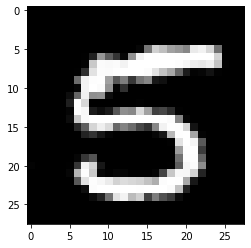

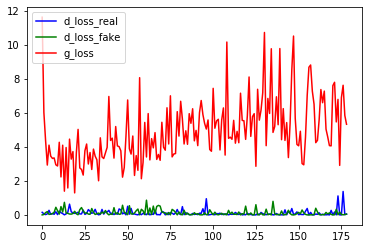

[179/200][0/938] Loss_D: 0.0283 Loss_G: 5.2870 D(x): 0.9937 D(G(z)): 0.0207 / 0.0270
[179/200][100/938] Loss_D: 0.0702 Loss_G: 5.8753 D(x): 0.9617 D(G(z)): 0.0182 / 0.0180
[179/200][200/938] Loss_D: 0.0762 Loss_G: 4.6319 D(x): 0.9790 D(G(z)): 0.0480 / 0.0367
[179/200][300/938] Loss_D: 0.0265 Loss_G: 5.6657 D(x): 0.9872 D(G(z)): 0.0126 / 0.0142
[179/200][400/938] Loss_D: 0.0396 Loss_G: 4.5439 D(x): 0.9951 D(G(z)): 0.0324 / 0.0279
[179/200][500/938] Loss_D: 0.0601 Loss_G: 5.5106 D(x): 0.9777 D(G(z)): 0.0317 / 0.0245
[179/200][600/938] Loss_D: 0.0085 Loss_G: 7.6924 D(x): 0.9956 D(G(z)): 0.0040 / 0.0024
[179/200][700/938] Loss_D: 0.1156 Loss_G: 7.3917 D(x): 0.9053 D(G(z)): 0.0020 / 0.0053
[179/200][800/938] Loss_D: 0.1264 Loss_G: 5.5612 D(x): 0.9851 D(G(z)): 0.0804 / 0.0249
[179/200][900/938] Loss_D: 0.3074 Loss_G: 6.8447 D(x): 0.8077 D(G(z)): 0.0058 / 0.0214


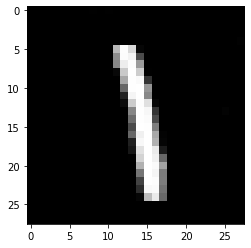

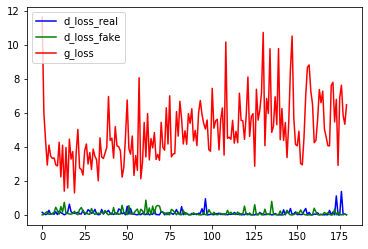

[180/200][0/938] Loss_D: 0.0522 Loss_G: 5.8067 D(x): 0.9945 D(G(z)): 0.0410 / 0.0300
[180/200][100/938] Loss_D: 0.0567 Loss_G: 6.1225 D(x): 0.9881 D(G(z)): 0.0351 / 0.0273
[180/200][200/938] Loss_D: 0.1489 Loss_G: 5.3950 D(x): 0.9893 D(G(z)): 0.0839 / 0.0464
[180/200][300/938] Loss_D: 0.1310 Loss_G: 4.5113 D(x): 0.9976 D(G(z)): 0.0834 / 0.0594
[180/200][400/938] Loss_D: 0.0194 Loss_G: 7.6162 D(x): 0.9849 D(G(z)): 0.0035 / 0.0037
[180/200][500/938] Loss_D: 0.1699 Loss_G: 4.9817 D(x): 0.9992 D(G(z)): 0.1114 / 0.0510
[180/200][600/938] Loss_D: 0.0073 Loss_G: 7.7017 D(x): 0.9977 D(G(z)): 0.0049 / 0.0049
[180/200][700/938] Loss_D: 0.1946 Loss_G: 6.7998 D(x): 0.8686 D(G(z)): 0.0084 / 0.0130
[180/200][800/938] Loss_D: 0.0906 Loss_G: 5.1661 D(x): 0.9984 D(G(z)): 0.0511 / 0.0431
[180/200][900/938] Loss_D: 0.1078 Loss_G: 4.6157 D(x): 0.9889 D(G(z)): 0.0784 / 0.0488


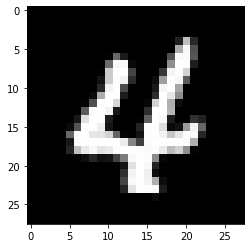

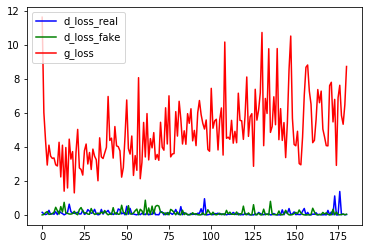

[181/200][0/938] Loss_D: 0.0492 Loss_G: 11.2764 D(x): 0.9612 D(G(z)): 0.0006 / 0.0001
[181/200][100/938] Loss_D: 0.1271 Loss_G: 5.6505 D(x): 0.9064 D(G(z)): 0.0090 / 0.0393
[181/200][200/938] Loss_D: 0.1469 Loss_G: 6.0790 D(x): 0.9660 D(G(z)): 0.0398 / 0.0232
[181/200][300/938] Loss_D: 0.0774 Loss_G: 5.7880 D(x): 0.9856 D(G(z)): 0.0490 / 0.0377
[181/200][400/938] Loss_D: 0.0589 Loss_G: 5.1472 D(x): 0.9994 D(G(z)): 0.0475 / 0.0391
[181/200][500/938] Loss_D: 0.0905 Loss_G: 6.2665 D(x): 0.9490 D(G(z)): 0.0262 / 0.0178
[181/200][600/938] Loss_D: 0.0215 Loss_G: 5.9895 D(x): 0.9982 D(G(z)): 0.0185 / 0.0173
[181/200][700/938] Loss_D: 0.0478 Loss_G: 6.3469 D(x): 0.9885 D(G(z)): 0.0301 / 0.0394
[181/200][800/938] Loss_D: 0.1538 Loss_G: 5.2184 D(x): 0.9599 D(G(z)): 0.0689 / 0.0307
[181/200][900/938] Loss_D: 0.4615 Loss_G: 4.9853 D(x): 0.7364 D(G(z)): 0.0136 / 0.0509


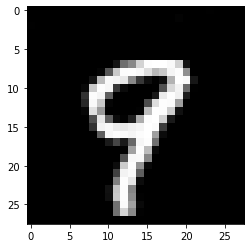

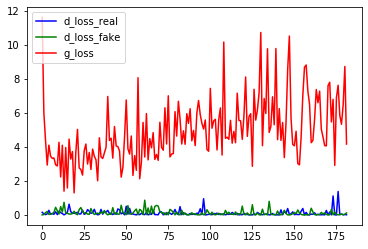

[182/200][0/938] Loss_D: 0.1551 Loss_G: 4.3855 D(x): 0.9990 D(G(z)): 0.1127 / 0.0826
[182/200][100/938] Loss_D: 0.1028 Loss_G: 3.8467 D(x): 0.9955 D(G(z)): 0.0794 / 0.1112
[182/200][200/938] Loss_D: 0.0665 Loss_G: 6.9111 D(x): 0.9431 D(G(z)): 0.0035 / 0.0049
[182/200][300/938] Loss_D: 0.1007 Loss_G: 7.9472 D(x): 0.9324 D(G(z)): 0.0085 / 0.0046
[182/200][400/938] Loss_D: 0.1239 Loss_G: 4.9062 D(x): 0.9888 D(G(z)): 0.0834 / 0.0459
[182/200][500/938] Loss_D: 0.0703 Loss_G: 6.9851 D(x): 0.9483 D(G(z)): 0.0051 / 0.0049
[182/200][600/938] Loss_D: 0.1145 Loss_G: 4.4573 D(x): 0.9766 D(G(z)): 0.0734 / 0.0399
[182/200][700/938] Loss_D: 0.3211 Loss_G: 9.6767 D(x): 0.7957 D(G(z)): 0.0017 / 0.0010
[182/200][800/938] Loss_D: 0.0703 Loss_G: 6.8435 D(x): 0.9599 D(G(z)): 0.0222 / 0.0154
[182/200][900/938] Loss_D: 0.0244 Loss_G: 5.7417 D(x): 0.9959 D(G(z)): 0.0192 / 0.0200


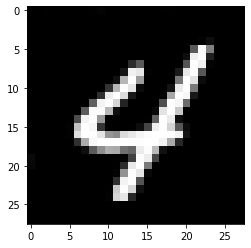

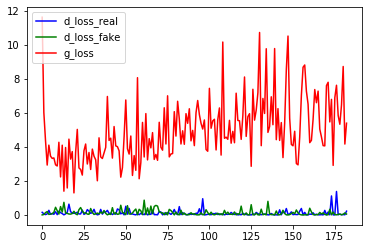

[183/200][0/938] Loss_D: 0.0514 Loss_G: 4.9513 D(x): 0.9911 D(G(z)): 0.0380 / 0.0439
[183/200][100/938] Loss_D: 0.0895 Loss_G: 5.7656 D(x): 0.9454 D(G(z)): 0.0162 / 0.0346
[183/200][200/938] Loss_D: 0.1026 Loss_G: 4.9860 D(x): 0.9947 D(G(z)): 0.0714 / 0.0434
[183/200][300/938] Loss_D: 0.0723 Loss_G: 7.9974 D(x): 0.9541 D(G(z)): 0.0036 / 0.0016
[183/200][400/938] Loss_D: 0.1134 Loss_G: 5.4379 D(x): 0.9935 D(G(z)): 0.0607 / 0.0442
[183/200][500/938] Loss_D: 0.0455 Loss_G: 10.5048 D(x): 0.9602 D(G(z)): 0.0005 / 0.0004
[183/200][600/938] Loss_D: 0.0889 Loss_G: 3.7829 D(x): 0.9962 D(G(z)): 0.0676 / 0.1249
[183/200][700/938] Loss_D: 0.1169 Loss_G: 7.2735 D(x): 0.9663 D(G(z)): 0.0428 / 0.0272
[183/200][800/938] Loss_D: 0.0273 Loss_G: 7.9107 D(x): 0.9778 D(G(z)): 0.0038 / 0.0043
[183/200][900/938] Loss_D: 0.0683 Loss_G: 4.9641 D(x): 0.9963 D(G(z)): 0.0515 / 0.0501


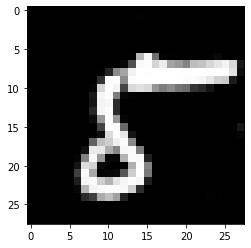

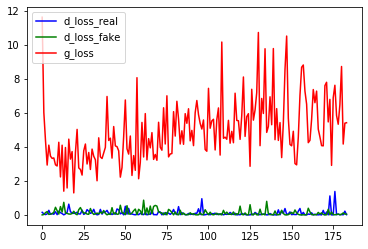

[184/200][0/938] Loss_D: 0.0488 Loss_G: 6.5926 D(x): 0.9896 D(G(z)): 0.0275 / 0.0216
[184/200][100/938] Loss_D: 0.0646 Loss_G: 4.9763 D(x): 0.9742 D(G(z)): 0.0339 / 0.0412
[184/200][200/938] Loss_D: 0.0940 Loss_G: 5.9807 D(x): 0.9324 D(G(z)): 0.0130 / 0.0261
[184/200][300/938] Loss_D: 0.1438 Loss_G: 5.9229 D(x): 0.9790 D(G(z)): 0.0912 / 0.0223
[184/200][400/938] Loss_D: 0.0896 Loss_G: 6.8694 D(x): 0.9345 D(G(z)): 0.0082 / 0.0135
[184/200][500/938] Loss_D: 0.2339 Loss_G: 4.4381 D(x): 0.9538 D(G(z)): 0.1168 / 0.0599
[184/200][600/938] Loss_D: 0.0147 Loss_G: 7.3153 D(x): 0.9949 D(G(z)): 0.0091 / 0.0084
[184/200][700/938] Loss_D: 0.0599 Loss_G: 6.1622 D(x): 0.9725 D(G(z)): 0.0233 / 0.0164
[184/200][800/938] Loss_D: 0.2115 Loss_G: 6.7949 D(x): 0.8725 D(G(z)): 0.0357 / 0.0181
[184/200][900/938] Loss_D: 0.0365 Loss_G: 11.5095 D(x): 0.9679 D(G(z)): 0.0003 / 0.0001


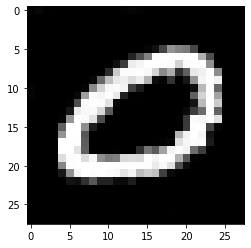

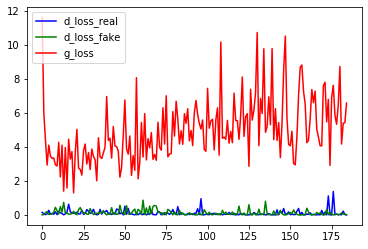

[185/200][0/938] Loss_D: 0.0101 Loss_G: 7.1200 D(x): 0.9987 D(G(z)): 0.0085 / 0.0056
[185/200][100/938] Loss_D: 0.1283 Loss_G: 4.7287 D(x): 0.9982 D(G(z)): 0.0865 / 0.0515
[185/200][200/938] Loss_D: 0.0524 Loss_G: 7.9665 D(x): 0.9645 D(G(z)): 0.0112 / 0.0057
[185/200][300/938] Loss_D: 0.3178 Loss_G: 11.0187 D(x): 0.7674 D(G(z)): 0.0001 / 0.0001
[185/200][400/938] Loss_D: 0.3003 Loss_G: 3.4905 D(x): 0.9982 D(G(z)): 0.1946 / 0.1038
[185/200][500/938] Loss_D: 0.1309 Loss_G: 7.2022 D(x): 0.9063 D(G(z)): 0.0079 / 0.0051
[185/200][600/938] Loss_D: 0.2447 Loss_G: 3.7973 D(x): 0.9967 D(G(z)): 0.1459 / 0.0932
[185/200][700/938] Loss_D: 0.1556 Loss_G: 4.9587 D(x): 0.9920 D(G(z)): 0.0850 / 0.0580
[185/200][800/938] Loss_D: 0.0574 Loss_G: 7.5017 D(x): 0.9897 D(G(z)): 0.0240 / 0.0132
[185/200][900/938] Loss_D: 0.2435 Loss_G: 4.7368 D(x): 0.9979 D(G(z)): 0.1510 / 0.0433


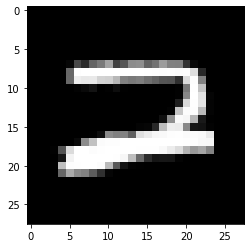

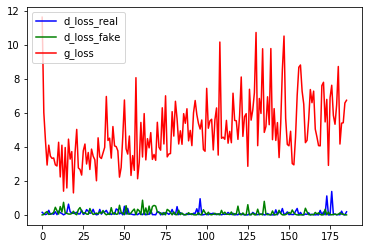

[186/200][0/938] Loss_D: 0.1011 Loss_G: 4.9029 D(x): 0.9608 D(G(z)): 0.0315 / 0.0552
[186/200][100/938] Loss_D: 0.6440 Loss_G: 3.2126 D(x): 0.9998 D(G(z)): 0.3373 / 0.1337
[186/200][200/938] Loss_D: 0.0245 Loss_G: 7.2968 D(x): 0.9859 D(G(z)): 0.0089 / 0.0105
[186/200][300/938] Loss_D: 0.0269 Loss_G: 5.8964 D(x): 0.9922 D(G(z)): 0.0171 / 0.0198
[186/200][400/938] Loss_D: 0.0515 Loss_G: 5.9417 D(x): 0.9988 D(G(z)): 0.0430 / 0.0272
[186/200][500/938] Loss_D: 0.0454 Loss_G: 9.2829 D(x): 0.9593 D(G(z)): 0.0016 / 0.0023
[186/200][600/938] Loss_D: 0.0505 Loss_G: 7.8728 D(x): 0.9573 D(G(z)): 0.0014 / 0.0022
[186/200][700/938] Loss_D: 0.1934 Loss_G: 5.1126 D(x): 0.8865 D(G(z)): 0.0178 / 0.0321
[186/200][800/938] Loss_D: 0.0448 Loss_G: 5.9191 D(x): 0.9956 D(G(z)): 0.0320 / 0.0224
[186/200][900/938] Loss_D: 0.5497 Loss_G: 3.9326 D(x): 0.9995 D(G(z)): 0.2978 / 0.0677


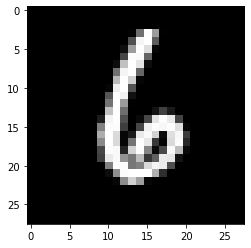

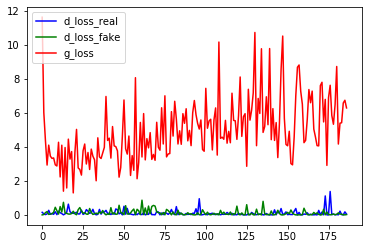

[187/200][0/938] Loss_D: 0.0539 Loss_G: 5.5314 D(x): 0.9896 D(G(z)): 0.0352 / 0.0316
[187/200][100/938] Loss_D: 0.0263 Loss_G: 8.6798 D(x): 0.9773 D(G(z)): 0.0022 / 0.0017
[187/200][200/938] Loss_D: 0.0443 Loss_G: 5.8782 D(x): 0.9759 D(G(z)): 0.0160 / 0.0158
[187/200][300/938] Loss_D: 0.0756 Loss_G: 7.2329 D(x): 0.9990 D(G(z)): 0.0557 / 0.0118
[187/200][400/938] Loss_D: 0.2623 Loss_G: 8.0440 D(x): 0.8079 D(G(z)): 0.0057 / 0.0040
[187/200][500/938] Loss_D: 0.2672 Loss_G: 6.1971 D(x): 0.8107 D(G(z)): 0.0098 / 0.0249
[187/200][600/938] Loss_D: 0.0112 Loss_G: 8.1770 D(x): 0.9911 D(G(z)): 0.0020 / 0.0018
[187/200][700/938] Loss_D: 0.2632 Loss_G: 5.1044 D(x): 0.9994 D(G(z)): 0.1560 / 0.0360
[187/200][800/938] Loss_D: 0.0764 Loss_G: 6.4635 D(x): 0.9878 D(G(z)): 0.0386 / 0.0254
[187/200][900/938] Loss_D: 0.1735 Loss_G: 4.9393 D(x): 0.9390 D(G(z)): 0.0709 / 0.0581


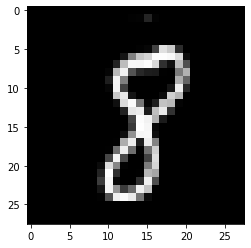

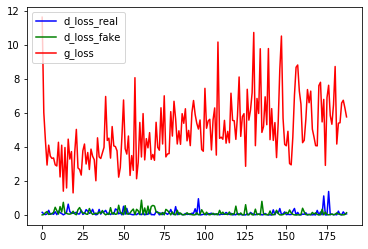

[188/200][0/938] Loss_D: 0.1066 Loss_G: 7.2928 D(x): 0.9206 D(G(z)): 0.0104 / 0.0104
[188/200][100/938] Loss_D: 0.0664 Loss_G: 5.7083 D(x): 0.9819 D(G(z)): 0.0362 / 0.0217
[188/200][200/938] Loss_D: 0.0406 Loss_G: 6.2190 D(x): 0.9936 D(G(z)): 0.0288 / 0.0168
[188/200][300/938] Loss_D: 0.1976 Loss_G: 7.8048 D(x): 0.8601 D(G(z)): 0.0017 / 0.0034
[188/200][400/938] Loss_D: 0.0375 Loss_G: 7.3685 D(x): 0.9695 D(G(z)): 0.0051 / 0.0046
[188/200][500/938] Loss_D: 0.0942 Loss_G: 5.1171 D(x): 0.9828 D(G(z)): 0.0573 / 0.0315
[188/200][600/938] Loss_D: 0.0515 Loss_G: 7.1413 D(x): 0.9652 D(G(z)): 0.0129 / 0.0074
[188/200][700/938] Loss_D: 0.1181 Loss_G: 4.7429 D(x): 0.9784 D(G(z)): 0.0641 / 0.0670
[188/200][800/938] Loss_D: 0.3031 Loss_G: 4.1246 D(x): 0.9199 D(G(z)): 0.1309 / 0.0779
[188/200][900/938] Loss_D: 0.0146 Loss_G: 7.5216 D(x): 0.9944 D(G(z)): 0.0084 / 0.0037


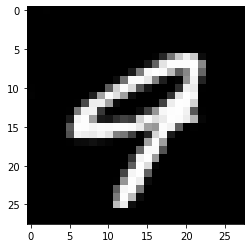

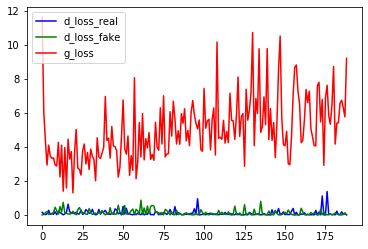

[189/200][0/938] Loss_D: 0.0344 Loss_G: 6.6113 D(x): 0.9954 D(G(z)): 0.0213 / 0.0141
[189/200][100/938] Loss_D: 0.0545 Loss_G: 6.7326 D(x): 0.9543 D(G(z)): 0.0050 / 0.0067
[189/200][200/938] Loss_D: 0.0369 Loss_G: 5.5842 D(x): 0.9929 D(G(z)): 0.0267 / 0.0216
[189/200][300/938] Loss_D: 0.0410 Loss_G: 5.4505 D(x): 0.9871 D(G(z)): 0.0247 / 0.0225
[189/200][400/938] Loss_D: 0.0718 Loss_G: 5.3687 D(x): 0.9538 D(G(z)): 0.0192 / 0.0263
[189/200][500/938] Loss_D: 0.0630 Loss_G: 7.8301 D(x): 0.9540 D(G(z)): 0.0028 / 0.0036
[189/200][600/938] Loss_D: 0.3277 Loss_G: 4.7595 D(x): 0.9992 D(G(z)): 0.2087 / 0.0459
[189/200][700/938] Loss_D: 0.1306 Loss_G: 4.6452 D(x): 0.9860 D(G(z)): 0.0896 / 0.0571
[189/200][800/938] Loss_D: 0.0937 Loss_G: 4.9861 D(x): 0.9902 D(G(z)): 0.0627 / 0.0342
[189/200][900/938] Loss_D: 0.1138 Loss_G: 7.5394 D(x): 0.9074 D(G(z)): 0.0059 / 0.0068


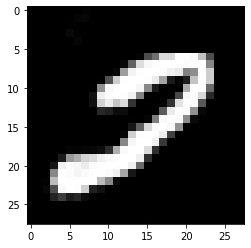

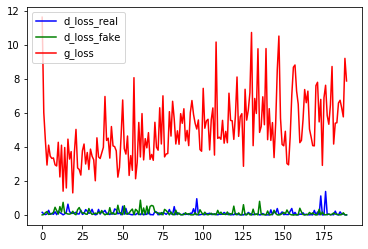

[190/200][0/938] Loss_D: 0.0592 Loss_G: 6.7974 D(x): 0.9659 D(G(z)): 0.0181 / 0.0184
[190/200][100/938] Loss_D: 0.0457 Loss_G: 5.7089 D(x): 0.9879 D(G(z)): 0.0293 / 0.0188
[190/200][200/938] Loss_D: 0.1808 Loss_G: 3.8367 D(x): 0.9997 D(G(z)): 0.1090 / 0.0913
[190/200][300/938] Loss_D: 0.0328 Loss_G: 6.2760 D(x): 0.9782 D(G(z)): 0.0097 / 0.0088
[190/200][400/938] Loss_D: 0.0979 Loss_G: 6.6783 D(x): 0.9308 D(G(z)): 0.0121 / 0.0134
[190/200][500/938] Loss_D: 0.0113 Loss_G: 7.2345 D(x): 0.9936 D(G(z)): 0.0047 / 0.0048
[190/200][600/938] Loss_D: 0.2249 Loss_G: 3.9826 D(x): 0.9891 D(G(z)): 0.1273 / 0.1010
[190/200][700/938] Loss_D: 0.1004 Loss_G: 5.8691 D(x): 0.9910 D(G(z)): 0.0530 / 0.0243
[190/200][800/938] Loss_D: 0.0211 Loss_G: 7.3050 D(x): 0.9921 D(G(z)): 0.0123 / 0.0066
[190/200][900/938] Loss_D: 0.0570 Loss_G: 5.2937 D(x): 0.9988 D(G(z)): 0.0421 / 0.0541


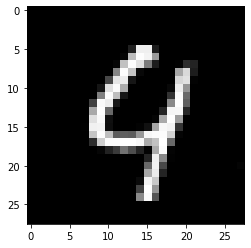

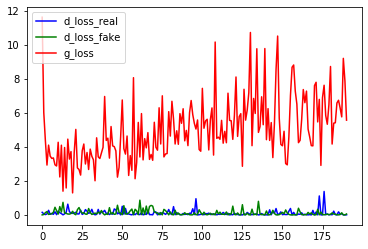

[191/200][0/938] Loss_D: 0.0533 Loss_G: 6.8203 D(x): 0.9873 D(G(z)): 0.0332 / 0.0157
[191/200][100/938] Loss_D: 0.0826 Loss_G: 4.6942 D(x): 0.9527 D(G(z)): 0.0275 / 0.0649
[191/200][200/938] Loss_D: 0.0505 Loss_G: 5.4652 D(x): 0.9674 D(G(z)): 0.0136 / 0.0301
[191/200][300/938] Loss_D: 0.0963 Loss_G: 6.2127 D(x): 0.9515 D(G(z)): 0.0296 / 0.0199
[191/200][400/938] Loss_D: 0.0257 Loss_G: 7.5970 D(x): 0.9894 D(G(z)): 0.0134 / 0.0050
[191/200][500/938] Loss_D: 0.0570 Loss_G: 5.5422 D(x): 0.9903 D(G(z)): 0.0392 / 0.0272
[191/200][600/938] Loss_D: 0.1940 Loss_G: 4.2942 D(x): 0.9440 D(G(z)): 0.0974 / 0.0615
[191/200][700/938] Loss_D: 0.1662 Loss_G: 8.9839 D(x): 0.8744 D(G(z)): 0.0019 / 0.0031
[191/200][800/938] Loss_D: 0.0907 Loss_G: 6.3910 D(x): 0.9442 D(G(z)): 0.0183 / 0.0180
[191/200][900/938] Loss_D: 0.0046 Loss_G: 8.2314 D(x): 0.9980 D(G(z)): 0.0026 / 0.0026


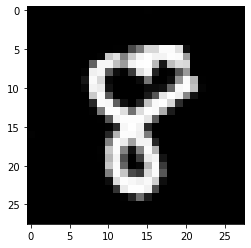

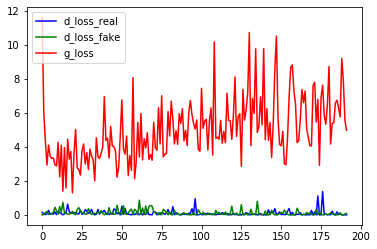

[192/200][0/938] Loss_D: 0.1193 Loss_G: 5.2676 D(x): 0.9971 D(G(z)): 0.0853 / 0.0371
[192/200][100/938] Loss_D: 0.1668 Loss_G: 8.8904 D(x): 0.8868 D(G(z)): 0.0010 / 0.0007
[192/200][200/938] Loss_D: 0.0391 Loss_G: 8.0681 D(x): 0.9671 D(G(z)): 0.0029 / 0.0021
[192/200][300/938] Loss_D: 0.1658 Loss_G: 8.4449 D(x): 0.8845 D(G(z)): 0.0037 / 0.0018
[192/200][400/938] Loss_D: 0.0568 Loss_G: 6.4002 D(x): 0.9884 D(G(z)): 0.0389 / 0.0166
[192/200][500/938] Loss_D: 0.0284 Loss_G: 5.8963 D(x): 0.9968 D(G(z)): 0.0213 / 0.0215
[192/200][600/938] Loss_D: 0.0775 Loss_G: 5.1068 D(x): 0.9947 D(G(z)): 0.0596 / 0.0367
[192/200][700/938] Loss_D: 0.0739 Loss_G: 5.1395 D(x): 0.9941 D(G(z)): 0.0565 / 0.0548
[192/200][800/938] Loss_D: 0.0218 Loss_G: 6.6963 D(x): 0.9916 D(G(z)): 0.0129 / 0.0074
[192/200][900/938] Loss_D: 0.2012 Loss_G: 5.4854 D(x): 0.9431 D(G(z)): 0.0918 / 0.0277


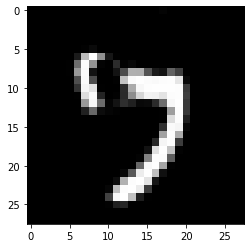

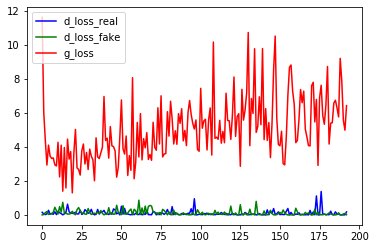

[193/200][0/938] Loss_D: 0.0784 Loss_G: 5.8473 D(x): 0.9657 D(G(z)): 0.0354 / 0.0317
[193/200][100/938] Loss_D: 0.0155 Loss_G: 8.1239 D(x): 0.9867 D(G(z)): 0.0017 / 0.0012
[193/200][200/938] Loss_D: 0.0900 Loss_G: 5.1137 D(x): 0.9919 D(G(z)): 0.0623 / 0.0348
[193/200][300/938] Loss_D: 0.0208 Loss_G: 8.3010 D(x): 0.9841 D(G(z)): 0.0036 / 0.0030
[193/200][400/938] Loss_D: 0.0839 Loss_G: 4.7529 D(x): 0.9956 D(G(z)): 0.0623 / 0.0467
[193/200][500/938] Loss_D: 0.0217 Loss_G: 5.9881 D(x): 0.9945 D(G(z)): 0.0149 / 0.0200
[193/200][600/938] Loss_D: 0.0298 Loss_G: 6.9705 D(x): 0.9958 D(G(z)): 0.0234 / 0.0069
[193/200][700/938] Loss_D: 0.0465 Loss_G: 7.6466 D(x): 0.9626 D(G(z)): 0.0046 / 0.0069
[193/200][800/938] Loss_D: 0.0444 Loss_G: 6.2985 D(x): 0.9719 D(G(z)): 0.0138 / 0.0146
[193/200][900/938] Loss_D: 0.5483 Loss_G: 7.7104 D(x): 0.6920 D(G(z)): 0.0048 / 0.0108


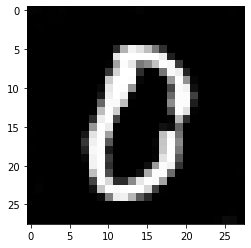

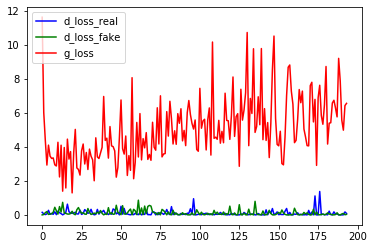

[194/200][0/938] Loss_D: 0.0292 Loss_G: 5.5960 D(x): 0.9906 D(G(z)): 0.0183 / 0.0255
[194/200][100/938] Loss_D: 0.0579 Loss_G: 5.9183 D(x): 0.9699 D(G(z)): 0.0219 / 0.0181
[194/200][200/938] Loss_D: 0.0487 Loss_G: 8.1017 D(x): 0.9574 D(G(z)): 0.0028 / 0.0022
[194/200][300/938] Loss_D: 0.1057 Loss_G: 5.5841 D(x): 0.9832 D(G(z)): 0.0391 / 0.0362
[194/200][400/938] Loss_D: 0.0097 Loss_G: 8.2821 D(x): 0.9925 D(G(z)): 0.0021 / 0.0029
[194/200][500/938] Loss_D: 0.0247 Loss_G: 10.3176 D(x): 0.9792 D(G(z)): 0.0021 / 0.0017
[194/200][600/938] Loss_D: 0.0284 Loss_G: 6.7994 D(x): 0.9839 D(G(z)): 0.0110 / 0.0083
[194/200][700/938] Loss_D: 0.2269 Loss_G: 8.7500 D(x): 0.8742 D(G(z)): 0.0091 / 0.0053
[194/200][800/938] Loss_D: 0.0980 Loss_G: 8.4233 D(x): 0.9292 D(G(z)): 0.0027 / 0.0027
[194/200][900/938] Loss_D: 0.0451 Loss_G: 6.6969 D(x): 0.9860 D(G(z)): 0.0278 / 0.0052


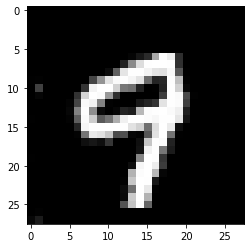

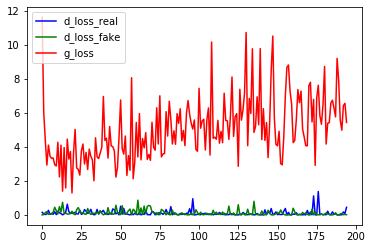

[195/200][0/938] Loss_D: 0.3068 Loss_G: 3.2976 D(x): 0.9019 D(G(z)): 0.1301 / 0.1533
[195/200][100/938] Loss_D: 0.1808 Loss_G: 5.6346 D(x): 0.9148 D(G(z)): 0.0543 / 0.0559
[195/200][200/938] Loss_D: 0.1800 Loss_G: 6.0269 D(x): 0.9432 D(G(z)): 0.0457 / 0.0377
[195/200][300/938] Loss_D: 0.3103 Loss_G: 3.5201 D(x): 0.9913 D(G(z)): 0.1701 / 0.1265
[195/200][400/938] Loss_D: 0.0366 Loss_G: 6.5572 D(x): 0.9787 D(G(z)): 0.0126 / 0.0140
[195/200][500/938] Loss_D: 0.0872 Loss_G: 7.5724 D(x): 0.9426 D(G(z)): 0.0198 / 0.0037
[195/200][600/938] Loss_D: 0.0407 Loss_G: 8.6378 D(x): 0.9747 D(G(z)): 0.0121 / 0.0051
[195/200][700/938] Loss_D: 0.0146 Loss_G: 6.9757 D(x): 0.9919 D(G(z)): 0.0062 / 0.0067
[195/200][800/938] Loss_D: 0.0306 Loss_G: 9.6854 D(x): 0.9729 D(G(z)): 0.0021 / 0.0011
[195/200][900/938] Loss_D: 0.0956 Loss_G: 6.1562 D(x): 0.9927 D(G(z)): 0.0431 / 0.0243


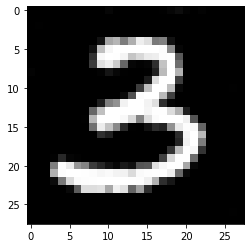

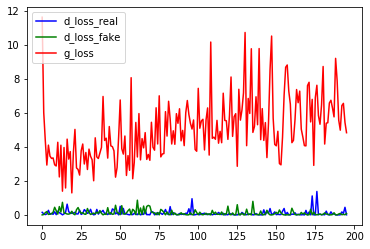

[196/200][0/938] Loss_D: 0.0385 Loss_G: 6.9393 D(x): 0.9933 D(G(z)): 0.0257 / 0.0130
[196/200][100/938] Loss_D: 0.0681 Loss_G: 5.3333 D(x): 0.9911 D(G(z)): 0.0493 / 0.0297
[196/200][200/938] Loss_D: 0.1699 Loss_G: 7.9429 D(x): 0.8626 D(G(z)): 0.0012 / 0.0025
[196/200][300/938] Loss_D: 0.0120 Loss_G: 8.5729 D(x): 0.9930 D(G(z)): 0.0046 / 0.0035
[196/200][400/938] Loss_D: 0.0223 Loss_G: 7.6770 D(x): 0.9858 D(G(z)): 0.0071 / 0.0080
[196/200][500/938] Loss_D: 0.0659 Loss_G: 6.6972 D(x): 0.9824 D(G(z)): 0.0330 / 0.0174
[196/200][600/938] Loss_D: 0.6285 Loss_G: 5.3283 D(x): 0.6999 D(G(z)): 0.0219 / 0.0398
[196/200][700/938] Loss_D: 0.4130 Loss_G: 4.4413 D(x): 0.9976 D(G(z)): 0.2166 / 0.0803
[196/200][800/938] Loss_D: 0.0470 Loss_G: 5.6640 D(x): 0.9748 D(G(z)): 0.0167 / 0.0241
[196/200][900/938] Loss_D: 0.0100 Loss_G: 7.8896 D(x): 0.9969 D(G(z)): 0.0068 / 0.0052


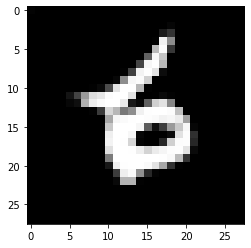

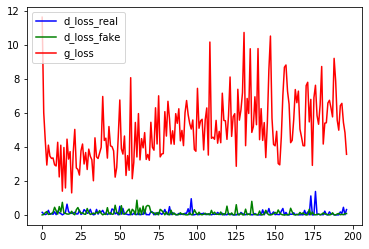

[197/200][0/938] Loss_D: 0.0720 Loss_G: 4.1131 D(x): 0.9857 D(G(z)): 0.0514 / 0.0602
[197/200][100/938] Loss_D: 0.1012 Loss_G: 4.7622 D(x): 0.9977 D(G(z)): 0.0662 / 0.0615
[197/200][200/938] Loss_D: 0.0060 Loss_G: 7.2988 D(x): 0.9998 D(G(z)): 0.0057 / 0.0046
[197/200][300/938] Loss_D: 0.0349 Loss_G: 5.9937 D(x): 0.9784 D(G(z)): 0.0118 / 0.0102
[197/200][400/938] Loss_D: 0.1189 Loss_G: 5.1917 D(x): 0.9322 D(G(z)): 0.0283 / 0.0417
[197/200][500/938] Loss_D: 0.2189 Loss_G: 4.4441 D(x): 0.9986 D(G(z)): 0.1397 / 0.0617
[197/200][600/938] Loss_D: 0.0845 Loss_G: 7.4078 D(x): 0.9371 D(G(z)): 0.0026 / 0.0052
[197/200][700/938] Loss_D: 0.1922 Loss_G: 7.4610 D(x): 0.8746 D(G(z)): 0.0015 / 0.0037
[197/200][800/938] Loss_D: 0.0359 Loss_G: 5.5241 D(x): 0.9974 D(G(z)): 0.0312 / 0.0206
[197/200][900/938] Loss_D: 0.1536 Loss_G: 4.4591 D(x): 0.9787 D(G(z)): 0.0893 / 0.0815


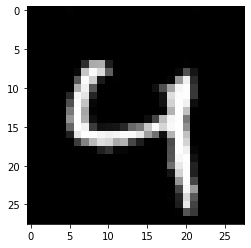

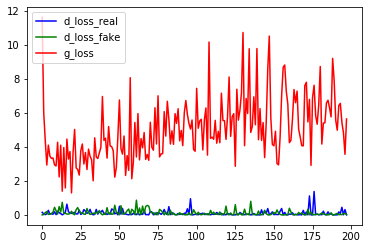

[198/200][0/938] Loss_D: 0.0527 Loss_G: 5.9022 D(x): 0.9954 D(G(z)): 0.0395 / 0.0258
[198/200][100/938] Loss_D: 0.0503 Loss_G: 5.7826 D(x): 0.9768 D(G(z)): 0.0187 / 0.0200
[198/200][200/938] Loss_D: 0.0693 Loss_G: 4.3484 D(x): 0.9821 D(G(z)): 0.0442 / 0.0516
[198/200][300/938] Loss_D: 0.0130 Loss_G: 6.6819 D(x): 0.9969 D(G(z)): 0.0095 / 0.0153
[198/200][400/938] Loss_D: 0.0943 Loss_G: 7.5365 D(x): 0.9702 D(G(z)): 0.0335 / 0.0166
[198/200][500/938] Loss_D: 0.1507 Loss_G: 9.8197 D(x): 0.8888 D(G(z)): 0.0023 / 0.0010
[198/200][600/938] Loss_D: 0.0257 Loss_G: 5.3703 D(x): 0.9871 D(G(z)): 0.0123 / 0.0288
[198/200][700/938] Loss_D: 0.0144 Loss_G: 9.1468 D(x): 0.9876 D(G(z)): 0.0016 / 0.0011
[198/200][800/938] Loss_D: 0.0155 Loss_G: 6.9824 D(x): 0.9973 D(G(z)): 0.0118 / 0.0062
[198/200][900/938] Loss_D: 0.0651 Loss_G: 5.4954 D(x): 0.9883 D(G(z)): 0.0433 / 0.0382


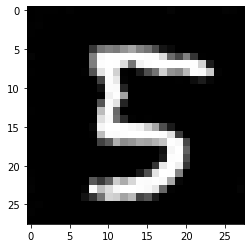

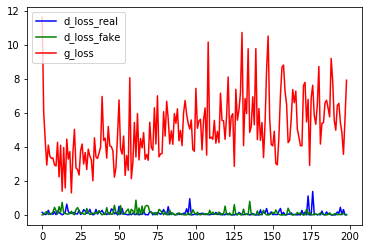

[199/200][0/938] Loss_D: 0.0365 Loss_G: 6.5496 D(x): 0.9914 D(G(z)): 0.0233 / 0.0189
[199/200][100/938] Loss_D: 0.0694 Loss_G: 5.8352 D(x): 0.9817 D(G(z)): 0.0424 / 0.0227
[199/200][200/938] Loss_D: 0.0455 Loss_G: 5.5956 D(x): 0.9983 D(G(z)): 0.0323 / 0.0363
[199/200][300/938] Loss_D: 0.8243 Loss_G: 3.3731 D(x): 0.9991 D(G(z)): 0.3130 / 0.1784
[199/200][400/938] Loss_D: 0.0127 Loss_G: 8.6722 D(x): 0.9900 D(G(z)): 0.0022 / 0.0014
[199/200][500/938] Loss_D: 0.0097 Loss_G: 8.3771 D(x): 0.9923 D(G(z)): 0.0018 / 0.0017
[199/200][600/938] Loss_D: 0.0113 Loss_G: 6.9428 D(x): 0.9931 D(G(z)): 0.0042 / 0.0112
[199/200][700/938] Loss_D: 0.1764 Loss_G: 5.7020 D(x): 0.8755 D(G(z)): 0.0130 / 0.0227
[199/200][800/938] Loss_D: 0.0888 Loss_G: 5.4309 D(x): 0.9960 D(G(z)): 0.0671 / 0.0324
[199/200][900/938] Loss_D: 0.0347 Loss_G: 6.4874 D(x): 0.9761 D(G(z)): 0.0073 / 0.0133


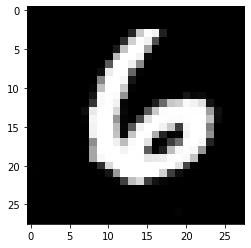

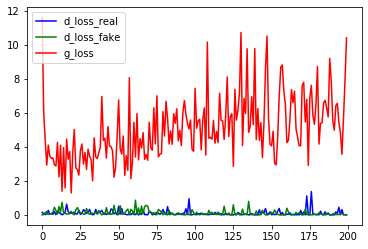

In [12]:
g_loss_list = []
epoch_list = []
d_loss_real_list = []
d_loss_fake_list = []
for epoch in range(niter):
    epoch_list.append(epoch)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_img = data[0].to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_img)
        errD_real = criterion(output, label)

        if i == len(dataloader) - 1:
          d_loss_real_list.append(errD_real)

        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        noise = noise.view(batch_size, nz, 1, -1)
        fake = netG(noise)

        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()

        if i == len(dataloader) - 1:
          d_loss_fake_list.append(errD_fake)

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()

        if i == len(dataloader) - 1:
          g_loss_list.append(errG)
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # Draw Sampled Images
    fake_images_clone = fake.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

    plt.plot(epoch_list, d_loss_real_list, 'b-', label = 'd_loss_real')
    plt.plot(epoch_list, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
    plt.plot(epoch_list, g_loss_list, 'r-', label = 'g_loss')
    plt.legend()
    plt.show()
        

# Save Models
torch.save(netG.state_dict(), G_save_loc)
torch.save(netD.state_dict(), D_save_loc)

# Setup and Train Auxiliary Classifier

## Data Augmentation

In [98]:
# Device setting
netD = netD.to(device)
netG = netG.to(device)

# Create an equal number of fake images
aug_size = len(dataset)
z = torch.randn(aug_size, nz, 1, 1).to(device)
fake_dataset_images = netG(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(dataset), 1, image_size, image_size))
for i in range(len(dataset)):
  original_data[i,:] = dataset[i][0]


RuntimeError: ignored

In [0]:
# Create augmented dataset
class AugDataset(torch.utils.data.Dataset):
    def __init__(self, original_data, generated_data):
        # Load Data 
        self.x_train = np.vstack((original_data, generated_data[0].numpy()))
      
        self.y_train = np.vstack((np.ones(((original_data.shape[0], 1))), np.zeros(((generated_data[0].numpy().shape[0], 1)))))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = AugDataset(original_data, fake_dataset)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

## Create Classifier

In [0]:
# Fully connected neural network with the same architecture as the Discriminator
class Classifier1(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input is (nc) x 28 x 28
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        self.relu1 = nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 14 x 14
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        self.bn1 = nn.BatchNorm2d(ndf * 2),
        self.relu2 =  nn.LeakyReLU(0.2, inplace=True),
        
        # state size. (ndf*2) x 7 x 7
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
        self.bn2 = nn.BatchNorm2d(ndf * 4),
        self.relu3 = nn.LeakyReLU(0.2, inplace=True),
            
        # state size. (ndf*4) x 4 x 4
        self.conv4 = nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        
        self.sig = nn.Sigmoid()

        self.criterion = nn.BCELoss()

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn1(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn2(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.sig(output)

        return output.view(-1, 1).squeeze(1)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.main2 = nn.Sequential(
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      
            nn.Sigmoid()
        )

        self.criterion = nn.BCELoss()

    def forward(self, input):
        output = self.main(input)
        output = self.main2(output)

        return output.view(-1, 1).squeeze(1)

clf = Classifier().to(device)
#clf.apply(weights_init)

## Train Classifier

In [96]:
# Train the model
num_epochs_clf = 100
total_step = len(train_loader)
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(0.9, 0.999))
for epoch in range(num_epochs_clf):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size).to(device)
        
        # Forward pass
        outputs = clf(images.float())
        loss = clf.criterion(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_clf, i+1, total_step, loss.item()))

RuntimeError: ignored

## Test Classifier

In [87]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size).to(device)

        outputs = clf(images.float())
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        predicted_labels = torch.where(outputs > 0.5, real_labels, fake_labels)

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 24000 test images: 96.69583333333334 %


# Get Intermediate Output

In [89]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = clf

activations = np.zeros((len(train_loader)*batch_size, 256, 4, 4))
original_images = np.zeros((len(train_loader)*batch_size, 1, 28, 28))
print(len(train_loader))
for i, (images, labels) in enumerate(train_loader):  
    images = images.to(device)

    model.main.register_forward_hook(get_activation('main'))
    int_output = model(images.float())
    act = activation['main']

    original_images[i*64:(i+1)*64, :, :, :] = images.cpu().numpy()
    activations[i*64:(i+1)*64, :, :, :] = act.cpu().numpy()

1500


In [0]:
# Create augmented dataset
class ReconstDataset(torch.utils.data.Dataset):
    def __init__(self, original_images, activations):
        # Load Data 
        self.x_train = activations
      
        self.y_train = original_images

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = ReconstDataset(original_images, activations)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

# Image Reconstruction

In [0]:
class ReconstNet(nn.Module):
    def __init__(self):
        super(ReconstNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output

reconstNet = ReconstNet().to(device)

Epoch [1/100], Step [500/1200], Loss: 1.3671
Epoch [1/100], Step [1000/1200], Loss: 1.3628


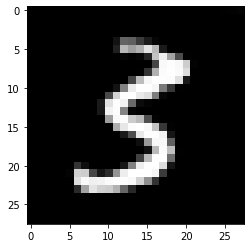

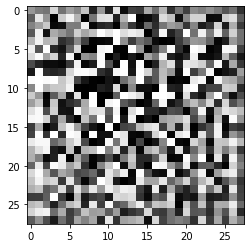

Epoch [2/100], Step [500/1200], Loss: 1.3741
Epoch [2/100], Step [1000/1200], Loss: 1.3706


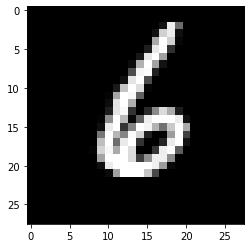

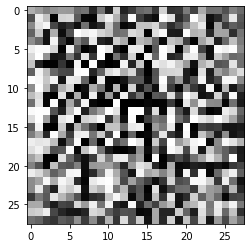

Epoch [3/100], Step [500/1200], Loss: 1.3669
Epoch [3/100], Step [1000/1200], Loss: 1.3661


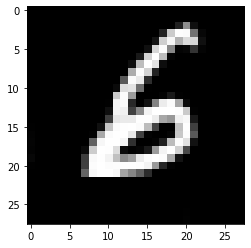

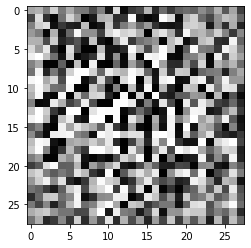

Epoch [4/100], Step [500/1200], Loss: 1.3694
Epoch [4/100], Step [1000/1200], Loss: 1.3697


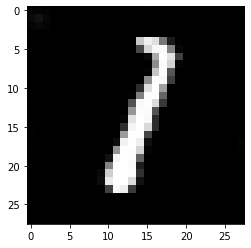

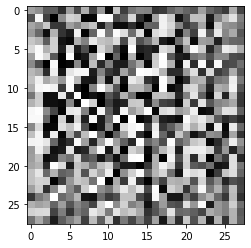

Epoch [5/100], Step [500/1200], Loss: 1.3601
Epoch [5/100], Step [1000/1200], Loss: 1.3692


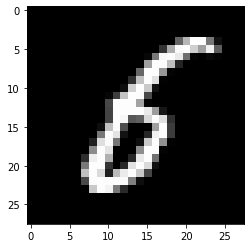

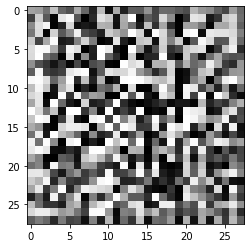

Epoch [6/100], Step [500/1200], Loss: 1.3661
Epoch [6/100], Step [1000/1200], Loss: 1.3620


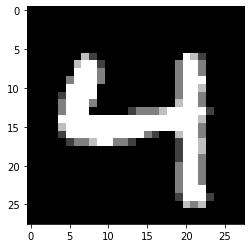

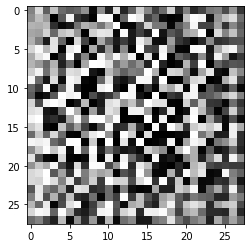

Epoch [7/100], Step [500/1200], Loss: 1.3682
Epoch [7/100], Step [1000/1200], Loss: 1.3648


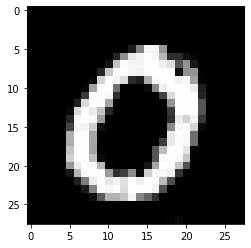

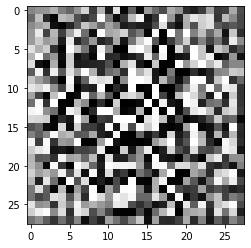

Epoch [8/100], Step [500/1200], Loss: 1.3674
Epoch [8/100], Step [1000/1200], Loss: 1.3662


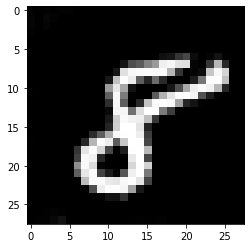

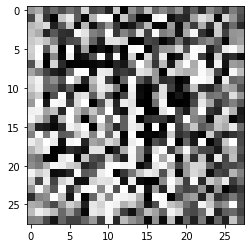

Epoch [9/100], Step [500/1200], Loss: 1.3745
Epoch [9/100], Step [1000/1200], Loss: 1.3630


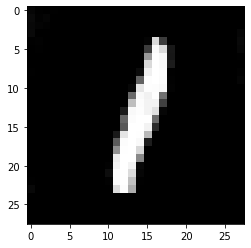

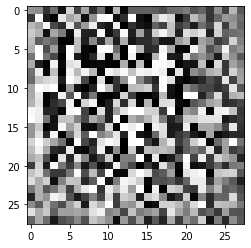

Epoch [10/100], Step [500/1200], Loss: 1.3691
Epoch [10/100], Step [1000/1200], Loss: 1.3635


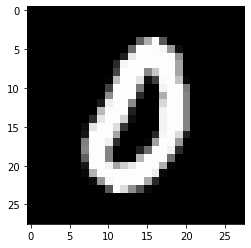

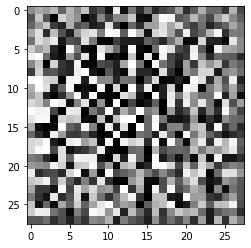

Epoch [11/100], Step [500/1200], Loss: 1.3523
Epoch [11/100], Step [1000/1200], Loss: 1.3679


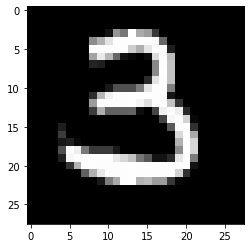

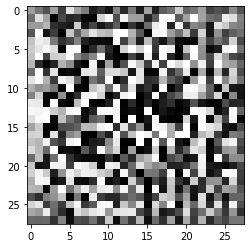

Epoch [12/100], Step [500/1200], Loss: 1.3663
Epoch [12/100], Step [1000/1200], Loss: 1.3697


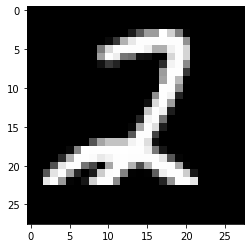

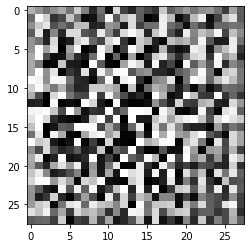

Epoch [13/100], Step [500/1200], Loss: 1.3710
Epoch [13/100], Step [1000/1200], Loss: 1.3624


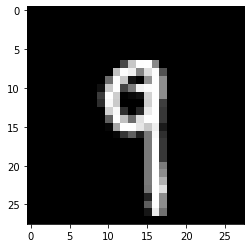

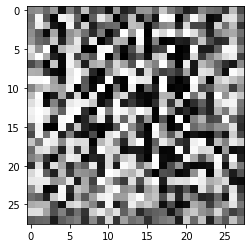

Epoch [14/100], Step [500/1200], Loss: 1.3573
Epoch [14/100], Step [1000/1200], Loss: 1.3722


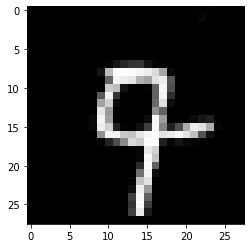

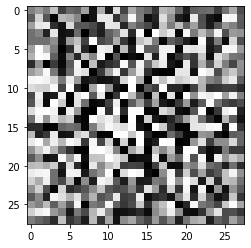

Epoch [15/100], Step [500/1200], Loss: 1.3677
Epoch [15/100], Step [1000/1200], Loss: 1.3633


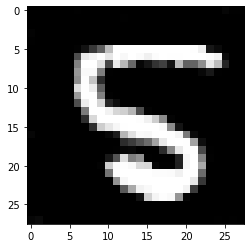

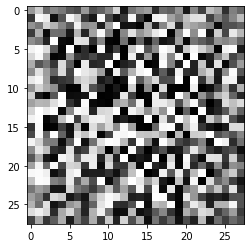

Epoch [16/100], Step [500/1200], Loss: 1.3685
Epoch [16/100], Step [1000/1200], Loss: 1.3664


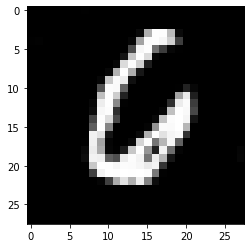

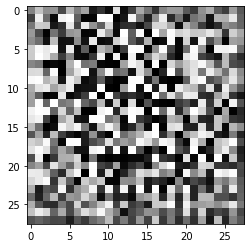

Epoch [17/100], Step [500/1200], Loss: 1.3687
Epoch [17/100], Step [1000/1200], Loss: 1.3681


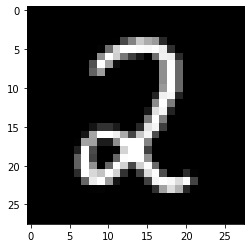

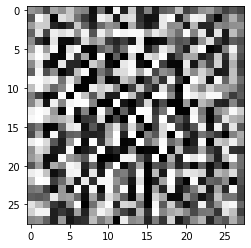

Epoch [18/100], Step [500/1200], Loss: 1.3739
Epoch [18/100], Step [1000/1200], Loss: 1.3733


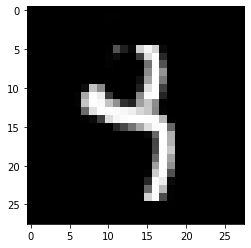

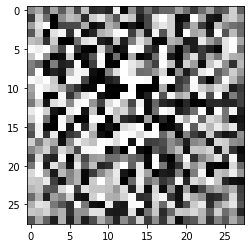

Epoch [19/100], Step [500/1200], Loss: 1.3610
Epoch [19/100], Step [1000/1200], Loss: 1.3671


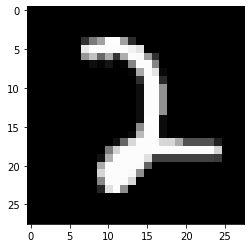

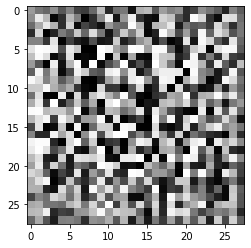

Epoch [20/100], Step [500/1200], Loss: 1.3697
Epoch [20/100], Step [1000/1200], Loss: 1.3626


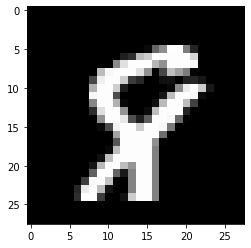

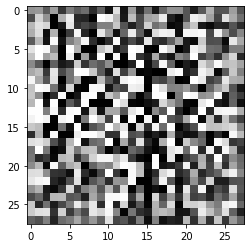

Epoch [21/100], Step [500/1200], Loss: 1.3667
Epoch [21/100], Step [1000/1200], Loss: 1.3710


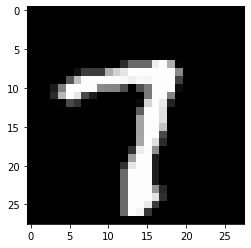

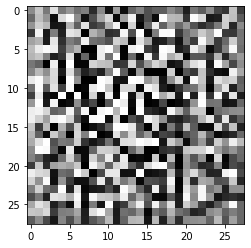

Epoch [22/100], Step [500/1200], Loss: 1.3658
Epoch [22/100], Step [1000/1200], Loss: 1.3680


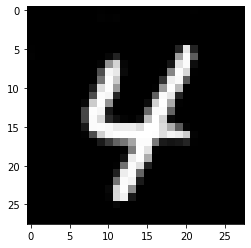

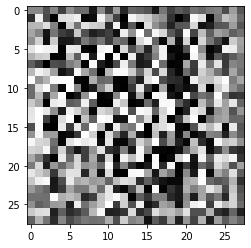

Epoch [23/100], Step [500/1200], Loss: 1.3621
Epoch [23/100], Step [1000/1200], Loss: 1.3659


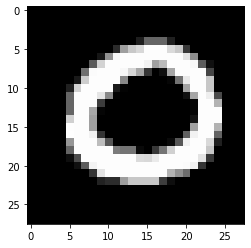

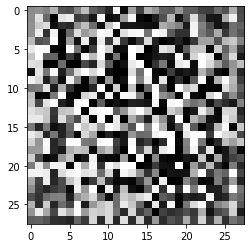

Epoch [24/100], Step [500/1200], Loss: 1.3656
Epoch [24/100], Step [1000/1200], Loss: 1.3635


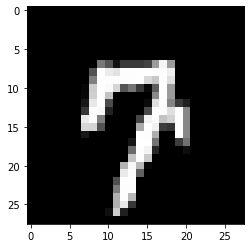

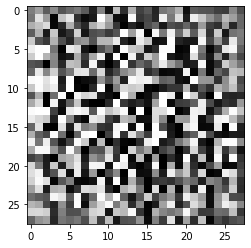

KeyboardInterrupt: ignored

In [95]:
# Train the model
num_epochs_reconst = 100
total_step = len(train_loader)
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(0.9, 0.999))
criterion_reconst = nn.MSELoss()
for epoch in range(num_epochs_reconst):
    for i, (act, images) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        act = act.to(device)
        
        # Forward pass
        outputs = reconstNet(act.float())
        loss = criterion_reconst(outputs, images.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_reconst, i+1, total_step, loss.item()))
            
    # Draw Sampled Images
    image_clone = images[0].clone()
    output_clone = outputs[0].clone()

    # Draw Original Image
    im = denorm(image_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show() 

    # Draw Reconst Image
    im = denorm(output_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()  